In [1]:
import pandas as pd
import numpy as np
from fastai.core import *
from PIL import Image
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [2]:
import json
from collections import defaultdict
import pdb
import numpy as np
from collections import defaultdict

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
coco = Path('newdata')
# coco = untar_data('classroomtest.coco.zip')
img_dir = Path(coco/'train')
anno_train = Path(coco/'anno/_annotations.coco.json')
# anno_valid = Path('dataset3/anno/valid_annotations.coco.json')

# annotation 여기에선 데이터 한꺼번에 불러오길래
# train val images 합쳐서 넣음
images, lbl_bbox = get_annotations(anno_train)
# images_,lbl_bbox_ = get_annotations(anno_valid)
# images.extend(images_)
# lbl_bbox.extend(lbl_bbox_)

# learn.predict(img)/

In [4]:
for idx, lbl in enumerate(lbl_bbox):
    if len(lbl[1]) == 0:
        print(f"found empty annotation: {idx}")

In [44]:
## 돌렸을때 경고문구는 원래그럼. 예제에도 있었음.


img_list = ImageList.from_folder(img_dir)
#image size
sz = 224
# print(len(img_list))
# ncat =9

img2bbox = dict(zip(images, lbl_bbox))
# img2bbox.sort()
print(type(images))
# cnt = 0
def get_y_func(o):
    filename = o.name
    if img2bbox.get(o.name):
        return img2bbox[o.name]
    else:
        # 데이터가 다 잘 들어간걸 확인했는데도 자꾸 오류가 나서 넣은 코드
        # 라벨링이 안된 사진이 들어갔을때 나는 오류라서
        # 임의로 bbox 리턴. 데이터 교체하면 오류 없을것.
        return [[[0, 0, 244, 244]], ['front']]

# ver 2
data = (ObjectItemList.from_folder(img_dir)
        .split_by_rand_pct(valid_pct=0.2, seed=0)                         
        .label_from_func(get_y_func)
#         .transform(size=224)
        .databunch(bs=3, collate_fn=bb_pad_collate, num_workers=0)
        .normalize(imagenet_stats)
        ) 
# data.add_test_folder(ObjectItemList.from_folder('test')
#              .split_none()
#              .transform(size=224)
#             .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#             .normalize(imagenet_stats)
#             )

# Test = (ObjectItemList.from_folder(img_dir/'test')
#              .split_none()
#              .transform(size=224)
#             .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#             .normalize(imagenet_stats))
# ver original
# data = (ObjectItemList.from_folder('dataset1.v1.coco/images')
#         .split_by_folder()                          
#         .label_from_func(get_y_func)
#         .transform(get_transforms(), tfm_y=True, size=224)
#         .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#         .normalize(imagenet_stats)
#        )

data

<class 'list'>


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


ImageDataBunch;

Train: LabelList (518 items)
x: ObjectItemList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: ObjectCategoryList
ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244)
Path: newdata\train;

Valid: LabelList (129 items)
x: ObjectItemList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: ObjectCategoryList
ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244)
Path: newdata\train;

Test: None

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


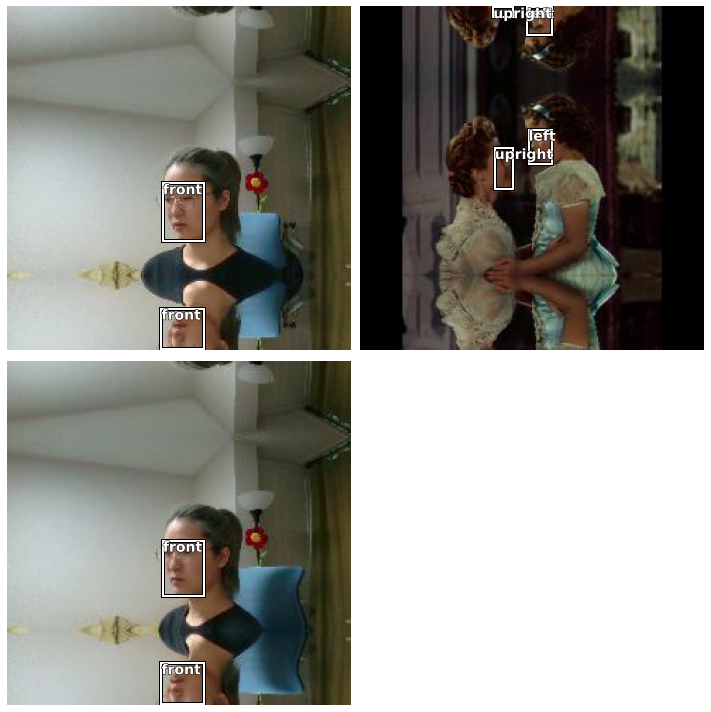

In [45]:
data.show_batch(rows=3, ds_type= DatasetType.Valid, figsize=(10,10))

In [46]:
# for idx, lbl in enumerate(lbl_bbox):
#     if len(lbl[1]) == 0:
#         print(f"found empty annotation: {idx}")

        
with open(anno_train) as f:
    train_json = json.load(f)

ncat = len(train_json['categories'])

print(ncat)
# train_json['categories']
# custom_head= 만들면 최고....

17


In [47]:
# def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

# # str 중심값, bbox 가로세로 메트릭스 연산으로 꼭지점 좌표 구하기
# # 그 좌표를 이용해서 anchor 박스보여주기

# def create_anchors(ncells=[4], zooms=[1.],ratios=[(1.,1.)]):
#     a_scales = [(z*i,z*j) for z in zooms for (i,j) in ratios]
#     k = len(a_scales)
#     a_x = np.concatenate([np.repeat(np.linspace(-1+1/nc, 1-1/nc, nc), nc) 
#                           for nc in ncells])
#     a_y = np.concatenate([np.tile(np.linspace(-1+1/nc, 1-1/nc, nc), nc)
#                           for nc in ncells])
#     a_ctrs = np.repeat(np.stack([a_x, a_y], axis=1), k, axis=0)
#     a_sz = np.concatenate([np.array([[2*o/nc,2*p/nc] 
#                                      for i in range(nc*nc)
#                                      for o,p in a_scales])
#                            for nc in ncells])
#     grid_sz = np.concatenate([np.array([2/nc 
#                                         for i in range(nc*nc)
#                                         for o,p in a_scales])
#                               for nc in ncells])
#     anc = np.concatenate([a_ctrs, a_sz], axis=1)
#     grid_sizes = torch.tensor(grid_sz).type(torch.FloatTensor).unsqueeze(1).cuda()
#     anchors = torch.tensor(anc).type(torch.FloatTensor).cuda()
#     anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
#     return anchors, anchor_cnr, grid_sizes

In [48]:
# anchors, anchor_cnr, grid_sizes = create_anchors(ncells=[4,2,1],
#                                                  zooms=[0.7, 1., 1.3],
#                                                  ratios=[(1.,1.), (1., 0.5), (0.5, 1.)])

In [10]:

# def intersect(box_a, box_b):
#     max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
#     min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
#     inter = torch.clamp((max_xy - min_xy), min=0)
#     return inter[:, :, 0] * inter[:, :, 1]

# def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

# def jaccard(box_a, box_b):
#     inter = intersect(box_a, box_b)
#     union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
#     return inter / union

# def map_to_ground_truth(overlaps, print_it=False):
#     prior_overlap, prior_idx = overlaps.max(1)
#     if print_it: print(prior_overlap)
# #     pdb.set_trace()
#     gt_overlap, gt_idx = overlaps.max(0)
#     gt_overlap[prior_idx] = 1.99
#     for i,o in enumerate(prior_idx): gt_idx[o] = i
#     return gt_overlap,gt_idx

# def actn_to_bb(actn, anchors):
#     actn_bbs = torch.tanh(actn)
#     actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2].cuda()
#     actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:].cuda()
#     return hw2corners(actn_centers, actn_hw)


In [11]:

# def one_hot_embedding(labels, num_classes):
#     return torch.eye(num_classes)[labels.data.cpu()]

# class BCE_Loss(nn.Module):
#     def __init__(self,num_classes):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, pred, targ):
#         t = one_hot_embedding(targ, self.num_classes+1)
# #         t = t[:,:-1].contiguous().cuda()
# #         x = pred[:,:-1]
#         # in fastai v1, the background is encoded as the first class, rather than the last one
#         t = t[:,1:].contiguous().cuda()
#         x = pred[:,1:]
#         w = self.get_weight(x,t)
#         return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/(self.num_classes/2)
    
#     def get_weight(self,x,t): return None
    
# class FocalLoss(BCE_Loss):
#     def get_weight(self,x,t):
#         alpha,gamma = 0.25,2.
#         p = x.sigmoid()
#         pt = p*t + (1-p)*(1-t)
#         w = alpha*t + (1-alpha)*(1-t)
#         return (w * (1-pt).pow(gamma)).detach()

# loss_f = FocalLoss(ncat)

In [12]:
# # remove padding - 이미지속에 존재하는 오브잭트 수가 각각 달라서 발생하는 문제를 해결하기 위해
# # 가장 많은걸 기준으로 0으로 패딩 넣음

# def get_y(bbox,clas):
#     bbox = bbox.view(-1,4)
#     bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
#     return bbox[bb_keep],clas[bb_keep]

# def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
#     bbox,clas = get_y(bbox,clas)
#     if len(bbox) == 0 and len(clas) == 0:
#         return 0.0, 0.0
#     a_ic = actn_to_bb(pred_bbox, anchors)
#     overlaps = jaccard(bbox.data, anchor_cnr.data)
#     gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
#     gt_clas = clas[gt_idx]
#     pos = gt_overlap > 0.4
#     pos_idx = torch.nonzero(pos)[:,0]
#     gt_clas[~pos] = 0 # background coded as 0
#     gt_bbox = bbox[gt_idx]
#     loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
#     clas_loss  = loss_f(pred_clas, gt_clas)
#     #print(f"loc_loss: {loc_loss}, clas_loss: {clas_loss}")
#     return loc_loss, clas_loss

# def ssd_loss(pred,targ_bb,targ_c):
#     lcs,lls = 0.,0.
# #    i = 1
# #    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
#     for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
# #         print(f"item {i}")
# #         if i == 5:
# #             pdb.set_trace()
# #         i = i+1
# #        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
#         loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
#         lls += loc_loss
#         lcs += clas_loss
# #    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
#     return 20*lls+lcs

In [37]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.2):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout, momentum=0.3)
        self.drop = nn.Dropout(drop)
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1) # first bboxes
        self.oconv2 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1) # than class labels
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]


# 모델 헤드

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.1)
        self.sconv0 = StdConv(512,256, stride=1)#512
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [38]:
head_reg4 = SSD_Head(k=1, bias=1)
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4)

learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (518 items)
x: ObjectItemList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: ObjectCategoryList
ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244)
Path: newdata\train;

Valid: LabelList (129 items)
x: ObjectItemList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: ObjectCategoryList
ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244),ImageBBox (244, 244)
Path: newdata\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Se

In [39]:
itemno = 1
item = data.valid_ds[itemno][0]

x, y = data.one_item(item)
# get one batch of data (x - img, y - ground truth)
#x, y = data.one_batch(cpu=False)

print("x", item)
print("y", y)

x Image (3, 244, 244)
y tensor([0], device='cuda:0')


In [16]:
b_bb, b_clas = learn.model(x)
b_clas.shape, b_bb.shape


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(torch.Size([1, 16, 18]), torch.Size([1, 16, 4]))

In [17]:
idx = 0
b_clasi = b_clas[idx].type(torch.FloatTensor).cuda()
b_bboxi = b_bb[idx].type(torch.FloatTensor).cuda()

b_clasi.shape, b_bboxi.shape, b_clasi[0], b_bboxi[0]

(torch.Size([16, 18]),
 torch.Size([16, 4]),
 tensor([ 1.0303, -0.6448, -0.2533, -0.7364,  0.7561, -1.5321,  0.6410,  0.4185,
         -0.6885,  0.6490,  1.3266, -1.2773, -0.1922, -0.8546,  0.3863,  0.8713,
         -0.6852, -1.5566], device='cuda:0', grad_fn=<SelectBackward>),
 tensor([2.4102, 0.9210, 0.4948, 0.4570], device='cuda:0',
        grad_fn=<SelectBackward>))

In [18]:
#예시하나의 바운딩 박스

label = data.train_ds[itemno][1]
bbox, clas = label.data
bbox = bbox.cuda()
clas = torch.tensor(clas).cuda()
bboxi = bbox
clasi = clas

# bboxi.shape, clasi.shape, bboxi, clasi
data.train_ds[itemno][0]
bboxi 

tensor([[-0.2377, -0.2459,  0.0656,  0.0246],
        [-1.0000, -0.2541, -0.8852,  0.0246]], device='cuda:0')

In [19]:
ncells = 4
k = 1 # num boxes per cell
first_ctr = -1 + 2/(2*ncells)
last_ctr  =  1 - 2/(2*ncells)
a_x = np.repeat(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_y = np.tile(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_sz = np.array([2/ncells for _ in a_x])
anchors = torch.tensor(np.stack([a_x, a_y, a_sz, a_sz], axis=1)).type(torch.FloatTensor).cuda()
anchors

tensor([[-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500,  0.2500,  0.5000,  0.5000],
        [-0.7500,  0.7500,  0.5000,  0.5000],
        [-0.2500, -0.7500,  0.5000,  0.5000],
        [-0.2500, -0.2500,  0.5000,  0.5000],
        [-0.2500,  0.2500,  0.5000,  0.5000],
        [-0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.7500,  0.5000,  0.5000]], device='cuda:0')

In [20]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -0.5000,  0.0000],
        [-1.0000,  0.0000, -0.5000,  0.5000],
        [-1.0000,  0.5000, -0.5000,  1.0000],
        [-0.5000, -1.0000,  0.0000, -0.5000],
        [-0.5000, -0.5000,  0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.5000],
        [-0.5000,  0.5000,  0.0000,  1.0000],
        [ 0.0000, -1.0000,  0.5000, -0.5000],
        [ 0.0000, -0.5000,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.5000,  0.5000],
        [ 0.0000,  0.5000,  0.5000,  1.0000],
        [ 0.5000, -1.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.5000,  0.0000,  1.0000,  0.5000],
        [ 0.5000,  0.5000,  1.0000,  1.0000]], device='cuda:0')

In [21]:
grid_sizes = torch.tensor(np.array([2/ncells]), requires_grad=False).type(torch.FloatTensor).unsqueeze(1).cuda()
grid_sizes

tensor([[0.5000]], device='cuda:0')

In [68]:
#함수는 이것만 돌리기 this is 찐

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = t[:,1:].contiguous().cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.mse_loss(x, t)/(self.num_classes/2)# w, size_average=False
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(ncat)

# remove padding - images in a minibatch will have a different number of objects
# those with fewer objects will have their bbox groundtruth tensor padded with 0s
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    if len(bbox) == 0 and len(clas) == 0:
        return 0.0, 0.0
    a_ic = actn_to_bb(pred_bbox, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data).cuda()
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx].type(torch.LongTensor).cuda()
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0 # background coded as 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(pred_clas, gt_clas)
    print(f"loc_loss: {loc_loss}, clas_loss: {clas_loss}")
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
    for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
        loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
        lls += loc_loss
        lcs += clas_loss
    return 20*lls+lcs

# centre+height/width -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn.type(torch.FloatTensor)).cuda()
#     print(actn_bbs[:,:2]/2, grid_sizes, anchors[:,:2].shape)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes).cuda() + anchors[:,:2].cuda()
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [23]:
overlaps = jaccard(bbox.data.cuda(), anchor_cnr).cuda()
overlaps

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2137, 0.0179, 0.0000, 0.0000,
         0.0510, 0.0049, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1153, 0.0101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [24]:
#제일 가능성있는 박스 2개
overlaps.max(0)
overlaps.max(1)

gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(tensor([0.0000, 1.9900, 0.0101, 0.0000, 0.0000, 1.9900, 0.0179, 0.0000, 0.0000,
         0.0510, 0.0049, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [25]:
gt_clas = clas[gt_idx].type(torch.LongTensor).cuda(); gt_clas

tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       device='cuda:0')

In [26]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(~pos)[:,0]
pos_idx

tensor([1, 5], device='cuda:0')

In [27]:
a_ic = actn_to_bb(b_bboxi, anchors)
gt_bbox = bbox.cuda()[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss
b_bboxi, anchors

(tensor([[ 2.4102,  0.9210,  0.4948,  0.4570],
         [-1.2911, -0.4652,  1.8426,  1.4360],
         [-1.5844, -2.4867,  1.9335,  1.2145],
         [-0.1151, -0.2383,  0.6523, -1.0218],
         [-0.6012,  0.6498, -0.3792,  0.6486],
         [ 0.4300,  1.6367,  0.0336,  0.4275],
         [ 0.3109,  2.1114, -2.6048,  0.5128],
         [ 0.0099, -0.7099,  0.4980, -1.1863],
         [ 1.6242, -0.9220, -0.1084, -1.3883],
         [-0.0183, -2.0032, -1.2549, -1.8418],
         [-0.5339, -0.1645,  0.4582,  1.9175],
         [ 0.9317, -2.6175,  1.7298, -0.3497],
         [ 1.3981,  0.0735,  0.6829, -0.6583],
         [ 2.2727, -1.2811,  1.5033, -0.5756],
         [ 0.1819, -0.6424, -1.6572, -1.5619],
         [-1.5506,  1.5475,  1.5374, -0.4375]], device='cuda:0',
        grad_fn=<CopyBackwards>),
 tensor([[-0.7500, -0.7500,  0.5000,  0.5000],
         [-0.7500, -0.2500,  0.5000,  0.5000],
         [-0.7500,  0.2500,  0.5000,  0.5000],
         [-0.7500,  0.7500,  0.5000,  0.5000],
        

In [28]:
a_ic[pos_idx] - gt_bbox[pos_idx]

tensor([[-0.3337, -0.4661,  0.2893, -0.0216],
        [-0.1652, -0.0727,  0.0399,  0.2576]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [69]:
head_reg4 = SSD_Head(k=1, bias=1.0)
learn = cnn_learner(data, models.resnet34, loss_func= ssd_loss, custom_head=head_reg4)
#nll_loss/cross_entropy

In [70]:
lr=1e-01
learn.fit_one_cycle(100, lr)

epoch,train_loss,valid_loss,time
0,12.609133,12.687231,00:21
1,14.175684,13.482718,00:22
2,14.261722,12.639670,00:25
3,13.336412,14.348638,00:32
4,13.076827,12.620397,00:26
5,14.056383,18.641520,00:19
6,15.351789,74.671043,00:20
7,15.500031,147639.343750,00:20
8,16.680735,4143671.500000,00:22
9,16.551899,8110922.000000,00:21


loc_loss: 0.27652302384376526, clas_loss: 0.2221839427947998
loc_loss: 0.1768040955066681, clas_loss: 0.15642724931240082
loc_loss: 0.051342591643333435, clas_loss: 0.2820129692554474


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1835974007844925, clas_loss: 0.21575318276882172
loc_loss: 0.08884948492050171, clas_loss: 0.2255571186542511
loc_loss: 0.22475466132164001, clas_loss: 0.20311158895492554


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22886991500854492, clas_loss: 0.18224675953388214
loc_loss: 0.2787429094314575, clas_loss: 0.15283319354057312
loc_loss: 0.2848699688911438, clas_loss: 0.16441597044467926


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18466269969940186, clas_loss: 0.2295808345079422
loc_loss: 0.2633819580078125, clas_loss: 0.1298394352197647
loc_loss: 0.26427921652793884, clas_loss: 0.19376613199710846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23761536180973053, clas_loss: 0.12748850882053375
loc_loss: 0.18527519702911377, clas_loss: 0.1658945381641388
loc_loss: 0.12485671043395996, clas_loss: 0.18031471967697144


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15459971129894257, clas_loss: 0.11896457523107529
loc_loss: 0.17563317716121674, clas_loss: 0.14142723381519318
loc_loss: 0.18975171446800232, clas_loss: 0.19831283390522003


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19643589854240417, clas_loss: 0.11731249839067459
loc_loss: 0.20438116788864136, clas_loss: 0.15381336212158203
loc_loss: 0.21018989384174347, clas_loss: 0.16736045479774475


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15060913562774658, clas_loss: 0.1431930810213089
loc_loss: 0.2911747992038727, clas_loss: 0.14913536608219147
loc_loss: 0.10553218424320221, clas_loss: 0.12684209644794464


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15617990493774414, clas_loss: 0.12539100646972656
loc_loss: 0.1929163932800293, clas_loss: 0.11754144728183746
loc_loss: 0.24170510470867157, clas_loss: 0.1465780884027481


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17903640866279602, clas_loss: 0.10268362611532211
loc_loss: 0.20612779259681702, clas_loss: 0.09372059255838394
loc_loss: 0.17973703145980835, clas_loss: 0.10993453115224838


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0850042998790741, clas_loss: 0.14325988292694092
loc_loss: 0.2904876172542572, clas_loss: 0.17220255732536316
loc_loss: 0.19323405623435974, clas_loss: 0.07808057218790054


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13260139524936676, clas_loss: 0.16415494680404663
loc_loss: 0.26844263076782227, clas_loss: 0.1240639016032219
loc_loss: 0.24716401100158691, clas_loss: 0.1503903865814209


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27807867527008057, clas_loss: 0.1513793021440506
loc_loss: 0.22435994446277618, clas_loss: 0.1230352371931076
loc_loss: 0.16653910279273987, clas_loss: 0.10276760160923004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6740449666976929, clas_loss: 0.074605293571949
loc_loss: 0.22475673258304596, clas_loss: 0.11248936504125595
loc_loss: 0.19027651846408844, clas_loss: 0.12634199857711792


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20511724054813385, clas_loss: 0.08694417029619217
loc_loss: 0.24907582998275757, clas_loss: 0.13101355731487274
loc_loss: 0.2443590760231018, clas_loss: 0.13118751347064972


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2333655059337616, clas_loss: 0.1249321773648262
loc_loss: 0.08401632308959961, clas_loss: 0.15496493875980377
loc_loss: 0.2691889703273773, clas_loss: 0.1289433091878891


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27762994170188904, clas_loss: 0.13407060503959656
loc_loss: 0.26255425810813904, clas_loss: 0.15263280272483826
loc_loss: 0.11330713331699371, clas_loss: 0.09996366500854492


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659836173057556, clas_loss: 0.07854126393795013
loc_loss: 0.32172128558158875, clas_loss: 0.16849713027477264
loc_loss: 0.15595188736915588, clas_loss: 0.11236722022294998


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3723316788673401, clas_loss: 0.08837812393903732
loc_loss: 0.1495901346206665, clas_loss: 0.14055335521697998
loc_loss: 0.1823752522468567, clas_loss: 0.10870026051998138
loc_loss: 0.0734957680106163, clas_loss: 0.1241358146071434
loc_loss: 0.17411886155605316, clas_loss: 0.1321372538805008
loc_loss: 0.1424180418252945, clas_loss: 0.07633912563323975


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09323708713054657, clas_loss: 0.11370474100112915
loc_loss: 0.2422371506690979, clas_loss: 0.11945968866348267
loc_loss: 0.2136247456073761, clas_loss: 0.09283088147640228


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21296276152133942, clas_loss: 0.13447488844394684
loc_loss: 0.2120901644229889, clas_loss: 0.09318340569734573
loc_loss: 0.0973360687494278, clas_loss: 0.09121539443731308
loc_loss: 0.23770491778850555, clas_loss: 0.09811212122440338
loc_loss: 0.18954920768737793, clas_loss: 0.08737478405237198
loc_loss: 0.19653916358947754, clas_loss: 0.10236231237649918


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15266069769859314, clas_loss: 0.07556506246328354
loc_loss: 0.1352444589138031, clas_loss: 0.10896261036396027
loc_loss: 0.2285718470811844, clas_loss: 0.12976394593715668


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2075895071029663, clas_loss: 0.11470817029476166
loc_loss: 0.16990305483341217, clas_loss: 0.08159396797418594
loc_loss: 0.23466703295707703, clas_loss: 0.11236440390348434
loc_loss: 0.14480873942375183, clas_loss: 0.1042952835559845
loc_loss: 0.20747965574264526, clas_loss: 0.16955068707466125
loc_loss: 0.17676067352294922, clas_loss: 0.057188116014003754


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19876953959465027, clas_loss: 0.13115189969539642
loc_loss: 0.14446720480918884, clas_loss: 0.07857104390859604
loc_loss: 0.15879642963409424, clas_loss: 0.08038770407438278


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1424180120229721, clas_loss: 0.11436577141284943
loc_loss: 0.23419040441513062, clas_loss: 0.10530716925859451
loc_loss: 0.25440725684165955, clas_loss: 0.07251116633415222
loc_loss: 0.08512967824935913, clas_loss: 0.10454225540161133
loc_loss: 0.23447294533252716, clas_loss: 0.07814908772706985
loc_loss: 0.22258976101875305, clas_loss: 0.0903514102101326


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30228114128112793, clas_loss: 0.07923334836959839
loc_loss: 0.22836267948150635, clas_loss: 0.0767195075750351
loc_loss: 0.2297886461019516, clas_loss: 0.11564015597105026


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2467680424451828, clas_loss: 0.07864278554916382
loc_loss: 0.2623205780982971, clas_loss: 0.07123498618602753
loc_loss: 0.08094263076782227, clas_loss: 0.08483867347240448


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19737112522125244, clas_loss: 0.11516523361206055
loc_loss: 0.27561476826667786, clas_loss: 0.06800781190395355
loc_loss: 0.1824277937412262, clas_loss: 0.09762559831142426


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2682804763317108, clas_loss: 0.09650272130966187
loc_loss: 0.2196798473596573, clas_loss: 0.07562810927629471
loc_loss: 0.2105516642332077, clas_loss: 0.10480149835348129


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163932740688324, clas_loss: 0.11300014704465866
loc_loss: 0.44672131538391113, clas_loss: 0.08556146919727325
loc_loss: 0.16598361730575562, clas_loss: 0.07844278961420059


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163809061050415, clas_loss: 0.10187012702226639
loc_loss: 0.3340164124965668, clas_loss: 0.08578279614448547
loc_loss: 0.20338115096092224, clas_loss: 0.06875906139612198


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28428253531455994, clas_loss: 0.10740453004837036
loc_loss: 0.22964736819267273, clas_loss: 0.05831833556294441
loc_loss: 0.23167206346988678, clas_loss: 0.10488763451576233


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2670186758041382, clas_loss: 0.07110866159200668
loc_loss: 0.2275673747062683, clas_loss: 0.1501079797744751
loc_loss: 0.24805784225463867, clas_loss: 0.06504804641008377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368852019309998, clas_loss: 0.06700953096151352
loc_loss: 0.20696717500686646, clas_loss: 0.11796266585588455
loc_loss: 0.19672130048274994, clas_loss: 0.06384246796369553


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24319879710674286, clas_loss: 0.08512317389249802
loc_loss: 0.23537400364875793, clas_loss: 0.0674821212887764
loc_loss: 0.18070398271083832, clas_loss: 0.11347463726997375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3278683125972748, clas_loss: 0.07921817153692245
loc_loss: 0.24502111971378326, clas_loss: 0.08454901725053787
loc_loss: 0.06599181890487671, clas_loss: 0.09625744074583054


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24487707018852234, clas_loss: 0.13255633413791656
loc_loss: 0.2120901346206665, clas_loss: 0.07856158167123795
loc_loss: 0.1782676726579666, clas_loss: 0.054016925394535065
loc_loss: 0.21853993833065033, clas_loss: 0.09217524528503418
loc_loss: 0.15668636560440063, clas_loss: 0.08704046159982681
loc_loss: 0.16188524663448334, clas_loss: 0.08455079793930054


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589220106601715, clas_loss: 0.04970194399356842
loc_loss: 0.23310907185077667, clas_loss: 0.05148949474096298
loc_loss: 0.20491811633110046, clas_loss: 0.13106457889080048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1454918086528778, clas_loss: 0.08083435148000717
loc_loss: 0.2303926944732666, clas_loss: 0.0730619728565216
loc_loss: 0.11372950673103333, clas_loss: 0.08555053174495697


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495893895626068, clas_loss: 0.09799705445766449
loc_loss: 0.18647542595863342, clas_loss: 0.07125432044267654
loc_loss: 0.15778686106204987, clas_loss: 0.052594032138586044


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22262036800384521, clas_loss: 0.0979773998260498
loc_loss: 0.1434425711631775, clas_loss: 0.06415292620658875
loc_loss: 0.09118850529193878, clas_loss: 0.0962287187576294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24385248124599457, clas_loss: 0.08841521292924881
loc_loss: 0.29713112115859985, clas_loss: 0.054529909044504166
loc_loss: 0.29175394773483276, clas_loss: 0.07516051828861237


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13934427499771118, clas_loss: 0.05760064348578453
loc_loss: 0.21311448514461517, clas_loss: 0.09686501324176788
loc_loss: 0.20592151582241058, clas_loss: 0.0819883644580841


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3567177653312683, clas_loss: 0.0608876533806324
loc_loss: 0.15470999479293823, clas_loss: 0.07220427691936493
loc_loss: 0.20389297604560852, clas_loss: 0.0762593224644661


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2459016591310501, clas_loss: 0.09089407324790955
loc_loss: 0.23109862208366394, clas_loss: 0.07379104197025299
loc_loss: 0.08452311158180237, clas_loss: 0.056401051580905914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28534841537475586, clas_loss: 0.07530159503221512
loc_loss: 0.10860618948936462, clas_loss: 0.055533234030008316
loc_loss: 0.08811424672603607, clas_loss: 0.07698188722133636
loc_loss: 0.20276355743408203, clas_loss: 0.04634776711463928
loc_loss: 0.24897542595863342, clas_loss: 0.11280683428049088
loc_loss: 0.1544187366962433, clas_loss: 0.05162738263607025


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23130616545677185, clas_loss: 0.06538229435682297
loc_loss: 0.24743852019309998, clas_loss: 0.06579684466123581
loc_loss: 0.20526538789272308, clas_loss: 0.06510627269744873


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17315560579299927, clas_loss: 0.07846961170434952
loc_loss: 0.18638041615486145, clas_loss: 0.08699000626802444
loc_loss: 0.22661471366882324, clas_loss: 0.047380875796079636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23298484086990356, clas_loss: 0.03837311640381813
loc_loss: 0.15061475336551666, clas_loss: 0.08072975277900696
loc_loss: 0.1864740252494812, clas_loss: 0.08296611905097961


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11987705528736115, clas_loss: 0.07923851907253265
loc_loss: 0.25839072465896606, clas_loss: 0.05253861844539642
loc_loss: 0.19159837067127228, clas_loss: 0.07767090201377869


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21981394290924072, clas_loss: 0.06610078364610672
loc_loss: 0.1915983408689499, clas_loss: 0.062371205538511276
loc_loss: 0.23763665556907654, clas_loss: 0.08589143306016922
loc_loss: 0.19797596335411072, clas_loss: 0.037866510450839996
loc_loss: 0.19672133028507233, clas_loss: 0.07219075411558151
loc_loss: 0.29175248742103577, clas_loss: 0.09757549315690994


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1905737817287445, clas_loss: 0.06520111113786697
loc_loss: 0.17076502740383148, clas_loss: 0.1336006373167038
loc_loss: 0.12326270341873169, clas_loss: 0.048398423939943314
loc_loss: 0.6180881261825562, clas_loss: 0.06666063517332077
loc_loss: 0.09323771297931671, clas_loss: 0.0781528502702713
loc_loss: 0.7028688192367554, clas_loss: 0.06737429648637772


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21106557548046112, clas_loss: 0.06371841579675674
loc_loss: 0.07889343798160553, clas_loss: 0.04966706037521362
loc_loss: 0.2028692662715912, clas_loss: 0.082290418446064


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21022671461105347, clas_loss: 0.03385791555047035
loc_loss: 0.24995145201683044, clas_loss: 0.060147739946842194
loc_loss: 0.19359329342842102, clas_loss: 0.10866931080818176
loc_loss: 0.14034125208854675, clas_loss: 0.05503055453300476
loc_loss: 0.2126033902168274, clas_loss: 0.10220825672149658
loc_loss: 0.09477431327104568, clas_loss: 0.05688761547207832


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090164422988892, clas_loss: 0.11955979466438293
loc_loss: 0.6536884307861328, clas_loss: 0.042149461805820465
loc_loss: 0.28409072756767273, clas_loss: 0.04851163551211357


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26127052307128906, clas_loss: 0.07316428422927856
loc_loss: 0.20286884903907776, clas_loss: 0.052398886531591415
loc_loss: 0.3258085250854492, clas_loss: 0.07291875779628754


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25791504979133606, clas_loss: 0.05216169357299805
loc_loss: 0.26188990473747253, clas_loss: 0.07531257718801498
loc_loss: 0.24328796565532684, clas_loss: 0.06679577380418777
loc_loss: 0.17724382877349854, clas_loss: 0.09686044603586197
loc_loss: 0.5963114500045776, clas_loss: 0.04946275055408478
loc_loss: 0.145490825176239, clas_loss: 0.0849481076002121


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19125685095787048, clas_loss: 0.0503559485077858
loc_loss: 0.654448390007019, clas_loss: 0.03387465327978134
loc_loss: 0.18408489227294922, clas_loss: 0.15439735352993011


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2429540604352951, clas_loss: 0.05896914005279541
loc_loss: 0.1865968108177185, clas_loss: 0.03586617112159729
loc_loss: 0.15440645813941956, clas_loss: 0.12240187078714371


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2028689980506897, clas_loss: 0.07473558187484741
loc_loss: 0.21294549107551575, clas_loss: 0.05265434831380844
loc_loss: 0.22284840047359467, clas_loss: 0.08133748918771744


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2388073205947876, clas_loss: 0.08547157049179077
loc_loss: 0.19467216730117798, clas_loss: 0.06447429955005646
loc_loss: 0.18340162932872772, clas_loss: 0.03794056549668312


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2632180154323578, clas_loss: 0.05570368841290474
loc_loss: 0.1516341269016266, clas_loss: 0.06451337039470673
loc_loss: 0.2526962459087372, clas_loss: 0.08680560439825058


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18378819525241852, clas_loss: 0.04065224155783653
loc_loss: 0.21473103761672974, clas_loss: 0.07670172303915024
loc_loss: 0.29175251722335815, clas_loss: 0.08219189196825027


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2660965323448181, clas_loss: 0.04612000286579132
loc_loss: 0.2566598057746887, clas_loss: 0.07684776932001114
loc_loss: 0.19877047836780548, clas_loss: 0.09048328548669815


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21004098653793335, clas_loss: 0.06843745708465576
loc_loss: 0.2008197009563446, clas_loss: 0.05638006702065468
loc_loss: 0.21311475336551666, clas_loss: 0.0597352497279644


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21439561247825623, clas_loss: 0.06050008162856102
loc_loss: 0.32473981380462646, clas_loss: 0.06272628158330917
loc_loss: 0.28278690576553345, clas_loss: 0.051890406757593155


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32350385189056396, clas_loss: 0.04340628162026405
loc_loss: 0.14933401346206665, clas_loss: 0.0903625339269638
loc_loss: 0.24691569805145264, clas_loss: 0.048525769263505936


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19979508221149445, clas_loss: 0.05919170379638672
loc_loss: 0.31659838557243347, clas_loss: 0.05232808366417885
loc_loss: 0.23875515162944794, clas_loss: 0.06108078733086586


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24123458564281464, clas_loss: 0.05707670375704765
loc_loss: 0.1859620362520218, clas_loss: 0.043935611844062805
loc_loss: 0.20952868461608887, clas_loss: 0.08040476590394974
loc_loss: 0.15471279621124268, clas_loss: 0.056459855288267136
loc_loss: 0.7438524961471558, clas_loss: 0.09429087489843369
loc_loss: 0.5048003196716309, clas_loss: 0.0339580662548542


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23460690677165985, clas_loss: 0.04366288706660271
loc_loss: 0.1598360687494278, clas_loss: 0.09867718070745468
loc_loss: 0.07069671154022217, clas_loss: 0.058761849999427795


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11680327355861664, clas_loss: 0.06468901038169861
loc_loss: 0.30430251359939575, clas_loss: 0.03723927214741707
loc_loss: 0.2955942451953888, clas_loss: 0.08057156950235367


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15061309933662415, clas_loss: 0.08395737409591675
loc_loss: 0.17418023943901062, clas_loss: 0.03998751938343048
loc_loss: 0.32479482889175415, clas_loss: 0.03762717545032501
loc_loss: 0.2437261939048767, clas_loss: 0.034955114126205444
loc_loss: 0.21285861730575562, clas_loss: 0.09390544146299362
loc_loss: 0.11400383710861206, clas_loss: 0.0465790219604969


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2018442451953888, clas_loss: 0.06590176373720169
loc_loss: 0.13114753365516663, clas_loss: 0.0619782991707325
loc_loss: 0.3168545067310333, clas_loss: 0.050653427839279175


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389345288276672, clas_loss: 0.08250526338815689
loc_loss: 0.2549874186515808, clas_loss: 0.049760982394218445
loc_loss: 0.2536510229110718, clas_loss: 0.059175554662942886


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16459384560585022, clas_loss: 0.042519375681877136
loc_loss: 0.1536838561296463, clas_loss: 0.04619036614894867
loc_loss: 0.16803279519081116, clas_loss: 0.09750396013259888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22745899856090546, clas_loss: 0.04116610065102577
loc_loss: 0.12499649822711945, clas_loss: 0.05689071863889694
loc_loss: 0.22080063819885254, clas_loss: 0.06235261633992195


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17983321845531464, clas_loss: 0.03764858469367027
loc_loss: 0.24109625816345215, clas_loss: 0.03541574254631996
loc_loss: 0.22592252492904663, clas_loss: 0.09006136655807495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23565573990345, clas_loss: 0.04568421468138695
loc_loss: 0.11680327355861664, clas_loss: 0.04686339199542999
loc_loss: 0.24404466152191162, clas_loss: 0.06899835169315338
loc_loss: 0.16137295961380005, clas_loss: 0.06642156094312668
loc_loss: 0.13192087411880493, clas_loss: 0.07644788920879364
loc_loss: 0.20241773128509521, clas_loss: 0.027068736031651497


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12643489241600037, clas_loss: 0.09064756333827972
loc_loss: 0.13012295961380005, clas_loss: 0.05067070573568344
loc_loss: 0.18686549365520477, clas_loss: 0.038521043956279755


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19675062596797943, clas_loss: 0.039191488176584244
loc_loss: 0.2838114798069, clas_loss: 0.052041467279195786
loc_loss: 0.18294014036655426, clas_loss: 0.09909456968307495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2838114798069, clas_loss: 0.05382577329874039
loc_loss: 0.20030736923217773, clas_loss: 0.05784034729003906
loc_loss: 0.2494989037513733, clas_loss: 0.040092870593070984


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17234456539154053, clas_loss: 0.04894961044192314
loc_loss: 0.15573769807815552, clas_loss: 0.05902436375617981
loc_loss: 0.20081964135169983, clas_loss: 0.0512552447617054


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2051439732313156, clas_loss: 0.0324694998562336
loc_loss: 0.2189207524061203, clas_loss: 0.09683001041412354
loc_loss: 0.32069674134254456, clas_loss: 0.03879280015826225


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2397540807723999, clas_loss: 0.05326324701309204
loc_loss: 0.1147540733218193, clas_loss: 0.06504315137863159
loc_loss: 0.19262294471263885, clas_loss: 0.05880796164274216


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090165913105011, clas_loss: 0.050636447966098785
loc_loss: 0.23668032884597778, clas_loss: 0.05407557263970375
loc_loss: 0.20645491778850555, clas_loss: 0.05461951345205307


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278774023056, clas_loss: 0.029568031430244446
loc_loss: 0.18004338443279266, clas_loss: 0.04141940921545029
loc_loss: 0.13575834035873413, clas_loss: 0.09025970101356506


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18340161442756653, clas_loss: 0.07624989748001099
loc_loss: 0.2059900313615799, clas_loss: 0.03233996406197548
loc_loss: 0.29850468039512634, clas_loss: 0.05281861126422882


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20286884903907776, clas_loss: 0.05225313827395439
loc_loss: 0.32172131538391113, clas_loss: 0.04692579433321953
loc_loss: 0.2838115096092224, clas_loss: 0.05640331283211708


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.06864750385284424, clas_loss: 0.05318408086895943
loc_loss: 0.14344263076782227, clas_loss: 0.06890933960676193
loc_loss: 0.14015522599220276, clas_loss: 0.04296261444687843


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16450387239456177, clas_loss: 0.04192306101322174
loc_loss: 0.1454917937517166, clas_loss: 0.043783530592918396
loc_loss: 0.20901639759540558, clas_loss: 0.05972142145037651


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19262294471263885, clas_loss: 0.04298804700374603
loc_loss: 0.24414420127868652, clas_loss: 0.05420712009072304
loc_loss: 0.3110460638999939, clas_loss: 0.04530813917517662


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389342308044434, clas_loss: 0.04567215219140053
loc_loss: 0.19877049326896667, clas_loss: 0.050934966653585434
loc_loss: 0.1946721374988556, clas_loss: 0.04816334322094917


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25698745250701904, clas_loss: 0.047877226024866104
loc_loss: 0.16894710063934326, clas_loss: 0.05427006259560585
loc_loss: 0.17213094234466553, clas_loss: 0.06296554952859879


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2486981600522995, clas_loss: 0.05989808216691017
loc_loss: 0.16905736923217773, clas_loss: 0.0794432982802391
loc_loss: 0.13831909000873566, clas_loss: 0.029944658279418945


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14998328685760498, clas_loss: 0.04046623408794403
loc_loss: 0.1219262182712555, clas_loss: 0.04531722515821457
loc_loss: 0.2549639940261841, clas_loss: 0.0595276765525341
loc_loss: 0.2640446126461029, clas_loss: 0.07134155929088593
loc_loss: 0.20286878943443298, clas_loss: 0.04027358815073967
loc_loss: 0.30327868461608887, clas_loss: 0.042954523116350174


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098057746887, clas_loss: 0.03762714937329292
loc_loss: 0.2713469862937927, clas_loss: 0.039189666509628296
loc_loss: 0.18048450350761414, clas_loss: 0.049712151288986206


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2386336773633957, clas_loss: 0.03104906529188156
loc_loss: 0.20593631267547607, clas_loss: 0.03681863471865654
loc_loss: 0.22150179743766785, clas_loss: 0.07235030829906464
loc_loss: 0.21106551587581635, clas_loss: 0.03896043077111244
loc_loss: 0.10040983557701111, clas_loss: 0.07092336565256119
loc_loss: 0.2581966519355774, clas_loss: 0.041501324623823166


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2025192379951477, clas_loss: 0.06422482430934906
loc_loss: 0.12090186029672623, clas_loss: 0.05474818870425224
loc_loss: 0.17006151378154755, clas_loss: 0.029218075796961784


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11885246634483337, clas_loss: 0.048811718821525574
loc_loss: 0.278576135635376, clas_loss: 0.0362735390663147
loc_loss: 0.17850792407989502, clas_loss: 0.049752503633499146


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1526639610528946, clas_loss: 0.04265566170215607
loc_loss: 0.1347336769104004, clas_loss: 0.06412259489297867
loc_loss: 0.12191025167703629, clas_loss: 0.03304354473948479


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23411867022514343, clas_loss: 0.05004275590181351
loc_loss: 0.2079233080148697, clas_loss: 0.03614003211259842
loc_loss: 0.15229517221450806, clas_loss: 0.06823867559432983


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2912418246269226, clas_loss: 0.04080823436379433
loc_loss: 0.19975456595420837, clas_loss: 0.0419529564678669
loc_loss: 0.25103843212127686, clas_loss: 0.06301159411668777


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4385245740413666, clas_loss: 0.0566314235329628
loc_loss: 0.14816147089004517, clas_loss: 0.05572051927447319
loc_loss: 0.20580141246318817, clas_loss: 0.03263263404369354


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12397468090057373, clas_loss: 0.040313661098480225
loc_loss: 0.10155788064002991, clas_loss: 0.058279965072870255
loc_loss: 0.2167004942893982, clas_loss: 0.03799724951386452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1695396453142166, clas_loss: 0.05529744178056717
loc_loss: 0.25477689504623413, clas_loss: 0.04502805694937706
loc_loss: 0.2303127944469452, clas_loss: 0.049829501658678055
loc_loss: 0.23241785168647766, clas_loss: 0.054840121418237686
loc_loss: 0.2530737817287445, clas_loss: 0.03985917195677757
loc_loss: 0.21069660782814026, clas_loss: 0.039527587592601776


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24707555770874023, clas_loss: 0.038825277239084244
loc_loss: 0.18441592156887054, clas_loss: 0.052884429693222046
loc_loss: 0.23075969517230988, clas_loss: 0.03962831199169159


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23529544472694397, clas_loss: 0.05236624926328659
loc_loss: 0.2313879430294037, clas_loss: 0.0405101515352726
loc_loss: 0.24297688901424408, clas_loss: 0.043080754578113556


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1484052836894989, clas_loss: 0.03702089563012123
loc_loss: 0.1530907154083252, clas_loss: 0.054165229201316833
loc_loss: 0.10040982812643051, clas_loss: 0.028668113052845


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18011651933193207, clas_loss: 0.06661377102136612
loc_loss: 0.10348360240459442, clas_loss: 0.039981938898563385
loc_loss: 0.2295081913471222, clas_loss: 0.03891265019774437


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2146797925233841, clas_loss: 0.04154779762029648
loc_loss: 0.15904998779296875, clas_loss: 0.07038272172212601
loc_loss: 0.21172000467777252, clas_loss: 0.036007799208164215
loc_loss: 0.13011956214904785, clas_loss: 0.04152071103453636
loc_loss: 0.20850402116775513, clas_loss: 0.03597087413072586
loc_loss: 0.23155738413333893, clas_loss: 0.05285463482141495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25153589248657227, clas_loss: 0.02825741656124592
loc_loss: 0.2397540956735611, clas_loss: 0.04633961617946625
loc_loss: 0.1311471164226532, clas_loss: 0.037861380726099014
loc_loss: 0.25669097900390625, clas_loss: 0.04119290038943291
loc_loss: 0.21413733065128326, clas_loss: 0.026738589629530907
loc_loss: 0.22131149470806122, clas_loss: 0.032373201102018356


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2309451401233673, clas_loss: 0.030726682394742966
loc_loss: 0.26019102334976196, clas_loss: 0.04952257126569748
loc_loss: 0.3206903338432312, clas_loss: 0.03861507773399353


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2833167314529419, clas_loss: 0.061181697994470596
loc_loss: 0.2986675798892975, clas_loss: 0.02263581193983555
loc_loss: 0.0768442451953888, clas_loss: 0.030806131660938263


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.05610110983252525
loc_loss: 0.25629252195358276, clas_loss: 0.04526045173406601
loc_loss: 0.11680323630571365, clas_loss: 0.026720769703388214
loc_loss: 0.28278690576553345, clas_loss: 0.0606936439871788
loc_loss: 0.17520491778850555, clas_loss: 0.031877290457487106
loc_loss: 0.19723360240459442, clas_loss: 0.028955671936273575


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1965610384941101, clas_loss: 0.05952004715800285
loc_loss: 0.24502895772457123, clas_loss: 0.032610926777124405
loc_loss: 0.20899905264377594, clas_loss: 0.03385242447257042


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23230932652950287, clas_loss: 0.04324508085846901
loc_loss: 0.2950819432735443, clas_loss: 0.03568242862820625
loc_loss: 0.21567589044570923, clas_loss: 0.04052773490548134


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2424599826335907, clas_loss: 0.04445967450737953
loc_loss: 0.07937382906675339, clas_loss: 0.04056159034371376
loc_loss: 0.3273301124572754, clas_loss: 0.033542606979608536


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22240565717220306, clas_loss: 0.040387898683547974
loc_loss: 0.19211065769195557, clas_loss: 0.03105194866657257
loc_loss: 0.24538934230804443, clas_loss: 0.04147050529718399


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2162763774394989, clas_loss: 0.03878678008913994
loc_loss: 0.20231874287128448, clas_loss: 0.03495391830801964
loc_loss: 0.17315572500228882, clas_loss: 0.03988383337855339


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21668025851249695, clas_loss: 0.024217844009399414
loc_loss: 0.2397541105747223, clas_loss: 0.04526358097791672
loc_loss: 0.12090161442756653, clas_loss: 0.030133219435811043
loc_loss: 0.15471312403678894, clas_loss: 0.03771894797682762
loc_loss: 0.21362410485744476, clas_loss: 0.024327551946043968
loc_loss: 0.2733114957809448, clas_loss: 0.06328528374433517


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25204917788505554, clas_loss: 0.030861448496580124
loc_loss: 0.6762294769287109, clas_loss: 0.03877340629696846
loc_loss: 0.14585743844509125, clas_loss: 0.06325066089630127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2879098355770111, clas_loss: 0.027312319725751877
loc_loss: 0.28995898365974426, clas_loss: 0.04094776138663292
loc_loss: 0.13319674134254456, clas_loss: 0.04356488585472107


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24524635076522827, clas_loss: 0.06328009068965912
loc_loss: 0.22946855425834656, clas_loss: 0.02303254045546055
loc_loss: 0.33094263076782227, clas_loss: 0.039607368409633636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21926230192184448, clas_loss: 0.035586509853601456
loc_loss: 0.19503431022167206, clas_loss: 0.05228225886821747
loc_loss: 0.21489259600639343, clas_loss: 0.031579580157995224
loc_loss: 0.24590164422988892, clas_loss: 0.031084762886166573
loc_loss: 0.2325819581747055, clas_loss: 0.03401320055127144
loc_loss: 0.3062482476234436, clas_loss: 0.04192749038338661


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2109818160533905, clas_loss: 0.03209969773888588
loc_loss: 0.14856547117233276, clas_loss: 0.04569701850414276
loc_loss: 0.17623144388198853, clas_loss: 0.045783285051584244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21055327355861664, clas_loss: 0.029073582962155342
loc_loss: 0.09631147980690002, clas_loss: 0.04339076206088066
loc_loss: 0.22703149914741516, clas_loss: 0.058410171419382095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22363874316215515, clas_loss: 0.027601279318332672
loc_loss: 0.3534836173057556, clas_loss: 0.02684439904987812
loc_loss: 0.10245902836322784, clas_loss: 0.05937213823199272


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2223360687494278, clas_loss: 0.033851753920316696
loc_loss: 0.7144824862480164, clas_loss: 0.033619847148656845
loc_loss: 0.23668034374713898, clas_loss: 0.04532277584075928


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23770491778850555, clas_loss: 0.025989001616835594
loc_loss: 0.0886281281709671, clas_loss: 0.0256175734102726
loc_loss: 0.2218237668275833, clas_loss: 0.054603226482868195


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13370415568351746, clas_loss: 0.04587313532829285
loc_loss: 0.21670085191726685, clas_loss: 0.0295498538762331
loc_loss: 0.2724834680557251, clas_loss: 0.0393817275762558


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27663934230804443, clas_loss: 0.0300259068608284
loc_loss: 0.31045082211494446, clas_loss: 0.048461250960826874
loc_loss: 0.19672133028507233, clas_loss: 0.039784692227840424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27561473846435547, clas_loss: 0.028656410053372383
loc_loss: 0.20235656201839447, clas_loss: 0.030146010220050812
loc_loss: 0.07479508221149445, clas_loss: 0.04287350922822952


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25997471809387207, clas_loss: 0.025818902999162674
loc_loss: 0.31454917788505554, clas_loss: 0.04115356132388115
loc_loss: 0.08299180865287781, clas_loss: 0.030172673985362053


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22971317172050476, clas_loss: 0.034331273287534714
loc_loss: 0.25307345390319824, clas_loss: 0.027899857610464096
loc_loss: 0.15914209187030792, clas_loss: 0.04346935451030731
loc_loss: 0.24590164422988892, clas_loss: 0.034080471843481064
loc_loss: 0.08196596056222916, clas_loss: 0.041122253984212875
loc_loss: 0.09836064279079437, clas_loss: 0.04023372009396553


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15061475336551666, clas_loss: 0.0456131286919117
loc_loss: 0.2085040956735611, clas_loss: 0.029739797115325928
loc_loss: 0.090163953602314, clas_loss: 0.03303394094109535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2079918086528778, clas_loss: 0.036590106785297394
loc_loss: 0.08401639759540558, clas_loss: 0.027018433436751366
loc_loss: 0.12295082211494446, clas_loss: 0.04321412369608879


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0655737817287445, clas_loss: 0.05366475135087967
loc_loss: 0.2124919295310974, clas_loss: 0.01932213082909584
loc_loss: 0.18535161018371582, clas_loss: 0.02251533605158329


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901644229889, clas_loss: 0.0509522370994091
loc_loss: 0.19364754855632782, clas_loss: 0.029953500255942345
loc_loss: 0.273147851228714, clas_loss: 0.02946987934410572


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553279519081116, clas_loss: 0.030635027214884758
loc_loss: 0.2612704932689667, clas_loss: 0.02448861114680767
loc_loss: 0.07223358750343323, clas_loss: 0.034237612038850784


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25064459443092346, clas_loss: 0.030040275305509567
loc_loss: 0.208016037940979, clas_loss: 0.04161139577627182
loc_loss: 0.1178278774023056, clas_loss: 0.020975394174456596


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17213116586208344, clas_loss: 0.023474710062146187
loc_loss: 0.10530148446559906, clas_loss: 0.031217344105243683
loc_loss: 0.08760247379541397, clas_loss: 0.038770969957113266


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21311475336551666, clas_loss: 0.01980517990887165
loc_loss: 0.16803278028964996, clas_loss: 0.026215091347694397
loc_loss: 0.1821209043264389, clas_loss: 0.05182603746652603


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1598360538482666, clas_loss: 0.029925640672445297
loc_loss: 0.08913934230804443, clas_loss: 0.03220235928893089
loc_loss: 0.2481369972229004, clas_loss: 0.036363568156957626


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.05486299842596054
loc_loss: 0.28326308727264404, clas_loss: 0.022414593026041985
loc_loss: 0.25862908363342285, clas_loss: 0.021776581183075905


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21413934230804443, clas_loss: 0.018870921805500984
loc_loss: 0.1557377129793167, clas_loss: 0.024646179750561714
loc_loss: 0.1946721374988556, clas_loss: 0.04259324446320534


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20571956038475037, clas_loss: 0.028475124388933182
loc_loss: 0.2920082211494446, clas_loss: 0.03378686308860779
loc_loss: 0.20203779637813568, clas_loss: 0.0289362370967865


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16776438057422638, clas_loss: 0.0325697660446167
loc_loss: 0.16956967115402222, clas_loss: 0.02600211650133133
loc_loss: 0.1492486298084259, clas_loss: 0.03987668827176094


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2200581133365631, clas_loss: 0.02336542122066021
loc_loss: 0.23492664098739624, clas_loss: 0.026622330769896507
loc_loss: 0.3255469799041748, clas_loss: 0.045378427952528
loc_loss: 0.19390368461608887, clas_loss: 0.04830910265445709
loc_loss: 0.23155736923217773, clas_loss: 0.023891571909189224
loc_loss: 0.22028687596321106, clas_loss: 0.025029588490724564


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07838115096092224, clas_loss: 0.028986411169171333
loc_loss: 0.10655737668275833, clas_loss: 0.038902539759874344
loc_loss: 0.21720591187477112, clas_loss: 0.025830144062638283
loc_loss: 0.20593881607055664, clas_loss: 0.017570611089468002
loc_loss: 0.14933401346206665, clas_loss: 0.021472301334142685
loc_loss: 0.20798395574092865, clas_loss: 0.017147503793239594


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.008580929599702358
loc_loss: 0.13114754855632782, clas_loss: 0.01280528586357832
loc_loss: 0.21900534629821777, clas_loss: 0.01383651327341795
loc_loss: 0.1972314566373825, clas_loss: 0.02004091627895832
loc_loss: 0.1878906637430191, clas_loss: 0.008429661393165588
loc_loss: 0.17315572500228882, clas_loss: 0.011028783395886421


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22387295961380005, clas_loss: 0.011256754398345947
loc_loss: 0.27983975410461426, clas_loss: 0.015254815109074116
loc_loss: 0.21831096708774567, clas_loss: 0.012303058058023453


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20879045128822327, clas_loss: 0.012893309816718102
loc_loss: 0.23360654711723328, clas_loss: 0.022246792912483215
loc_loss: 0.2909836173057556, clas_loss: 0.008826246485114098
loc_loss: 0.25204917788505554, clas_loss: 0.01839440129697323


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19869336485862732, clas_loss: 0.007587976288050413
loc_loss: 0.287344366312027, clas_loss: 0.010746615938842297
loc_loss: 0.19672131538391113, clas_loss: 0.012738355435431004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2431470900774002, clas_loss: 0.01054262463003397
loc_loss: 0.19348421692848206, clas_loss: 0.01628262922167778
loc_loss: 0.1615745574235916, clas_loss: 0.018735364079475403
loc_loss: 0.17110617458820343, clas_loss: 0.014339040964841843
loc_loss: 0.23561182618141174, clas_loss: 0.009761272929608822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24742618203163147, clas_loss: 0.012793147005140781
loc_loss: 0.14993169903755188, clas_loss: 0.01897178590297699


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26638883352279663, clas_loss: 0.018600761890411377
loc_loss: 0.20440486073493958, clas_loss: 0.01762213744223118
loc_loss: 0.19128715991973877, clas_loss: 0.014308514073491096
loc_loss: 0.2602459192276001, clas_loss: 0.008208655752241611
loc_loss: 0.15112704038619995, clas_loss: 0.011962143704295158


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2573598027229309, clas_loss: 0.013696830719709396
loc_loss: 0.22438523173332214, clas_loss: 0.010351688601076603


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1424179971218109, clas_loss: 0.010975579731166363
loc_loss: 0.17165952920913696, clas_loss: 0.01434644777327776
loc_loss: 0.26229506731033325, clas_loss: 0.009804847650229931
loc_loss: 0.11680327355861664, clas_loss: 0.021834958344697952
loc_loss: 0.14856559038162231, clas_loss: 0.01239226758480072
loc_loss: 0.23159058392047882, clas_loss: 0.009361106902360916
loc_loss: 0.16905733942985535, clas_loss: 0.011861513368785381


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23114068806171417, clas_loss: 0.011658781208097935
loc_loss: 0.26491907238960266, clas_loss: 0.009629273787140846
loc_loss: 0.25388064980506897, clas_loss: 0.01848510652780533
loc_loss: 0.20645491778850555, clas_loss: 0.011265797540545464
loc_loss: 0.2802252769470215, clas_loss: 0.013551154173910618
loc_loss: 0.2894465923309326, clas_loss: 0.012242909520864487


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19364754855632782, clas_loss: 0.018251951783895493
loc_loss: 0.21875, clas_loss: 0.013687961734831333
loc_loss: 0.13012294471263885, clas_loss: 0.018041379749774933
loc_loss: 0.09733689576387405, clas_loss: 0.016041314229369164
loc_loss: 0.16185599565505981, clas_loss: 0.012608867138624191


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2943134903907776, clas_loss: 0.008780870586633682
loc_loss: 0.28067654371261597, clas_loss: 0.01360715739428997
loc_loss: 0.23377017676830292, clas_loss: 0.014008237980306149
loc_loss: 0.22333133220672607, clas_loss: 0.016038473695516586
loc_loss: 0.2490229606628418, clas_loss: 0.012376167811453342
loc_loss: 0.0691598430275917, clas_loss: 0.016643833369016647
loc_loss: 0.22540979087352753, clas_loss: 0.013105761259794235
loc_loss: 0.2601049244403839, clas_loss: 0.018655167892575264
loc_loss: 0.20771524310112, clas_loss: 0.02479548752307892


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278923034668, clas_loss: 0.01576995477080345


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16821974515914917, clas_loss: 0.014075424522161484
loc_loss: 0.15676230192184448, clas_loss: 0.012733448296785355
loc_loss: 0.1039959043264389, clas_loss: 0.020040171220898628
loc_loss: 0.25, clas_loss: 0.01089191809296608
loc_loss: 0.24597686529159546, clas_loss: 0.010597866028547287
loc_loss: 0.1393442451953888, clas_loss: 0.024815132841467857
loc_loss: 0.13627047836780548, clas_loss: 0.011441552080214024
loc_loss: 0.22524690628051758, clas_loss: 0.011660163290798664


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930328845977783, clas_loss: 0.01878577284514904


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389340817928314, clas_loss: 0.01621631160378456
loc_loss: 0.13319671154022217, clas_loss: 0.008543310686945915
loc_loss: 0.24994242191314697, clas_loss: 0.010452046059072018


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23848414421081543, clas_loss: 0.012230555526912212
loc_loss: 0.21260246634483337, clas_loss: 0.008630171418190002
loc_loss: 0.2621024250984192, clas_loss: 0.018740031868219376
loc_loss: 0.23816627264022827, clas_loss: 0.014551044441759586
loc_loss: 0.19006147980690002, clas_loss: 0.009706658311188221


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2587018311023712, clas_loss: 0.012470253743231297
loc_loss: 0.10898860543966293, clas_loss: 0.0119364308193326
loc_loss: 0.18878073990345, clas_loss: 0.014765151776373386
loc_loss: 0.14395490288734436, clas_loss: 0.019023681059479713
loc_loss: 0.1429302841424942, clas_loss: 0.014093801379203796
loc_loss: 0.22711746394634247, clas_loss: 0.020427711308002472


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1977221965789795, clas_loss: 0.016526341438293457
loc_loss: 0.2505123019218445, clas_loss: 0.01055443286895752
loc_loss: 0.16188523173332214, clas_loss: 0.012827404774725437


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571721076965332, clas_loss: 0.0098108584061265


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15267571806907654, clas_loss: 0.013613813556730747
loc_loss: 0.12781761586666107, clas_loss: 0.018007392063736916
loc_loss: 0.25877970457077026, clas_loss: 0.027403604239225388
loc_loss: 0.22255539894104004, clas_loss: 0.013681315816938877
loc_loss: 0.22539016604423523, clas_loss: 0.008691305294632912
loc_loss: 0.2603168785572052, clas_loss: 0.013613346964120865
loc_loss: 0.2513035833835602, clas_loss: 0.011621030047535896
loc_loss: 0.2115778923034668, clas_loss: 0.008226282894611359


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16956967115402222, clas_loss: 0.012712163850665092


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721076965332, clas_loss: 0.010105784051120281
loc_loss: 0.15778696537017822, clas_loss: 0.017353493720293045
loc_loss: 0.2750938832759857, clas_loss: 0.012254931963980198
loc_loss: 0.2020212560892105, clas_loss: 0.008528674952685833
loc_loss: 0.32373446226119995, clas_loss: 0.01119043119251728
loc_loss: 0.23693613708019257, clas_loss: 0.012681328691542149
loc_loss: 0.13575822114944458, clas_loss: 0.015094548463821411
loc_loss: 0.24995869398117065, clas_loss: 0.013074462302029133


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18126535415649414, clas_loss: 0.015272577293217182
loc_loss: 0.24897542595863342, clas_loss: 0.010858085006475449
loc_loss: 0.20594236254692078, clas_loss: 0.016884662210941315


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393443942070007, clas_loss: 0.008993410505354404
loc_loss: 0.2359686940908432, clas_loss: 0.013599918223917484
loc_loss: 0.27968254685401917, clas_loss: 0.010690421797335148
loc_loss: 0.2565224766731262, clas_loss: 0.08894412964582443
loc_loss: 0.26664841175079346, clas_loss: 0.010433611460030079
loc_loss: 0.15778690576553345, clas_loss: 0.015077429823577404


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26132744550704956, clas_loss: 0.01276914682239294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28638947010040283, clas_loss: 0.024066857993602753
loc_loss: 0.25265371799468994, clas_loss: 0.01917373575270176
loc_loss: 0.1088038831949234, clas_loss: 0.029661165550351143
loc_loss: 0.24795082211494446, clas_loss: 0.009300759062170982
loc_loss: 0.22163638472557068, clas_loss: 0.013876057229936123
loc_loss: 0.17775315046310425, clas_loss: 0.013561504893004894
loc_loss: 0.32581964135169983, clas_loss: 0.011703809723258018
loc_loss: 0.09221310913562775, clas_loss: 0.01487785391509533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852458894252777, clas_loss: 0.010851231403648853


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24513588845729828, clas_loss: 0.01077681127935648
loc_loss: 0.4755373001098633, clas_loss: 0.009960025548934937
loc_loss: 0.14628547430038452, clas_loss: 0.01558813825249672
loc_loss: 0.26833587884902954, clas_loss: 0.010708343237638474
loc_loss: 0.18596312403678894, clas_loss: 0.017584752291440964


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13012292981147766, clas_loss: 0.021494343876838684
loc_loss: 0.10596691071987152, clas_loss: 0.03447486460208893
loc_loss: 0.16803278028964996, clas_loss: 0.031940191984176636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23514339327812195, clas_loss: 0.03037107363343239
loc_loss: 0.18339946866035461, clas_loss: 0.02982947789132595
loc_loss: 0.16863702237606049, clas_loss: 0.020690513774752617


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1639246940612793, clas_loss: 0.018963884562253952
loc_loss: 0.18852460384368896, clas_loss: 0.028445711359381676
loc_loss: 0.15676230192184448, clas_loss: 0.05235491693019867


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2958633601665497, clas_loss: 0.036160361021757126
loc_loss: 0.2910435199737549, clas_loss: 0.03025442734360695
loc_loss: 0.12704920768737793, clas_loss: 0.020927652716636658


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2156762182712555, clas_loss: 0.045673780143260956
loc_loss: 0.40778273344039917, clas_loss: 0.024839745834469795
loc_loss: 0.16716301441192627, clas_loss: 0.023754172027111053
loc_loss: 0.13319669663906097, clas_loss: 0.018658386543393135
loc_loss: 0.25181591510772705, clas_loss: 0.03681059926748276
loc_loss: 0.20389176905155182, clas_loss: 0.029101289808750153


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17648565769195557, clas_loss: 0.03853147104382515
loc_loss: 0.2136269509792328, clas_loss: 0.018627380952239037
loc_loss: 0.07428278028964996, clas_loss: 0.03219189867377281


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10809426009654999, clas_loss: 0.04065841808915138
loc_loss: 0.2561473846435547, clas_loss: 0.025599999353289604
loc_loss: 0.15471312403678894, clas_loss: 0.02623295970261097


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21807171404361725, clas_loss: 0.02135864831507206
loc_loss: 0.15061475336551666, clas_loss: 0.04710213840007782
loc_loss: 0.29608017206192017, clas_loss: 0.022013898938894272


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19569671154022217, clas_loss: 0.027238428592681885
loc_loss: 0.1808401644229889, clas_loss: 0.04109026864171028
loc_loss: 0.20952868461608887, clas_loss: 0.015432510524988174


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10864278674125671, clas_loss: 0.025129450485110283
loc_loss: 0.23368790745735168, clas_loss: 0.03567412868142128
loc_loss: 0.32377052307128906, clas_loss: 0.031233500689268112


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2660706639289856, clas_loss: 0.027479402720928192
loc_loss: 0.08631518483161926, clas_loss: 0.033984337002038956
loc_loss: 0.2797117829322815, clas_loss: 0.020049896091222763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21670082211494446, clas_loss: 0.027030138298869133
loc_loss: 0.27561479806900024, clas_loss: 0.023799080401659012
loc_loss: 0.11987703293561935, clas_loss: 0.030440909788012505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21670082211494446, clas_loss: 0.020780863240361214
loc_loss: 0.36270493268966675, clas_loss: 0.018480824306607246
loc_loss: 0.11680327355861664, clas_loss: 0.03924565389752388


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672128558158875, clas_loss: 0.02690201997756958
loc_loss: 0.14617487788200378, clas_loss: 0.04561498388648033
loc_loss: 0.09198953211307526, clas_loss: 0.015872972086071968


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2438499480485916, clas_loss: 0.021125130355358124
loc_loss: 0.08555328845977783, clas_loss: 0.037546053528785706
loc_loss: 0.2602459192276001, clas_loss: 0.025130463764071465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.5315609574317932, clas_loss: 0.02986251562833786
loc_loss: 0.1513831913471222, clas_loss: 0.03864499181509018
loc_loss: 0.19159835577011108, clas_loss: 0.0285541582852602
loc_loss: 0.2244875282049179, clas_loss: 0.049501411616802216
loc_loss: 0.2223360687494278, clas_loss: 0.024645475670695305
loc_loss: 0.16511450707912445, clas_loss: 0.026518050581216812


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09528686106204987, clas_loss: 0.03361722081899643
loc_loss: 0.2090163379907608, clas_loss: 0.023337053135037422
loc_loss: 0.1772540956735611, clas_loss: 0.03087693825364113


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2776639461517334, clas_loss: 0.0316605269908905
loc_loss: 0.10348359495401382, clas_loss: 0.02462112344801426
loc_loss: 0.24948769807815552, clas_loss: 0.022516386583447456


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14822404086589813, clas_loss: 0.02901454269886017
loc_loss: 0.20696721971035004, clas_loss: 0.03756621107459068
loc_loss: 0.21311478316783905, clas_loss: 0.018194634467363358


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786887884140015, clas_loss: 0.02255348674952984
loc_loss: 0.10860655456781387, clas_loss: 0.030540887266397476
loc_loss: 0.23813089728355408, clas_loss: 0.03854725882411003


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.03654772415757179
loc_loss: 0.2684426009654999, clas_loss: 0.02889231964945793
loc_loss: 0.2397541105747223, clas_loss: 0.03460530936717987


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.215163916349411, clas_loss: 0.03163553401827812
loc_loss: 0.3329918086528778, clas_loss: 0.02465490996837616
loc_loss: 0.24436476826667786, clas_loss: 0.028473742306232452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659759879112244, clas_loss: 0.029028909280896187
loc_loss: 0.17441202700138092, clas_loss: 0.032089076936244965
loc_loss: 0.09221310913562775, clas_loss: 0.02551998384296894


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08714335411787033, clas_loss: 0.023026445880532265
loc_loss: 0.2530737817287445, clas_loss: 0.013751082122325897
loc_loss: 0.3637295067310333, clas_loss: 0.05292673408985138


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26775360107421875, clas_loss: 0.019998209550976753
loc_loss: 0.2592213451862335, clas_loss: 0.02879079058766365
loc_loss: 0.17315572500228882, clas_loss: 0.029548509046435356


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2572789490222931, clas_loss: 0.03263340890407562
loc_loss: 0.2085040956735611, clas_loss: 0.027892928570508957
loc_loss: 0.21772542595863342, clas_loss: 0.0310459453612566


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721374988556, clas_loss: 0.025020042434334755
loc_loss: 0.18852458894252777, clas_loss: 0.03827501833438873
loc_loss: 0.11714480817317963, clas_loss: 0.02501816675066948


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16290982067584991, clas_loss: 0.03274523466825485
loc_loss: 0.08299179375171661, clas_loss: 0.028987031430006027
loc_loss: 0.22057098150253296, clas_loss: 0.017565399408340454


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1629098504781723, clas_loss: 0.037803538143634796
loc_loss: 0.33094263076782227, clas_loss: 0.026115968823432922
loc_loss: 0.29097551107406616, clas_loss: 0.015071104280650616


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21875, clas_loss: 0.03087172843515873
loc_loss: 0.1670081913471222, clas_loss: 0.023769449442625046
loc_loss: 0.15957991778850555, clas_loss: 0.024690112099051476


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21977458894252777, clas_loss: 0.026798071339726448
loc_loss: 0.2041618376970291, clas_loss: 0.018875129520893097
loc_loss: 0.24590164422988892, clas_loss: 0.03149295225739479


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16245153546333313, clas_loss: 0.028887422755360603
loc_loss: 0.20235654711723328, clas_loss: 0.023339007049798965
loc_loss: 0.12925776839256287, clas_loss: 0.021002845838665962


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954916298389435, clas_loss: 0.03221036121249199
loc_loss: 0.1357581913471222, clas_loss: 0.032329168170690536
loc_loss: 0.14344260096549988, clas_loss: 0.017497003078460693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6762294769287109, clas_loss: 0.02430473454296589
loc_loss: 0.20594128966331482, clas_loss: 0.020803410559892654
loc_loss: 0.19003251194953918, clas_loss: 0.0423927828669548


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295067310333, clas_loss: 0.030891843140125275
loc_loss: 0.2325819730758667, clas_loss: 0.03499407693743706
loc_loss: 0.22431409358978271, clas_loss: 0.01645881123840809


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24288764595985413, clas_loss: 0.0358339287340641
loc_loss: 0.17520491778850555, clas_loss: 0.0313517302274704
loc_loss: 0.20389345288276672, clas_loss: 0.03507887199521065


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2218237668275833, clas_loss: 0.027284039184451103
loc_loss: 0.20276781916618347, clas_loss: 0.019708026200532913
loc_loss: 0.1598360687494278, clas_loss: 0.03111051395535469


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852457404136658, clas_loss: 0.02339930459856987
loc_loss: 0.2530737817287445, clas_loss: 0.018854130059480667
loc_loss: 0.16393442451953888, clas_loss: 0.025539156049489975


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16495901346206665, clas_loss: 0.0359102264046669
loc_loss: 0.21670082211494446, clas_loss: 0.021437546238303185
loc_loss: 0.253686785697937, clas_loss: 0.023522090166807175


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954919278621674, clas_loss: 0.030312128365039825
loc_loss: 0.21106556057929993, clas_loss: 0.018836120143532753
loc_loss: 0.20696717500686646, clas_loss: 0.024390878155827522
loc_loss: 0.11372950673103333, clas_loss: 0.025051189586520195
loc_loss: 0.19672133028507233, clas_loss: 0.03918297961354256
loc_loss: 0.33811473846435547, clas_loss: 0.018817458301782608


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7233606576919556, clas_loss: 0.0264352448284626
loc_loss: 0.17827868461608887, clas_loss: 0.030922066420316696
loc_loss: 0.3295544981956482, clas_loss: 0.023055730387568474


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20628416538238525, clas_loss: 0.028869569301605225
loc_loss: 0.21567334234714508, clas_loss: 0.015060720965266228
loc_loss: 0.13729506731033325, clas_loss: 0.030010703951120377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32653456926345825, clas_loss: 0.026475675404071808
loc_loss: 0.16393440961837769, clas_loss: 0.01733652502298355
loc_loss: 0.21517954766750336, clas_loss: 0.02673114277422428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1731557548046112, clas_loss: 0.04059239849448204
loc_loss: 0.21413932740688324, clas_loss: 0.017553705722093582
loc_loss: 0.24897539615631104, clas_loss: 0.01744437962770462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1004098430275917, clas_loss: 0.020380446687340736
loc_loss: 0.1219261884689331, clas_loss: 0.028286194428801537
loc_loss: 0.1352459192276001, clas_loss: 0.028983833268284798
loc_loss: 0.20286884903907776, clas_loss: 0.033284399658441544
loc_loss: 0.1658765971660614, clas_loss: 0.016522523015737534
loc_loss: 0.2643442749977112, clas_loss: 0.03528270497918129


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639312505722, clas_loss: 0.022287975996732712
loc_loss: 0.23966489732265472, clas_loss: 0.017386935651302338
loc_loss: 0.23872950673103333, clas_loss: 0.027852091938257217


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.204611137509346, clas_loss: 0.023937152698636055
loc_loss: 0.18237705528736115, clas_loss: 0.03398018702864647
loc_loss: 0.21937066316604614, clas_loss: 0.021974164992570877


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18911994993686676, clas_loss: 0.014891956001520157
loc_loss: 0.24538934230804443, clas_loss: 0.03888120502233505
loc_loss: 0.22521436214447021, clas_loss: 0.018563823774456978


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18226352334022522, clas_loss: 0.0211771409958601
loc_loss: 0.2920082211494446, clas_loss: 0.02726481296122074
loc_loss: 0.25389108061790466, clas_loss: 0.02383909933269024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19521304965019226, clas_loss: 0.016077648848295212
loc_loss: 0.18035143613815308, clas_loss: 0.024663465097546577
loc_loss: 0.2054303139448166, clas_loss: 0.02717166766524315
loc_loss: 0.10655735433101654, clas_loss: 0.025887686759233475
loc_loss: 0.131147563457489, clas_loss: 0.026148855686187744
loc_loss: 0.131147563457489, clas_loss: 0.02199302427470684


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920081615447998, clas_loss: 0.02102518267929554
loc_loss: 0.16120219230651855, clas_loss: 0.027244631201028824
loc_loss: 0.10143441706895828, clas_loss: 0.02656705491244793


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08811475336551666, clas_loss: 0.020367901772260666
loc_loss: 0.21648097038269043, clas_loss: 0.01932002604007721
loc_loss: 0.20696717500686646, clas_loss: 0.02823539450764656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25275230407714844, clas_loss: 0.016436850652098656
loc_loss: 0.2418176829814911, clas_loss: 0.020709456875920296
loc_loss: 0.09118850529193878, clas_loss: 0.02848038449883461


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808290183544159, clas_loss: 0.034252431243658066
loc_loss: 0.2553435266017914, clas_loss: 0.015867622569203377
loc_loss: 0.2766222059726715, clas_loss: 0.014928346499800682


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19441598653793335, clas_loss: 0.019405614584684372
loc_loss: 0.1598360538482666, clas_loss: 0.03201704099774361
loc_loss: 0.0973360687494278, clas_loss: 0.02276846393942833


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24538934230804443, clas_loss: 0.02900838293135166
loc_loss: 0.33504095673561096, clas_loss: 0.022766219452023506
loc_loss: 0.31446775794029236, clas_loss: 0.015236413106322289


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17418035864830017, clas_loss: 0.022727085277438164
loc_loss: 0.19793550670146942, clas_loss: 0.02180429734289646
loc_loss: 0.12090162187814713, clas_loss: 0.018516093492507935
loc_loss: 0.14497949182987213, clas_loss: 0.024686889722943306
loc_loss: 0.2079917937517166, clas_loss: 0.025502631440758705
loc_loss: 0.1982581913471222, clas_loss: 0.018311530351638794


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14344261586666107, clas_loss: 0.031249260529875755
loc_loss: 0.2581949830055237, clas_loss: 0.01801522821187973
loc_loss: 0.2749091684818268, clas_loss: 0.016526030376553535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17315572500228882, clas_loss: 0.024750947952270508
loc_loss: 0.28278690576553345, clas_loss: 0.021019432693719864
loc_loss: 0.1490778625011444, clas_loss: 0.01957891695201397
loc_loss: 0.2072233408689499, clas_loss: 0.01990244723856449
loc_loss: 0.11910857260227203, clas_loss: 0.012588570825755596
loc_loss: 0.082991823554039, clas_loss: 0.023347344249486923


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18049651384353638, clas_loss: 0.022315001115202904
loc_loss: 0.17417067289352417, clas_loss: 0.012542691081762314
loc_loss: 0.08606556057929993, clas_loss: 0.01634840853512287


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24692502617835999, clas_loss: 0.014643775299191475
loc_loss: 0.39470797777175903, clas_loss: 0.017024198547005653
loc_loss: 0.7028688192367554, clas_loss: 0.025624729692935944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3606557548046112, clas_loss: 0.013428247533738613
loc_loss: 0.2213118076324463, clas_loss: 0.02961179055273533
loc_loss: 0.16598358750343323, clas_loss: 0.016383029520511627
loc_loss: 0.1495901644229889, clas_loss: 0.02092854492366314
loc_loss: 0.1485699862241745, clas_loss: 0.019913330674171448
loc_loss: 0.22777734696865082, clas_loss: 0.01974630355834961


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2086217999458313, clas_loss: 0.032412800937891006
loc_loss: 0.19314181804656982, clas_loss: 0.016607701778411865
loc_loss: 0.2406097650527954, clas_loss: 0.025524117052555084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12397539615631104, clas_loss: 0.025032175704836845
loc_loss: 0.2955611050128937, clas_loss: 0.023696547374129295
loc_loss: 0.28534752130508423, clas_loss: 0.013043703511357307


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0799180343747139, clas_loss: 0.021145252510905266
loc_loss: 0.2981557250022888, clas_loss: 0.025659728795289993
loc_loss: 0.24388647079467773, clas_loss: 0.01022874005138874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2049180269241333, clas_loss: 0.012181315571069717
loc_loss: 0.2879098653793335, clas_loss: 0.01965026557445526
loc_loss: 0.18772876262664795, clas_loss: 0.02368256449699402


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16724994778633118, clas_loss: 0.018622227013111115
loc_loss: 0.15538129210472107, clas_loss: 0.02637980692088604
loc_loss: 0.20952871441841125, clas_loss: 0.013415652327239513


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22797690331935883, clas_loss: 0.014214846305549145
loc_loss: 0.12090165913105011, clas_loss: 0.032026201486587524
loc_loss: 0.20645493268966675, clas_loss: 0.0113069461658597


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2455713152885437, clas_loss: 0.012858805246651173
loc_loss: 0.15650613605976105, clas_loss: 0.0295676589012146
loc_loss: 0.28688523173332214, clas_loss: 0.016077052801847458


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15464606881141663, clas_loss: 0.027146050706505775
loc_loss: 0.17418032884597778, clas_loss: 0.017728427425026894
loc_loss: 0.2312059849500656, clas_loss: 0.013142280280590057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23770493268966675, clas_loss: 0.020414816215634346
loc_loss: 0.18032784759998322, clas_loss: 0.02144748717546463
loc_loss: 0.2554877996444702, clas_loss: 0.011394539847970009


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21004097163677216, clas_loss: 0.024163853377103806
loc_loss: 0.21004065871238708, clas_loss: 0.013356312178075314
loc_loss: 0.13329240679740906, clas_loss: 0.019988249987363815


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19609126448631287, clas_loss: 0.011867104098200798
loc_loss: 0.4590164124965668, clas_loss: 0.0210405383259058
loc_loss: 0.42213115096092224, clas_loss: 0.02206338196992874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3473360538482666, clas_loss: 0.02760349027812481
loc_loss: 0.2701502740383148, clas_loss: 0.017560509964823723
loc_loss: 0.17621372640132904, clas_loss: 0.01125058438628912


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24579209089279175, clas_loss: 0.016417058184742928
loc_loss: 0.13628600537776947, clas_loss: 0.020761575549840927
loc_loss: 0.24180282652378082, clas_loss: 0.01871904544532299
loc_loss: 0.24321375787258148, clas_loss: 0.01302215177565813
loc_loss: 0.20875638723373413, clas_loss: 0.019462840631604195
loc_loss: 0.20286884903907776, clas_loss: 0.022710299119353294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24963200092315674, clas_loss: 0.01841534487903118
loc_loss: 0.2850363254547119, clas_loss: 0.01322390791028738
loc_loss: 0.2259221225976944, clas_loss: 0.019895246252417564


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721374988556, clas_loss: 0.021816762164235115
loc_loss: 0.11577868461608887, clas_loss: 0.022211186587810516
loc_loss: 0.3016471564769745, clas_loss: 0.011337473057210445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159837067127228, clas_loss: 0.0182467270642519
loc_loss: 0.2879098355770111, clas_loss: 0.011112402193248272
loc_loss: 0.11885245144367218, clas_loss: 0.022758724167943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659836173057556, clas_loss: 0.02157701551914215
loc_loss: 0.28022539615631104, clas_loss: 0.023900555446743965
loc_loss: 0.25708910822868347, clas_loss: 0.01363146398216486
loc_loss: 0.20798897743225098, clas_loss: 0.014051617123186588
loc_loss: 0.26229509711265564, clas_loss: 0.01381827425211668
loc_loss: 0.19569672644138336, clas_loss: 0.020875729620456696


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17350295186042786, clas_loss: 0.010338962078094482
loc_loss: 0.07479508221149445, clas_loss: 0.027432100847363472
loc_loss: 0.2530737519264221, clas_loss: 0.013974465429782867


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28586065769195557, clas_loss: 0.01720283180475235
loc_loss: 0.3504098653793335, clas_loss: 0.03113437071442604
loc_loss: 0.2171109914779663, clas_loss: 0.014162162318825722
loc_loss: 0.2008197009563446, clas_loss: 0.025628073140978813
loc_loss: 0.25639599561691284, clas_loss: 0.01326502300798893
loc_loss: 0.1147540956735611, clas_loss: 0.02056388184428215


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877049326896667, clas_loss: 0.018956195563077927
loc_loss: 0.1713627129793167, clas_loss: 0.01532367616891861
loc_loss: 0.23360653221607208, clas_loss: 0.021701127290725708


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21721310913562775, clas_loss: 0.022374112159013748
loc_loss: 0.31716033816337585, clas_loss: 0.019044840708374977
loc_loss: 0.20080247521400452, clas_loss: 0.02095608413219452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3282691240310669, clas_loss: 0.011757048778235912
loc_loss: 0.1188524067401886, clas_loss: 0.02397187426686287
loc_loss: 0.21106557548046112, clas_loss: 0.0240354984998703


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.013285302557051182
loc_loss: 0.18007171154022217, clas_loss: 0.015396873466670513
loc_loss: 0.43852460384368896, clas_loss: 0.020076347514986992


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23664072155952454, clas_loss: 0.012825573794543743
loc_loss: 0.381147563457489, clas_loss: 0.018753964453935623
loc_loss: 0.07940574735403061, clas_loss: 0.023016097024083138


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3534836173057556, clas_loss: 0.028120417147874832
loc_loss: 0.13268442451953888, clas_loss: 0.018564792349934578
loc_loss: 0.05327869951725006, clas_loss: 0.013761693611741066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1844262182712555, clas_loss: 0.017678746953606606
loc_loss: 0.18237702548503876, clas_loss: 0.019820477813482285
loc_loss: 0.17520491778850555, clas_loss: 0.010987473651766777


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14651639759540558, clas_loss: 0.019255733117461205
loc_loss: 0.2815062403678894, clas_loss: 0.013101239688694477
loc_loss: 0.18135245144367218, clas_loss: 0.019402870908379555


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1718749701976776, clas_loss: 0.020507991313934326
loc_loss: 0.23411884903907776, clas_loss: 0.024822134524583817
loc_loss: 0.2397540956735611, clas_loss: 0.016894686967134476


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26639342308044434, clas_loss: 0.01833522506058216
loc_loss: 0.26127052307128906, clas_loss: 0.02005050703883171
loc_loss: 0.22950810194015503, clas_loss: 0.021789129823446274
loc_loss: 0.2325819879770279, clas_loss: 0.01660269685089588
loc_loss: 0.24426965415477753, clas_loss: 0.012702051550149918
loc_loss: 0.21820613741874695, clas_loss: 0.025223713368177414


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21311475336551666, clas_loss: 0.02657732553780079
loc_loss: 0.3504098057746887, clas_loss: 0.01358028780668974
loc_loss: 0.20752078294754028, clas_loss: 0.009782903827726841


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2746759057044983, clas_loss: 0.01283442135900259
loc_loss: 0.2991803288459778, clas_loss: 0.030271295458078384
loc_loss: 0.2509933114051819, clas_loss: 0.012329713441431522


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2310127466917038, clas_loss: 0.012093748897314072
loc_loss: 0.25922131538391113, clas_loss: 0.016947511583566666
loc_loss: 0.34528687596321106, clas_loss: 0.026665272191166878


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24640756845474243, clas_loss: 0.012439262121915817
loc_loss: 0.05430328845977783, clas_loss: 0.026995621621608734
loc_loss: 0.24977320432662964, clas_loss: 0.010180488228797913


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442451953888, clas_loss: 0.015190710313618183
loc_loss: 0.19347244501113892, clas_loss: 0.015499579720199108
loc_loss: 0.19877047836780548, clas_loss: 0.021315382793545723


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1905737966299057, clas_loss: 0.018031317740678787
loc_loss: 0.2817622721195221, clas_loss: 0.017965851351618767
loc_loss: 0.26229506731033325, clas_loss: 0.009509519673883915
loc_loss: 0.24119126796722412, clas_loss: 0.010709069669246674
loc_loss: 0.17315573990345, clas_loss: 0.029041286557912827
loc_loss: 0.2611890137195587, clas_loss: 0.02297285757958889


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2665144205093384, clas_loss: 0.017067501321434975
loc_loss: 0.3396516442298889, clas_loss: 0.02193763107061386
loc_loss: 0.09323771297931671, clas_loss: 0.01970580965280533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3442623019218445, clas_loss: 0.013844825327396393
loc_loss: 0.35553279519081116, clas_loss: 0.016122642904520035
loc_loss: 0.2120901644229889, clas_loss: 0.02124590240418911


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18545082211494446, clas_loss: 0.020306382328271866
loc_loss: 0.22884349524974823, clas_loss: 0.008663041517138481
loc_loss: 0.06553647667169571, clas_loss: 0.01527380757033825


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22346612811088562, clas_loss: 0.010999437421560287
loc_loss: 0.19255870580673218, clas_loss: 0.012529262341558933
loc_loss: 0.11680328845977783, clas_loss: 0.030865252017974854


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3062143921852112, clas_loss: 0.010985351167619228
loc_loss: 0.13729453086853027, clas_loss: 0.03132793679833412
loc_loss: 0.306954562664032, clas_loss: 0.011077632196247578


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2699791193008423, clas_loss: 0.012658731080591679
loc_loss: 0.1931421160697937, clas_loss: 0.009948118589818478
loc_loss: 0.15573769807815552, clas_loss: 0.028754668310284615


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2482069581747055, clas_loss: 0.01503763347864151
loc_loss: 0.19857081770896912, clas_loss: 0.01867740787565708
loc_loss: 0.23611482977867126, clas_loss: 0.011238123290240765


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3442622721195221, clas_loss: 0.02414863184094429
loc_loss: 0.2827605903148651, clas_loss: 0.02383066527545452
loc_loss: 0.20286886394023895, clas_loss: 0.020671667531132698


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25025615096092224, clas_loss: 0.03114590235054493
loc_loss: 0.35740819573402405, clas_loss: 0.012188665568828583
loc_loss: 0.3022346794605255, clas_loss: 0.012011893093585968


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139312505722, clas_loss: 0.03067234344780445
loc_loss: 0.3352566361427307, clas_loss: 0.011165594682097435
loc_loss: 0.178700789809227, clas_loss: 0.00902434904128313


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20901639759540558, clas_loss: 0.03546858951449394
loc_loss: 0.16335630416870117, clas_loss: 0.015290386974811554
loc_loss: 0.25963056087493896, clas_loss: 0.013358660973608494


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1862192451953888, clas_loss: 0.028801843523979187
loc_loss: 0.20286886394023895, clas_loss: 0.02019275538623333
loc_loss: 0.26946720480918884, clas_loss: 0.01638108119368553


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672133028507233, clas_loss: 0.01977515034377575
loc_loss: 0.08555326610803604, clas_loss: 0.024390853941440582
loc_loss: 0.29994359612464905, clas_loss: 0.01060670055449009


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.41188526153564453, clas_loss: 0.01848701760172844
loc_loss: 0.296451210975647, clas_loss: 0.015704551711678505
loc_loss: 0.285759836435318, clas_loss: 0.017405811697244644


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31803375482559204, clas_loss: 0.01874549873173237
loc_loss: 0.23155738413333893, clas_loss: 0.01968987099826336
loc_loss: 0.24101309478282928, clas_loss: 0.016467388719320297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19385555386543274, clas_loss: 0.017080344259738922
loc_loss: 0.2454203963279724, clas_loss: 0.016443990170955658
loc_loss: 0.3504098653793335, clas_loss: 0.03096480667591095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24013543128967285, clas_loss: 0.010205009020864964
loc_loss: 0.20641902089118958, clas_loss: 0.016366751864552498
loc_loss: 0.2019786536693573, clas_loss: 0.02629936672747135


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22442218661308289, clas_loss: 0.014564642682671547
loc_loss: 0.2151639312505722, clas_loss: 0.036932118237018585
loc_loss: 0.24103385210037231, clas_loss: 0.013434495776891708


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.022468583658337593
loc_loss: 0.23968397080898285, clas_loss: 0.014175759628415108
loc_loss: 0.08760247379541397, clas_loss: 0.029742462560534477


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34528687596321106, clas_loss: 0.0281590074300766
loc_loss: 0.20645493268966675, clas_loss: 0.015188401564955711
loc_loss: 0.22664682567119598, clas_loss: 0.015571711584925652


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.5963114500045776, clas_loss: 0.015675989910960197
loc_loss: 0.2335415482521057, clas_loss: 0.01722557283937931
loc_loss: 0.19262295961380005, clas_loss: 0.020521070808172226


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32758113741874695, clas_loss: 0.012521319091320038
loc_loss: 0.2817622721195221, clas_loss: 0.023141706362366676
loc_loss: 0.3514344394207001, clas_loss: 0.01888275519013405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23455248773097992, clas_loss: 0.01017078384757042
loc_loss: 0.31796449422836304, clas_loss: 0.03610026463866234
loc_loss: 0.17213113605976105, clas_loss: 0.029738863930106163


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7438524961471558, clas_loss: 0.01579311490058899
loc_loss: 0.18160519003868103, clas_loss: 0.018381141126155853
loc_loss: 0.17827805876731873, clas_loss: 0.01760437898337841


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19329793751239777, clas_loss: 0.022330911830067635
loc_loss: 0.2020203173160553, clas_loss: 0.017534742131829262
loc_loss: 0.3340163826942444, clas_loss: 0.014211786910891533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.021787554025650024
loc_loss: 0.24568377435207367, clas_loss: 0.010236844420433044
loc_loss: 0.2446874976158142, clas_loss: 0.023111002519726753


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20081965625286102, clas_loss: 0.026160994544625282
loc_loss: 0.4241803288459778, clas_loss: 0.02188201993703842
loc_loss: 0.18647538125514984, clas_loss: 0.018603645265102386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24620580673217773, clas_loss: 0.015600292012095451
loc_loss: 0.14497950673103333, clas_loss: 0.01521093025803566
loc_loss: 0.7213115096092224, clas_loss: 0.017866380512714386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 0.012957748025655746
loc_loss: 0.04661882668733597, clas_loss: 0.023841479793190956
loc_loss: 0.3534836173057556, clas_loss: 0.016917385160923004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20695286989212036, clas_loss: 0.020685363560914993
loc_loss: 0.20286883413791656, clas_loss: 0.01723949983716011
loc_loss: 0.24359378218650818, clas_loss: 0.014696027152240276


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16734974086284637, clas_loss: 0.02881496585905552
loc_loss: 0.19708794355392456, clas_loss: 0.010994250886142254
loc_loss: 0.20286884903907776, clas_loss: 0.019635306671261787


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594263076782227, clas_loss: 0.01806390844285488
loc_loss: 0.12090164422988892, clas_loss: 0.013319485820829868
loc_loss: 0.25102460384368896, clas_loss: 0.024313904345035553


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2535860538482666, clas_loss: 0.02000490576028824
loc_loss: 0.1875, clas_loss: 0.01834178902208805
loc_loss: 0.2543202042579651, clas_loss: 0.01815945841372013


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14139345288276672, clas_loss: 0.016673481091856956
loc_loss: 0.22336053848266602, clas_loss: 0.0326601043343544
loc_loss: 0.42622947692871094, clas_loss: 0.008900473825633526


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.034457165747880936
loc_loss: 0.23164598643779755, clas_loss: 0.01347848679870367
loc_loss: 0.18237635493278503, clas_loss: 0.01555804256349802


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2843237817287445, clas_loss: 0.022771727293729782
loc_loss: 0.2079918086528778, clas_loss: 0.02637535147368908
loc_loss: 0.3442623019218445, clas_loss: 0.033518992364406586


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553281009197235, clas_loss: 0.02527296543121338
loc_loss: 0.3229953348636627, clas_loss: 0.01398682314902544
loc_loss: 0.15778690576553345, clas_loss: 0.02524605579674244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2731534242630005, clas_loss: 0.022617967799305916
loc_loss: 0.21516387164592743, clas_loss: 0.016186393797397614
loc_loss: 0.6741803288459778, clas_loss: 0.013921567238867283


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.226425439119339, clas_loss: 0.0324021577835083
loc_loss: 0.2618941366672516, clas_loss: 0.00932928267866373
loc_loss: 0.26229506731033325, clas_loss: 0.01918213814496994
loc_loss: 0.27178722620010376, clas_loss: 0.030120138078927994
loc_loss: 0.22718903422355652, clas_loss: 0.021082129329442978
loc_loss: 0.2414872646331787, clas_loss: 0.022478951141238213


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6290983557701111, clas_loss: 0.010735434480011463
loc_loss: 0.2454756647348404, clas_loss: 0.01621047407388687
loc_loss: 0.11312398314476013, clas_loss: 0.02975586988031864


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3258196711540222, clas_loss: 0.02766629122197628
loc_loss: 0.29175207018852234, clas_loss: 0.02485385537147522
loc_loss: 0.2704917788505554, clas_loss: 0.017361005768179893


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20773565769195557, clas_loss: 0.030903426930308342
loc_loss: 0.24211439490318298, clas_loss: 0.018373413011431694
loc_loss: 0.09836064279079437, clas_loss: 0.013223204761743546


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24225164949893951, clas_loss: 0.014782140962779522
loc_loss: 0.11680327355861664, clas_loss: 0.028871888294816017
loc_loss: 0.20594263076782227, clas_loss: 0.025721920654177666
loc_loss: 0.21928606927394867, clas_loss: 0.01497007254511118
loc_loss: 0.1905737668275833, clas_loss: 0.025391146540641785
loc_loss: 0.35963115096092224, clas_loss: 0.02782251313328743


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901644229889, clas_loss: 0.020900102332234383
loc_loss: 0.1915983408689499, clas_loss: 0.024251949042081833
loc_loss: 0.10348361730575562, clas_loss: 0.013889682479202747


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28278690576553345, clas_loss: 0.014895540662109852
loc_loss: 0.2390032261610031, clas_loss: 0.013534879311919212
loc_loss: 0.2540983557701111, clas_loss: 0.028687207028269768


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10245902836322784, clas_loss: 0.016120532527565956
loc_loss: 0.16239753365516663, clas_loss: 0.023111997172236443
loc_loss: 0.20525605976581573, clas_loss: 0.01048144418746233
loc_loss: 0.4108336567878723, clas_loss: 0.014474094845354557
loc_loss: 0.16475410759449005, clas_loss: 0.02945636585354805
loc_loss: 0.2133708894252777, clas_loss: 0.017281530424952507


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26953181624412537, clas_loss: 0.013905822299420834
loc_loss: 0.1974043846130371, clas_loss: 0.0329313650727272
loc_loss: 0.19364754855632782, clas_loss: 0.017998654395341873


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18647539615631104, clas_loss: 0.017676936462521553
loc_loss: 0.21106557548046112, clas_loss: 0.01900561712682247
loc_loss: 0.3206801116466522, clas_loss: 0.014101989567279816


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2360677719116211, clas_loss: 0.022671762853860855
loc_loss: 0.1598360687494278, clas_loss: 0.02112061344087124
loc_loss: 0.23872949182987213, clas_loss: 0.013143920339643955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.018490824848413467
loc_loss: 0.20081965625286102, clas_loss: 0.02451382577419281
loc_loss: 0.21311475336551666, clas_loss: 0.028834030032157898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594261586666107, clas_loss: 0.02217872440814972
loc_loss: 0.1147540956735611, clas_loss: 0.01591942086815834
loc_loss: 0.19569671154022217, clas_loss: 0.023539965972304344
loc_loss: 0.2115527242422104, clas_loss: 0.014609445817768574
loc_loss: 0.20286884903907776, clas_loss: 0.023955194279551506
loc_loss: 0.2254098355770111, clas_loss: 0.019977835938334465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2963626980781555, clas_loss: 0.028420675545930862
loc_loss: 0.17110654711723328, clas_loss: 0.023403814062476158
loc_loss: 0.2807376980781555, clas_loss: 0.014915243722498417


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.019025491550564766
loc_loss: 0.2571679949760437, clas_loss: 0.028655825182795525
loc_loss: 0.32172131538391113, clas_loss: 0.02306956797838211


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15521349012851715, clas_loss: 0.013809926807880402
loc_loss: 0.12295079231262207, clas_loss: 0.025429299101233482
loc_loss: 0.1851946860551834, clas_loss: 0.018836848437786102


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11782784759998322, clas_loss: 0.043527908623218536
loc_loss: 0.2648560404777527, clas_loss: 0.01124107837677002
loc_loss: 0.19638429582118988, clas_loss: 0.013698428869247437


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32905447483062744, clas_loss: 0.03219730034470558
loc_loss: 0.2543545067310333, clas_loss: 0.028311699628829956
loc_loss: 0.24385246634483337, clas_loss: 0.018608301877975464
loc_loss: 0.2469262331724167, clas_loss: 0.03231843188405037
loc_loss: 0.1821209043264389, clas_loss: 0.012328121811151505
loc_loss: 0.18579235672950745, clas_loss: 0.01867687702178955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23556381464004517, clas_loss: 0.012715993449091911
loc_loss: 0.2848360538482666, clas_loss: 0.033859774470329285
loc_loss: 0.23808327317237854, clas_loss: 0.010746438056230545


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11782784759998322, clas_loss: 0.023795777931809425
loc_loss: 0.14933401346206665, clas_loss: 0.01573365181684494
loc_loss: 0.11577866971492767, clas_loss: 0.02936842292547226


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.019726010039448738
loc_loss: 0.20081958174705505, clas_loss: 0.02758226916193962
loc_loss: 0.09975892305374146, clas_loss: 0.02382216416299343
loc_loss: 0.11987705528736115, clas_loss: 0.02214670553803444
loc_loss: 0.16968297958374023, clas_loss: 0.011163188144564629
loc_loss: 0.20594263076782227, clas_loss: 0.02276984602212906


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25332990288734436, clas_loss: 0.02679360844194889
loc_loss: 0.30330654978752136, clas_loss: 0.017979128286242485
loc_loss: 0.19569438695907593, clas_loss: 0.01129118911921978


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17827868461608887, clas_loss: 0.032024238258600235
loc_loss: 0.23360654711723328, clas_loss: 0.03164609149098396
loc_loss: 0.29098284244537354, clas_loss: 0.010694488883018494


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25204917788505554, clas_loss: 0.015189530327916145
loc_loss: 0.21189449727535248, clas_loss: 0.010563591495156288
loc_loss: 0.2759700417518616, clas_loss: 0.018688682466745377
loc_loss: 0.21106556057929993, clas_loss: 0.024985020980238914
loc_loss: 0.2524412274360657, clas_loss: 0.014203906990587711
loc_loss: 0.14651639759540558, clas_loss: 0.023051725700497627


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13831967115402222, clas_loss: 0.022431468591094017

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.17110659182071686, clas_loss: 0.014439530670642853
loc_loss: 0.24467626214027405, clas_loss: 0.012111229822039604
loc_loss: 0.23155738413333893, clas_loss: 0.02761615253984928
loc_loss: 0.21584701538085938, clas_loss: 0.030744004994630814
loc_loss: 0.3340163826942444, clas_loss: 0.024708691984415054
loc_loss: 0.3089139461517334, clas_loss: 0.026755863800644875


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14575834572315216, clas_loss: 0.016979655250906944
loc_loss: 0.2469262182712555, clas_loss: 0.02084841951727867
loc_loss: 0.23514342308044434, clas_loss: 0.01192696113139391
loc_loss: 0.2492469996213913, clas_loss: 0.010212071239948273
loc_loss: 0.25691598653793335, clas_loss: 0.02629244700074196
loc_loss: 0.1424180120229721, clas_loss: 0.01058399397879839


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920081913471222, clas_loss: 0.010297195985913277
loc_loss: 0.25, clas_loss: 0.021609380841255188
loc_loss: 0.1799863576889038, clas_loss: 0.021563544869422913
loc_loss: 0.2079918086528778, clas_loss: 0.03399426117539406
loc_loss: 0.21023127436637878, clas_loss: 0.01098000630736351


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2018442004919052, clas_loss: 0.025188295170664787
loc_loss: 0.25521326065063477, clas_loss: 0.011962013319134712
loc_loss: 0.23645645380020142, clas_loss: 0.010615533217787743


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24436475336551666, clas_loss: 0.022060800343751907
loc_loss: 0.24615778028964996, clas_loss: 0.019712911918759346
loc_loss: 0.28022539615631104, clas_loss: 0.014418522827327251


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811476826667786, clas_loss: 0.02187172695994377
loc_loss: 0.2828174829483032, clas_loss: 0.01316765509545803
loc_loss: 0.21875, clas_loss: 0.01356676034629345
loc_loss: 0.18135245144367218, clas_loss: 0.02763158082962036
loc_loss: 0.35944288969039917, clas_loss: 0.021881213411688805
loc_loss: 0.11270493268966675, clas_loss: 0.025740837678313255


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33017420768737793, clas_loss: 0.018823880702257156


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2807376980781555, clas_loss: 0.014343786984682083
loc_loss: 0.24050350487232208, clas_loss: 0.010427781380712986
loc_loss: 0.2602781653404236, clas_loss: 0.011296713724732399
loc_loss: 0.2710995078086853, clas_loss: 0.011581097729504108
loc_loss: 0.0691598504781723, clas_loss: 0.013192554004490376


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20286883413791656, clas_loss: 0.02860438823699951
loc_loss: 0.3504098653793335, clas_loss: 0.024924414232373238
loc_loss: 0.20773443579673767, clas_loss: 0.030332162976264954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.01880074292421341
loc_loss: 0.13319671154022217, clas_loss: 0.02380327880382538
loc_loss: 0.11372950673103333, clas_loss: 0.025856005027890205
loc_loss: 0.1039959043264389, clas_loss: 0.02523486502468586
loc_loss: 0.2428278625011444, clas_loss: 0.02213429845869541
loc_loss: 0.24343429505825043, clas_loss: 0.010817639529705048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31045082211494446, clas_loss: 0.014631452970206738
loc_loss: 0.13627049326896667, clas_loss: 0.009932572953402996
loc_loss: 0.25691792368888855, clas_loss: 0.01138839777559042


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954014480113983, clas_loss: 0.014766961336135864
loc_loss: 0.1219262033700943, clas_loss: 0.022785797715187073
loc_loss: 0.13319671154022217, clas_loss: 0.011010600253939629


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2590556740760803, clas_loss: 0.011216697283089161
loc_loss: 0.25194287300109863, clas_loss: 0.012054006569087505
loc_loss: 0.24615779519081116, clas_loss: 0.019910264760255814
loc_loss: 0.3504098653793335, clas_loss: 0.024373166263103485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2516934275627136, clas_loss: 0.019088301807641983
loc_loss: 0.17879098653793335, clas_loss: 0.021658407524228096


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2578028440475464, clas_loss: 0.01176381018012762
loc_loss: 0.17222046852111816, clas_loss: 0.012794015929102898
loc_loss: 0.18614205718040466, clas_loss: 0.009950892068445683
loc_loss: 0.22566597163677216, clas_loss: 0.02698071487247944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1429303139448166, clas_loss: 0.017206504940986633
loc_loss: 0.22711746394634247, clas_loss: 0.03506172448396683
loc_loss: 0.14856557548046112, clas_loss: 0.0241076797246933


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23719263076782227, clas_loss: 0.022266274318099022
loc_loss: 0.1393442451953888, clas_loss: 0.02455087937414646
loc_loss: 0.34836065769195557, clas_loss: 0.012967180460691452
loc_loss: 0.1056792140007019, clas_loss: 0.011728421784937382
loc_loss: 0.17520490288734436, clas_loss: 0.02490684762597084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25141534209251404, clas_loss: 0.010146420449018478
loc_loss: 0.1598360687494278, clas_loss: 0.029554061591625214
loc_loss: 0.23770491778850555, clas_loss: 0.0090672317892313
loc_loss: 0.2825688123703003, clas_loss: 0.010841965675354004
loc_loss: 0.20640309154987335, clas_loss: 0.012579741887748241
loc_loss: 0.2482069730758667, clas_loss: 0.017371857538819313


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090164422988892, clas_loss: 0.027436047792434692
loc_loss: 0.1946721076965332, clas_loss: 0.013656365685164928
loc_loss: 0.2517930567264557, clas_loss: 0.02431882545351982
loc_loss: 0.2781762182712555, clas_loss: 0.014023352414369583
loc_loss: 0.18574461340904236, clas_loss: 0.01116075087338686
loc_loss: 0.30532366037368774, clas_loss: 0.011530510149896145


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23693646490573883, clas_loss: 0.015016245655715466
loc_loss: 0.13575822114944458, clas_loss: 0.015231176279485226
loc_loss: 0.22745899856090546, clas_loss: 0.03013390675187111
loc_loss: 0.18135246634483337, clas_loss: 0.01621578447520733
loc_loss: 0.2397540807723999, clas_loss: 0.02146027237176895
loc_loss: 0.12602458894252777, clas_loss: 0.02333412505686283


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393443942070007, clas_loss: 0.00814247690141201
loc_loss: 0.2576844096183777, clas_loss: 0.01706327311694622
loc_loss: 0.2666547894477844, clas_loss: 0.009799782186746597
loc_loss: 0.2559201121330261, clas_loss: 0.01053992472589016
loc_loss: 0.24002227187156677, clas_loss: 0.010904371738433838
loc_loss: 0.21106557548046112, clas_loss: 0.02665501832962036


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2766498923301697, clas_loss: 0.010857217945158482
loc_loss: 0.15778687596321106, clas_loss: 0.026077132672071457
loc_loss: 0.21459925174713135, clas_loss: 0.010954631492495537
loc_loss: 0.1700819730758667, clas_loss: 0.014288651756942272
loc_loss: 0.23872950673103333, clas_loss: 0.021667419001460075
loc_loss: 0.25980523228645325, clas_loss: 0.011245681904256344


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2018442451953888, clas_loss: 0.00783002283424139


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32581964135169983, clas_loss: 0.008830314502120018
loc_loss: 0.28995901346206665, clas_loss: 0.010273930616676807
loc_loss: 0.18850046396255493, clas_loss: 0.017641626298427582
loc_loss: 0.24499234557151794, clas_loss: 0.011385473422706127
loc_loss: 0.6004098057746887, clas_loss: 0.011008137837052345


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2439887523651123, clas_loss: 0.007965308614075184
loc_loss: 0.24608813226222992, clas_loss: 0.011209686286747456
loc_loss: 0.16239753365516663, clas_loss: 0.01537293940782547
loc_loss: 0.42213115096092224, clas_loss: 0.016712196171283722
loc_loss: 0.19262294471263885, clas_loss: 0.0399104468524456
loc_loss: 0.250777006149292, clas_loss: 0.010643832385540009


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.48770490288734436, clas_loss: 0.01616080291569233
loc_loss: 0.19057366251945496, clas_loss: 0.028589745983481407
loc_loss: 0.19876642525196075, clas_loss: 0.026498572900891304


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2512803077697754, clas_loss: 0.02480567991733551
loc_loss: 0.22643442451953888, clas_loss: 0.017809713259339333
loc_loss: 0.20242871344089508, clas_loss: 0.01178781408816576


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.04234448820352554, clas_loss: 0.016902359202504158
loc_loss: 0.2079917937517166, clas_loss: 0.022910894826054573
loc_loss: 0.24261094629764557, clas_loss: 0.015239233151078224


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1691782921552658, clas_loss: 0.01377480011433363
loc_loss: 0.4385245740413666, clas_loss: 0.030694110319018364
loc_loss: 0.20715861022472382, clas_loss: 0.011349430307745934


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24923154711723328, clas_loss: 0.02455376274883747
loc_loss: 0.22260957956314087, clas_loss: 0.027275552973151207
loc_loss: 0.24278147518634796, clas_loss: 0.013054597191512585


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23355795443058014, clas_loss: 0.019638972356915474
loc_loss: 0.24446634948253632, clas_loss: 0.010687516070902348
loc_loss: 0.18826843798160553, clas_loss: 0.04340876638889313


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11775325238704681, clas_loss: 0.03082115948200226
loc_loss: 0.32966190576553345, clas_loss: 0.01465486641973257
loc_loss: 0.2540120780467987, clas_loss: 0.011376332491636276
loc_loss: 0.09110690653324127, clas_loss: 0.020900042727589607
loc_loss: 0.2569538354873657, clas_loss: 0.008670082315802574
loc_loss: 0.15969426929950714, clas_loss: 0.019892144948244095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.046618834137916565, clas_loss: 0.0181682538241148
loc_loss: 0.34528687596321106, clas_loss: 0.032136958092451096
loc_loss: 0.13313740491867065, clas_loss: 0.009506355971097946


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6762294769287109, clas_loss: 0.007788925431668758
loc_loss: 0.32248973846435547, clas_loss: 0.01718173362314701
loc_loss: 0.14448478817939758, clas_loss: 0.028874196112155914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19243796169757843, clas_loss: 0.012225685641169548
loc_loss: 0.25763654708862305, clas_loss: 0.007946244440972805
loc_loss: 0.08913932740688324, clas_loss: 0.036746133118867874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2287353277206421, clas_loss: 0.02706316113471985
loc_loss: 0.22627121210098267, clas_loss: 0.028301579877734184
loc_loss: 0.21360976994037628, clas_loss: 0.015107696875929832


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2444395124912262, clas_loss: 0.010086123831570148
loc_loss: 0.13012295961380005, clas_loss: 0.0192881990224123
loc_loss: 0.10040982812643051, clas_loss: 0.0359485037624836
loc_loss: 0.19241802394390106, clas_loss: 0.02217390015721321
loc_loss: 0.25125327706336975, clas_loss: 0.02759714610874653
loc_loss: 0.27095484733581543, clas_loss: 0.009752900339663029


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15778687596321106, clas_loss: 0.024532772600650787
loc_loss: 0.6290983557701111, clas_loss: 0.012826203368604183
loc_loss: 0.35860657691955566, clas_loss: 0.018310338258743286


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24910254776477814, clas_loss: 0.017050568014383316
loc_loss: 0.1939031481742859, clas_loss: 0.01582474820315838
loc_loss: 0.13786298036575317, clas_loss: 0.038454148918390274


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15868443250656128, clas_loss: 0.02731996215879917
loc_loss: 0.11680327355861664, clas_loss: 0.018581964075565338
loc_loss: 0.21527646481990814, clas_loss: 0.017830384895205498


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35553276538848877, clas_loss: 0.035511650145053864
loc_loss: 0.30327868461608887, clas_loss: 0.012670114636421204
loc_loss: 0.17183908820152283, clas_loss: 0.01204052846878767


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.01968594640493393
loc_loss: 0.25948455929756165, clas_loss: 0.030727636069059372
loc_loss: 0.3606548011302948, clas_loss: 0.01091384794563055


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24692517518997192, clas_loss: 0.02207404561340809
loc_loss: 0.33504098653793335, clas_loss: 0.028024666011333466
loc_loss: 0.21593239903450012, clas_loss: 0.023134272545576096
loc_loss: 0.32575908303260803, clas_loss: 0.011505121365189552
loc_loss: 0.253586083650589, clas_loss: 0.010906619019806385
loc_loss: 0.27254098653793335, clas_loss: 0.043988216668367386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20198500156402588, clas_loss: 0.014070791192352772
loc_loss: 0.09528686106204987, clas_loss: 0.032644934952259064
loc_loss: 0.39754098653793335, clas_loss: 0.01647757738828659


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4590163826942444, clas_loss: 0.01850629784166813
loc_loss: 0.6096290946006775, clas_loss: 0.011725148186087608
loc_loss: 0.14344258606433868, clas_loss: 0.03161414712667465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09016396105289459, clas_loss: 0.011433233506977558
loc_loss: 0.25510507822036743, clas_loss: 0.012273897416889668
loc_loss: 0.3482814431190491, clas_loss: 0.041193269193172455
loc_loss: 0.2054303139448166, clas_loss: 0.035757970064878464
loc_loss: 0.2684172987937927, clas_loss: 0.010380879044532776
loc_loss: 0.26613718271255493, clas_loss: 0.01912902668118477


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.131147563457489, clas_loss: 0.03313197195529938
loc_loss: 0.24921220541000366, clas_loss: 0.013431960716843605
loc_loss: 0.2093835175037384, clas_loss: 0.0162320788949728


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0973360687494278, clas_loss: 0.02455347403883934
loc_loss: 0.22131145000457764, clas_loss: 0.0136898597702384
loc_loss: 0.743852436542511, clas_loss: 0.02437710203230381
loc_loss: 0.21234631538391113, clas_loss: 0.022881466895341873
loc_loss: 0.2470719963312149, clas_loss: 0.026456085965037346
loc_loss: 0.10553278028964996, clas_loss: 0.014153816737234592


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2774244546890259, clas_loss: 0.009212452918291092
loc_loss: 0.3473360538482666, clas_loss: 0.029070572927594185
loc_loss: 0.23668034374713898, clas_loss: 0.030979717150330544


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10143441706895828, clas_loss: 0.011964998207986355
loc_loss: 0.17213113605976105, clas_loss: 0.03876002877950668
loc_loss: 0.4057376980781555, clas_loss: 0.014649873599410057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2446208894252777, clas_loss: 0.02261056751012802
loc_loss: 0.21755465865135193, clas_loss: 0.024046089500188828
loc_loss: 0.18442624807357788, clas_loss: 0.01696493662893772


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2602459192276001, clas_loss: 0.02828425168991089
loc_loss: 0.19803769886493683, clas_loss: 0.016585567966103554
loc_loss: 0.1577855795621872, clas_loss: 0.03259332850575447


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2618657946586609, clas_loss: 0.009294163435697556
loc_loss: 0.3606557548046112, clas_loss: 0.017824441194534302
loc_loss: 0.2777837812900543, clas_loss: 0.04064895212650299


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21875, clas_loss: 0.011323513463139534
loc_loss: 0.11372950673103333, clas_loss: 0.02956954576075077
loc_loss: 0.2218237668275833, clas_loss: 0.012923641130328178


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393442451953888, clas_loss: 0.030246654525399208
loc_loss: 0.23206967115402222, clas_loss: 0.01406849455088377
loc_loss: 0.2407422959804535, clas_loss: 0.007812656462192535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15471312403678894, clas_loss: 0.03522908315062523
loc_loss: 0.2649245858192444, clas_loss: 0.012888841331005096
loc_loss: 0.25691595673561096, clas_loss: 0.022928422316908836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24564549326896667, clas_loss: 0.020937971770763397
loc_loss: 0.2927766442298889, clas_loss: 0.0260483305901289
loc_loss: 0.13934427499771118, clas_loss: 0.015074902214109898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553279519081116, clas_loss: 0.016427503898739815
loc_loss: 0.1916937679052353, clas_loss: 0.011806781403720379
loc_loss: 0.2625512182712555, clas_loss: 0.026903338730335236


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852457404136658, clas_loss: 0.03411659970879555
loc_loss: 0.27629953622817993, clas_loss: 0.011046553030610085
loc_loss: 0.2109570950269699, clas_loss: 0.012958693318068981


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19262295961380005, clas_loss: 0.014524504542350769
loc_loss: 0.2323743849992752, clas_loss: 0.017835034057497978
loc_loss: 0.23155738413333893, clas_loss: 0.03222685307264328


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08401636779308319, clas_loss: 0.021070536226034164
loc_loss: 0.08299180865287781, clas_loss: 0.024369480088353157
loc_loss: 0.1513831913471222, clas_loss: 0.012050081044435501


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1883203089237213, clas_loss: 0.017161110416054726
loc_loss: 0.25273215770721436, clas_loss: 0.015328965149819851
loc_loss: 0.32786884903907776, clas_loss: 0.022771909832954407


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163934230804443, clas_loss: 0.029849890619516373
loc_loss: 0.22908176481723785, clas_loss: 0.01200911309570074
loc_loss: 0.2304820567369461, clas_loss: 0.01659499481320381


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4590164124965668, clas_loss: 0.009277223609387875
loc_loss: 0.15138286352157593, clas_loss: 0.0366346575319767
loc_loss: 0.08555328845977783, clas_loss: 0.009159799665212631


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10040561854839325, clas_loss: 0.02697310410439968
loc_loss: 0.2900502383708954, clas_loss: 0.020124712958931923
loc_loss: 0.23084589838981628, clas_loss: 0.01749059185385704


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23053278028964996, clas_loss: 0.010853168554604053
loc_loss: 0.23224042356014252, clas_loss: 0.037499669939279556
loc_loss: 0.24180327355861664, clas_loss: 0.012962253764271736
loc_loss: 0.14344261586666107, clas_loss: 0.012187441810965538
loc_loss: 0.45286887884140015, clas_loss: 0.028425434604287148
loc_loss: 0.24098360538482666, clas_loss: 0.013618022203445435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.009913373738527298
loc_loss: 0.1982581913471222, clas_loss: 0.03816579654812813
loc_loss: 0.27015751600265503, clas_loss: 0.01126394234597683


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24615603685379028, clas_loss: 0.018464641645550728
loc_loss: 0.24436476826667786, clas_loss: 0.033888790756464005
loc_loss: 0.2568303048610687, clas_loss: 0.014685914851725101


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25, clas_loss: 0.022929558530449867
loc_loss: 0.21448087692260742, clas_loss: 0.01728256605565548
loc_loss: 0.2745901942253113, clas_loss: 0.028126182034611702


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3534836173057556, clas_loss: 0.01806400902569294
loc_loss: 0.33990758657455444, clas_loss: 0.01073596440255642
loc_loss: 0.26664865016937256, clas_loss: 0.012854821048676968


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26127052307128906, clas_loss: 0.014306917786598206
loc_loss: 0.3534836173057556, clas_loss: 0.018289858475327492
loc_loss: 0.2620389461517334, clas_loss: 0.021831950172781944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2530737817287445, clas_loss: 0.025999920442700386
loc_loss: 0.2582792639732361, clas_loss: 0.013654273934662342
loc_loss: 0.2643442451953888, clas_loss: 0.029814695939421654


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2790299654006958, clas_loss: 0.014168841764330864
loc_loss: 0.25819671154022217, clas_loss: 0.015812305733561516
loc_loss: 0.2284282147884369, clas_loss: 0.024754919111728668


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.0325833335518837
loc_loss: 0.2777225971221924, clas_loss: 0.01513610128313303
loc_loss: 0.23668032884597778, clas_loss: 0.021413421258330345


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2684288024902344, clas_loss: 0.019201286137104034
loc_loss: 0.24314992129802704, clas_loss: 0.026011858135461807
loc_loss: 0.27243152260780334, clas_loss: 0.015564632602036


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278625011444, clas_loss: 0.024660253897309303
loc_loss: 0.2129993587732315, clas_loss: 0.015723329037427902
loc_loss: 0.21183402836322784, clas_loss: 0.014875736087560654


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2732200026512146, clas_loss: 0.02515873685479164
loc_loss: 0.12192623317241669, clas_loss: 0.02199385315179825
loc_loss: 0.28921905159950256, clas_loss: 0.013651888817548752


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050207018852234, clas_loss: 0.02460414543747902
loc_loss: 0.17300933599472046, clas_loss: 0.015192961320281029
loc_loss: 0.2743273973464966, clas_loss: 0.014180871658027172


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29593944549560547, clas_loss: 0.02062591165304184
loc_loss: 0.2532444894313812, clas_loss: 0.011586185544729233
loc_loss: 0.25998973846435547, clas_loss: 0.01804037019610405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19633188843727112, clas_loss: 0.023859601467847824
loc_loss: 0.21169011294841766, clas_loss: 0.01883634366095066
loc_loss: 0.1946721076965332, clas_loss: 0.016054295003414154


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2963895797729492, clas_loss: 0.016562391072511673
loc_loss: 0.16598358750343323, clas_loss: 0.024079132825136185
loc_loss: 0.25513049960136414, clas_loss: 0.01398880872875452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3493844270706177, clas_loss: 0.024817369878292084
loc_loss: 0.28277498483657837, clas_loss: 0.014571885578334332
loc_loss: 0.23155738413333893, clas_loss: 0.02786078304052353
loc_loss: 0.27868854999542236, clas_loss: 0.011548986658453941
loc_loss: 0.34093236923217773, clas_loss: 0.02183596044778824
loc_loss: 0.25332990288734436, clas_loss: 0.024816378951072693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21926230192184448, clas_loss: 0.021606087684631348
loc_loss: 0.27486786246299744, clas_loss: 0.012072795070707798
loc_loss: 0.1987704634666443, clas_loss: 0.024697374552488327


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2747717797756195, clas_loss: 0.015167949721217155
loc_loss: 0.21106559038162231, clas_loss: 0.017823727801442146
loc_loss: 0.15471313893795013, clas_loss: 0.031550269573926926


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954916298389435, clas_loss: 0.022444162517786026
loc_loss: 0.16675204038619995, clas_loss: 0.023231923580169678
loc_loss: 0.27725157141685486, clas_loss: 0.01289262156933546


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19064466655254364, clas_loss: 0.0084566380828619
loc_loss: 0.2049180418252945, clas_loss: 0.03023361787199974
loc_loss: 0.25819671154022217, clas_loss: 0.017585694789886475


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22848358750343323, clas_loss: 0.023882068693637848
loc_loss: 0.28304240107536316, clas_loss: 0.010683471336960793
loc_loss: 0.2018442451953888, clas_loss: 0.025285223498940468


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7028688192367554, clas_loss: 0.017533723264932632
loc_loss: 0.25998973846435547, clas_loss: 0.013843824155628681
loc_loss: 0.2602458894252777, clas_loss: 0.030378257855772972


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29978352785110474, clas_loss: 0.0264876838773489
loc_loss: 0.7233606576919556, clas_loss: 0.020127536728978157
loc_loss: 0.25799691677093506, clas_loss: 0.02006061188876629


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17315572500228882, clas_loss: 0.014951580204069614
loc_loss: 0.18237704038619995, clas_loss: 0.03398260101675987
loc_loss: 0.14293259382247925, clas_loss: 0.010688847862184048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1670082062482834, clas_loss: 0.03254709020256996
loc_loss: 0.09631147980690002, clas_loss: 0.012088291347026825
loc_loss: 0.2662225067615509, clas_loss: 0.015102267265319824


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22335797548294067, clas_loss: 0.0180599857121706
loc_loss: 0.23668032884597778, clas_loss: 0.01376503799110651
loc_loss: 0.2110656201839447, clas_loss: 0.023022886365652084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20952868461608887, clas_loss: 0.02912074886262417
loc_loss: 0.2187500149011612, clas_loss: 0.014308933168649673
loc_loss: 0.2916553020477295, clas_loss: 0.016031546518206596


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.012674846686422825
loc_loss: 0.3383709192276001, clas_loss: 0.033299099653959274
loc_loss: 0.3196721076965332, clas_loss: 0.016290802508592606


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23999400436878204, clas_loss: 0.013014893978834152
loc_loss: 0.19364754855632782, clas_loss: 0.010318099521100521
loc_loss: 0.25691595673561096, clas_loss: 0.026135096326470375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.010720798745751381
loc_loss: 0.26229509711265564, clas_loss: 0.02754245698451996
loc_loss: 0.23411884903907776, clas_loss: 0.013249818235635757


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26232969760894775, clas_loss: 0.018221046775579453
loc_loss: 0.20286884903907776, clas_loss: 0.025221727788448334
loc_loss: 0.14651638269424438, clas_loss: 0.02517888881266117


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22694753110408783, clas_loss: 0.011524513363838196
loc_loss: 0.3378586173057556, clas_loss: 0.027001505717635155
loc_loss: 0.3053278625011444, clas_loss: 0.01842690072953701


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23463113605976105, clas_loss: 0.013622229918837547
loc_loss: 0.2295081913471222, clas_loss: 0.02219589427113533
loc_loss: 0.23217454552650452, clas_loss: 0.014200514182448387


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17213113605976105, clas_loss: 0.02267749421298504
loc_loss: 0.24180330336093903, clas_loss: 0.021541668102145195
loc_loss: 0.02254098653793335, clas_loss: 0.01980440691113472


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594260096549988, clas_loss: 0.01988801546394825
loc_loss: 0.15368852019309998, clas_loss: 0.014102553017437458
loc_loss: 0.19979506731033325, clas_loss: 0.01788431406021118


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2622906565666199, clas_loss: 0.012088632211089134
loc_loss: 0.21183402836322784, clas_loss: 0.028239190578460693
loc_loss: 0.2631409764289856, clas_loss: 0.016921577975153923


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20799177885055542, clas_loss: 0.020190272480249405
loc_loss: 0.25742825865745544, clas_loss: 0.022041188552975655
loc_loss: 0.23613733053207397, clas_loss: 0.014045738615095615


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32377052307128906, clas_loss: 0.014791765250265598
loc_loss: 0.23770488798618317, clas_loss: 0.03416033461689949
loc_loss: 0.6536885499954224, clas_loss: 0.01310467068105936


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11540569365024567, clas_loss: 0.018855592235922813
loc_loss: 0.22028687596321106, clas_loss: 0.019301988184452057
loc_loss: 0.20081964135169983, clas_loss: 0.022617505863308907


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27792006731033325, clas_loss: 0.021582504734396935
loc_loss: 0.23155735433101654, clas_loss: 0.018346181139349937
loc_loss: 0.18186476826667786, clas_loss: 0.011245667934417725


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2949424684047699, clas_loss: 0.012637483887374401
loc_loss: 0.33939552307128906, clas_loss: 0.019802669063210487
loc_loss: 0.2353469282388687, clas_loss: 0.016159426420927048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23053278028964996, clas_loss: 0.016453169286251068
loc_loss: 0.328125, clas_loss: 0.024964740499854088
loc_loss: 0.3432376980781555, clas_loss: 0.0174705907702446


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18698666989803314, clas_loss: 0.028675412759184837
loc_loss: 0.24539509415626526, clas_loss: 0.013448899611830711
loc_loss: 0.28796112537384033, clas_loss: 0.019481120631098747


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3388832211494446, clas_loss: 0.02377510443329811
loc_loss: 0.21721310913562775, clas_loss: 0.010866180062294006
loc_loss: 0.20363730192184448, clas_loss: 0.02256159484386444


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24590164422988892, clas_loss: 0.016766736283898354
loc_loss: 0.2049180120229721, clas_loss: 0.01735137775540352
loc_loss: 0.24026639759540558, clas_loss: 0.01693033054471016


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2558913826942444, clas_loss: 0.017738424241542816
loc_loss: 0.1490778625011444, clas_loss: 0.009853649884462357
loc_loss: 0.238729327917099, clas_loss: 0.026857543736696243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30000001192092896, clas_loss: 0.026557549834251404
loc_loss: 0.17332547903060913, clas_loss: 0.01659904234111309
loc_loss: 0.22028690576553345, clas_loss: 0.019362112507224083


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672133028507233, clas_loss: 0.014992235228419304
loc_loss: 0.13627049326896667, clas_loss: 0.013252036646008492
loc_loss: 0.25563526153564453, clas_loss: 0.01995118148624897


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.02105117030441761
loc_loss: 0.3027663826942444, clas_loss: 0.01484627090394497
loc_loss: 0.17622952163219452, clas_loss: 0.014097773469984531


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2156762182712555, clas_loss: 0.017812708392739296
loc_loss: 0.3273428678512573, clas_loss: 0.029607132077217102
loc_loss: 0.22643442451953888, clas_loss: 0.014138240367174149


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6741803288459778, clas_loss: 0.009042253717780113
loc_loss: 0.16188524663448334, clas_loss: 0.0347403883934021
loc_loss: 0.27561479806900024, clas_loss: 0.015096848830580711


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278774023056, clas_loss: 0.008881145156919956
loc_loss: 0.2578258514404297, clas_loss: 0.02196279913187027
loc_loss: 0.19262295961380005, clas_loss: 0.011746842414140701


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21038252115249634, clas_loss: 0.013735337182879448
loc_loss: 0.24061763286590576, clas_loss: 0.014667187817394733
loc_loss: 0.1839139461517334, clas_loss: 0.02175907976925373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20696721971035004, clas_loss: 0.030034899711608887
loc_loss: 0.3258197009563446, clas_loss: 0.02284841239452362
loc_loss: 0.28944671154022217, clas_loss: 0.010563620366156101


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795079231262207, clas_loss: 0.014285326935350895
loc_loss: 0.20773538947105408, clas_loss: 0.016456561163067818
loc_loss: 0.22284835577011108, clas_loss: 0.02518441714346409


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15232239663600922, clas_loss: 0.010766684077680111
loc_loss: 0.2945696711540222, clas_loss: 0.021482452750205994
loc_loss: 0.46311473846435547, clas_loss: 0.011753113009035587


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2218237817287445, clas_loss: 0.028151189908385277
loc_loss: 0.24897542595863342, clas_loss: 0.02390632964670658
loc_loss: 0.2295081913471222, clas_loss: 0.010836023837327957


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1741802990436554, clas_loss: 0.02102499082684517
loc_loss: 0.17110656201839447, clas_loss: 0.017469435930252075
loc_loss: 0.37129202485084534, clas_loss: 0.013064750470221043


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29303276538848877, clas_loss: 0.023028070107102394
loc_loss: 0.43647539615631104, clas_loss: 0.012437460944056511
loc_loss: 0.18468077480793, clas_loss: 0.014352635480463505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.37704917788505554, clas_loss: 0.00811629369854927
loc_loss: 0.19620901346206665, clas_loss: 0.01907755807042122
loc_loss: 0.12477833032608032, clas_loss: 0.022035975009202957


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901644229889, clas_loss: 0.014680776745080948
loc_loss: 0.2718586027622223, clas_loss: 0.019086388871073723
loc_loss: 0.2295081913471222, clas_loss: 0.016639666631817818


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.018179286271333694
loc_loss: 0.20696720480918884, clas_loss: 0.012909270823001862
loc_loss: 0.27320587635040283, clas_loss: 0.03179198130965233


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3647540807723999, clas_loss: 0.017545651644468307
loc_loss: 0.2397540956735611, clas_loss: 0.013913088478147984
loc_loss: 0.20696721971035004, clas_loss: 0.021488705649971962


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2197708785533905, clas_loss: 0.012681206688284874
loc_loss: 0.25819671154022217, clas_loss: 0.02203737571835518
loc_loss: 0.2397540956735611, clas_loss: 0.01674562320113182


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35963115096092224, clas_loss: 0.02053985558450222
loc_loss: 0.2254098355770111, clas_loss: 0.018676824867725372
loc_loss: 0.2459014356136322, clas_loss: 0.014447303488850594


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24435921013355255, clas_loss: 0.019866708666086197
loc_loss: 0.20081615447998047, clas_loss: 0.03254551813006401
loc_loss: 0.19671761989593506, clas_loss: 0.013910913839936256


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24385245144367218, clas_loss: 0.013755484484136105
loc_loss: 0.27254098653793335, clas_loss: 0.017978930845856667
loc_loss: 0.324795126914978, clas_loss: 0.02090398222208023


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24538934230804443, clas_loss: 0.019700007513165474
loc_loss: 0.09633763134479523, clas_loss: 0.007626321632415056
loc_loss: 0.3155737519264221, clas_loss: 0.022616121917963028


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35963115096092224, clas_loss: 0.011772023513913155
loc_loss: 0.28688526153564453, clas_loss: 0.01498486753553152
loc_loss: 0.2079918086528778, clas_loss: 0.012591211125254631


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19364754855632782, clas_loss: 0.007886284030973911
loc_loss: 0.1357581913471222, clas_loss: 0.012790517881512642
loc_loss: 0.10655737668275833, clas_loss: 0.044222503900527954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0799180343747139, clas_loss: 0.021950282156467438
loc_loss: 0.1664959043264389, clas_loss: 0.012626982294023037
loc_loss: 0.21607345342636108, clas_loss: 0.016454296186566353


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25363051891326904, clas_loss: 0.011999715119600296
loc_loss: 0.27561473846435547, clas_loss: 0.01653679832816124
loc_loss: 0.24074342846870422, clas_loss: 0.027102742344141006


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1700819879770279, clas_loss: 0.014998020604252815
loc_loss: 0.1716957837343216, clas_loss: 0.04220100864768028
loc_loss: 0.17520491778850555, clas_loss: 0.014889164827764034


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24140387773513794, clas_loss: 0.030295196920633316
loc_loss: 0.3084016442298889, clas_loss: 0.010428634472191334
loc_loss: 0.2072233408689499, clas_loss: 0.016287783160805702


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.222678542137146, clas_loss: 0.029018739238381386
loc_loss: 0.2079901397228241, clas_loss: 0.01958117075264454
loc_loss: 0.27663934230804443, clas_loss: 0.018831992521882057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2521325945854187, clas_loss: 0.019473539665341377
loc_loss: 0.33503684401512146, clas_loss: 0.01682906784117222
loc_loss: 0.16290982067584991, clas_loss: 0.010430402122437954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08299179375171661, clas_loss: 0.012021047063171864
loc_loss: 0.21362698078155518, clas_loss: 0.033314142376184464
loc_loss: 0.315889835357666, clas_loss: 0.013664460740983486


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17059427499771118, clas_loss: 0.010083124041557312
loc_loss: 0.3340163826942444, clas_loss: 0.013519350439310074
loc_loss: 0.2636612057685852, clas_loss: 0.023214900866150856


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27696913480758667, clas_loss: 0.011981797404587269
loc_loss: 0.2530737519264221, clas_loss: 0.01154510397464037
loc_loss: 0.24098144471645355, clas_loss: 0.03609436750411987


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2879098653793335, clas_loss: 0.014483610168099403
loc_loss: 0.30737704038619995, clas_loss: 0.020472779870033264
loc_loss: 0.10143442451953888, clas_loss: 0.017529211938381195


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30122947692871094, clas_loss: 0.01119681540876627
loc_loss: 0.3288934528827667, clas_loss: 0.0238873902708292
loc_loss: 0.21413934230804443, clas_loss: 0.02003290131688118


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24093268811702728, clas_loss: 0.016667896881699562
loc_loss: 0.24951350688934326, clas_loss: 0.011397762224078178
loc_loss: 0.1629098504781723, clas_loss: 0.015474135056138039


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17076466977596283, clas_loss: 0.016338014975190163
loc_loss: 0.22848360240459442, clas_loss: 0.018892589956521988
loc_loss: 0.15061475336551666, clas_loss: 0.016363997012376785


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14754100143909454, clas_loss: 0.022115672007203102
loc_loss: 0.1905737668275833, clas_loss: 0.00755885848775506
loc_loss: 0.171875, clas_loss: 0.024371951818466187


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30275237560272217, clas_loss: 0.021569978445768356
loc_loss: 0.34424638748168945, clas_loss: 0.01835278607904911
loc_loss: 0.18862420320510864, clas_loss: 0.011382644064724445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.015141562558710575
loc_loss: 0.2643442749977112, clas_loss: 0.014432970434427261
loc_loss: 0.2950819730758667, clas_loss: 0.014068257063627243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22566597163677216, clas_loss: 0.010699787177145481
loc_loss: 0.24538937211036682, clas_loss: 0.022075563669204712
loc_loss: 0.2182377129793167, clas_loss: 0.01917971670627594


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2529456913471222, clas_loss: 0.018534189090132713
loc_loss: 0.17622950673103333, clas_loss: 0.017250249162316322
loc_loss: 0.21670038998126984, clas_loss: 0.021571846678853035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31634730100631714, clas_loss: 0.021082626655697823
loc_loss: 0.1455896496772766, clas_loss: 0.010921897366642952
loc_loss: 0.24598222970962524, clas_loss: 0.021113483235239983


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14617487788200378, clas_loss: 0.010840244591236115
loc_loss: 0.18007172644138336, clas_loss: 0.02660641446709633
loc_loss: 0.3032786250114441, clas_loss: 0.010453294962644577


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24590161442756653, clas_loss: 0.02141743339598179
loc_loss: 0.2696714997291565, clas_loss: 0.01814054138958454
loc_loss: 0.20758190751075745, clas_loss: 0.016652069985866547


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24745972454547882, clas_loss: 0.01444039586931467
loc_loss: 0.16956967115402222, clas_loss: 0.016954313963651657
loc_loss: 0.23975294828414917, clas_loss: 0.016642650589346886


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20894792675971985, clas_loss: 0.018490517511963844
loc_loss: 0.2473238706588745, clas_loss: 0.020969891920685768
loc_loss: 0.23872950673103333, clas_loss: 0.013232366181910038


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2049136459827423, clas_loss: 0.012197778560221195
loc_loss: 0.24538934230804443, clas_loss: 0.017865685746073723
loc_loss: 0.15471312403678894, clas_loss: 0.021686512976884842


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1962553858757019, clas_loss: 0.014675249345600605
loc_loss: 0.29405736923217773, clas_loss: 0.028785571455955505
loc_loss: 0.3155737519264221, clas_loss: 0.013460076414048672
loc_loss: 0.17110654711723328, clas_loss: 0.010300622321665287
loc_loss: 0.25922131538391113, clas_loss: 0.024948326870799065
loc_loss: 0.2436474859714508, clas_loss: 0.016711736097931862


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24664978682994843, clas_loss: 0.013894686475396156
loc_loss: 0.3302384316921234, clas_loss: 0.014364293776452541
loc_loss: 0.26522308588027954, clas_loss: 0.015589453279972076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721374988556, clas_loss: 0.012147699482738972
loc_loss: 0.09016364812850952, clas_loss: 0.029253005981445312
loc_loss: 0.23319660127162933, clas_loss: 0.022463683038949966
loc_loss: 0.36270493268966675, clas_loss: 0.02141639031469822
loc_loss: 0.08606556057929993, clas_loss: 0.024684922769665718
loc_loss: 0.28058749437332153, clas_loss: 0.01790875382721424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.40778690576553345, clas_loss: 0.011904424987733364
loc_loss: 0.07428281754255295, clas_loss: 0.017828423529863358
loc_loss: 0.19877050817012787, clas_loss: 0.025864481925964355


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17418034374713898, clas_loss: 0.01524872425943613
loc_loss: 0.3094262182712555, clas_loss: 0.013227898627519608
loc_loss: 0.26358306407928467, clas_loss: 0.01785402186214924


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13729509711265564, clas_loss: 0.011951231397688389
loc_loss: 0.2151639461517334, clas_loss: 0.023220252245664597
loc_loss: 0.21490779519081116, clas_loss: 0.022900748997926712


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21106559038162231, clas_loss: 0.02206805720925331
loc_loss: 0.2097962200641632, clas_loss: 0.0214376300573349
loc_loss: 0.23514342308044434, clas_loss: 0.015970813110470772


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21106557548046112, clas_loss: 0.010807308368384838
loc_loss: 0.27049118280410767, clas_loss: 0.026561859995126724
loc_loss: 0.16193434596061707, clas_loss: 0.01765257865190506


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139312505722, clas_loss: 0.01423082035034895
loc_loss: 0.2986680567264557, clas_loss: 0.02738133631646633
loc_loss: 0.6659836173057556, clas_loss: 0.009496256709098816


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21972593665122986, clas_loss: 0.02276018261909485
loc_loss: 0.16120219230651855, clas_loss: 0.00929518137127161
loc_loss: 0.1490778625011444, clas_loss: 0.02293335273861885


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18938830494880676, clas_loss: 0.01732972264289856
loc_loss: 0.32172131538391113, clas_loss: 0.01961980015039444
loc_loss: 0.12653687596321106, clas_loss: 0.01035631075501442
loc_loss: 0.2325819581747055, clas_loss: 0.011111793108284473
loc_loss: 0.2973873019218445, clas_loss: 0.019647059962153435
loc_loss: 0.17315569519996643, clas_loss: 0.017631977796554565


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594263076782227, clas_loss: 0.02421717345714569
loc_loss: 0.18920862674713135, clas_loss: 0.020456179976463318
loc_loss: 0.26433584094047546, clas_loss: 0.020533882081508636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2786870300769806, clas_loss: 0.01889611966907978
loc_loss: 0.215163916349411, clas_loss: 0.017962533980607986
loc_loss: 0.33811473846435547, clas_loss: 0.013024059124290943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12908878922462463, clas_loss: 0.013201468624174595
loc_loss: 0.2133708894252777, clas_loss: 0.017398575320839882
loc_loss: 0.30737704038619995, clas_loss: 0.03233569115400314


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26158976554870605, clas_loss: 0.023053323850035667
loc_loss: 0.27971309423446655, clas_loss: 0.01816391386091709
loc_loss: 0.2445688545703888, clas_loss: 0.026621369644999504


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954919278621674, clas_loss: 0.021736817434430122
loc_loss: 0.215163916349411, clas_loss: 0.016940360888838768
loc_loss: 0.20628416538238525, clas_loss: 0.020057352259755135


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659836173057556, clas_loss: 0.012232269160449505
loc_loss: 0.25395357608795166, clas_loss: 0.025783542543649673
loc_loss: 0.1821209043264389, clas_loss: 0.014747804030776024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19689756631851196, clas_loss: 0.029178345575928688
loc_loss: 0.2688392996788025, clas_loss: 0.016206247732043266
loc_loss: 0.23544007539749146, clas_loss: 0.02314183861017227


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155738413333893, clas_loss: 0.022587168961763382
loc_loss: 0.12295082956552505, clas_loss: 0.02401966042816639
loc_loss: 0.10245902836322784, clas_loss: 0.02081555314362049


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14822404086589813, clas_loss: 0.01728709600865841
loc_loss: 0.1646728366613388, clas_loss: 0.019723903387784958
loc_loss: 0.11714480817317963, clas_loss: 0.017830325290560722


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7213115096092224, clas_loss: 0.012668491341173649
loc_loss: 0.1808401644229889, clas_loss: 0.02832636423408985
loc_loss: 0.21055328845977783, clas_loss: 0.01679144985973835


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28688523173332214, clas_loss: 0.015854407101869583
loc_loss: 0.0655737817287445, clas_loss: 0.018267685547471046
loc_loss: 0.19979509711265564, clas_loss: 0.020816709846258163
loc_loss: 0.07223358750343323, clas_loss: 0.00967530906200409
loc_loss: 0.18647538125514984, clas_loss: 0.021405791863799095
loc_loss: 0.24948769807815552, clas_loss: 0.019376933574676514


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21151138842105865, clas_loss: 0.018278399482369423
loc_loss: 0.2397541105747223, clas_loss: 0.019632326439023018
loc_loss: 0.2500729560852051, clas_loss: 0.0163099505007267
loc_loss: 0.10348361730575562, clas_loss: 0.010349213145673275
loc_loss: 0.23770491778850555, clas_loss: 0.017861947417259216
loc_loss: 0.25102460384368896, clas_loss: 0.015976520255208015


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21311475336551666, clas_loss: 0.016125580295920372
loc_loss: 0.20952868461608887, clas_loss: 0.016180120408535004
loc_loss: 0.320695698261261, clas_loss: 0.009877125732600689
loc_loss: 0.08885098993778229, clas_loss: 0.023341989144682884
loc_loss: 0.14933401346206665, clas_loss: 0.012311095371842384
loc_loss: 0.0911858081817627, clas_loss: 0.020600836724042892


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.016120534390211105
loc_loss: 0.17415961623191833, clas_loss: 0.10346200317144394
loc_loss: 0.18919727206230164, clas_loss: 0.01938159018754959
loc_loss: 0.07889343798160553, clas_loss: 0.021817835047841072
loc_loss: 0.19647273421287537, clas_loss: 0.011463799513876438
loc_loss: 0.19774577021598816, clas_loss: 0.24185819923877716


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22387295961380005, clas_loss: 0.017502261325716972
loc_loss: 0.2872830033302307, clas_loss: 0.019554436206817627
loc_loss: 0.2258276790380478, clas_loss: 0.015914538875222206


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.208998903632164, clas_loss: 0.01987367682158947
loc_loss: 0.24208644032478333, clas_loss: 0.014046101830899715
loc_loss: 0.2909836173057556, clas_loss: 0.010765070095658302


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25204917788505554, clas_loss: 0.008410289883613586
loc_loss: 0.17862628400325775, clas_loss: 0.010693179443478584
loc_loss: 0.24607256054878235, clas_loss: 0.01739315688610077
loc_loss: 0.1444106549024582, clas_loss: 0.024493521079421043

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.2470298558473587, clas_loss: 0.013030266389250755
loc_loss: 0.10348309576511383, clas_loss: 0.018997423350811005
loc_loss: 0.09322317689657211, clas_loss: 0.024276548996567726
loc_loss: 0.17110659182071686, clas_loss: 0.008758985437452793
loc_loss: 0.253662645816803, clas_loss: 0.017744895070791245


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464274764060974, clas_loss: 0.02065281756222248
loc_loss: 0.14993169903755188, clas_loss: 0.012310082092881203
loc_loss: 0.26636403799057007, clas_loss: 0.012152382172644138
loc_loss: 0.17364300787448883, clas_loss: 0.013410042971372604
loc_loss: 0.2067953646183014, clas_loss: 0.013274394907057285
loc_loss: 0.2602459192276001, clas_loss: 0.014547381550073624


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15112704038619995, clas_loss: 0.026288174092769623
loc_loss: 0.2680090367794037, clas_loss: 0.014898296445608139
loc_loss: 0.22438523173332214, clas_loss: 0.016415804624557495
loc_loss: 0.1424180120229721, clas_loss: 0.008795471861958504
loc_loss: 0.2920076251029968, clas_loss: 0.00783430878072977
loc_loss: 0.26229506731033325, clas_loss: 0.015386521816253662
loc_loss: 0.11680327355861664, clas_loss: 0.014986052177846432


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1353451907634735, clas_loss: 0.02313818223774433
loc_loss: 0.21601919829845428, clas_loss: 0.012576313689351082


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19979256391525269, clas_loss: 0.3104282021522522
loc_loss: 0.25058722496032715, clas_loss: 0.015985315665602684
loc_loss: 0.27218592166900635, clas_loss: 0.016782402992248535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19313524663448334, clas_loss: 0.02543669566512108
loc_loss: 0.20645491778850555, clas_loss: 0.01613006182014942
loc_loss: 0.28022539615631104, clas_loss: 0.007837306708097458
loc_loss: 0.39677929878234863, clas_loss: 0.021645501255989075
loc_loss: 0.24890300631523132, clas_loss: 0.010284479707479477
loc_loss: 0.21875, clas_loss: 0.007990129292011261


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13012294471263885, clas_loss: 0.015354343689978123
loc_loss: 0.30430328845977783, clas_loss: 0.008861749432981014
loc_loss: 0.16137295961380005, clas_loss: 0.02257818728685379


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2943134903907776, clas_loss: 0.016159767284989357
loc_loss: 0.25520944595336914, clas_loss: 0.05460134893655777
loc_loss: 0.21003738045692444, clas_loss: 0.015313003212213516


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2425137311220169, clas_loss: 0.015960954129695892
loc_loss: 0.2580239474773407, clas_loss: 0.019225360825657845
loc_loss: 0.0691598430275917, clas_loss: 0.020341895520687103
loc_loss: 0.22538329660892487, clas_loss: 0.019444702193140984
loc_loss: 0.19723360240459442, clas_loss: 0.023628447204828262
loc_loss: 0.23942676186561584, clas_loss: 0.013932224363088608


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278923034668, clas_loss: 0.007311700377613306
loc_loss: 0.17008152604103088, clas_loss: 0.019072210416197777
loc_loss: 0.15676230192184448, clas_loss: 0.020746607333421707


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10398952662944794, clas_loss: 0.015212804079055786
loc_loss: 0.25, clas_loss: 0.01666528359055519
loc_loss: 0.25286048650741577, clas_loss: 0.01633887179195881


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31045082211494446, clas_loss: 0.009519354440271854
loc_loss: 0.13627049326896667, clas_loss: 0.009481469169259071
loc_loss: 0.24322275817394257, clas_loss: 0.015065966174006462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930328845977783, clas_loss: 0.014012899249792099
loc_loss: 0.09108387678861618, clas_loss: 0.022480713203549385
loc_loss: 0.13319671154022217, clas_loss: 0.008830161765217781


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25863057374954224, clas_loss: 0.01583547331392765
loc_loss: 0.250353068113327, clas_loss: 0.01686117611825466
loc_loss: 0.21260246634483337, clas_loss: 0.016972476616501808


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19928278028964996, clas_loss: 0.023312238976359367
loc_loss: 0.23556551337242126, clas_loss: 0.018966050818562508
loc_loss: 0.19006147980690002, clas_loss: 0.017787372693419456


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27492040395736694, clas_loss: 0.017101161181926727
loc_loss: 0.13421794772148132, clas_loss: 0.013445130549371243
loc_loss: 0.1938992738723755, clas_loss: 0.014746934175491333


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14395490288734436, clas_loss: 0.011884763836860657
loc_loss: 0.1429303139448166, clas_loss: 0.012133256532251835
loc_loss: 0.20060110092163086, clas_loss: 0.014328885823488235


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11167727410793304, clas_loss: 0.02101629599928856
loc_loss: 0.2505123019218445, clas_loss: 0.016984567046165466
loc_loss: 0.16188523173332214, clas_loss: 0.015903836116194725
loc_loss: 0.2571721076965332, clas_loss: 0.009865625761449337
loc_loss: 0.0876355916261673, clas_loss: 0.026449648663401604
loc_loss: 0.12781761586666107, clas_loss: 0.013837791979312897


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26834574341773987, clas_loss: 0.015278740786015987


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20809024572372437, clas_loss: 0.02444876916706562
loc_loss: 0.23770490288734436, clas_loss: 0.02208309806883335
loc_loss: 0.25409185886383057, clas_loss: 0.01410988625138998
loc_loss: 0.2240351289510727, clas_loss: 0.017233600839972496
loc_loss: 0.2115778923034668, clas_loss: 0.01592201180756092
loc_loss: 0.1713414490222931, clas_loss: 0.022719480097293854


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721076965332, clas_loss: 0.01157316192984581
loc_loss: 0.20568382740020752, clas_loss: 0.011401496827602386
loc_loss: 0.2781762182712555, clas_loss: 0.01050119660794735
loc_loss: 0.21446917951107025, clas_loss: 0.011537727899849415
loc_loss: 0.3237704932689667, clas_loss: 0.013329720124602318
loc_loss: 0.23693646490573883, clas_loss: 0.008520699106156826

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.13575822114944458, clas_loss: 0.008174161426723003
loc_loss: 0.24588052928447723, clas_loss: 0.022271068766713142
loc_loss: 0.18135246634483337, clas_loss: 0.01197977177798748
loc_loss: 0.24897542595863342, clas_loss: 0.01761510968208313
loc_loss: 0.097020223736763, clas_loss: 0.023791473358869553
loc_loss: 0.16393443942070007, clas_loss: 0.008165131323039532


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2576844096183777, clas_loss: 0.009172345511615276
loc_loss: 0.27832692861557007, clas_loss: 0.01791614666581154
loc_loss: 0.2671568989753723, clas_loss: 0.01518801599740982
loc_loss: 0.2759263515472412, clas_loss: 0.017062628641724586
loc_loss: 0.15778690576553345, clas_loss: 0.01723242737352848


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25768327713012695, clas_loss: 0.01645832508802414
loc_loss: 0.26402899622917175, clas_loss: 0.02501494809985161
loc_loss: 0.25501924753189087, clas_loss: 0.013408771716058254
loc_loss: 0.1700819730758667, clas_loss: 0.007449917029589415
loc_loss: 0.24795082211494446, clas_loss: 0.017219053581357002
loc_loss: 0.22824180126190186, clas_loss: 0.015599733218550682


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14882904291152954, clas_loss: 0.008283472619950771
loc_loss: 0.32581964135169983, clas_loss: 0.025590868666768074
loc_loss: 0.09221310913562775, clas_loss: 0.010570487007498741


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852458894252777, clas_loss: 0.01297131460160017
loc_loss: 0.25930318236351013, clas_loss: 0.017131652683019638
loc_loss: 0.6004098057746887, clas_loss: 0.009495764039456844


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09723510593175888, clas_loss: 0.009389744140207767
loc_loss: 0.2783297002315521, clas_loss: 0.01648828759789467
loc_loss: 0.18596312403678894, clas_loss: 0.009515171870589256


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2024291604757309, clas_loss: 0.013134622015058994
loc_loss: 0.23872946202754974, clas_loss: 0.016938449814915657
loc_loss: 0.16803275048732758, clas_loss: 0.0251000989228487


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16750186681747437, clas_loss: 0.021564265713095665
loc_loss: 0.24948769807815552, clas_loss: 0.009871386922895908
loc_loss: 0.2909836173057556, clas_loss: 0.01614684984087944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11885246634483337, clas_loss: 0.025359073653817177
loc_loss: 0.08539055287837982, clas_loss: 0.019192082807421684
loc_loss: 0.19364754855632782, clas_loss: 0.008889851160347462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16956965625286102, clas_loss: 0.0178077295422554
loc_loss: 0.18852460384368896, clas_loss: 0.010558683425188065
loc_loss: 0.0973360687494278, clas_loss: 0.014310810714960098


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.01802919991314411
loc_loss: 0.11321721225976944, clas_loss: 0.025170039385557175
loc_loss: 0.15778689086437225, clas_loss: 0.0153957549482584


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12118294835090637, clas_loss: 0.01435411162674427
loc_loss: 0.24726420640945435, clas_loss: 0.014348401688039303
loc_loss: 0.2428278625011444, clas_loss: 0.01878749579191208


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.060969844460487366, clas_loss: 0.013914179056882858
loc_loss: 0.2602459192276001, clas_loss: 0.02502688765525818
loc_loss: 0.7009725570678711, clas_loss: 0.014006941579282284


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2568305730819702, clas_loss: 0.02653007209300995
loc_loss: 0.23155738413333893, clas_loss: 0.012962737120687962
loc_loss: 0.2832949459552765, clas_loss: 0.020917629823088646


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24782198667526245, clas_loss: 0.0157018955796957
loc_loss: 0.2643442749977112, clas_loss: 0.026138009503483772
loc_loss: 0.1938629448413849, clas_loss: 0.015177162364125252


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20748549699783325, clas_loss: 0.019996128976345062
loc_loss: 0.21823768317699432, clas_loss: 0.017104310914874077
loc_loss: 0.6659836173057556, clas_loss: 0.012046965770423412


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21875, clas_loss: 0.017816390842199326
loc_loss: 0.16393442451953888, clas_loss: 0.026619436219334602
loc_loss: 0.1513831913471222, clas_loss: 0.01639704592525959


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20952868461608887, clas_loss: 0.019652269780635834
loc_loss: 0.2879098653793335, clas_loss: 0.007980406284332275
loc_loss: 0.20286884903907776, clas_loss: 0.021043110638856888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795082211494446, clas_loss: 0.021181268617510796
loc_loss: 0.21055327355861664, clas_loss: 0.01590823568403721
loc_loss: 0.27379971742630005, clas_loss: 0.013266447000205517
loc_loss: 0.13300107419490814, clas_loss: 0.011904078535735607
loc_loss: 0.20081965625286102, clas_loss: 0.022659694775938988
loc_loss: 0.16956967115402222, clas_loss: 0.021831082180142403


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22643442451953888, clas_loss: 0.013655610382556915
loc_loss: 0.11680322885513306, clas_loss: 0.012131518684327602
loc_loss: 0.25665247440338135, clas_loss: 0.022631926462054253


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553278028964996, clas_loss: 0.01208044309169054
loc_loss: 0.27117282152175903, clas_loss: 0.019900955259799957
loc_loss: 0.1962095946073532, clas_loss: 0.01980222761631012
loc_loss: 0.18442316353321075, clas_loss: 0.015882248058915138
loc_loss: 0.02254098653793335, clas_loss: 0.018583981320261955
loc_loss: 0.10655737668275833, clas_loss: 0.016361864283680916


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21566087007522583, clas_loss: 0.019231051206588745
loc_loss: 0.12192623317241669, clas_loss: 0.01617283560335636
loc_loss: 0.2612704932689667, clas_loss: 0.02127106860280037


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2156762182712555, clas_loss: 0.01660911925137043
loc_loss: 0.22438523173332214, clas_loss: 0.017387067899107933
loc_loss: 0.2171269804239273, clas_loss: 0.015174634754657745


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954917788505554, clas_loss: 0.022135691717267036
loc_loss: 0.3084016442298889, clas_loss: 0.012454437091946602
loc_loss: 0.10553279519081116, clas_loss: 0.017017459496855736


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139312505722, clas_loss: 0.014047526754438877
loc_loss: 0.05430328845977783, clas_loss: 0.015537885949015617
loc_loss: 0.21670064330101013, clas_loss: 0.027006501331925392


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1930333971977234, clas_loss: 0.015745509415864944
loc_loss: 0.3012295067310333, clas_loss: 0.013398287817835808
loc_loss: 0.29713115096092224, clas_loss: 0.018950967118144035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10348361730575562, clas_loss: 0.0156464371830225
loc_loss: 0.3268442451953888, clas_loss: 0.011111747473478317
loc_loss: 0.2500874996185303, clas_loss: 0.02221541851758957


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24595260620117188, clas_loss: 0.015310076996684074
loc_loss: 0.25204920768737793, clas_loss: 0.026492582634091377
loc_loss: 0.21772541105747223, clas_loss: 0.015467842109501362


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16425518691539764, clas_loss: 0.01403096318244934
loc_loss: 0.20901638269424438, clas_loss: 0.010922356508672237
loc_loss: 0.21311475336551666, clas_loss: 0.02605699934065342


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14697623252868652, clas_loss: 0.012053036130964756
loc_loss: 0.07992337644100189, clas_loss: 0.024917680770158768
loc_loss: 0.2397540807723999, clas_loss: 0.021496040746569633


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16418640315532684, clas_loss: 0.020775752142071724
loc_loss: 0.2711590528488159, clas_loss: 0.017506415024399757
loc_loss: 0.2847861647605896, clas_loss: 0.021084800362586975


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18647539615631104, clas_loss: 0.0115905050188303
loc_loss: 0.22533778846263885, clas_loss: 0.028610913082957268
loc_loss: 0.19938509166240692, clas_loss: 0.021199719980359077
loc_loss: 0.14188840985298157, clas_loss: 0.015205158852040768
loc_loss: 0.21014709770679474, clas_loss: 0.008909073658287525
loc_loss: 0.2079917937517166, clas_loss: 0.01876763440668583


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24092423915863037, clas_loss: 0.022266708314418793
loc_loss: 0.3214971721172333, clas_loss: 0.01934640295803547
loc_loss: 0.25102460384368896, clas_loss: 0.020140184089541435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.02124140039086342
loc_loss: 0.1803278625011444, clas_loss: 0.019473858177661896
loc_loss: 0.15778616070747375, clas_loss: 0.01899758167564869


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155736923217773, clas_loss: 0.02031037211418152
loc_loss: 0.2113843560218811, clas_loss: 0.017265962436795235
loc_loss: 0.17418032884597778, clas_loss: 0.02310592122375965


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639461517334, clas_loss: 0.019975222647190094
loc_loss: 0.215163916349411, clas_loss: 0.01844373159110546
loc_loss: 0.10143441706895828, clas_loss: 0.017086036503314972


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3309117555618286, clas_loss: 0.016707954928278923
loc_loss: 0.28278690576553345, clas_loss: 0.01741313934326172
loc_loss: 0.2725409269332886, clas_loss: 0.016000473871827126


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19262294471263885, clas_loss: 0.024611549451947212
loc_loss: 0.3288934528827667, clas_loss: 0.012875637039542198
loc_loss: 0.2218237668275833, clas_loss: 0.011646482162177563


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21989063918590546, clas_loss: 0.014590158127248287
loc_loss: 0.2612704932689667, clas_loss: 0.01591832935810089
loc_loss: 0.19931015372276306, clas_loss: 0.023954138159751892


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18340164422988892, clas_loss: 0.02333104982972145
loc_loss: 0.1891659051179886, clas_loss: 0.015385949984192848
loc_loss: 0.24385246634483337, clas_loss: 0.01763538457453251


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09323771297931671, clas_loss: 0.012384199537336826
loc_loss: 0.19672131538391113, clas_loss: 0.02517694979906082
loc_loss: 0.20594263076782227, clas_loss: 0.016637274995446205


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.009245035238564014
loc_loss: 0.1723872870206833, clas_loss: 0.02106253057718277
loc_loss: 0.3237704932689667, clas_loss: 0.024497440084815025
loc_loss: 0.2605860233306885, clas_loss: 0.016395743936300278
loc_loss: 0.20228108763694763, clas_loss: 0.021919120103120804
loc_loss: 0.18340164422988892, clas_loss: 0.02052444778382778


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23053278028964996, clas_loss: 0.013466348871588707
loc_loss: 0.1738387942314148, clas_loss: 0.025623874738812447
loc_loss: 0.57272869348526, clas_loss: 0.017439398914575577


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795080721378326, clas_loss: 0.03428736701607704
loc_loss: 0.1495901644229889, clas_loss: 0.011955657042562962
loc_loss: 0.20773565769195557, clas_loss: 0.010570624843239784


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25531837344169617, clas_loss: 0.019368721172213554
loc_loss: 0.29303279519081116, clas_loss: 0.029470371082425117
loc_loss: 0.2482174187898636, clas_loss: 0.014354134909808636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19569669663906097, clas_loss: 0.02012607641518116
loc_loss: 0.3432377278804779, clas_loss: 0.013350349850952625
loc_loss: 0.20696723461151123, clas_loss: 0.030546819791197777


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819730758667, clas_loss: 0.011293643154203892
loc_loss: 0.25691884756088257, clas_loss: 0.012814805842936039
loc_loss: 0.28758469223976135, clas_loss: 0.02580513060092926


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21413934230804443, clas_loss: 0.012572557665407658
loc_loss: 0.20338110625743866, clas_loss: 0.015588141977787018
loc_loss: 0.2397540807723999, clas_loss: 0.023935779929161072


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15061475336551666, clas_loss: 0.013719356618821621
loc_loss: 0.21977458894252777, clas_loss: 0.014808958396315575
loc_loss: 0.20081965625286102, clas_loss: 0.023599792271852493


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20440573990345, clas_loss: 0.02518436498939991
loc_loss: 0.21106556057929993, clas_loss: 0.016554346308112144
loc_loss: 0.32069671154022217, clas_loss: 0.015895048156380653


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520490288734436, clas_loss: 0.011806734837591648
loc_loss: 0.1731557548046112, clas_loss: 0.017575349658727646
loc_loss: 0.17315572500228882, clas_loss: 0.027008699253201485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25635242462158203, clas_loss: 0.017820963636040688
loc_loss: 0.2602459192276001, clas_loss: 0.025924529880285263
loc_loss: 0.21670082211494446, clas_loss: 0.014796679839491844


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7438524961471558, clas_loss: 0.011752786114811897
loc_loss: 0.37829023599624634, clas_loss: 0.023276524618268013
loc_loss: 0.2790300250053406, clas_loss: 0.02089347317814827


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0768442451953888, clas_loss: 0.03235825523734093
loc_loss: 0.17213112115859985, clas_loss: 0.018211714923381805
loc_loss: 0.09631147980690002, clas_loss: 0.011850073002278805


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23350410163402557, clas_loss: 0.016379207372665405
loc_loss: 0.21004098653793335, clas_loss: 0.025404974818229675
loc_loss: 0.2156762331724167, clas_loss: 0.015770234167575836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672133028507233, clas_loss: 0.01453330833464861
loc_loss: 0.46311473846435547, clas_loss: 0.021836919710040092
loc_loss: 0.22028687596321106, clas_loss: 0.02655746228992939


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2482069730758667, clas_loss: 0.023191673681139946
loc_loss: 0.2695479989051819, clas_loss: 0.019049936905503273
loc_loss: 0.2848360538482666, clas_loss: 0.013146704062819481


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3089139461517334, clas_loss: 0.02638658881187439
loc_loss: 0.19979506731033325, clas_loss: 0.030297230929136276
loc_loss: 0.17827868461608887, clas_loss: 0.011705337092280388


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18545082211494446, clas_loss: 0.025928454473614693
loc_loss: 0.1905737668275833, clas_loss: 0.008242528885602951
loc_loss: 0.15816889703273773, clas_loss: 0.02076263353228569


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2115383893251419, clas_loss: 0.02644764631986618
loc_loss: 0.7858606576919556, clas_loss: 0.012660680338740349
loc_loss: 0.1629098504781723, clas_loss: 0.013170446269214153


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877047836780548, clas_loss: 0.028339890763163567
loc_loss: 0.19877047836780548, clas_loss: 0.026503220200538635
loc_loss: 0.20158803462982178, clas_loss: 0.018552079796791077


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1910860687494278, clas_loss: 0.009537569247186184
loc_loss: 0.20980648696422577, clas_loss: 0.025208663195371628
loc_loss: 0.236254021525383, clas_loss: 0.03480874001979828


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17981556057929993, clas_loss: 0.023145107552409172
loc_loss: 0.21319174766540527, clas_loss: 0.010799619369208813
loc_loss: 0.21404623985290527, clas_loss: 0.014655509032309055


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336065769195557, clas_loss: 0.018205996602773666
loc_loss: 0.2433401346206665, clas_loss: 0.02008928917348385
loc_loss: 0.25812211632728577, clas_loss: 0.028487294912338257


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920082211494446, clas_loss: 0.016564805060625076
loc_loss: 0.2054303139448166, clas_loss: 0.03217204287648201
loc_loss: 0.20594261586666107, clas_loss: 0.036544136703014374


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23146894574165344, clas_loss: 0.03139147162437439
loc_loss: 0.2167469710111618, clas_loss: 0.02255132794380188
loc_loss: 0.2879098355770111, clas_loss: 0.014725142158567905


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18579237163066864, clas_loss: 0.03137624263763428
loc_loss: 0.2076500654220581, clas_loss: 0.017262237146496773
loc_loss: 0.2986680269241333, clas_loss: 0.020500686019659042


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.027949905022978783
loc_loss: 0.14856556057929993, clas_loss: 0.021055307239294052
loc_loss: 0.23216834664344788, clas_loss: 0.027776041999459267


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.023902960121631622
loc_loss: 0.19390353560447693, clas_loss: 0.019114479422569275
loc_loss: 0.20751553773880005, clas_loss: 0.03131570667028427


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21440649032592773, clas_loss: 0.020593857392668724
loc_loss: 0.36270493268966675, clas_loss: 0.03255334123969078
loc_loss: 0.21721310913562775, clas_loss: 0.02421964891254902


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2397540807723999, clas_loss: 0.04374660551548004
loc_loss: 0.2133708894252777, clas_loss: 0.014956558123230934
loc_loss: 0.11910860240459442, clas_loss: 0.01649206504225731


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1772541105747223, clas_loss: 0.029033107683062553
loc_loss: 0.2555912733078003, clas_loss: 0.020495731383562088
loc_loss: 0.3288934528827667, clas_loss: 0.022219644859433174


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0655737817287445, clas_loss: 0.020240861922502518
loc_loss: 0.16884717345237732, clas_loss: 0.024091100320219994
loc_loss: 0.15368852019309998, clas_loss: 0.02628917619585991


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09016396105289459, clas_loss: 0.014384039677679539
loc_loss: 0.1977458894252777, clas_loss: 0.026346728205680847
loc_loss: 0.20286883413791656, clas_loss: 0.02886745147407055


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2626049518585205, clas_loss: 0.023378534242510796
loc_loss: 0.18954919278621674, clas_loss: 0.02119934745132923
loc_loss: 0.18186473846435547, clas_loss: 0.016142336651682854


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25384223461151123, clas_loss: 0.020179396495223045
loc_loss: 0.29303279519081116, clas_loss: 0.04063539579510689
loc_loss: 0.24180327355861664, clas_loss: 0.01883634366095066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2786885201931, clas_loss: 0.028330260887742043
loc_loss: 0.2428278774023056, clas_loss: 0.024555470794439316
loc_loss: 0.20632217824459076, clas_loss: 0.030679453164339066
loc_loss: 0.24383285641670227, clas_loss: 0.01857820339500904
loc_loss: 0.2643442749977112, clas_loss: 0.021001117303967476
loc_loss: 0.19211065769195557, clas_loss: 0.03144398331642151


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13268442451953888, clas_loss: 0.026620112359523773
loc_loss: 0.2521895170211792, clas_loss: 0.01673603616654873
loc_loss: 0.2079917937517166, clas_loss: 0.020531924441456795


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23873567581176758, clas_loss: 0.017208248376846313
loc_loss: 0.2950819432735443, clas_loss: 0.024516165256500244
loc_loss: 0.14856557548046112, clas_loss: 0.02212841995060444


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23345601558685303, clas_loss: 0.01393933966755867
loc_loss: 0.33094263076782227, clas_loss: 0.025194821879267693
loc_loss: 0.2920082211494446, clas_loss: 0.03343197703361511


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2049180418252945, clas_loss: 0.0365375392138958
loc_loss: 0.27685266733169556, clas_loss: 0.014743868261575699
loc_loss: 0.6762294769287109, clas_loss: 0.01944710873067379


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389343798160553, clas_loss: 0.025551073253154755
loc_loss: 0.24385245144367218, clas_loss: 0.02652627043426037
loc_loss: 0.253586083650589, clas_loss: 0.020123500376939774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336065769195557, clas_loss: 0.019490180537104607
loc_loss: 0.23668032884597778, clas_loss: 0.012100225314497948
loc_loss: 0.1753235161304474, clas_loss: 0.036352332681417465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20645490288734436, clas_loss: 0.03638739511370659
loc_loss: 0.23411884903907776, clas_loss: 0.012250223197042942
loc_loss: 0.2566574513912201, clas_loss: 0.022767776623368263


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1557377129793167, clas_loss: 0.026525162160396576
loc_loss: 0.29713115096092224, clas_loss: 0.033165547996759415
loc_loss: 0.19671779870986938, clas_loss: 0.03184077516198158


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2013319432735443, clas_loss: 0.034488070756196976
loc_loss: 0.26179707050323486, clas_loss: 0.01589972898364067
loc_loss: 0.24538934230804443, clas_loss: 0.011521496810019016


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090165913105011, clas_loss: 0.014624337665736675
loc_loss: 0.19159835577011108, clas_loss: 0.022884879261255264
loc_loss: 0.2789252698421478, clas_loss: 0.01991097442805767


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24043717980384827, clas_loss: 0.020784543827176094
loc_loss: 0.21670082211494446, clas_loss: 0.01898099109530449
loc_loss: 0.25204920768737793, clas_loss: 0.047476887702941895


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07479508221149445, clas_loss: 0.024107910692691803
loc_loss: 0.21295230090618134, clas_loss: 0.014448047615587711
loc_loss: 0.29303279519081116, clas_loss: 0.03926083818078041


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.205673485994339, clas_loss: 0.016883598640561104
loc_loss: 0.25819671154022217, clas_loss: 0.03173526003956795
loc_loss: 0.17008191347122192, clas_loss: 0.01631651446223259


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2643442749977112, clas_loss: 0.013282177038490772
loc_loss: 0.24897539615631104, clas_loss: 0.028716929256916046
loc_loss: 0.29123976826667786, clas_loss: 0.02728046290576458


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26485657691955566, clas_loss: 0.03068617917597294
loc_loss: 0.24732080101966858, clas_loss: 0.03402779623866081
loc_loss: 0.6536885499954224, clas_loss: 0.022043373435735703


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159835577011108, clas_loss: 0.04119926691055298
loc_loss: 0.24786531925201416, clas_loss: 0.016340605914592743
loc_loss: 0.10797254741191864, clas_loss: 0.030427491292357445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17827868461608887, clas_loss: 0.026813585311174393
loc_loss: 0.05327869951725006, clas_loss: 0.02943570166826248
loc_loss: 0.18647541105747223, clas_loss: 0.02680572308599949


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25204920768737793, clas_loss: 0.032941944897174835
loc_loss: 0.24385245144367218, clas_loss: 0.03677497059106827
loc_loss: 0.2085040956735611, clas_loss: 0.023874543607234955
loc_loss: 0.2561475336551666, clas_loss: 0.033455390483140945
loc_loss: 0.2325819879770279, clas_loss: 0.017977142706513405
loc_loss: 0.21926230192184448, clas_loss: 0.029739702120423317


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16051912307739258, clas_loss: 0.037233635783195496
loc_loss: 0.27971309423446655, clas_loss: 0.020139385014772415
loc_loss: 0.10245902836322784, clas_loss: 0.02187981642782688


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25557035207748413, clas_loss: 0.04376641660928726
loc_loss: 0.14310109615325928, clas_loss: 0.024284837767481804
loc_loss: 0.20461063086986542, clas_loss: 0.011370249092578888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16956967115402222, clas_loss: 0.02470286563038826
loc_loss: 0.2807376980781555, clas_loss: 0.01154358685016632
loc_loss: 0.20081964135169983, clas_loss: 0.05452917143702507


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19108203053474426, clas_loss: 0.014964510686695576
loc_loss: 0.2397540956735611, clas_loss: 0.043730396777391434
loc_loss: 0.24332281947135925, clas_loss: 0.04258408024907112


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26946720480918884, clas_loss: 0.03570684790611267
loc_loss: 0.21311475336551666, clas_loss: 0.027622094377875328
loc_loss: 0.11270492523908615, clas_loss: 0.02207176946103573


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08555327355861664, clas_loss: 0.019160300493240356
loc_loss: 0.23411881923675537, clas_loss: 0.035097382962703705
loc_loss: 0.2981557250022888, clas_loss: 0.03809477761387825


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2599332332611084, clas_loss: 0.02665453776717186
loc_loss: 0.08811474591493607, clas_loss: 0.023104170337319374
loc_loss: 0.1490778625011444, clas_loss: 0.046699490398168564


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20151731371879578, clas_loss: 0.0250389501452446
loc_loss: 0.20594263076782227, clas_loss: 0.03902820125222206
loc_loss: 0.27663934230804443, clas_loss: 0.017523493617773056


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3227458894252777, clas_loss: 0.028661753982305527
loc_loss: 0.18135246634483337, clas_loss: 0.04564772918820381
loc_loss: 0.1803278774023056, clas_loss: 0.022436777129769325


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11680327355861664, clas_loss: 0.03011474199593067
loc_loss: 0.23559916019439697, clas_loss: 0.031245188787579536
loc_loss: 0.2838114798069, clas_loss: 0.04785378277301788
loc_loss: 0.2154543399810791, clas_loss: 0.015260624699294567
loc_loss: 0.17302054166793823, clas_loss: 0.03020317107439041
loc_loss: 0.32545751333236694, clas_loss: 0.03001364879310131


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20286884903907776, clas_loss: 0.020254570990800858
loc_loss: 0.28688523173332214, clas_loss: 0.012530106119811535
loc_loss: 0.19672131538391113, clas_loss: 0.044773295521736145


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09528686106204987, clas_loss: 0.022748533636331558
loc_loss: 0.24795082211494446, clas_loss: 0.04056401923298836
loc_loss: 0.2482069730758667, clas_loss: 0.0442068949341774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.256147563457489, clas_loss: 0.04462308809161186
loc_loss: 0.24436476826667786, clas_loss: 0.01898995228111744
loc_loss: 0.14344261586666107, clas_loss: 0.01900682970881462
loc_loss: 0.23565572500228882, clas_loss: 0.04612387344241142
loc_loss: 0.5963114500045776, clas_loss: 0.012350669130682945
loc_loss: 0.1482238471508026, clas_loss: 0.023326965048909187


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2817623019218445, clas_loss: 0.04156364127993584
loc_loss: 0.13723686337471008, clas_loss: 0.02670135721564293
loc_loss: 0.2067110687494278, clas_loss: 0.04194413870573044
loc_loss: 0.20389343798160553, clas_loss: 0.03139263018965721
loc_loss: 0.21362704038619995, clas_loss: 0.023615989834070206
loc_loss: 0.21311476826667786, clas_loss: 0.03331170976161957


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442749977112, clas_loss: 0.052537575364112854
loc_loss: 0.1004098430275917, clas_loss: 0.014574955217540264
loc_loss: 0.2574283182621002, clas_loss: 0.012359063141047955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20580604672431946, clas_loss: 0.016633393242955208
loc_loss: 0.17418032884597778, clas_loss: 0.03732752799987793
loc_loss: 0.20030736923217773, clas_loss: 0.028415726497769356


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27663934230804443, clas_loss: 0.0348384752869606
loc_loss: 0.6741803288459778, clas_loss: 0.03598341718316078
loc_loss: 0.26989513635635376, clas_loss: 0.029785875231027603


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819581747055, clas_loss: 0.03554050251841545
loc_loss: 0.2397541105747223, clas_loss: 0.032447658479213715
loc_loss: 0.6290934085845947, clas_loss: 0.03614562749862671
loc_loss: 0.19723357260227203, clas_loss: 0.03504316136240959
loc_loss: 0.16495902836322784, clas_loss: 0.020933154970407486
loc_loss: 0.08709016442298889, clas_loss: 0.03291942551732063


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594261586666107, clas_loss: 0.05866203084588051
loc_loss: 0.3155737519264221, clas_loss: 0.01842609979212284
loc_loss: 0.20696721971035004, clas_loss: 0.02174246683716774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.06864754855632782, clas_loss: 0.02210104838013649
loc_loss: 0.28381142020225525, clas_loss: 0.04887452721595764
loc_loss: 0.27561473846435547, clas_loss: 0.026133844628930092
loc_loss: 0.13934427499771118, clas_loss: 0.021998794749379158
loc_loss: 0.20338115096092224, clas_loss: 0.03451581299304962
loc_loss: 0.17954906821250916, clas_loss: 0.03702089563012123


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2021465301513672, clas_loss: 0.023935196921229362
loc_loss: 0.17213115096092224, clas_loss: 0.03716326877474785
loc_loss: 0.2397540807723999, clas_loss: 0.030630500987172127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25461065769195557, clas_loss: 0.017018262296915054
loc_loss: 0.25025612115859985, clas_loss: 0.023235933855175972
loc_loss: 0.19261987507343292, clas_loss: 0.03284012898802757
loc_loss: 0.2291892170906067, clas_loss: 0.0510326623916626
loc_loss: 0.20400464534759521, clas_loss: 0.01549412589520216
loc_loss: 0.2295081913471222, clas_loss: 0.015278523787856102


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139312505722, clas_loss: 0.055616654455661774
loc_loss: 0.1808401644229889, clas_loss: 0.019725065678358078
loc_loss: 0.21798136830329895, clas_loss: 0.019282642751932144
loc_loss: 0.20081965625286102, clas_loss: 0.07250726222991943
loc_loss: 0.1564207673072815, clas_loss: 0.02463431842625141
loc_loss: 0.21250000596046448, clas_loss: 0.012662610970437527


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10860655456781387, clas_loss: 0.023238472640514374
loc_loss: 0.24507413804531097, clas_loss: 0.019264986738562584
loc_loss: 0.24590164422988892, clas_loss: 0.028652481734752655


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08760247379541397, clas_loss: 0.02478255145251751
loc_loss: 0.07581967115402222, clas_loss: 0.05122296139597893
loc_loss: 0.10348359495401382, clas_loss: 0.01930777169764042


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07428278028964996, clas_loss: 0.022752419114112854
loc_loss: 0.20747950673103333, clas_loss: 0.026877840980887413
loc_loss: 0.21209017932415009, clas_loss: 0.03713032975792885


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520491778850555, clas_loss: 0.019580833613872528
loc_loss: 0.12653687596321106, clas_loss: 0.027744753286242485
loc_loss: 0.19518440961837769, clas_loss: 0.04262752830982208


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15676230192184448, clas_loss: 0.026186805218458176
loc_loss: 0.1557377278804779, clas_loss: 0.024469230324029922
loc_loss: 0.3012295067310333, clas_loss: 0.05468149855732918
loc_loss: 0.24385245144367218, clas_loss: 0.05029064789414406
loc_loss: 0.7213114500045776, clas_loss: 0.019201988354325294
loc_loss: 0.14497950673103333, clas_loss: 0.017779402434825897


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.40778690576553345, clas_loss: 0.024182554334402084
loc_loss: 0.27561479806900024, clas_loss: 0.027481257915496826
loc_loss: 0.2961065471172333, clas_loss: 0.04079274833202362


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2553790807723999, clas_loss: 0.023829247802495956
loc_loss: 0.2507684528827667, clas_loss: 0.03649521619081497
loc_loss: 0.2553790807723999, clas_loss: 0.02866756170988083


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1762295365333557, clas_loss: 0.05346239358186722
loc_loss: 0.18237705528736115, clas_loss: 0.023650728166103363
loc_loss: 0.14497950673103333, clas_loss: 0.017753008753061295


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155736923217773, clas_loss: 0.03844945505261421
loc_loss: 0.21106551587581635, clas_loss: 0.023779023438692093
loc_loss: 0.15368853509426117, clas_loss: 0.016275698319077492


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26178276538848877, clas_loss: 0.035444047302007675
loc_loss: 0.20079702138900757, clas_loss: 0.01737142540514469
loc_loss: 0.25025615096092224, clas_loss: 0.04435748606920242


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2776639461517334, clas_loss: 0.03358134627342224
loc_loss: 0.20901639759540558, clas_loss: 0.05639096722006798
loc_loss: 0.2636270523071289, clas_loss: 0.016884371638298035
loc_loss: 0.26229506731033325, clas_loss: 0.019171634688973427
loc_loss: 0.3187342882156372, clas_loss: 0.01820872537791729
loc_loss: 0.18340164422988892, clas_loss: 0.040253445506095886


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23309427499771118, clas_loss: 0.0411839596927166
loc_loss: 0.25025615096092224, clas_loss: 0.030576057732105255
loc_loss: 0.2072233408689499, clas_loss: 0.02186661772429943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20338113605976105, clas_loss: 0.037319108843803406
loc_loss: 0.2920081913471222, clas_loss: 0.022760851308703423
loc_loss: 0.1772541105747223, clas_loss: 0.05454060435295105


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1810213029384613, clas_loss: 0.024010468274354935
loc_loss: 0.1946721374988556, clas_loss: 0.036354996263980865
loc_loss: 0.24385248124599457, clas_loss: 0.034331776201725006


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1875, clas_loss: 0.03217600658535957
loc_loss: 0.2525614798069, clas_loss: 0.02882777340710163
loc_loss: 0.25204917788505554, clas_loss: 0.03903357684612274
loc_loss: 0.24468159675598145, clas_loss: 0.030915891751646996
loc_loss: 0.1821209043264389, clas_loss: 0.039949432015419006
loc_loss: 0.18545082211494446, clas_loss: 0.03448723256587982


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2586055099964142, clas_loss: 0.0215314794331789
loc_loss: 0.25781819224357605, clas_loss: 0.022547202184796333
loc_loss: 0.284836083650589, clas_loss: 0.05755578354001045


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520493268966675, clas_loss: 0.052516285330057144
loc_loss: 0.23206967115402222, clas_loss: 0.02535570226609707
loc_loss: 0.1875, clas_loss: 0.0352097824215889


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18007172644138336, clas_loss: 0.018062816932797432
loc_loss: 0.15650613605976105, clas_loss: 0.027218978852033615
loc_loss: 0.18518082797527313, clas_loss: 0.0638432577252388


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.05668162181973457
loc_loss: 0.3101867139339447, clas_loss: 0.023754071444272995
loc_loss: 0.17571721971035004, clas_loss: 0.03133515268564224
loc_loss: 0.1921655833721161, clas_loss: 0.03295554593205452
loc_loss: 0.19262295961380005, clas_loss: 0.040979865938425064
loc_loss: 0.20081967115402222, clas_loss: 0.05240212008357048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17110654711723328, clas_loss: 0.018536709249019623
loc_loss: 0.1977786421775818, clas_loss: 0.022183483466506004
loc_loss: 0.2817623019218445, clas_loss: 0.07253609597682953
loc_loss: 0.23203714191913605, clas_loss: 0.01698911376297474
loc_loss: 0.16086065769195557, clas_loss: 0.05078573897480965
loc_loss: 0.23155736923217773, clas_loss: 0.04004821553826332


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22933068871498108, clas_loss: 0.02275044284760952
loc_loss: 0.19569671154022217, clas_loss: 0.06666868925094604
loc_loss: 0.2529498338699341, clas_loss: 0.02438991889357567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22865912318229675, clas_loss: 0.026698414236307144
loc_loss: 0.20286886394023895, clas_loss: 0.02777319774031639
loc_loss: 0.19364753365516663, clas_loss: 0.07568276673555374


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2830430269241333, clas_loss: 0.03558225929737091
loc_loss: 0.23053278028964996, clas_loss: 0.022795526310801506
loc_loss: 0.08590884506702423, clas_loss: 0.039375532418489456
loc_loss: 0.18954916298389435, clas_loss: 0.03265218436717987
loc_loss: 0.27016666531562805, clas_loss: 0.06483709067106247
loc_loss: 0.23975402116775513, clas_loss: 0.02862020768225193


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24385245144367218, clas_loss: 0.03391917422413826
loc_loss: 0.22067037224769592, clas_loss: 0.04112202301621437
loc_loss: 0.18852445483207703, clas_loss: 0.04846383258700371


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3196721076965332, clas_loss: 0.05321386829018593
loc_loss: 0.2055554836988449, clas_loss: 0.04992704093456268
loc_loss: 0.17520491778850555, clas_loss: 0.04045284539461136


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24037137627601624, clas_loss: 0.07648633420467377
loc_loss: 0.3191598057746887, clas_loss: 0.054306402802467346
loc_loss: 0.16060340404510498, clas_loss: 0.045438915491104126


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1826332062482834, clas_loss: 0.07238609343767166
loc_loss: 0.2853482961654663, clas_loss: 0.02620898373425007
loc_loss: 0.23192201554775238, clas_loss: 0.04099296033382416


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2530737519264221, clas_loss: 0.06267872452735901
loc_loss: 0.22848203778266907, clas_loss: 0.025571638718247414
loc_loss: 0.15471312403678894, clas_loss: 0.0520666241645813
loc_loss: 0.1526639610528946, clas_loss: 0.049254242330789566
loc_loss: 0.2228483259677887, clas_loss: 0.05422438681125641
loc_loss: 0.09836064279079437, clas_loss: 0.0685848668217659


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2470419704914093, clas_loss: 0.034631144255399704
loc_loss: 0.08299179375171661, clas_loss: 0.06206219270825386
loc_loss: 0.0799180343747139, clas_loss: 0.038082677870988846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24385245144367218, clas_loss: 0.10239869356155396
loc_loss: 0.24349242448806763, clas_loss: 0.03367194905877113
loc_loss: 0.29175207018852234, clas_loss: 0.04106760025024414
loc_loss: 0.20286881923675537, clas_loss: 0.07682393491268158
loc_loss: 0.171875, clas_loss: 0.05447551608085632
loc_loss: 0.20678465068340302, clas_loss: 0.09212440997362137


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24589982628822327, clas_loss: 0.025861181318759918
loc_loss: 0.24385245144367218, clas_loss: 0.06929374486207962
loc_loss: 0.23701195418834686, clas_loss: 0.047702718526124954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16884994506835938, clas_loss: 0.05169999226927757
loc_loss: 0.1772540956735611, clas_loss: 0.041936181485652924
loc_loss: 0.31096312403678894, clas_loss: 0.11918427050113678


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090164422988892, clas_loss: 0.04180421680212021
loc_loss: 0.32771170139312744, clas_loss: 0.04556313529610634
loc_loss: 0.21618853509426117, clas_loss: 0.07740684598684311


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1851946860551834, clas_loss: 0.06812777370214462
loc_loss: 0.20081965625286102, clas_loss: 0.08694251626729965
loc_loss: 0.1700819730758667, clas_loss: 0.04257716238498688


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18903593719005585, clas_loss: 0.0816517248749733
loc_loss: 0.046618834137916565, clas_loss: 0.04555444046854973
loc_loss: 0.19364753365516663, clas_loss: 0.054765958338975906


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10143442451953888, clas_loss: 0.0361415334045887
loc_loss: 0.3012295067310333, clas_loss: 0.0880732536315918
loc_loss: 0.33225950598716736, clas_loss: 0.033958058804273605


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.238950714468956, clas_loss: 0.027112331241369247
loc_loss: 0.25204920768737793, clas_loss: 0.12883146107196808
loc_loss: 0.2522715926170349, clas_loss: 0.0551135428249836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20876023173332214, clas_loss: 0.08880206197500229
loc_loss: 0.1933051198720932, clas_loss: 0.032765764743089676
loc_loss: 0.3534836173057556, clas_loss: 0.06038728728890419


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1510540097951889, clas_loss: 0.03249692916870117
loc_loss: 0.1634221374988556, clas_loss: 0.08240828663110733
loc_loss: 0.19979506731033325, clas_loss: 0.11222468316555023


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594261586666107, clas_loss: 0.17544108629226685
loc_loss: 0.14933401346206665, clas_loss: 0.06916864216327667
loc_loss: 0.2079917937517166, clas_loss: 0.15919193625450134


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.161867156624794, clas_loss: 0.021289033815264702
loc_loss: 0.1741797924041748, clas_loss: 0.18569613993167877
loc_loss: 0.261780709028244, clas_loss: 0.16906262934207916


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19723360240459442, clas_loss: 0.167710542678833
loc_loss: 0.22658602893352509, clas_loss: 0.02563718892633915
loc_loss: 0.19774559140205383, clas_loss: 0.18366751074790955
loc_loss: 0.22387294471263885, clas_loss: 0.022681713104248047
loc_loss: 0.3060451149940491, clas_loss: 0.023014001548290253
loc_loss: 0.21952953934669495, clas_loss: 0.02304507978260517


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25204917788505554, clas_loss: 0.15159167349338531
loc_loss: 0.23360654711723328, clas_loss: 0.09929730743169785
loc_loss: 0.36474913358688354, clas_loss: 0.0494263656437397


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262182712555, clas_loss: 0.17922627925872803
loc_loss: 0.20871484279632568, clas_loss: 0.025757212191820145
loc_loss: 0.19636790454387665, clas_loss: 0.02225501649081707


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639461517334, clas_loss: 0.17205986380577087
loc_loss: 0.2715164124965668, clas_loss: 0.024412043392658234
loc_loss: 0.19364753365516663, clas_loss: 0.1723673790693283


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19364753365516663, clas_loss: 0.1607198417186737
loc_loss: 0.27028387784957886, clas_loss: 0.128555566072464
loc_loss: 0.25406357645988464, clas_loss: 0.02297750860452652


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23565250635147095, clas_loss: 0.1623181700706482
loc_loss: 0.1704235076904297, clas_loss: 0.11743588745594025
loc_loss: 0.17213115096092224, clas_loss: 0.11628396064043045


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15522541105747223, clas_loss: 0.12290496379137039
loc_loss: 0.2421390265226364, clas_loss: 0.018090875819325447
loc_loss: 0.2602459192276001, clas_loss: 0.02197898179292679


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15082025527954102, clas_loss: 0.03131618723273277
loc_loss: 0.26248714327812195, clas_loss: 0.023006584495306015
loc_loss: 0.22438520193099976, clas_loss: 0.022704973816871643


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3196721076965332, clas_loss: 0.07985658198595047
loc_loss: 0.2920082211494446, clas_loss: 0.06544969975948334
loc_loss: 0.26229506731033325, clas_loss: 0.02276705391705036


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1632513701915741, clas_loss: 0.11923640221357346
loc_loss: 0.1833685040473938, clas_loss: 0.16853298246860504
loc_loss: 0.24815578758716583, clas_loss: 0.022186297923326492
loc_loss: 0.19979336857795715, clas_loss: 0.18701858818531036
loc_loss: 0.247630313038826, clas_loss: 0.02233712561428547
loc_loss: 0.2650749087333679, clas_loss: 0.023053525015711784


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.15784023702144623
loc_loss: 0.20645412802696228, clas_loss: 0.022367550060153008
loc_loss: 0.337602436542511, clas_loss: 0.18763326108455658


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.1264490783214569
loc_loss: 0.19354845583438873, clas_loss: 0.11329857259988785
loc_loss: 0.29661881923675537, clas_loss: 0.1332644820213318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1874999850988388, clas_loss: 0.12113342434167862
loc_loss: 0.47336065769195557, clas_loss: 0.11269185692071915
loc_loss: 0.26844263076782227, clas_loss: 0.14153847098350525


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29431334137916565, clas_loss: 0.021651484072208405
loc_loss: 0.2807376980781555, clas_loss: 0.03168419376015663
loc_loss: 0.21004095673561096, clas_loss: 0.01717137172818184


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24638043344020844, clas_loss: 0.024528097361326218
loc_loss: 0.2583024501800537, clas_loss: 0.023166216909885406
loc_loss: 0.0691598430275917, clas_loss: 0.0628262609243393
loc_loss: 0.2438524216413498, clas_loss: 0.17652064561843872
loc_loss: 0.23565573990345, clas_loss: 0.14906851947307587
loc_loss: 0.20773564279079437, clas_loss: 0.10862334072589874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278923034668, clas_loss: 0.10215131938457489
loc_loss: 0.2561475336551666, clas_loss: 0.149213045835495
loc_loss: 0.26588115096092224, clas_loss: 0.14637447893619537
loc_loss: 0.1039959043264389, clas_loss: 0.14043577015399933
loc_loss: 0.24999895691871643, clas_loss: 0.023038379848003387
loc_loss: 0.24804532527923584, clas_loss: 0.02394731342792511


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31045082211494446, clas_loss: 0.1047644168138504
loc_loss: 0.30942466855049133, clas_loss: 0.07136517763137817
loc_loss: 0.23513387143611908, clas_loss: 0.022867921739816666
loc_loss: 0.17930328845977783, clas_loss: 0.0315595306456089
loc_loss: 0.20389343798160553, clas_loss: 0.17435969412326813
loc_loss: 0.13145998120307922, clas_loss: 0.04577302932739258


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25972461700439453, clas_loss: 0.023506425321102142
loc_loss: 0.24509397149085999, clas_loss: 0.022563284263014793
loc_loss: 0.21260236203670502, clas_loss: 0.021655086427927017
loc_loss: 0.23770491778850555, clas_loss: 0.1445833146572113
loc_loss: 0.25153690576553345, clas_loss: 0.02323608472943306
loc_loss: 0.19006137549877167, clas_loss: 0.02235758863389492


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.272650808095932, clas_loss: 0.02398647554218769
loc_loss: 0.16683737933635712, clas_loss: 0.021892521530389786
loc_loss: 0.19390368461608887, clas_loss: 0.016294661909341812


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1923667937517166, clas_loss: 0.127165749669075
loc_loss: 0.15753084421157837, clas_loss: 0.04507189989089966
loc_loss: 0.18613386154174805, clas_loss: 0.12703852355480194


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1977458894252777, clas_loss: 0.16659468412399292
loc_loss: 0.2505120038986206, clas_loss: 0.022157378494739532
loc_loss: 0.243852436542511, clas_loss: 0.1736958771944046


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571721076965332, clas_loss: 0.0491890013217926
loc_loss: 0.1783982217311859, clas_loss: 0.07484206557273865
loc_loss: 0.17622950673103333, clas_loss: 0.12529076635837555
loc_loss: 0.26375994086265564, clas_loss: 0.023039469495415688
loc_loss: 0.284836083650589, clas_loss: 0.11780516058206558
loc_loss: 0.23621675372123718, clas_loss: 0.03777552768588066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28086575865745544, clas_loss: 0.02285836450755596
loc_loss: 0.20045652985572815, clas_loss: 0.026341857388615608
loc_loss: 0.21157032251358032, clas_loss: 0.022782793268561363


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27254098653793335, clas_loss: 0.13912901282310486
loc_loss: 0.17101575434207916, clas_loss: 0.047565262764692307
loc_loss: 0.203125, clas_loss: 0.14085833728313446


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2781762182712555, clas_loss: 0.08592592924833298
loc_loss: 0.244179368019104, clas_loss: 0.025924954563379288
loc_loss: 0.2861168086528778, clas_loss: 0.04468945786356926
loc_loss: 0.2676740884780884, clas_loss: 0.1213730052113533
loc_loss: 0.2156762182712555, clas_loss: 0.15628725290298462
loc_loss: 0.2438514083623886, clas_loss: 0.15986879169940948


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2684311270713806, clas_loss: 0.14015881717205048
loc_loss: 0.24897457659244537, clas_loss: 0.022124674171209335
loc_loss: 0.20594261586666107, clas_loss: 0.17455120384693146


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1639341115951538, clas_loss: 0.054352421313524246
loc_loss: 0.34579920768737793, clas_loss: 0.07522767037153244
loc_loss: 0.278574138879776, clas_loss: 0.020931188017129898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26138076186180115, clas_loss: 0.0226927250623703
loc_loss: 0.2772798538208008, clas_loss: 0.024513890966773033
loc_loss: 0.1905737817287445, clas_loss: 0.13637512922286987
loc_loss: 0.2603234052658081, clas_loss: 0.023567387834191322
loc_loss: 0.31352460384368896, clas_loss: 0.11683341860771179
loc_loss: 0.25733035802841187, clas_loss: 0.020765740424394608


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1700819730758667, clas_loss: 0.1291368156671524
loc_loss: 0.2479507327079773, clas_loss: 0.022158874198794365
loc_loss: 0.24366605281829834, clas_loss: 0.022149546071887016


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2018442153930664, clas_loss: 0.038476232439279556
loc_loss: 0.32581964135169983, clas_loss: 0.03440247103571892
loc_loss: 0.09221310913562775, clas_loss: 0.10191181302070618


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1885223537683487, clas_loss: 0.04778057336807251
loc_loss: 0.25893574953079224, clas_loss: 0.023042095825076103
loc_loss: 0.6004098057746887, clas_loss: 0.03794596716761589


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09485574811697006, clas_loss: 0.0599743127822876
loc_loss: 0.2681630849838257, clas_loss: 0.024155715480446815
loc_loss: 0.19233055412769318, clas_loss: 0.07761316001415253


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22438523173332214, clas_loss: 0.03599454462528229
loc_loss: 0.2018442451953888, clas_loss: 0.11225540190935135
loc_loss: 0.26570022106170654, clas_loss: 0.03950751572847366


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2817623019218445, clas_loss: 0.04524866119027138
loc_loss: 0.1812036633491516, clas_loss: 0.0378694012761116
loc_loss: 0.20286884903907776, clas_loss: 0.09720885008573532


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795083701610565, clas_loss: 0.03173927962779999
loc_loss: 0.24795082211494446, clas_loss: 0.10958439856767654
loc_loss: 0.23724287748336792, clas_loss: 0.09866032004356384


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11680306494235992, clas_loss: 0.08399252593517303
loc_loss: 0.1588110327720642, clas_loss: 0.08635631203651428
loc_loss: 0.23668034374713898, clas_loss: 0.05651979520916939


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393442451953888, clas_loss: 0.06326115876436234
loc_loss: 0.2077355980873108, clas_loss: 0.043044544756412506
loc_loss: 0.3216109871864319, clas_loss: 0.09426815062761307


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2526019513607025, clas_loss: 0.1536276489496231
loc_loss: 0.20952868461608887, clas_loss: 0.03714800998568535
loc_loss: 0.25034549832344055, clas_loss: 0.04589574411511421


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.284717321395874, clas_loss: 0.045605164021253586
loc_loss: 0.14580471813678741, clas_loss: 0.05541327968239784
loc_loss: 0.31608426570892334, clas_loss: 0.11284459382295609
loc_loss: 0.16905736923217773, clas_loss: 0.0856994166970253
loc_loss: 0.2325819730758667, clas_loss: 0.07223084568977356
loc_loss: 0.30117154121398926, clas_loss: 0.08163834363222122


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2075141817331314, clas_loss: 0.03118288144469261
loc_loss: 0.11680327355861664, clas_loss: 0.0570819154381752
loc_loss: 0.2602459192276001, clas_loss: 0.06047951430082321


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139312505722, clas_loss: 0.06208557263016701
loc_loss: 0.18442600965499878, clas_loss: 0.0674581378698349
loc_loss: 0.24948766827583313, clas_loss: 0.04398617520928383


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12013320624828339, clas_loss: 0.08833442628383636
loc_loss: 0.2028355598449707, clas_loss: 0.039462096989154816
loc_loss: 0.18954916298389435, clas_loss: 0.07020285725593567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.234217569231987, clas_loss: 0.05629453435540199
loc_loss: 0.10553279519081116, clas_loss: 0.08144629746675491
loc_loss: 0.21977457404136658, clas_loss: 0.028505127876996994


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26455429196357727, clas_loss: 0.049100883305072784
loc_loss: 0.12090165913105011, clas_loss: 0.08971090614795685
loc_loss: 0.22517810761928558, clas_loss: 0.04132988303899765


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1905737817287445, clas_loss: 0.08533579856157303
loc_loss: 0.2950819432735443, clas_loss: 0.053590916097164154
loc_loss: 0.2043771743774414, clas_loss: 0.048079587519168854
loc_loss: 0.14344261586666107, clas_loss: 0.05890052393078804
loc_loss: 0.20158810913562775, clas_loss: 0.044847119599580765
loc_loss: 0.21311195194721222, clas_loss: 0.10004428774118423


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21875, clas_loss: 0.07645805925130844
loc_loss: 0.131147563457489, clas_loss: 0.07592950016260147
loc_loss: 0.3084016442298889, clas_loss: 0.04981932044029236


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2049180418252945, clas_loss: 0.06506222486495972
loc_loss: 0.2151639312505722, clas_loss: 0.06102646142244339
loc_loss: 0.2443695068359375, clas_loss: 0.039984483271837234


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.40778690576553345, clas_loss: 0.05667393282055855
loc_loss: 0.24872075021266937, clas_loss: 0.02897832915186882
loc_loss: 0.19159835577011108, clas_loss: 0.07870026677846909
loc_loss: 0.07223358750343323, clas_loss: 0.0979006215929985
loc_loss: 0.18647539615631104, clas_loss: 0.04236214980483055
loc_loss: 0.2295081615447998, clas_loss: 0.06216216832399368


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877049326896667, clas_loss: 0.07051791250705719
loc_loss: 0.16544441878795624, clas_loss: 0.06844666600227356
loc_loss: 0.15778689086437225, clas_loss: 0.05437687784433365


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18125593662261963, clas_loss: 0.06203774735331535
loc_loss: 0.11885246634483337, clas_loss: 0.04855873063206673
loc_loss: 0.1634221374988556, clas_loss: 0.0814971849322319


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028690576553345, clas_loss: 0.07371120154857635
loc_loss: 0.17879098653793335, clas_loss: 0.06506720930337906
loc_loss: 0.14856556057929993, clas_loss: 0.06586117297410965


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16154371201992035, clas_loss: 0.045206572860479355
loc_loss: 0.10143442451953888, clas_loss: 0.05538363754749298
loc_loss: 0.13370901346206665, clas_loss: 0.07632572203874588


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20446737110614777, clas_loss: 0.06664474308490753
loc_loss: 0.1495901644229889, clas_loss: 0.053870853036642075
loc_loss: 0.21413934230804443, clas_loss: 0.06526613980531693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2602459192276001, clas_loss: 0.055940892547369
loc_loss: 0.17981559038162231, clas_loss: 0.11877242475748062
loc_loss: 0.7438524961471558, clas_loss: 0.044971682131290436


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2327389270067215, clas_loss: 0.05769607052206993
loc_loss: 0.21106557548046112, clas_loss: 0.08223051577806473
loc_loss: 0.21418121457099915, clas_loss: 0.07272588461637497


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16803275048732758, clas_loss: 0.05789973959326744
loc_loss: 0.2133708894252777, clas_loss: 0.03931942582130432
loc_loss: 0.30786076188087463, clas_loss: 0.07562330365180969


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930328845977783, clas_loss: 0.04030132666230202
loc_loss: 0.24998681247234344, clas_loss: 0.06998980790376663
loc_loss: 0.11714480817317963, clas_loss: 0.05931375175714493


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7213115096092224, clas_loss: 0.03404796123504639
loc_loss: 0.1495901644229889, clas_loss: 0.09871190786361694
loc_loss: 0.23002049326896667, clas_loss: 0.034033749252557755


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1216069683432579, clas_loss: 0.07796783000230789
loc_loss: 0.18954919278621674, clas_loss: 0.05154746398329735
loc_loss: 0.0768437385559082, clas_loss: 0.08272410929203033


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08299179375171661, clas_loss: 0.04149176925420761
loc_loss: 0.23806925117969513, clas_loss: 0.050334684550762177
loc_loss: 0.14526429772377014, clas_loss: 0.07075857371091843


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18390588462352753, clas_loss: 0.05260588973760605
loc_loss: 0.31045082211494446, clas_loss: 0.06323473155498505
loc_loss: 0.19159799814224243, clas_loss: 0.028522606939077377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09528686106204987, clas_loss: 0.04898788779973984
loc_loss: 0.3012295067310333, clas_loss: 0.04086289554834366
loc_loss: 0.21004098653793335, clas_loss: 0.040428247302770615


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21926403045654297, clas_loss: 0.06942815333604813
loc_loss: 0.17520491778850555, clas_loss: 0.05851994454860687
loc_loss: 0.1746900975704193, clas_loss: 0.054936666041612625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2376408576965332, clas_loss: 0.04854227975010872
loc_loss: 0.23155717551708221, clas_loss: 0.09457136690616608
loc_loss: 0.1490778625011444, clas_loss: 0.06158877909183502


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.259989857673645, clas_loss: 0.053166069090366364
loc_loss: 0.33504095673561096, clas_loss: 0.05298621580004692
loc_loss: 0.25180232524871826, clas_loss: 0.03387315571308136


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22079917788505554, clas_loss: 0.04726343974471092
loc_loss: 0.1444690227508545, clas_loss: 0.04676681011915207
loc_loss: 0.2807376980781555, clas_loss: 0.03326674923300743


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09323771297931671, clas_loss: 0.05027787387371063
loc_loss: 0.18237705528736115, clas_loss: 0.05217238515615463
loc_loss: 0.25512295961380005, clas_loss: 0.06323371827602386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6741803288459778, clas_loss: 0.03530649095773697
loc_loss: 0.12704920768737793, clas_loss: 0.13010655343532562
loc_loss: 0.1928791105747223, clas_loss: 0.03325222060084343


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15573778748512268, clas_loss: 0.030963098630309105
loc_loss: 0.22074511647224426, clas_loss: 0.08551130443811417
loc_loss: 0.19364753365516663, clas_loss: 0.04707341268658638


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1462954431772232, clas_loss: 0.0708337053656578
loc_loss: 0.23053278028964996, clas_loss: 0.03160912171006203
loc_loss: 0.23155736923217773, clas_loss: 0.04678933694958687


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19211065769195557, clas_loss: 0.03251383453607559
loc_loss: 0.20286884903907776, clas_loss: 0.09706173837184906
loc_loss: 0.6659836173057556, clas_loss: 0.03569449484348297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24552826583385468, clas_loss: 0.04540407285094261
loc_loss: 0.23035255074501038, clas_loss: 0.032801590859889984
loc_loss: 0.23975366353988647, clas_loss: 0.0876038521528244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19548121094703674, clas_loss: 0.05694214254617691
loc_loss: 0.23306547105312347, clas_loss: 0.053742848336696625
loc_loss: 0.11629098653793335, clas_loss: 0.06758277118206024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13729509711265564, clas_loss: 0.06292763352394104
loc_loss: 0.19313523173332214, clas_loss: 0.036606792360544205
loc_loss: 0.1803278774023056, clas_loss: 0.06861942261457443


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25789394974708557, clas_loss: 0.05751730874180794
loc_loss: 0.18852460384368896, clas_loss: 0.04040512815117836
loc_loss: 0.2581966817378998, clas_loss: 0.05078839138150215


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930327355861664, clas_loss: 0.046354129910469055
loc_loss: 0.1557377129793167, clas_loss: 0.08981034904718399
loc_loss: 0.28278687596321106, clas_loss: 0.0461215078830719


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901644229889, clas_loss: 0.05350716784596443
loc_loss: 0.6290983557701111, clas_loss: 0.03983526676893234
loc_loss: 0.1884659379720688, clas_loss: 0.06105886399745941


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25531429052352905, clas_loss: 0.03861873596906662
loc_loss: 0.12653687596321106, clas_loss: 0.04961173236370087
loc_loss: 0.1454917937517166, clas_loss: 0.044340167194604874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1939890831708908, clas_loss: 0.043698545545339584
loc_loss: 0.27971309423446655, clas_loss: 0.05044427514076233
loc_loss: 0.24129095673561096, clas_loss: 0.046048540621995926


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2299933284521103, clas_loss: 0.042966779321432114
loc_loss: 0.08913934230804443, clas_loss: 0.0586911141872406
loc_loss: 0.15420082211494446, clas_loss: 0.04632001742720604


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16120219230651855, clas_loss: 0.04604237154126167
loc_loss: 0.19262297451496124, clas_loss: 0.11945538222789764
loc_loss: 0.19672133028507233, clas_loss: 0.05125121772289276


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15471310913562775, clas_loss: 0.07182241231203079
loc_loss: 0.2090163677930832, clas_loss: 0.08145063370466232
loc_loss: 0.152663916349411, clas_loss: 0.04593483358621597


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2701502740383148, clas_loss: 0.08869005739688873
loc_loss: 0.12295082956552505, clas_loss: 0.06065987050533295
loc_loss: 0.16034835577011108, clas_loss: 0.036494165658950806


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2079712450504303, clas_loss: 0.10226695239543915
loc_loss: 0.12090164422988892, clas_loss: 0.05558434873819351
loc_loss: 0.2397540956735611, clas_loss: 0.04568406194448471


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393442451953888, clas_loss: 0.0733378678560257
loc_loss: 0.2516222596168518, clas_loss: 0.05485299602150917
loc_loss: 0.16034835577011108, clas_loss: 0.04882043972611427


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571721374988556, clas_loss: 0.06778284162282944
loc_loss: 0.17879098653793335, clas_loss: 0.058343980461359024
loc_loss: 0.28995901346206665, clas_loss: 0.04093456268310547


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163934230804443, clas_loss: 0.06388571858406067
loc_loss: 0.19262295961380005, clas_loss: 0.03573241084814072
loc_loss: 0.2838114798069, clas_loss: 0.05600610002875328


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24688075482845306, clas_loss: 0.03917321935296059
loc_loss: 0.15061475336551666, clas_loss: 0.05144587904214859
loc_loss: 0.13166387379169464, clas_loss: 0.12126852571964264
loc_loss: 0.3094262480735779, clas_loss: 0.09409357607364655
loc_loss: 0.26741647720336914, clas_loss: 0.053556911647319794
loc_loss: 0.2920081913471222, clas_loss: 0.04771296679973602


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15676230192184448, clas_loss: 0.0628882423043251
loc_loss: 0.08709016442298889, clas_loss: 0.08185172080993652
loc_loss: 0.1977458894252777, clas_loss: 0.038938917219638824


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12602460384368896, clas_loss: 0.05038654804229736
loc_loss: 0.2879798412322998, clas_loss: 0.08962035924196243
loc_loss: 0.17213113605976105, clas_loss: 0.0469403974711895


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17827868461608887, clas_loss: 0.0480276383459568
loc_loss: 0.17827868461608887, clas_loss: 0.07208056002855301
loc_loss: 0.13729506731033325, clas_loss: 0.08655843138694763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811473846435547, clas_loss: 0.05158853903412819
loc_loss: 0.20184426009655, clas_loss: 0.052693162113428116
loc_loss: 0.15061475336551666, clas_loss: 0.09998423606157303


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1481107771396637, clas_loss: 0.10032549500465393
loc_loss: 0.1731548309326172, clas_loss: 0.047864120453596115
loc_loss: 0.2920081913471222, clas_loss: 0.054194606840610504


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18237704038619995, clas_loss: 0.05442318692803383
loc_loss: 0.2430327981710434, clas_loss: 0.06382360309362411
loc_loss: 0.2530737519264221, clas_loss: 0.05470151826739311


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1905737668275833, clas_loss: 0.058041464537382126
loc_loss: 0.22236725687980652, clas_loss: 0.059209711849689484
loc_loss: 0.30327868461608887, clas_loss: 0.06629011780023575


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20081928372383118, clas_loss: 0.06905010342597961
loc_loss: 0.10655735433101654, clas_loss: 0.06547312438488007
loc_loss: 0.1557377129793167, clas_loss: 0.08046329021453857


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1670081913471222, clas_loss: 0.07015874981880188
loc_loss: 0.20722337067127228, clas_loss: 0.09483259916305542
loc_loss: 0.2430199235677719, clas_loss: 0.04623422771692276


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10860655456781387, clas_loss: 0.03450226038694382
loc_loss: 0.21311478316783905, clas_loss: 0.024568185210227966
loc_loss: 0.14497949182987213, clas_loss: 0.11008795350790024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23392823338508606, clas_loss: 0.04298519343137741
loc_loss: 0.2397540956735611, clas_loss: 0.08123207092285156
loc_loss: 0.26911479234695435, clas_loss: 0.05986243858933449


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12756140530109406, clas_loss: 0.07760907709598541
loc_loss: 0.2991802990436554, clas_loss: 0.033605992794036865
loc_loss: 0.12445636838674545, clas_loss: 0.06388082355260849


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.02254098653793335, clas_loss: 0.0660211592912674
loc_loss: 0.16598358750343323, clas_loss: 0.028011823073029518
loc_loss: 0.23770491778850555, clas_loss: 0.06832030415534973


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21598361432552338, clas_loss: 0.04598616063594818
loc_loss: 0.10340885818004608, clas_loss: 0.07725150883197784
loc_loss: 0.2681003510951996, clas_loss: 0.06639153510332108


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25217682123184204, clas_loss: 0.039029985666275024
loc_loss: 0.18340164422988892, clas_loss: 0.056701578199863434
loc_loss: 0.28688526153564453, clas_loss: 0.07878081500530243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 0.04957953095436096
loc_loss: 0.0799180194735527, clas_loss: 0.07232960313558578
loc_loss: 0.21721310913562775, clas_loss: 0.06059648096561432


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2651754319667816, clas_loss: 0.043722379952669144
loc_loss: 0.23442023992538452, clas_loss: 0.07284312695264816
loc_loss: 0.22918489575386047, clas_loss: 0.03514217212796211


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0870901495218277, clas_loss: 0.049649935215711594
loc_loss: 0.2745848000049591, clas_loss: 0.06245075911283493
loc_loss: 0.20184427499771118, clas_loss: 0.04478287696838379


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27561473846435547, clas_loss: 0.061985403299331665
loc_loss: 0.2561475336551666, clas_loss: 0.061995696276426315
loc_loss: 0.08606556057929993, clas_loss: 0.04623199254274368


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17036879062652588, clas_loss: 0.04741780087351799
loc_loss: 0.17213116586208344, clas_loss: 0.05783011391758919
loc_loss: 0.2591208219528198, clas_loss: 0.049667663872241974
loc_loss: 0.18340164422988892, clas_loss: 0.05826917290687561
loc_loss: 0.1634221225976944, clas_loss: 0.041186340153217316
loc_loss: 0.27561479806900024, clas_loss: 0.06176640838384628


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.04610436409711838
loc_loss: 0.18081200122833252, clas_loss: 0.05136391893029213
loc_loss: 0.19211064279079437, clas_loss: 0.05553025007247925
loc_loss: 0.19005116820335388, clas_loss: 0.06661498546600342
loc_loss: 0.1670081913471222, clas_loss: 0.06323933601379395
loc_loss: 0.26639342308044434, clas_loss: 0.04227902367711067


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09631147980690002, clas_loss: 0.05498450621962547
loc_loss: 0.2704918086528778, clas_loss: 0.043423932045698166
loc_loss: 0.11871127784252167, clas_loss: 0.044672705233097076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2169569730758667, clas_loss: 0.04503219574689865
loc_loss: 0.27055495977401733, clas_loss: 0.04100894555449486
loc_loss: 0.15368853509426117, clas_loss: 0.059293899685144424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16547130048274994, clas_loss: 0.0653354823589325
loc_loss: 0.23872950673103333, clas_loss: 0.04794294387102127
loc_loss: 0.1844262331724167, clas_loss: 0.031156256794929504
loc_loss: 0.22694671154022217, clas_loss: 0.06548372656106949
loc_loss: 0.1718710958957672, clas_loss: 0.04370267689228058
loc_loss: 0.13780738413333893, clas_loss: 0.05825912579894066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23514340817928314, clas_loss: 0.053065888583660126
loc_loss: 0.2546018958091736, clas_loss: 0.03156553953886032
loc_loss: 0.1772540807723999, clas_loss: 0.06070656701922417
loc_loss: 0.15420082211494446, clas_loss: 0.04118231311440468
loc_loss: 0.16495901346206665, clas_loss: 0.04094916954636574
loc_loss: 0.21949507296085358, clas_loss: 0.05518900603055954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22643442451953888, clas_loss: 0.04494998976588249
loc_loss: 0.2532786726951599, clas_loss: 0.03641591593623161
loc_loss: 0.1526639610528946, clas_loss: 0.050770677626132965
loc_loss: 0.15727460384368896, clas_loss: 0.06026073917746544
loc_loss: 0.2940573990345001, clas_loss: 0.057331573218107224
loc_loss: 0.08452868461608887, clas_loss: 0.0382697656750679


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553278028964996, clas_loss: 0.08259962499141693
loc_loss: 0.13985657691955566, clas_loss: 0.0319523923099041
loc_loss: 0.1700819730758667, clas_loss: 0.03513740375638008


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2169569730758667, clas_loss: 0.0466296561062336
loc_loss: 0.12908835709095, clas_loss: 0.05024471879005432
loc_loss: 0.1616290956735611, clas_loss: 0.0294401366263628


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1777663677930832, clas_loss: 0.03955058753490448
loc_loss: 0.21055328845977783, clas_loss: 0.035937998443841934
loc_loss: 0.15368853509426117, clas_loss: 0.043418023735284805
loc_loss: 0.17622950673103333, clas_loss: 0.04504573717713356
loc_loss: 0.10040980577468872, clas_loss: 0.05241571366786957
loc_loss: 0.2571517825126648, clas_loss: 0.08548194915056229


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20747950673103333, clas_loss: 0.047465212643146515
loc_loss: 0.14497950673103333, clas_loss: 0.04304477572441101
loc_loss: 0.15368852019309998, clas_loss: 0.05829551815986633


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23457181453704834, clas_loss: 0.049287110567092896
loc_loss: 0.2415471374988556, clas_loss: 0.0481366403400898
loc_loss: 0.22294995188713074, clas_loss: 0.0530223622918129


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1454918086528778, clas_loss: 0.03178296238183975
loc_loss: 0.2115778625011444, clas_loss: 0.05634470283985138
loc_loss: 0.15010245144367218, clas_loss: 0.031641095876693726


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23083096742630005, clas_loss: 0.05610940232872963
loc_loss: 0.26408812403678894, clas_loss: 0.020860103890299797
loc_loss: 0.2248220592737198, clas_loss: 0.04650246724486351


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24718236923217773, clas_loss: 0.044080935418605804
loc_loss: 0.25819671154022217, clas_loss: 0.05096105858683586
loc_loss: 0.21707651019096375, clas_loss: 0.042866941541433334


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.028368530794978142
loc_loss: 0.2494877129793167, clas_loss: 0.04521876573562622
loc_loss: 0.15317624807357788, clas_loss: 0.07958503067493439
loc_loss: 0.17366066575050354, clas_loss: 0.051710180938243866
loc_loss: 0.24538934230804443, clas_loss: 0.04192790761590004
loc_loss: 0.14702868461608887, clas_loss: 0.06455790996551514


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.168544203042984, clas_loss: 0.05229537934064865
loc_loss: 0.17093579471111298, clas_loss: 0.041256893426179886
loc_loss: 0.20696672797203064, clas_loss: 0.03958340361714363


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22284771502017975, clas_loss: 0.04722940921783447
loc_loss: 0.2636612057685852, clas_loss: 0.0357045941054821
loc_loss: 0.17673906683921814, clas_loss: 0.05384017527103424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2218237668275833, clas_loss: 0.04403700307011604
loc_loss: 0.33094263076782227, clas_loss: 0.06782297790050507
loc_loss: 0.27185794711112976, clas_loss: 0.0543925017118454


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15505465865135193, clas_loss: 0.038349688053131104
loc_loss: 0.22566597163677216, clas_loss: 0.03776843845844269
loc_loss: 0.16120219230651855, clas_loss: 0.05458667501807213
loc_loss: 0.20875540375709534, clas_loss: 0.04470130428671837
loc_loss: 0.2670764923095703, clas_loss: 0.05409620702266693
loc_loss: 0.20888841152191162, clas_loss: 0.043091315776109695


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.04480043426156044
loc_loss: 0.1880122870206833, clas_loss: 0.04728880152106285
loc_loss: 0.208965465426445, clas_loss: 0.06738526374101639


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2802254259586334, clas_loss: 0.05570155009627342
loc_loss: 0.12192623317241669, clas_loss: 0.03461553528904915
loc_loss: 0.216312438249588, clas_loss: 0.061608705669641495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672131538391113, clas_loss: 0.05737364664673805
loc_loss: 0.20383842289447784, clas_loss: 0.06975685805082321
loc_loss: 0.28995901346206665, clas_loss: 0.058730605989694595


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336065769195557, clas_loss: 0.0387408584356308
loc_loss: 0.08862705528736115, clas_loss: 0.06395221501588821
loc_loss: 0.24721047282218933, clas_loss: 0.06720814853906631
loc_loss: 0.1982582062482834, clas_loss: 0.07208269834518433
loc_loss: 0.2786787450313568, clas_loss: 0.05165194347500801
loc_loss: 0.19398236274719238, clas_loss: 0.033698778599500656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18237704038619995, clas_loss: 0.03781436011195183
loc_loss: 0.3155737519264221, clas_loss: 0.03934520483016968
loc_loss: 0.23514346778392792, clas_loss: 0.05821851268410683


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17213115096092224, clas_loss: 0.034054841846227646
loc_loss: 0.3534836173057556, clas_loss: 0.09653642028570175
loc_loss: 0.25922131538391113, clas_loss: 0.040405984967947006


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28688523173332214, clas_loss: 0.02555183880031109
loc_loss: 0.18852457404136658, clas_loss: 0.055531229823827744
loc_loss: 0.20440573990345, clas_loss: 0.057676851749420166
loc_loss: 0.23770491778850555, clas_loss: 0.059721920639276505
loc_loss: 0.20696717500686646, clas_loss: 0.046018484979867935
loc_loss: 0.15881147980690002, clas_loss: 0.04171722009778023


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12397539615631104, clas_loss: 0.05431884899735451
loc_loss: 0.14803293347358704, clas_loss: 0.056565914303064346
loc_loss: 0.26485657691955566, clas_loss: 0.06136612966656685


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28637295961380005, clas_loss: 0.06470202654600143
loc_loss: 0.16803279519081116, clas_loss: 0.05010230839252472
loc_loss: 0.24487705528736115, clas_loss: 0.05167047306895256


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.5963114500045776, clas_loss: 0.05252540484070778
loc_loss: 0.28995901346206665, clas_loss: 0.03544256463646889
loc_loss: 0.1736680269241333, clas_loss: 0.038066525012254715


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25819671154022217, clas_loss: 0.04527959227561951
loc_loss: 0.2684426009654999, clas_loss: 0.03906363621354103
loc_loss: 0.09016396105289459, clas_loss: 0.06769683957099915


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.06864754855632782, clas_loss: 0.0818050280213356
loc_loss: 0.1564207673072815, clas_loss: 0.07287518680095673
loc_loss: 0.2540983557701111, clas_loss: 0.04243489354848862


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18135246634483337, clas_loss: 0.05909827724099159
loc_loss: 0.10348361730575562, clas_loss: 0.05694923177361488
loc_loss: 0.17315572500228882, clas_loss: 0.04117794334888458


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442451953888, clas_loss: 0.09945056587457657
loc_loss: 0.2151639312505722, clas_loss: 0.035655248910188675
loc_loss: 0.1549692451953888, clas_loss: 0.046505946666002274


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36270493268966675, clas_loss: 0.061341628432273865
loc_loss: 0.27305328845977783, clas_loss: 0.03943197429180145
loc_loss: 0.16135895252227783, clas_loss: 0.06332157552242279


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028689086437225, clas_loss: 0.042379532009363174
loc_loss: 0.05327869951725006, clas_loss: 0.03979286551475525
loc_loss: 0.2848360538482666, clas_loss: 0.07967386394739151


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.045277189463377
loc_loss: 0.10040982812643051, clas_loss: 0.06370394676923752
loc_loss: 0.09836064279079437, clas_loss: 0.08497072011232376
loc_loss: 0.2745901942253113, clas_loss: 0.07521841675043106
loc_loss: 0.1629098355770111, clas_loss: 0.055306337773799896
loc_loss: 0.20030738413333893, clas_loss: 0.04643858224153519


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028690576553345, clas_loss: 0.049319371581077576
loc_loss: 0.19620901346206665, clas_loss: 0.08023662120103836
loc_loss: 0.16495902836322784, clas_loss: 0.04205561801791191


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30430328845977783, clas_loss: 0.04587151110172272
loc_loss: 0.22064591944217682, clas_loss: 0.04302741214632988
loc_loss: 0.23155738413333893, clas_loss: 0.052430253475904465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21055328845977783, clas_loss: 0.045503370463848114
loc_loss: 0.0973360687494278, clas_loss: 0.06761138141155243
loc_loss: 0.2879098355770111, clas_loss: 0.039266202598810196
loc_loss: 0.24436794221401215, clas_loss: 0.04252292960882187
loc_loss: 0.1567622870206833, clas_loss: 0.052977461367845535
loc_loss: 0.23053278028964996, clas_loss: 0.06198054179549217


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20696717500686646, clas_loss: 0.07120122015476227
loc_loss: 0.6536885499954224, clas_loss: 0.04367277771234512
loc_loss: 0.12602457404136658, clas_loss: 0.05935366079211235


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1465146839618683, clas_loss: 0.04634382203221321
loc_loss: 0.16598361730575562, clas_loss: 0.03341821953654289
loc_loss: 0.25102460384368896, clas_loss: 0.041208889335393906


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1982581913471222, clas_loss: 0.047896046191453934
loc_loss: 0.1736680269241333, clas_loss: 0.06456594914197922
loc_loss: 0.2552083730697632, clas_loss: 0.03397180885076523


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819581747055, clas_loss: 0.05496920645236969
loc_loss: 0.26980873942375183, clas_loss: 0.03171735629439354
loc_loss: 0.1844262182712555, clas_loss: 0.04873558506369591


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08401636779308319, clas_loss: 0.04376170039176941
loc_loss: 0.14344260096549988, clas_loss: 0.0455411896109581
loc_loss: 0.24731045961380005, clas_loss: 0.03741862624883652


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27663934230804443, clas_loss: 0.051898881793022156
loc_loss: 0.1839139461517334, clas_loss: 0.036718957126140594
loc_loss: 0.2920081913471222, clas_loss: 0.0741874948143959


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090162187814713, clas_loss: 0.05777456983923912
loc_loss: 0.23463118076324463, clas_loss: 0.02792733907699585
loc_loss: 0.10602723062038422, clas_loss: 0.04908479377627373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2902151644229889, clas_loss: 0.030606631189584732
loc_loss: 0.17802253365516663, clas_loss: 0.05835435912013054
loc_loss: 0.1767417937517166, clas_loss: 0.04415908828377724


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278774023056, clas_loss: 0.06139010563492775
loc_loss: 0.15881146490573883, clas_loss: 0.04033380374312401
loc_loss: 0.16803278028964996, clas_loss: 0.06261702626943588


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10348360240459442, clas_loss: 0.04974592477083206
loc_loss: 0.21618852019309998, clas_loss: 0.041015204042196274
loc_loss: 0.19364754855632782, clas_loss: 0.022271929308772087


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08196721971035004, clas_loss: 0.05815986916422844
loc_loss: 0.09118853509426117, clas_loss: 0.04371371120214462
loc_loss: 0.19877047836780548, clas_loss: 0.03293027728796005


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819879770279, clas_loss: 0.0525856614112854
loc_loss: 0.6659836173057556, clas_loss: 0.032999809831380844
loc_loss: 0.1352459192276001, clas_loss: 0.04292130470275879


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25163862109184265, clas_loss: 0.03324423357844353
loc_loss: 0.30737704038619995, clas_loss: 0.055679477751255035
loc_loss: 0.2576844394207001, clas_loss: 0.04601329565048218


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09016391634941101, clas_loss: 0.050762686878442764
loc_loss: 0.18058401346206665, clas_loss: 0.029580462723970413
loc_loss: 0.2428278625011444, clas_loss: 0.04773617908358574


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2576844394207001, clas_loss: 0.04409722611308098
loc_loss: 0.19134221971035004, clas_loss: 0.044932398945093155
loc_loss: 0.23814404010772705, clas_loss: 0.044458385556936264


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.050878092646598816
loc_loss: 0.17571720480918884, clas_loss: 0.032512515783309937
loc_loss: 0.16290982067584991, clas_loss: 0.05455004423856735


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520490288734436, clas_loss: 0.04422398656606674
loc_loss: 0.23668032884597778, clas_loss: 0.038504574447870255
loc_loss: 0.6762294769287109, clas_loss: 0.04258303716778755


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17648565769195557, clas_loss: 0.041762325912714005
loc_loss: 0.10860654711723328, clas_loss: 0.043740902096033096
loc_loss: 0.21618853509426117, clas_loss: 0.037308890372514725


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3637295067310333, clas_loss: 0.042970601469278336
loc_loss: 0.17520491778850555, clas_loss: 0.02748391591012478
loc_loss: 0.19262295961380005, clas_loss: 0.0508367083966732


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1982581913471222, clas_loss: 0.04446927085518837
loc_loss: 0.2567623257637024, clas_loss: 0.03697529807686806
loc_loss: 0.2049180567264557, clas_loss: 0.03627682104706764
loc_loss: 0.18468236923217773, clas_loss: 0.04290488734841347
loc_loss: 0.20286886394023895, clas_loss: 0.047639138996601105
loc_loss: 0.22745899856090546, clas_loss: 0.026285523548722267


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15957991778850555, clas_loss: 0.04066898301243782
loc_loss: 0.19877049326896667, clas_loss: 0.04023196920752525
loc_loss: 0.17315572500228882, clas_loss: 0.04279782623052597


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.05230187624692917
loc_loss: 0.17648568749427795, clas_loss: 0.044368863105773926
loc_loss: 0.23155738413333893, clas_loss: 0.03728962689638138


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21700821816921234, clas_loss: 0.04296501353383064
loc_loss: 0.19262294471263885, clas_loss: 0.05330287292599678
loc_loss: 0.22028687596321106, clas_loss: 0.04078024998307228
loc_loss: 0.2920081913471222, clas_loss: 0.04521739482879639
loc_loss: 0.1178278774023056, clas_loss: 0.038992416113615036
loc_loss: 0.10963116586208344, clas_loss: 0.0499713309109211


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23027664422988892, clas_loss: 0.04458092153072357
loc_loss: 0.1736680269241333, clas_loss: 0.05476843938231468
loc_loss: 0.2830430269241333, clas_loss: 0.03532500937581062


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18596310913562775, clas_loss: 0.027341904118657112
loc_loss: 0.08555328845977783, clas_loss: 0.03344937786459923
loc_loss: 0.17827868461608887, clas_loss: 0.05485299229621887
loc_loss: 0.24590164422988892, clas_loss: 0.0553852804005146
loc_loss: 0.18519467115402222, clas_loss: 0.02620236761868
loc_loss: 0.21448087692260742, clas_loss: 0.04135533422231674


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11270492523908615, clas_loss: 0.05004362016916275
loc_loss: 0.1928790956735611, clas_loss: 0.06494075804948807
loc_loss: 0.25122952461242676, clas_loss: 0.033874645829200745


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.131147563457489, clas_loss: 0.04470474272966385
loc_loss: 0.2568306028842926, clas_loss: 0.03360123932361603
loc_loss: 0.21926230192184448, clas_loss: 0.058080896735191345


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.05430328845977783, clas_loss: 0.03643681854009628
loc_loss: 0.28509223461151123, clas_loss: 0.033489543944597244
loc_loss: 0.13012292981147766, clas_loss: 0.046141479164361954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16769127547740936, clas_loss: 0.04872271791100502
loc_loss: 0.1892930269241333, clas_loss: 0.056491170078516006
loc_loss: 0.17981559038162231, clas_loss: 0.04978492856025696
loc_loss: 0.1995389461517334, clas_loss: 0.04124748334288597
loc_loss: 0.17418035864830017, clas_loss: 0.04131096228957176
loc_loss: 0.7858606576919556, clas_loss: 0.059158723801374435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3432376980781555, clas_loss: 0.05142122507095337
loc_loss: 0.13934427499771118, clas_loss: 0.06511790305376053
loc_loss: 0.17161884903907776, clas_loss: 0.021821508184075356


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13889756798744202, clas_loss: 0.045816246420145035
loc_loss: 0.20560109615325928, clas_loss: 0.046467456966638565
loc_loss: 0.1946721374988556, clas_loss: 0.04343186318874359


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21772542595863342, clas_loss: 0.050097595900297165
loc_loss: 0.2786885201931, clas_loss: 0.0555855855345726
loc_loss: 0.2745901942253113, clas_loss: 0.037420302629470825


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1767418086528778, clas_loss: 0.04213980212807655
loc_loss: 0.178022563457489, clas_loss: 0.04739843308925629
loc_loss: 0.15471312403678894, clas_loss: 0.03766769543290138


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20952868461608887, clas_loss: 0.04439039155840874
loc_loss: 0.16393442451953888, clas_loss: 0.03009098395705223
loc_loss: 0.16444671154022217, clas_loss: 0.0509507842361927


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2684426009654999, clas_loss: 0.04217527061700821
loc_loss: 0.215163916349411, clas_loss: 0.03944903239607811
loc_loss: 0.26229506731033325, clas_loss: 0.03868662938475609
loc_loss: 0.7028688192367554, clas_loss: 0.06153971329331398
loc_loss: 0.2360655814409256, clas_loss: 0.029941968619823456
loc_loss: 0.08162568509578705, clas_loss: 0.044422730803489685


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16905736923217773, clas_loss: 0.031503356993198395
loc_loss: 0.31352460384368896, clas_loss: 0.06229115277528763
loc_loss: 0.23140354454517365, clas_loss: 0.03370793163776398


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08913932740688324, clas_loss: 0.048787206411361694
loc_loss: 0.1990266591310501, clas_loss: 0.04266354441642761
loc_loss: 0.09118850529193878, clas_loss: 0.045137643814086914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.02157331071794033
loc_loss: 0.131147563457489, clas_loss: 0.043110087513923645
loc_loss: 0.18186476826667786, clas_loss: 0.032936327159404755
loc_loss: 0.07889343798160553, clas_loss: 0.04657948389649391
loc_loss: 0.23444485664367676, clas_loss: 0.021921182051301003
loc_loss: 0.17315572500228882, clas_loss: 0.03971298411488533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18519467115402222, clas_loss: 0.022582918405532837
loc_loss: 0.26854512095451355, clas_loss: 0.03304462134838104
loc_loss: 0.23135246336460114, clas_loss: 0.020298665389418602


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20901638269424438, clas_loss: 0.04101252183318138
loc_loss: 0.15778687596321106, clas_loss: 0.024834970012307167
loc_loss: 0.2909836173057556, clas_loss: 0.03173849731683731


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1998504102230072, clas_loss: 0.038046177476644516


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21851713955402374, clas_loss: 0.0216692928224802
loc_loss: 0.17469263076782227, clas_loss: 0.022361474111676216
loc_loss: 0.19672131538391113, clas_loss: 0.042486052960157394
loc_loss: 0.250227689743042, clas_loss: 0.028930308297276497


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10348360240459442, clas_loss: 0.043915100395679474
loc_loss: 0.09323769807815552, clas_loss: 0.042490340769290924
loc_loss: 0.17110659182071686, clas_loss: 0.059623122215270996
loc_loss: 0.25, clas_loss: 0.02262655645608902


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795083701610565, clas_loss: 0.04367838054895401
loc_loss: 0.14993169903755188, clas_loss: 0.03139403834939003
loc_loss: 0.1702299416065216, clas_loss: 0.02729988843202591


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15727458894252777, clas_loss: 0.024858878925442696
loc_loss: 0.2394125759601593, clas_loss: 0.029415050521492958
loc_loss: 0.22028689086437225, clas_loss: 0.022467833012342453


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.03991289809346199
loc_loss: 0.25674521923065186, clas_loss: 0.022638218477368355
loc_loss: 0.1857069730758667, clas_loss: 0.023892082273960114


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1424180120229721, clas_loss: 0.04059356078505516


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920082211494446, clas_loss: 0.04306960850954056
loc_loss: 0.2205430269241333, clas_loss: 0.023543892428278923
loc_loss: 0.11680327355861664, clas_loss: 0.03213971480727196
loc_loss: 0.14856559038162231, clas_loss: 0.04383283108472824


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2641921639442444, clas_loss: 0.026116993278265
loc_loss: 0.16905733942985535, clas_loss: 0.036719754338264465
loc_loss: 0.2465163767337799, clas_loss: 0.021915296092629433
loc_loss: 0.26536887884140015, clas_loss: 0.02216208167374134


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19313524663448334, clas_loss: 0.04167095199227333
loc_loss: 0.17469263076782227, clas_loss: 0.0209554061293602
loc_loss: 0.23667854070663452, clas_loss: 0.03052489273250103


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4139344394207001, clas_loss: 0.04505101963877678
loc_loss: 0.19158905744552612, clas_loss: 0.025655342265963554
loc_loss: 0.16752049326896667, clas_loss: 0.043148014694452286


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13012294471263885, clas_loss: 0.03439340367913246
loc_loss: 0.30430328845977783, clas_loss: 0.06336520612239838
loc_loss: 0.16188526153564453, clas_loss: 0.04472089558839798


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25640368461608887, clas_loss: 0.02112271450459957
loc_loss: 0.23924177885055542, clas_loss: 0.04307860508561134
loc_loss: 0.19692623615264893, clas_loss: 0.030551930889487267


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24474897980690002, clas_loss: 0.02372029796242714
loc_loss: 0.24538934230804443, clas_loss: 0.022403309121727943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930328845977783, clas_loss: 0.04380609840154648
loc_loss: 0.22540982067584991, clas_loss: 0.04344242066144943
loc_loss: 0.3094262480735779, clas_loss: 0.043198470026254654
loc_loss: 0.19723358750343323, clas_loss: 0.02638297900557518


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278923034668, clas_loss: 0.034548792988061905
loc_loss: 0.1700819432735443, clas_loss: 0.04369061067700386
loc_loss: 0.15676230192184448, clas_loss: 0.0450826957821846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16137294471263885, clas_loss: 0.02662390097975731
loc_loss: 0.21413934230804443, clas_loss: 0.020702149718999863
loc_loss: 0.253927618265152, clas_loss: 0.022045042365789413
loc_loss: 0.31045082211494446, clas_loss: 0.046092092990875244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13627049326896667, clas_loss: 0.03884093090891838
loc_loss: 0.2428278774023056, clas_loss: 0.02192053012549877


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09323769807815552, clas_loss: 0.044381558895111084
loc_loss: 0.09118850529193878, clas_loss: 0.04439513012766838
loc_loss: 0.13319671154022217, clas_loss: 0.04461032524704933


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25381892919540405, clas_loss: 0.021522341296076775
loc_loss: 0.24795082211494446, clas_loss: 0.0231943279504776


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17879098653793335, clas_loss: 0.021530793979763985
loc_loss: 0.3094262480735779, clas_loss: 0.04345206171274185
loc_loss: 0.2522199749946594, clas_loss: 0.030891723930835724
loc_loss: 0.21055328845977783, clas_loss: 0.02143256552517414


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26980873942375183, clas_loss: 0.02342134341597557
loc_loss: 0.16888663172721863, clas_loss: 0.0264427587389946
loc_loss: 0.17776638269424438, clas_loss: 0.03188293054699898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14383266866207123, clas_loss: 0.03653877228498459
loc_loss: 0.19390368461608887, clas_loss: 0.03940889239311218
loc_loss: 0.18613386154174805, clas_loss: 0.028685977682471275
loc_loss: 0.11168031394481659, clas_loss: 0.04424222558736801
loc_loss: 0.21362705528736115, clas_loss: 0.02106822468340397
loc_loss: 0.16188523173332214, clas_loss: 0.029988912865519524


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571721076965332, clas_loss: 0.029199114069342613


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17059426009655, clas_loss: 0.03427914157509804
loc_loss: 0.12781761586666107, clas_loss: 0.033664021641016006
loc_loss: 0.2581113278865814, clas_loss: 0.02266140654683113


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336068749427795, clas_loss: 0.04146768897771835
loc_loss: 0.23770491778850555, clas_loss: 0.04485538601875305
loc_loss: 0.2530737817287445, clas_loss: 0.022755738347768784
loc_loss: 0.23381146788597107, clas_loss: 0.020775102078914642
loc_loss: 0.1767418086528778, clas_loss: 0.021274592727422714


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17213115096092224, clas_loss: 0.04537275433540344
loc_loss: 0.1946721076965332, clas_loss: 0.028403939679265022
loc_loss: 0.20568647980690002, clas_loss: 0.03902377188205719


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23463179171085358, clas_loss: 0.04399797320365906
loc_loss: 0.24832338094711304, clas_loss: 0.021940575912594795
loc_loss: 0.28586065769195557, clas_loss: 0.02981417626142502
loc_loss: 0.23232391476631165, clas_loss: 0.04393279179930687
loc_loss: 0.1664959192276001, clas_loss: 0.03598956763744354
loc_loss: 0.2499999850988388, clas_loss: 0.042702045291662216


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18135246634483337, clas_loss: 0.05633816868066788


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901644229889, clas_loss: 0.02108943462371826
loc_loss: 0.0973360687494278, clas_loss: 0.04641522467136383
loc_loss: 0.16393443942070007, clas_loss: 0.039295945316553116
loc_loss: 0.16547130048274994, clas_loss: 0.027140362188220024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27584242820739746, clas_loss: 0.024420445784926414
loc_loss: 0.2586236298084259, clas_loss: 0.021724659949541092
loc_loss: 0.2701502740383148, clas_loss: 0.023500801995396614
loc_loss: 0.15778690576553345, clas_loss: 0.03152425214648247


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24709700047969818, clas_loss: 0.022648559883236885
loc_loss: 0.25204917788505554, clas_loss: 0.0383148230612278
loc_loss: 0.25051233172416687, clas_loss: 0.02212778478860855
loc_loss: 0.1700819730758667, clas_loss: 0.03692261129617691


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21106557548046112, clas_loss: 0.02162959799170494
loc_loss: 0.2395678013563156, clas_loss: 0.022175833582878113


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2018442451953888, clas_loss: 0.04713623970746994
loc_loss: 0.32581964135169983, clas_loss: 0.047522496432065964
loc_loss: 0.2858603596687317, clas_loss: 0.025623368099331856


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852458894252777, clas_loss: 0.030224943533539772
loc_loss: 0.25384223461151123, clas_loss: 0.023011382669210434
loc_loss: 0.6004098057746887, clas_loss: 0.0332275927066803


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09836065024137497, clas_loss: 0.04305833950638771
loc_loss: 0.26946723461151123, clas_loss: 0.022770917043089867
loc_loss: 0.2187500149011612, clas_loss: 0.04389464855194092


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1598360538482666, clas_loss: 0.052458152174949646
loc_loss: 0.1700819730758667, clas_loss: 0.057636577636003494
loc_loss: 0.23780737817287445, clas_loss: 0.027551595121622086


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3415452241897583, clas_loss: 0.04884530231356621
loc_loss: 0.1249999925494194, clas_loss: 0.04168981313705444
loc_loss: 0.24487705528736115, clas_loss: 0.028195543214678764
loc_loss: 0.22028689086437225, clas_loss: 0.03844472020864487
loc_loss: 0.30737704038619995, clas_loss: 0.057357631623744965
loc_loss: 0.152663916349411, clas_loss: 0.039104167371988297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954919278621674, clas_loss: 0.029211025685071945
loc_loss: 0.2786885201931, clas_loss: 0.0347333662211895
loc_loss: 0.09836064279079437, clas_loss: 0.055441714823246


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163935720920563, clas_loss: 0.03922850638628006
loc_loss: 0.1808401644229889, clas_loss: 0.04810186102986336
loc_loss: 0.22131147980690002, clas_loss: 0.03407856076955795
loc_loss: 0.19902664422988892, clas_loss: 0.039102137088775635
loc_loss: 0.28278687596321106, clas_loss: 0.04905012995004654
loc_loss: 0.21311475336551666, clas_loss: 0.030535133555531502


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2599043846130371, clas_loss: 0.04226120561361313
loc_loss: 0.10143442451953888, clas_loss: 0.049389880150556564
loc_loss: 0.31454917788505554, clas_loss: 0.06253962963819504


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2259221374988556, clas_loss: 0.05349459871649742
loc_loss: 0.2293781042098999, clas_loss: 0.0342235267162323
loc_loss: 0.3094262480735779, clas_loss: 0.07234366238117218


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23309427499771118, clas_loss: 0.04695048928260803
loc_loss: 0.2920081913471222, clas_loss: 0.030798550695180893
loc_loss: 0.22694671154022217, clas_loss: 0.06123919412493706


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20013663172721863, clas_loss: 0.04332362115383148
loc_loss: 0.2509289085865021, clas_loss: 0.03996077552437782
loc_loss: 0.23668034374713898, clas_loss: 0.03522898629307747


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2576844394207001, clas_loss: 0.02593351900577545
loc_loss: 0.24218977987766266, clas_loss: 0.06248795986175537
loc_loss: 0.22643442451953888, clas_loss: 0.058691129088401794
loc_loss: 0.17520491778850555, clas_loss: 0.04972785338759422
loc_loss: 0.0870901495218277, clas_loss: 0.04183809086680412
loc_loss: 0.2576844394207001, clas_loss: 0.02624700777232647


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2899582087993622, clas_loss: 0.033603984862565994
loc_loss: 0.12602457404136658, clas_loss: 0.04112904891371727
loc_loss: 0.22028689086437225, clas_loss: 0.04067746177315712


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.40778690576553345, clas_loss: 0.047775305807590485
loc_loss: 0.1250000298023224, clas_loss: 0.0349370613694191
loc_loss: 0.12602460384368896, clas_loss: 0.040051911026239395


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877047836780548, clas_loss: 0.027368901297450066
loc_loss: 0.18237705528736115, clas_loss: 0.03812820836901665
loc_loss: 0.09631147980690002, clas_loss: 0.04798686504364014


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2248738706111908, clas_loss: 0.03517364338040352
loc_loss: 0.17213113605976105, clas_loss: 0.042742762714624405
loc_loss: 0.16137295961380005, clas_loss: 0.032905492931604385
loc_loss: 0.20440573990345, clas_loss: 0.042420871555805206
loc_loss: 0.17418035864830017, clas_loss: 0.03292931243777275
loc_loss: 0.6536885499954224, clas_loss: 0.027943547815084457


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24303273856639862, clas_loss: 0.023829279467463493
loc_loss: 0.31454917788505554, clas_loss: 0.042904552072286606
loc_loss: 0.2684426009654999, clas_loss: 0.04342601075768471


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2255961298942566, clas_loss: 0.0314134918153286
loc_loss: 0.2360655814409256, clas_loss: 0.029329590499401093
loc_loss: 0.15505465865135193, clas_loss: 0.04673787206411362
loc_loss: 0.14856559038162231, clas_loss: 0.049002233892679214
loc_loss: 0.34951603412628174, clas_loss: 0.03737318888306618
loc_loss: 0.11987703293561935, clas_loss: 0.044471375644207


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1726434975862503, clas_loss: 0.04340071603655815
loc_loss: 0.1670081913471222, clas_loss: 0.05250803753733635
loc_loss: 0.2602459192276001, clas_loss: 0.027127714827656746


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.061475373804569244, clas_loss: 0.04082292318344116
loc_loss: 0.15676230192184448, clas_loss: 0.04040512815117836
loc_loss: 0.264756977558136, clas_loss: 0.050311289727687836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21700821816921234, clas_loss: 0.03991759195923805
loc_loss: 0.19339138269424438, clas_loss: 0.03519677743315697
loc_loss: 0.2049180269241333, clas_loss: 0.03274773433804512
loc_loss: 0.2679303288459778, clas_loss: 0.0281823817640543
loc_loss: 0.3299180269241333, clas_loss: 0.046799223870038986
loc_loss: 0.25264686346054077, clas_loss: 0.03844491019845009


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672131538391113, clas_loss: 0.03772066533565521
loc_loss: 0.19159835577011108, clas_loss: 0.04859624430537224
loc_loss: 0.18905387818813324, clas_loss: 0.021424002945423126


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21772488951683044, clas_loss: 0.034611571580171585
loc_loss: 0.19364753365516663, clas_loss: 0.04944576695561409
loc_loss: 0.2133709043264389, clas_loss: 0.03310193493962288


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10348361730575562, clas_loss: 0.03493675962090492
loc_loss: 0.16905736923217773, clas_loss: 0.04086827114224434
loc_loss: 0.20030738413333893, clas_loss: 0.04045013338327408
loc_loss: 0.19262295961380005, clas_loss: 0.03796273097395897
loc_loss: 0.2602459192276001, clas_loss: 0.046184223145246506
loc_loss: 0.12653687596321106, clas_loss: 0.03464926406741142


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16547131538391113, clas_loss: 0.03969021886587143
loc_loss: 0.20440573990345, clas_loss: 0.03612235561013222
loc_loss: 0.1526639312505722, clas_loss: 0.0432870015501976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29303279519081116, clas_loss: 0.0389072485268116
loc_loss: 0.2604508101940155, clas_loss: 0.04659226909279823
loc_loss: 0.2397540807723999, clas_loss: 0.05041524022817612


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21375511586666107, clas_loss: 0.03804005682468414
loc_loss: 0.1946721225976944, clas_loss: 0.04911235347390175
loc_loss: 0.159153014421463, clas_loss: 0.04272935166954994


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19364753365516663, clas_loss: 0.03512315824627876
loc_loss: 0.17622950673103333, clas_loss: 0.03686773031949997
loc_loss: 0.2151639312505722, clas_loss: 0.05961373820900917


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21746926009655, clas_loss: 0.03416319936513901
loc_loss: 0.21721310913562775, clas_loss: 0.041124314069747925
loc_loss: 0.19672131538391113, clas_loss: 0.03281072527170181
loc_loss: 0.20560109615325928, clas_loss: 0.04283863678574562
loc_loss: 0.19877047836780548, clas_loss: 0.07268498837947845
loc_loss: 0.24615779519081116, clas_loss: 0.03081377036869526


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7858606576919556, clas_loss: 0.03229789435863495
loc_loss: 0.17802253365516663, clas_loss: 0.0405598022043705
loc_loss: 0.19723360240459442, clas_loss: 0.04633205384016037


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2013319730758667, clas_loss: 0.04003974050283432
loc_loss: 0.18340164422988892, clas_loss: 0.04610816761851311
loc_loss: 0.2325819879770279, clas_loss: 0.04260227084159851


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17161884903907776, clas_loss: 0.0288267582654953
loc_loss: 0.1844262331724167, clas_loss: 0.04834318161010742
loc_loss: 0.20286883413791656, clas_loss: 0.04791376739740372


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442451953888, clas_loss: 0.03341129422187805
loc_loss: 0.21670082211494446, clas_loss: 0.021671496331691742
loc_loss: 0.18878072500228882, clas_loss: 0.04065511003136635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21055328845977783, clas_loss: 0.05033785477280617
loc_loss: 0.23104508221149445, clas_loss: 0.0403471440076828
loc_loss: 0.33504095673561096, clas_loss: 0.025000061839818954


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28259479999542236, clas_loss: 0.06187844276428223
loc_loss: 0.26754462718963623, clas_loss: 0.029131285846233368
loc_loss: 0.17247268557548523, clas_loss: 0.05976233258843422
loc_loss: 0.05635245144367218, clas_loss: 0.04126894101500511
loc_loss: 0.17648565769195557, clas_loss: 0.04376736283302307
loc_loss: 0.24385245144367218, clas_loss: 0.04372069984674454


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3089139461517334, clas_loss: 0.040251147001981735
loc_loss: 0.17879097163677216, clas_loss: 0.032650768756866455
loc_loss: 0.20158810913562775, clas_loss: 0.05483708903193474


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454917788505554, clas_loss: 0.030509352684020996
loc_loss: 0.1905737668275833, clas_loss: 0.05240710824728012
loc_loss: 0.1767417937517166, clas_loss: 0.03789471462368965


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2950819730758667, clas_loss: 0.035055048763751984
loc_loss: 0.17827868461608887, clas_loss: 0.041089802980422974
loc_loss: 0.17418032884597778, clas_loss: 0.05018467828631401


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2542445659637451, clas_loss: 0.053742337971925735
loc_loss: 0.17793715000152588, clas_loss: 0.05745535343885422
loc_loss: 0.24344253540039062, clas_loss: 0.03667458891868591
loc_loss: 0.21106557548046112, clas_loss: 0.03024335764348507
loc_loss: 0.11987705528736115, clas_loss: 0.03427920117974281
loc_loss: 0.17827868461608887, clas_loss: 0.08024898171424866


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2640024423599243, clas_loss: 0.02722528949379921
loc_loss: 0.1736680269241333, clas_loss: 0.0730283260345459
loc_loss: 0.24718236923217773, clas_loss: 0.04622793197631836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1417349874973297, clas_loss: 0.04338552802801132
loc_loss: 0.17520490288734436, clas_loss: 0.05407857149839401
loc_loss: 0.20594263076782227, clas_loss: 0.037830889225006104


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155736923217773, clas_loss: 0.028774339705705643
loc_loss: 0.21670082211494446, clas_loss: 0.03520244359970093
loc_loss: 0.19723360240459442, clas_loss: 0.03445226699113846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23806041479110718, clas_loss: 0.047527872025966644
loc_loss: 0.19364634156227112, clas_loss: 0.021035555750131607
loc_loss: 0.1928793489933014, clas_loss: 0.1337551325559616


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18328985571861267, clas_loss: 0.03479478880763054
loc_loss: 0.20286886394023895, clas_loss: 0.06264255195856094
loc_loss: 0.20081967115402222, clas_loss: 0.04836760833859444


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2141392081975937, clas_loss: 0.02240581624209881
loc_loss: 0.16598358750343323, clas_loss: 0.03846718370914459
loc_loss: 0.17520490288734436, clas_loss: 0.048037488013505936


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18340162932872772, clas_loss: 0.07399711012840271
loc_loss: 0.21618853509426117, clas_loss: 0.020785707980394363
loc_loss: 0.20338113605976105, clas_loss: 0.058776210993528366


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6741803288459778, clas_loss: 0.041067469865083694
loc_loss: 0.21951843798160553, clas_loss: 0.034546658396720886
loc_loss: 0.17213115096092224, clas_loss: 0.07936258614063263


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163932740688324, clas_loss: 0.06045461446046829
loc_loss: 0.20594261586666107, clas_loss: 0.0497870072722435
loc_loss: 0.2940574288368225, clas_loss: 0.0322633758187294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.256147563457489, clas_loss: 0.035654861479997635
loc_loss: 0.24692577123641968, clas_loss: 0.017346210777759552
loc_loss: 0.19672131538391113, clas_loss: 0.06615293025970459


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295365333557, clas_loss: 0.03289717435836792
loc_loss: 0.22617819905281067, clas_loss: 0.08387330174446106
loc_loss: 0.24152807891368866, clas_loss: 0.029739972203969955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19620901346206665, clas_loss: 0.052250154316425323
loc_loss: 0.2120901346206665, clas_loss: 0.037239350378513336
loc_loss: 0.19877047836780548, clas_loss: 0.05569686368107796


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21823769807815552, clas_loss: 0.03684015944600105
loc_loss: 0.22477082908153534, clas_loss: 0.03977689519524574
loc_loss: 0.18621927499771118, clas_loss: 0.056852877140045166
loc_loss: 0.23985600471496582, clas_loss: 0.054244209080934525
loc_loss: 0.19877047836780548, clas_loss: 0.04968952387571335
loc_loss: 0.17981557548046112, clas_loss: 0.03718620911240578


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17418035864830017, clas_loss: 0.03697190061211586
loc_loss: 0.20338115096092224, clas_loss: 0.040409792214632034
loc_loss: 0.12090165913105011, clas_loss: 0.07731404900550842


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2581513822078705, clas_loss: 0.021502042189240456
loc_loss: 0.23770491778850555, clas_loss: 0.051622424274683
loc_loss: 0.18340149521827698, clas_loss: 0.048706285655498505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14847010374069214, clas_loss: 0.10670610517263412
loc_loss: 0.10348361730575562, clas_loss: 0.030878320336341858
loc_loss: 0.2341894805431366, clas_loss: 0.022671595215797424
loc_loss: 0.220791757106781, clas_loss: 0.027517134323716164
loc_loss: 0.23505739867687225, clas_loss: 0.019028062000870705
loc_loss: 0.19569671154022217, clas_loss: 0.10058566182851791


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24965417385101318, clas_loss: 0.02908138558268547
loc_loss: 0.22438521683216095, clas_loss: 0.08932799845933914
loc_loss: 0.14856557548046112, clas_loss: 0.036548011004924774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16256830096244812, clas_loss: 0.06281232833862305
loc_loss: 0.2161007970571518, clas_loss: 0.03356277942657471
loc_loss: 0.21720845997333527, clas_loss: 0.03203913941979408


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393443942070007, clas_loss: 0.03545071557164192
loc_loss: 0.12090165913105011, clas_loss: 0.05676136165857315
loc_loss: 0.19262295961380005, clas_loss: 0.05743679776787758


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389330387115479, clas_loss: 0.05044164881110191
loc_loss: 0.15603721141815186, clas_loss: 0.03966350480914116
loc_loss: 0.18160860240459442, clas_loss: 0.04914950951933861


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2433401197195053, clas_loss: 0.0191334318369627
loc_loss: 0.2920082211494446, clas_loss: 0.02784135937690735
loc_loss: 0.06864713132381439, clas_loss: 0.20958386361598969
loc_loss: 0.1977459043264389, clas_loss: 0.07953079789876938
loc_loss: 0.25025615096092224, clas_loss: 0.021169453859329224
loc_loss: 0.25, clas_loss: 0.028356274589896202


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19569671154022217, clas_loss: 0.073603056371212
loc_loss: 0.17418017983436584, clas_loss: 0.06390903145074844
loc_loss: 0.13968579471111298, clas_loss: 0.03368483856320381


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23309427499771118, clas_loss: 0.041935618966817856
loc_loss: 0.2133709043264389, clas_loss: 0.026214485988020897
loc_loss: 0.3009098470211029, clas_loss: 0.1415933519601822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1352459192276001, clas_loss: 0.035288188606500626
loc_loss: 0.21465164422988892, clas_loss: 0.023953715339303017
loc_loss: 0.23155738413333893, clas_loss: 0.08120100200176239
loc_loss: 0.17418032884597778, clas_loss: 0.02567930333316326
loc_loss: 0.21721310913562775, clas_loss: 0.024577675387263298
loc_loss: 0.18698769807815552, clas_loss: 0.12336201965808868


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20286616683006287, clas_loss: 0.06870574504137039
loc_loss: 0.10297130793333054, clas_loss: 0.09606200456619263
loc_loss: 0.1958346664905548, clas_loss: 0.03013947792351246


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.039663203060626984
loc_loss: 0.27024605870246887, clas_loss: 0.11604584753513336
loc_loss: 0.22336064279079437, clas_loss: 0.02162378653883934


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24937747418880463, clas_loss: 0.024061813950538635
loc_loss: 0.2397540807723999, clas_loss: 0.13551069796085358
loc_loss: 0.2558039128780365, clas_loss: 0.01797504909336567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2554545998573303, clas_loss: 0.04085573926568031
loc_loss: 0.15676230192184448, clas_loss: 0.141121044754982
loc_loss: 0.211575448513031, clas_loss: 0.02968738041818142


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.232496976852417, clas_loss: 0.0255416389554739
loc_loss: 0.2311134785413742, clas_loss: 0.10568023473024368
loc_loss: 0.22207990288734436, clas_loss: 0.036057330667972565


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159866869449615, clas_loss: 0.11982175707817078
loc_loss: 0.24240967631340027, clas_loss: 0.022506769746541977
loc_loss: 0.2950819432735443, clas_loss: 0.034669388085603714
loc_loss: 0.20901639759540558, clas_loss: 0.050139423459768295
loc_loss: 0.17469261586666107, clas_loss: 0.08132573217153549
loc_loss: 0.2120901346206665, clas_loss: 0.02752505987882614


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18169400095939636, clas_loss: 0.04727024957537651
loc_loss: 0.12090164422988892, clas_loss: 0.038265444338321686
loc_loss: 0.09221310913562775, clas_loss: 0.10795526206493378


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21663227677345276, clas_loss: 0.025022970512509346
loc_loss: 0.17015814781188965, clas_loss: 0.056066375225782394
loc_loss: 0.19979509711265564, clas_loss: 0.1371106207370758
loc_loss: 0.1780359148979187, clas_loss: 0.053123049437999725
loc_loss: 0.17725399136543274, clas_loss: 0.044684357941150665
loc_loss: 0.198769673705101, clas_loss: 0.06010768562555313


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.46721312403678894, clas_loss: 0.05681561306118965
loc_loss: 0.25348564982414246, clas_loss: 0.1256355345249176
loc_loss: 0.21342140436172485, clas_loss: 0.03146902099251747


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09278716892004013, clas_loss: 0.06986359506845474
loc_loss: 0.2325819730758667, clas_loss: 0.055341873317956924
loc_loss: 0.09989754110574722, clas_loss: 0.04145453870296478
loc_loss: 0.23872950673103333, clas_loss: 0.054627224802970886
loc_loss: 0.07838113605976105, clas_loss: 0.03888184204697609
loc_loss: 0.13831965625286102, clas_loss: 0.10119014233350754


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.03249095380306244
loc_loss: 0.20264741778373718, clas_loss: 0.03396141529083252
loc_loss: 0.29098349809646606, clas_loss: 0.1369420439004898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.12655317783355713
loc_loss: 0.2802082300186157, clas_loss: 0.03730163350701332
loc_loss: 0.22131147980690002, clas_loss: 0.06930983811616898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25472041964530945, clas_loss: 0.027864832431077957
loc_loss: 0.3150588274002075, clas_loss: 0.13733483850955963
loc_loss: 0.4795081913471222, clas_loss: 0.03672442585229874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11270492523908615, clas_loss: 0.033610329031944275
loc_loss: 0.10040339827537537, clas_loss: 0.08941909670829773
loc_loss: 0.2428278625011444, clas_loss: 0.038739193230867386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.0901639312505722, clas_loss: 0.13205736875534058
loc_loss: 0.12374472618103027, clas_loss: 0.035874322056770325
loc_loss: 0.2732227146625519, clas_loss: 0.047646649181842804


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22018802165985107, clas_loss: 0.1009879782795906
loc_loss: 0.1982833445072174, clas_loss: 0.029664743691682816
loc_loss: 0.19979506731033325, clas_loss: 0.1829855591058731


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11782723665237427, clas_loss: 0.04265756160020828
loc_loss: 0.23795711994171143, clas_loss: 0.0438934862613678
loc_loss: 0.16290982067584991, clas_loss: 0.13467811048030853


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7438524961471558, clas_loss: 0.04135945811867714
loc_loss: 0.05327869951725006, clas_loss: 0.15599766373634338
loc_loss: 0.22131146490573883, clas_loss: 0.09174518287181854


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12551230192184448, clas_loss: 0.12457296252250671
loc_loss: 0.18340164422988892, clas_loss: 0.10270035266876221
loc_loss: 0.20184426009655, clas_loss: 0.0744524672627449


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659835577011108, clas_loss: 0.028660226613283157
loc_loss: 0.2848360538482666, clas_loss: 0.14389167726039886
loc_loss: 0.22254854440689087, clas_loss: 0.059556715190410614


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22980748116970062, clas_loss: 0.04609357565641403
loc_loss: 0.19955238699913025, clas_loss: 0.12400984764099121
loc_loss: 0.26126813888549805, clas_loss: 0.17224222421646118
loc_loss: 0.12551230192184448, clas_loss: 0.08385828137397766
loc_loss: 0.17930325865745544, clas_loss: 0.12936653196811676
loc_loss: 0.11270491778850555, clas_loss: 0.07563810050487518


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192623317241669, clas_loss: 0.11806173622608185
loc_loss: 0.17469263076782227, clas_loss: 0.05447153374552727
loc_loss: 0.2105391025543213, clas_loss: 0.04161953926086426


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26229506731033325, clas_loss: 0.04106536880135536
loc_loss: 0.22976434230804443, clas_loss: 0.06180213391780853
loc_loss: 0.18189463019371033, clas_loss: 0.15658502280712128


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2173665463924408, clas_loss: 0.23936070501804352
loc_loss: 0.23588329553604126, clas_loss: 0.03705936670303345
loc_loss: 0.17212781310081482, clas_loss: 0.04231249913573265
loc_loss: 0.17161884903907776, clas_loss: 0.07975799590349197
loc_loss: 0.2539560794830322, clas_loss: 0.06626257300376892
loc_loss: 0.20901557803153992, clas_loss: 0.09168346971273422


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4590164124965668, clas_loss: 0.11579781770706177
loc_loss: 0.26536887884140015, clas_loss: 0.04250401630997658
loc_loss: 0.2613658010959625, clas_loss: 0.06714099645614624


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16726437211036682, clas_loss: 0.03896709531545639
loc_loss: 0.25755637884140015, clas_loss: 0.0797358974814415
loc_loss: 0.22003073990345, clas_loss: 0.09405047446489334


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20594261586666107, clas_loss: 0.1383877694606781
loc_loss: 0.21316665410995483, clas_loss: 0.052999477833509445
loc_loss: 0.1724300980567932, clas_loss: 0.029158977791666985


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2569269835948944, clas_loss: 0.07979018241167068
loc_loss: 0.22558754682540894, clas_loss: 0.10584943741559982
loc_loss: 0.28688526153564453, clas_loss: 0.06148367002606392
loc_loss: 0.1700819730758667, clas_loss: 0.04709453135728836
loc_loss: 0.2010878324508667, clas_loss: 0.07317666709423065
loc_loss: 0.2516937255859375, clas_loss: 0.11709654331207275


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11372950673103333, clas_loss: 0.039458081126213074
loc_loss: 0.24590162932872772, clas_loss: 0.1356135755777359
loc_loss: 0.10245902836322784, clas_loss: 0.057875845581293106


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1826332062482834, clas_loss: 0.07069969922304153
loc_loss: 0.17827868461608887, clas_loss: 0.1453121155500412
loc_loss: 0.22003073990345, clas_loss: 0.059778403490781784


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1352458894252777, clas_loss: 0.04496258869767189
loc_loss: 0.2049180567264557, clas_loss: 0.049950841814279556


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639312505722, clas_loss: 0.10582046955823898
loc_loss: 0.2817622721195221, clas_loss: 0.06707098335027695
loc_loss: 0.11680327355861664, clas_loss: 0.07548065483570099
loc_loss: 0.15368853509426117, clas_loss: 0.05378434434533119


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11680328845977783, clas_loss: 0.16088250279426575
loc_loss: 0.2182377129793167, clas_loss: 0.094804547727108
loc_loss: 0.24607239663600922, clas_loss: 0.06355399638414383


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2074669897556305, clas_loss: 0.041502416133880615
loc_loss: 0.17033813893795013, clas_loss: 0.06939240545034409
loc_loss: 0.15061475336551666, clas_loss: 0.14877302944660187


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20896854996681213, clas_loss: 0.12561456859111786


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16982582211494446, clas_loss: 0.0386095754802227
loc_loss: 0.21106556057929993, clas_loss: 0.08114311844110489
loc_loss: 0.1987701952457428, clas_loss: 0.14635057747364044
loc_loss: 0.3893442749977112, clas_loss: 0.06757230311632156
loc_loss: 0.21406292915344238, clas_loss: 0.06781879812479019


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21311475336551666, clas_loss: 0.13892768323421478
loc_loss: 0.2735655903816223, clas_loss: 0.0630631074309349
loc_loss: 0.1840846985578537, clas_loss: 0.1304510533809662


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852458894252777, clas_loss: 0.05943784490227699
loc_loss: 0.20184427499771118, clas_loss: 0.11430900543928146
loc_loss: 0.2151639461517334, clas_loss: 0.0909833163022995


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2555754780769348, clas_loss: 0.10044761747121811
loc_loss: 0.10963116586208344, clas_loss: 0.09711809456348419
loc_loss: 0.2896583676338196, clas_loss: 0.07273150980472565
loc_loss: 0.18989071249961853, clas_loss: 0.12041457742452621
loc_loss: 0.1316598355770111, clas_loss: 0.08700539171695709
loc_loss: 0.2319210171699524, clas_loss: 0.058951035141944885


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.049555812031030655
loc_loss: 0.1844262182712555, clas_loss: 0.0986841544508934
loc_loss: 0.2360563576221466, clas_loss: 0.09823652356863022


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19692665338516235, clas_loss: 0.05490722134709358
loc_loss: 0.22176900506019592, clas_loss: 0.14074735343456268
loc_loss: 0.2325819581747055, clas_loss: 0.0828394889831543


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655605792999, clas_loss: 0.041625335812568665


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389047265052795, clas_loss: 0.11779685318470001
loc_loss: 0.15573769807815552, clas_loss: 0.06673678010702133
loc_loss: 0.26127052307128906, clas_loss: 0.11059555411338806
loc_loss: 0.16734974086284637, clas_loss: 0.10808941721916199
loc_loss: 0.23360654711723328, clas_loss: 0.08332653343677521


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553278028964996, clas_loss: 0.07164489477872849
loc_loss: 0.22336067259311676, clas_loss: 0.040504712611436844
loc_loss: 0.23538845777511597, clas_loss: 0.15504874289035797


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.5963114500045776, clas_loss: 0.063724584877491
loc_loss: 0.17136269807815552, clas_loss: 0.1159994974732399
loc_loss: 0.24579587578773499, clas_loss: 0.05673369765281677


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2517930567264557, clas_loss: 0.08573713153600693
loc_loss: 0.35655736923217773, clas_loss: 0.03862956166267395
loc_loss: 0.27775150537490845, clas_loss: 0.10013676434755325


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12274590879678726, clas_loss: 0.11639736592769623
loc_loss: 0.2192622870206833, clas_loss: 0.09679312258958817
loc_loss: 0.3411681056022644, clas_loss: 0.05863257870078087


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7028688192367554, clas_loss: 0.05932217463850975
loc_loss: 0.07069671154022217, clas_loss: 0.05909663811326027
loc_loss: 0.18545079231262207, clas_loss: 0.13804778456687927


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21362704038619995, clas_loss: 0.038588497787714005
loc_loss: 0.15061473846435547, clas_loss: 0.06176472455263138
loc_loss: 0.19376929104328156, clas_loss: 0.11037518829107285


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2625512480735779, clas_loss: 0.07879651337862015


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.08598652482032776
loc_loss: 0.24180327355861664, clas_loss: 0.07469778507947922
loc_loss: 0.08965163677930832, clas_loss: 0.07062938809394836
loc_loss: 0.23317962884902954, clas_loss: 0.11868950724601746
loc_loss: 0.3365778923034668, clas_loss: 0.10332126915454865


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21899831295013428, clas_loss: 0.10690563917160034


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2356482297182083, clas_loss: 0.06439626216888428
loc_loss: 0.33196723461151123, clas_loss: 0.05504782497882843
loc_loss: 0.2848360538482666, clas_loss: 0.10158215463161469
loc_loss: 0.2356557548046112, clas_loss: 0.05733390524983406
loc_loss: 0.18641555309295654, clas_loss: 0.058640006929636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155738413333893, clas_loss: 0.10222461819648743
loc_loss: 0.15471310913562775, clas_loss: 0.0684259831905365
loc_loss: 0.2558914124965668, clas_loss: 0.05937010422348976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1790471374988556, clas_loss: 0.07053756713867188
loc_loss: 0.24410861730575562, clas_loss: 0.12383236736059189
loc_loss: 0.3719262480735779, clas_loss: 0.08510380238294601


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.08100233972072601
loc_loss: 0.2704917788505554, clas_loss: 0.054981205612421036
loc_loss: 0.23917564749717712, clas_loss: 0.05496295914053917
loc_loss: 0.3504098057746887, clas_loss: 0.045762959867715836
loc_loss: 0.27868854999542236, clas_loss: 0.06702776998281479
loc_loss: 0.2628073990345001, clas_loss: 0.12933263182640076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21618837118148804, clas_loss: 0.1092335507273674


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.204915851354599, clas_loss: 0.06826484203338623
loc_loss: 0.19159837067127228, clas_loss: 0.0781056359410286
loc_loss: 0.16956967115402222, clas_loss: 0.06385216116905212
loc_loss: 0.2776639461517334, clas_loss: 0.07156720757484436
loc_loss: 0.2648565471172333, clas_loss: 0.09732534736394882


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2232227325439453, clas_loss: 0.07236982882022858
loc_loss: 0.23872333765029907, clas_loss: 0.07544109970331192
loc_loss: 0.22131146490573883, clas_loss: 0.07751268893480301


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622721195221, clas_loss: 0.08715447783470154
loc_loss: 0.3208284378051758, clas_loss: 0.0582968033850193
loc_loss: 0.2820184528827667, clas_loss: 0.07474866509437561


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11885248124599457, clas_loss: 0.12449002265930176
loc_loss: 0.1495901644229889, clas_loss: 0.1373366117477417


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30071723461151123, clas_loss: 0.06905550509691238
loc_loss: 0.2356557548046112, clas_loss: 0.09320075809955597
loc_loss: 0.15471310913562775, clas_loss: 0.08902256190776825
loc_loss: 0.22131146490573883, clas_loss: 0.09534651041030884


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21926230192184448, clas_loss: 0.05971137061715126
loc_loss: 0.2260928750038147, clas_loss: 0.10094726830720901
loc_loss: 0.22079919278621674, clas_loss: 0.10429660975933075


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1946721374988556, clas_loss: 0.06899065524339676
loc_loss: 0.265625, clas_loss: 0.0884980708360672
loc_loss: 0.22131147980690002, clas_loss: 0.09790012240409851


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09989753365516663, clas_loss: 0.1043185144662857


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737704038619995, clas_loss: 0.14405502378940582
loc_loss: 0.2330942451953888, clas_loss: 0.0833895280957222
loc_loss: 0.22464138269424438, clas_loss: 0.08070583641529083
loc_loss: 0.3053278625011444, clas_loss: 0.11446291208267212
loc_loss: 0.23463115096092224, clas_loss: 0.08779507875442505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2148711085319519, clas_loss: 0.09562212973833084
loc_loss: 0.2192622721195221, clas_loss: 0.06949711591005325


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20901639759540558, clas_loss: 0.08658558130264282
loc_loss: 0.21958468854427338, clas_loss: 0.08246608078479767
loc_loss: 0.23148757219314575, clas_loss: 0.07384593039751053
loc_loss: 0.22199521958827972, clas_loss: 0.06110124662518501
loc_loss: 0.23309426009655, clas_loss: 0.11843381077051163


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1736680269241333, clas_loss: 0.05953451618552208
loc_loss: 0.2730512022972107, clas_loss: 0.1179218739271164
loc_loss: 0.241119384765625, clas_loss: 0.07648230344057083
loc_loss: 0.2428278625011444, clas_loss: 0.12301818281412125
loc_loss: 0.22223281860351562, clas_loss: 0.06068800389766693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27792009711265564, clas_loss: 0.07816347479820251
loc_loss: 0.30379098653793335, clas_loss: 0.07759438455104828
loc_loss: 0.21926230192184448, clas_loss: 0.06942947953939438
loc_loss: 0.16393443942070007, clas_loss: 0.114252008497715
loc_loss: 0.22131043672561646, clas_loss: 0.053687646985054016
loc_loss: 0.21926221251487732, clas_loss: 0.0646408274769783


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16419057548046112, clas_loss: 0.1515040099620819
loc_loss: 0.32559657096862793, clas_loss: 0.11885317414999008
loc_loss: 0.18545080721378326, clas_loss: 0.07145911455154419


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897541105747223, clas_loss: 0.06704193353652954
loc_loss: 0.1454918086528778, clas_loss: 0.13421277701854706
loc_loss: 0.26280730962753296, clas_loss: 0.04504785314202309


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2392987161874771, clas_loss: 0.06276723742485046
loc_loss: 0.21128807961940765, clas_loss: 0.11759444326162338


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24180328845977783, clas_loss: 0.14197701215744019
loc_loss: 0.19159837067127228, clas_loss: 0.0820130780339241
loc_loss: 0.15189549326896667, clas_loss: 0.10395041853189468
loc_loss: 0.2049180269241333, clas_loss: 0.07843431830406189


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23030613362789154, clas_loss: 0.07699204981327057
loc_loss: 0.6290983557701111, clas_loss: 0.07011489570140839
loc_loss: 0.24385246634483337, clas_loss: 0.11930440366268158


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2807376980781555, clas_loss: 0.12721893191337585
loc_loss: 0.22367852926254272, clas_loss: 0.10741783678531647
loc_loss: 0.27254098653793335, clas_loss: 0.04137198254466057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19813013076782227, clas_loss: 0.07543211430311203
loc_loss: 0.18288934230804443, clas_loss: 0.07430105656385422
loc_loss: 0.024590149521827698, clas_loss: 0.1047549694776535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2113955169916153, clas_loss: 0.06292533129453659
loc_loss: 0.2325819581747055, clas_loss: 0.1348322629928589
loc_loss: 0.2192622870206833, clas_loss: 0.10316585749387741


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6762294769287109, clas_loss: 0.046140946447849274
loc_loss: 0.21519748866558075, clas_loss: 0.10831956565380096
loc_loss: 0.2607581913471222, clas_loss: 0.21094167232513428
loc_loss: 0.1803278774023056, clas_loss: 0.06553776562213898
loc_loss: 0.21004098653793335, clas_loss: 0.06853777915239334
loc_loss: 0.08811474591493607, clas_loss: 0.1147112101316452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2549251317977905, clas_loss: 0.08791499584913254
loc_loss: 0.30686476826667786, clas_loss: 0.17911675572395325
loc_loss: 0.17264343798160553, clas_loss: 0.07943788915872574
loc_loss: 0.6659836173057556, clas_loss: 0.11261167377233505
loc_loss: 0.21860361099243164, clas_loss: 0.10864858329296112
loc_loss: 0.07889343798160553, clas_loss: 0.29217690229415894


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27868854999542236, clas_loss: 0.06845731288194656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21687117218971252, clas_loss: 0.08904444426298141
loc_loss: 0.22590602934360504, clas_loss: 0.09704454988241196
loc_loss: 0.1741803139448166, clas_loss: 0.0978001281619072
loc_loss: 0.2566598057746887, clas_loss: 0.17288129031658173
loc_loss: 0.20402151346206665, clas_loss: 0.09810668975114822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22356557846069336, clas_loss: 0.1650988906621933
loc_loss: 0.7213115096092224, clas_loss: 0.08167798817157745
loc_loss: 0.17469263076782227, clas_loss: 0.12794499099254608
loc_loss: 0.17110654711723328, clas_loss: 0.07573650777339935
loc_loss: 0.24692624807357788, clas_loss: 0.11250299215316772
loc_loss: 0.2360399216413498, clas_loss: 0.0988684892654419


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2054302990436554, clas_loss: 0.07960527390241623


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23565573990345, clas_loss: 0.14824406802654266
loc_loss: 0.16137295961380005, clas_loss: 0.08517646044492722
loc_loss: 0.23667645454406738, clas_loss: 0.1821284294128418
loc_loss: 0.171875, clas_loss: 0.08757513016462326
loc_loss: 0.21339519321918488, clas_loss: 0.14490848779678345


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2757270336151123, clas_loss: 0.16210868954658508
loc_loss: 0.24923156201839447, clas_loss: 0.29678696393966675
loc_loss: 0.23046168684959412, clas_loss: 0.1443508416414261


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16034837067127228, clas_loss: 0.11586243659257889
loc_loss: 0.24180328845977783, clas_loss: 0.20235823094844818
loc_loss: 0.09989753365516663, clas_loss: 0.1551053822040558
loc_loss: 0.23805087804794312, clas_loss: 0.1535642445087433
loc_loss: 0.21323826909065247, clas_loss: 0.1283235251903534
loc_loss: 0.2325819730758667, clas_loss: 0.2259494513273239


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1739235371351242, clas_loss: 0.12466192245483398
loc_loss: 0.2117827981710434, clas_loss: 0.10425107926130295
loc_loss: 0.22786879539489746, clas_loss: 0.12199417501688004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22131147980690002, clas_loss: 0.1857515275478363
loc_loss: 0.0799180269241333, clas_loss: 0.1599813848733902
loc_loss: 0.1352459043264389, clas_loss: 0.20619753003120422


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1905737668275833, clas_loss: 0.16907243430614471
loc_loss: 0.20924289524555206, clas_loss: 0.1198335662484169
loc_loss: 0.23718717694282532, clas_loss: 0.11743631213903427


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22745901346206665, clas_loss: 0.17791436612606049
loc_loss: 0.19250905513763428, clas_loss: 0.09363605827093124
loc_loss: 0.2836103141307831, clas_loss: 0.15938334167003632


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23070311546325684, clas_loss: 0.15031322836875916
loc_loss: 0.2981557250022888, clas_loss: 0.15573805570602417
loc_loss: 0.20696721971035004, clas_loss: 0.1351090967655182


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622870206833, clas_loss: 0.1619810312986374
loc_loss: 0.22920356690883636, clas_loss: 0.1492960900068283
loc_loss: 0.14754098653793335, clas_loss: 0.14291627705097198


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2112581729888916, clas_loss: 0.1574346125125885
loc_loss: 0.2346307933330536, clas_loss: 0.16729140281677246
loc_loss: 0.20793339610099792, clas_loss: 0.12055952101945877


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3401639461517334, clas_loss: 0.1752777397632599
loc_loss: 0.2202014923095703, clas_loss: 0.12276321649551392
loc_loss: 0.17645592987537384, clas_loss: 0.12270571291446686


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1874999850988388, clas_loss: 0.19413000345230103


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07786886394023895, clas_loss: 0.3436596095561981
loc_loss: 0.20824557542800903, clas_loss: 0.12166281044483185
loc_loss: 0.2810792326927185, clas_loss: 0.17455798387527466
loc_loss: 0.24077868461608887, clas_loss: 0.17297124862670898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30017590522766113, clas_loss: 0.08888759464025497
loc_loss: 0.23053279519081116, clas_loss: 0.2246657758951187
loc_loss: 0.21782784163951874, clas_loss: 0.16635815799236298
loc_loss: 0.22131145000457764, clas_loss: 0.13131703436374664


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07315157353878021, clas_loss: 0.1471368670463562
loc_loss: 0.17161810398101807, clas_loss: 0.1108054593205452
loc_loss: 0.16342215240001678, clas_loss: 0.20707042515277863
loc_loss: 0.16188521683216095, clas_loss: 0.16877871751785278


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19569672644138336, clas_loss: 0.11911287158727646
loc_loss: 0.2079918086528778, clas_loss: 0.21013890206813812


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.16965235769748688
loc_loss: 0.1075819730758667, clas_loss: 0.10336145013570786
loc_loss: 0.21926230192184448, clas_loss: 0.18079136312007904


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2953377068042755, clas_loss: 0.1171494871377945
loc_loss: 0.36372947692871094, clas_loss: 204.67039489746094
loc_loss: 0.2682376801967621, clas_loss: 0.09059202671051025
loc_loss: 0.17866291105747223, clas_loss: 0.15092328190803528


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21661542356014252, clas_loss: 0.14212331175804138
loc_loss: 0.27305325865745544, clas_loss: 0.30666646361351013


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22131146490573883, clas_loss: 0.16440144181251526
loc_loss: 0.15471310913562775, clas_loss: 0.1607702076435089
loc_loss: 0.1857069730758667, clas_loss: 0.15755312144756317


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.31846490502357483
loc_loss: 0.21926230192184448, clas_loss: 0.17990326881408691
loc_loss: 0.22284835577011108, clas_loss: 0.17716391384601593
loc_loss: 0.22079916298389435, clas_loss: 0.14486414194107056
loc_loss: 0.20489928126335144, clas_loss: 0.11667851358652115
loc_loss: 0.21943305432796478, clas_loss: 0.12659035623073578


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1670081913471222, clas_loss: 0.18182650208473206
loc_loss: 0.2018442451953888, clas_loss: 0.24941863119602203
loc_loss: 0.21741805970668793, clas_loss: 0.15484456717967987


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954917788505554, clas_loss: 0.5026902556419373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22687454521656036, clas_loss: 0.15770550072193146
loc_loss: 0.2151639461517334, clas_loss: 0.16092993319034576
loc_loss: 0.23990735411643982, clas_loss: 0.12304878234863281
loc_loss: 0.22008195519447327, clas_loss: 0.13385291397571564
loc_loss: 0.16854509711265564, clas_loss: 0.11742645502090454
loc_loss: 0.1567622870206833, clas_loss: 0.165413036942482
loc_loss: 0.24026638269424438, clas_loss: 0.10978500545024872
loc_loss: 0.1982582062482834, clas_loss: 0.11432629823684692


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622870206833, clas_loss: 0.1292525827884674

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.24705377221107483, clas_loss: 0.11325882375240326
loc_loss: 0.22515368461608887, clas_loss: 0.08971849083900452
loc_loss: 0.3040471374988556, clas_loss: 0.14966270327568054
loc_loss: 0.2720266282558441, clas_loss: 0.5017801523208618
loc_loss: 0.10553279519081116, clas_loss: 0.167429119348526
loc_loss: 0.230872243642807, clas_loss: 0.15365265309810638
loc_loss: 0.2013319730758667, clas_loss: 0.11166797578334808
loc_loss: 0.22131147980690002, clas_loss: 0.1421077847480774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26229506731033325, clas_loss: 0.08190363645553589
loc_loss: 0.19672130048274994, clas_loss: 0.156190887093544
loc_loss: 0.2579405903816223, clas_loss: 0.14872373640537262
loc_loss: 0.22156763076782227, clas_loss: 0.12737703323364258
loc_loss: 0.22131147980690002, clas_loss: 0.1837518811225891
loc_loss: 0.19317391514778137, clas_loss: 0.2607787251472473


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22464141249656677, clas_loss: 0.12450264394283295
loc_loss: 0.21611981093883514, clas_loss: 0.17960554361343384
loc_loss: 0.20629897713661194, clas_loss: 0.112697072327137


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22131147980690002, clas_loss: 0.18906378746032715
loc_loss: 0.17827868461608887, clas_loss: 0.04962335526943207
loc_loss: 0.24769467115402222, clas_loss: 0.16531038284301758
loc_loss: 0.1772541105747223, clas_loss: 0.3152027726173401
loc_loss: 0.24412836134433746, clas_loss: 0.1229599341750145
loc_loss: 0.2674180269241333, clas_loss: 0.1088913083076477
loc_loss: 0.2704916298389435, clas_loss: 0.27311986684799194
loc_loss: 0.2889344394207001, clas_loss: 0.21617494523525238
loc_loss: 0.22131146490573883, clas_loss: 0.15905584394931793


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.1432889848947525
loc_loss: 0.20169299840927124, clas_loss: 0.10759012401103973


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2156323939561844, clas_loss: 0.15627112984657288
loc_loss: 0.11885246634483337, clas_loss: 0.29524391889572144
loc_loss: 0.16495899856090546, clas_loss: 0.2403578758239746
loc_loss: 0.21934863924980164, clas_loss: 0.16232161223888397
loc_loss: 0.21934768557548523, clas_loss: 0.15756447613239288
loc_loss: 0.22506830096244812, clas_loss: 0.1260228157043457
loc_loss: 0.2786884903907776, clas_loss: 0.14840058982372284


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2169569581747055, clas_loss: 0.12710407376289368
loc_loss: 0.2192622870206833, clas_loss: 0.18093164265155792


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.197629913687706, clas_loss: 0.16025780141353607
loc_loss: 0.33913934230804443, clas_loss: 0.20468825101852417
loc_loss: 0.20210041105747223, clas_loss: 0.1188005581498146
loc_loss: 0.2175856977701187, clas_loss: 0.14696116745471954
loc_loss: 0.1424180269241333, clas_loss: 0.40519800782203674
loc_loss: 0.32581964135169983, clas_loss: 0.4383215308189392
loc_loss: 0.48360657691955566, clas_loss: 0.21806886792182922


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08606557548046112, clas_loss: 0.1744765341281891
loc_loss: 0.2032957524061203, clas_loss: 0.1291067749261856
loc_loss: 0.6004098057746887, clas_loss: 0.05736222490668297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11270492523908615, clas_loss: 0.44641897082328796
loc_loss: 0.2223360538482666, clas_loss: 0.12584979832172394
loc_loss: 0.24538934230804443, clas_loss: 0.6159918308258057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17074841260910034, clas_loss: 0.203637033700943
loc_loss: 0.21926230192184448, clas_loss: 0.18285520374774933
loc_loss: 0.2663934528827667, clas_loss: 0.10605084151029587
loc_loss: 0.22848360240459442, clas_loss: 0.11896637082099915
loc_loss: 0.2489739954471588, clas_loss: 0.1284034252166748
loc_loss: 0.22079920768737793, clas_loss: 0.08806326240301132


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.46721312403678894, clas_loss: 0.09603633731603622
loc_loss: 0.35553276538848877, clas_loss: 0.20047388970851898
loc_loss: 0.20389343798160553, clas_loss: 0.09425029158592224


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25101950764656067, clas_loss: 0.07308874279260635
loc_loss: 0.23560664057731628, clas_loss: 0.15375126898288727
loc_loss: 0.30020493268966675, clas_loss: 0.07635800540447235
loc_loss: 0.229508176445961, clas_loss: 0.14274854958057404
loc_loss: 0.20901641249656677, clas_loss: 0.1446441411972046
loc_loss: 0.024590149521827698, clas_loss: 0.21702903509140015


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.07889343798160553, clas_loss: 0.11790049821138382
loc_loss: 0.19877049326896667, clas_loss: 0.14519844949245453
loc_loss: 0.21176846325397491, clas_loss: 0.1501319259405136


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30430328845977783, clas_loss: 0.12569253146648407
loc_loss: 0.24897542595863342, clas_loss: 0.08051016926765442
loc_loss: 0.17264343798160553, clas_loss: 0.08622340857982635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32479506731033325, clas_loss: 0.11811326444149017
loc_loss: 0.6290983557701111, clas_loss: 0.14699387550354004
loc_loss: 0.16905736923217773, clas_loss: 0.14043717086315155
loc_loss: 0.16137295961380005, clas_loss: 0.2877373695373535


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18989071249961853, clas_loss: 0.15127210319042206
loc_loss: 0.2267758846282959, clas_loss: 0.2716616094112396


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 0.09581001102924347
loc_loss: 0.32172131538391113, clas_loss: 0.19440071284770966
loc_loss: 0.2025156021118164, clas_loss: 0.06368520110845566
loc_loss: 0.2704857885837555, clas_loss: 0.11762095242738724
loc_loss: 0.2079918086528778, clas_loss: 0.2934814393520355
loc_loss: 0.23149311542510986, clas_loss: 0.07711637020111084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1629098504781723, clas_loss: 0.25824984908103943
loc_loss: 0.2097153663635254, clas_loss: 0.08687877655029297
loc_loss: 0.24340307712554932, clas_loss: 0.11252827197313309


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2131144404411316, clas_loss: 0.17179962992668152
loc_loss: 0.21031039953231812, clas_loss: 0.14752952754497528
loc_loss: 0.22395794093608856, clas_loss: 0.1115315705537796
loc_loss: 0.23565573990345, clas_loss: 0.30500534176826477
loc_loss: 0.3411885201931, clas_loss: 0.2050730288028717
loc_loss: 0.2325819581747055, clas_loss: 0.1143188327550888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278774023056, clas_loss: 0.2163628488779068
loc_loss: 0.2955942451953888, clas_loss: 0.09147591143846512
loc_loss: 0.23864084482192993, clas_loss: 0.10645835846662521


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737704038619995, clas_loss: 0.09222235530614853
loc_loss: 0.17264343798160553, clas_loss: 0.21108263731002808
loc_loss: 0.29303276538848877, clas_loss: 0.08308926969766617
loc_loss: 0.3340163826942444, clas_loss: 0.24061071872711182
loc_loss: 0.27561476826667786, clas_loss: 0.18253368139266968
loc_loss: 0.25128066539764404, clas_loss: 0.14797742664813995


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10604508221149445, clas_loss: 0.12326819449663162
loc_loss: 0.26405566930770874, clas_loss: 0.12842193245887756
loc_loss: 0.2732240557670593, clas_loss: 0.1187625601887703
loc_loss: 0.2151639312505722, clas_loss: 0.2293454110622406
loc_loss: 0.6536885499954224, clas_loss: 0.08820793032646179
loc_loss: 0.261047899723053, clas_loss: 0.09874626994132996


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2565665543079376, clas_loss: 0.07860013842582703
loc_loss: 0.2259221225976944, clas_loss: 0.21013769507408142
loc_loss: 0.19928279519081116, clas_loss: 0.1059822291135788


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24487629532814026, clas_loss: 0.1923915594816208
loc_loss: 0.20913800597190857, clas_loss: 0.06601749360561371
loc_loss: 0.2250659167766571, clas_loss: 0.12121151387691498


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2807376980781555, clas_loss: 0.14076462388038635
loc_loss: 0.24103426933288574, clas_loss: 0.11374104768037796
loc_loss: 0.17264267802238464, clas_loss: 0.16253608465194702


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4815573990345001, clas_loss: 0.09652003645896912
loc_loss: 0.2848360538482666, clas_loss: 0.09551834315061569
loc_loss: 0.1454918086528778, clas_loss: 0.09203620254993439


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2884221076965332, clas_loss: 0.0731683298945427
loc_loss: 0.22336065769195557, clas_loss: 0.519923210144043
loc_loss: 0.17981556057929993, clas_loss: 0.0704415962100029


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25178807973861694, clas_loss: 0.11508645117282867
loc_loss: 0.10297130793333054, clas_loss: 0.10948120057582855
loc_loss: 0.2011612355709076, clas_loss: 0.11162547767162323
loc_loss: 0.3401639461517334, clas_loss: 0.13909833133220673
loc_loss: 0.2079917937517166, clas_loss: 0.1793922334909439
loc_loss: 0.22193364799022675, clas_loss: 0.1632305383682251


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2663934528827667, clas_loss: 0.11971043050289154
loc_loss: 0.1741803139448166, clas_loss: 0.17763367295265198
loc_loss: 0.24293003976345062, clas_loss: 0.10672742128372192


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2689041197299957, clas_loss: 0.16447462141513824
loc_loss: 0.22028687596321106, clas_loss: 0.1035035252571106
loc_loss: 0.2530737519264221, clas_loss: 0.157306507229805


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31864744424819946, clas_loss: 0.11779706925153732
loc_loss: 0.16806161403656006, clas_loss: 0.12858346104621887
loc_loss: 0.3184487521648407, clas_loss: 0.0889563336968422


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21971142292022705, clas_loss: 0.12449353188276291
loc_loss: 0.16086065769195557, clas_loss: 0.19430063664913177
loc_loss: 0.2697233557701111, clas_loss: 0.07691733539104462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25025615096092224, clas_loss: 0.14444833993911743
loc_loss: 0.1670081913471222, clas_loss: 0.07025966048240662
loc_loss: 0.1713627129793167, clas_loss: 0.16259528696537018
loc_loss: 0.2991803288459778, clas_loss: 0.13172069191932678
loc_loss: 0.17849278450012207, clas_loss: 0.10238465666770935
loc_loss: 0.3094261884689331, clas_loss: 0.14786575734615326


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16982582211494446, clas_loss: 0.09850498288869858
loc_loss: 0.284836083650589, clas_loss: 0.10418358445167542
loc_loss: 0.23155738413333893, clas_loss: 0.27477559447288513


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18698769807815552, clas_loss: 0.06421815603971481
loc_loss: 0.17059427499771118, clas_loss: 0.05367469787597656
loc_loss: 0.2643442749977112, clas_loss: 0.19099698960781097


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7438524961471558, clas_loss: 0.06213389337062836
loc_loss: 0.3149486184120178, clas_loss: 0.12152089923620224
loc_loss: 0.11372950673103333, clas_loss: 0.15775685012340546
loc_loss: 0.21823769807815552, clas_loss: 0.07026651501655579
loc_loss: 0.20166821777820587, clas_loss: 0.06213308870792389
loc_loss: 0.26895493268966675, clas_loss: 0.15463116765022278


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1478128731250763, clas_loss: 0.12041808664798737
loc_loss: 0.2808243930339813, clas_loss: 0.0734480619430542
loc_loss: 0.3790983557701111, clas_loss: 0.12869703769683838


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2338627129793167, clas_loss: 0.056315187364816666
loc_loss: 0.22027862071990967, clas_loss: 0.10909996181726456
loc_loss: 0.25512295961380005, clas_loss: 0.3829765021800995


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24743852019309998, clas_loss: 0.17882110178470612
loc_loss: 0.1700819730758667, clas_loss: 0.05847568064928055
loc_loss: 0.2433527708053589, clas_loss: 0.05953698232769966
loc_loss: 0.2219938486814499, clas_loss: 0.13625416159629822
loc_loss: 0.29713115096092224, clas_loss: 0.09358137845993042
loc_loss: 0.18332479894161224, clas_loss: 0.17480967938899994


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.241190105676651, clas_loss: 0.11313324421644211
loc_loss: 0.18720455467700958, clas_loss: 0.1202986091375351
loc_loss: 0.6762294769287109, clas_loss: 0.3023729622364044


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1790471374988556, clas_loss: 0.07679209113121033
loc_loss: 0.21953916549682617, clas_loss: 0.08031511306762695
loc_loss: 0.2807376980781555, clas_loss: 0.1724565327167511


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35860657691955566, clas_loss: 0.08344417065382004
loc_loss: 0.26588118076324463, clas_loss: 0.09931875765323639
loc_loss: 0.2889344096183777, clas_loss: 0.08292795717716217


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16931352019309998, clas_loss: 0.09178365021944046
loc_loss: 0.22309355437755585, clas_loss: 0.13934871554374695
loc_loss: 0.23483432829380035, clas_loss: 0.5790088176727295


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24707072973251343, clas_loss: 0.057511571794748306
loc_loss: 0.17520490288734436, clas_loss: 0.2924850285053253
loc_loss: 0.24231559038162231, clas_loss: 0.06560872495174408


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1941591203212738, clas_loss: 0.22611410915851593
loc_loss: 0.7028688192367554, clas_loss: 0.07511050254106522
loc_loss: 0.19672133028507233, clas_loss: 0.13593555986881256
loc_loss: 0.37704920768737793, clas_loss: 0.15762698650360107
loc_loss: 0.15292006731033325, clas_loss: 0.2591434419155121
loc_loss: 0.2786885201931, clas_loss: 0.4068361818790436


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28022268414497375, clas_loss: 0.14578552544116974
loc_loss: 0.1495901644229889, clas_loss: 0.2609017491340637
loc_loss: 0.2148907631635666, clas_loss: 0.08224350959062576


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15061475336551666, clas_loss: 0.22783268988132477
loc_loss: 0.24385246634483337, clas_loss: 0.07700075954198837
loc_loss: 0.05430328845977783, clas_loss: 0.23519861698150635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2633196711540222, clas_loss: 0.3587917685508728
loc_loss: 0.259254515171051, clas_loss: 0.09082836657762527
loc_loss: 0.29713118076324463, clas_loss: 0.0942571759223938


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10827535390853882, clas_loss: 0.1731429547071457
loc_loss: 0.3545082211494446, clas_loss: 0.31042414903640747
loc_loss: 0.1357581913471222, clas_loss: 0.20393146574497223


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17875416576862335, clas_loss: 0.13197192549705505
loc_loss: 0.24282720685005188, clas_loss: 0.07790947705507278
loc_loss: 0.2786885201931, clas_loss: 0.38013342022895813
loc_loss: 0.0768442451953888, clas_loss: 0.1421220451593399
loc_loss: 0.299400269985199, clas_loss: 0.2954597771167755
loc_loss: 0.20850345492362976, clas_loss: 0.22417326271533966


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16034835577011108, clas_loss: 0.13526234030723572
loc_loss: 0.2991802990436554, clas_loss: 0.26170459389686584
loc_loss: 0.20696720480918884, clas_loss: 0.11288697272539139


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20868723094463348, clas_loss: 0.11741495877504349
loc_loss: 0.1772541105747223, clas_loss: 0.13366356492042542
loc_loss: 0.2602459192276001, clas_loss: 0.5707429647445679


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20952868461608887, clas_loss: 0.1714092642068863
loc_loss: 0.2366803139448166, clas_loss: 0.3134956657886505
loc_loss: 0.21145638823509216, clas_loss: 0.10931425541639328


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2237609177827835, clas_loss: 0.15443910658359528
loc_loss: 0.08299179375171661, clas_loss: 0.11848559230566025
loc_loss: 0.1608458012342453, clas_loss: 0.4530003070831299


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23704874515533447, clas_loss: 0.0742960050702095
loc_loss: 0.2133709043264389, clas_loss: 0.3686273396015167
loc_loss: 0.23524919152259827, clas_loss: 0.061330389231443405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14754098653793335, clas_loss: 0.28737854957580566
loc_loss: 0.15471310913562775, clas_loss: 0.25131648778915405
loc_loss: 0.6659836173057556, clas_loss: 0.10072345286607742


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1567622870206833, clas_loss: 0.28071558475494385
loc_loss: 0.21311476826667786, clas_loss: 0.159819558262825
loc_loss: 0.23053279519081116, clas_loss: 0.08048660308122635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655605792999, clas_loss: 0.06673560291528702
loc_loss: 0.2786884903907776, clas_loss: 0.661116898059845
loc_loss: 0.21080940961837769, clas_loss: 0.35468849539756775
loc_loss: 0.2556382417678833, clas_loss: 0.1883210390806198
loc_loss: 0.15261954069137573, clas_loss: 0.11541439592838287
loc_loss: 0.235651433467865, clas_loss: 1.1061116456985474


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09323767572641373, clas_loss: 0.13777445256710052


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2619277238845825, clas_loss: 0.20722168684005737
loc_loss: 0.25546449422836304, clas_loss: 0.48345497250556946


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262182712555, clas_loss: 0.7595410346984863
loc_loss: 0.29713115096092224, clas_loss: 0.7911450862884521
loc_loss: 0.1808401644229889, clas_loss: 0.21288761496543884
loc_loss: 0.20423495769500732, clas_loss: 0.10131451487541199
loc_loss: 0.2786885201931, clas_loss: 1.500519871711731
loc_loss: 0.24187563359737396, clas_loss: 0.44418737292289734


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18041688203811646, clas_loss: 0.15290693938732147
loc_loss: 0.2065994143486023, clas_loss: 0.21913951635360718
loc_loss: 0.2807376980781555, clas_loss: 0.6093322038650513


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21823769807815552, clas_loss: 0.3187779486179352
loc_loss: 0.1840846985578537, clas_loss: 0.2531728148460388
loc_loss: 0.16188524663448334, clas_loss: 0.5808985233306885


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20927292108535767, clas_loss: 1.4565647840499878
loc_loss: 0.2781762182712555, clas_loss: 0.20552648603916168
loc_loss: 0.25332990288734436, clas_loss: 0.3156481385231018


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23880250751972198, clas_loss: 0.10126406699419022
loc_loss: 0.270946741104126, clas_loss: 0.22701625525951385
loc_loss: 0.21894630789756775, clas_loss: 0.911385178565979
loc_loss: 0.318647563457489, clas_loss: 0.17291830480098724
loc_loss: 0.26229506731033325, clas_loss: 0.9068888425827026
loc_loss: 0.22643443942070007, clas_loss: 0.10002569854259491


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23636837303638458, clas_loss: 0.2076672464609146
loc_loss: 0.2291816771030426, clas_loss: 0.184564009308815
loc_loss: 0.23463115096092224, clas_loss: 0.7818717956542969


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23091702163219452, clas_loss: 0.20490047335624695
loc_loss: 0.14805325865745544, clas_loss: 0.32034555077552795
loc_loss: 0.26588118076324463, clas_loss: 0.8795867562294006


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2378322333097458, clas_loss: 0.1664937138557434
loc_loss: 0.23292110860347748, clas_loss: 0.19350175559520721
loc_loss: 0.15573769807815552, clas_loss: 0.5803218483924866


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090165913105011, clas_loss: 0.2700941562652588
loc_loss: 0.15368853509426117, clas_loss: 0.15586647391319275
loc_loss: 0.28688526153564453, clas_loss: 0.30149075388908386
loc_loss: 0.30737704038619995, clas_loss: 0.1778334230184555
loc_loss: 0.2497953474521637, clas_loss: 0.17145033180713654
loc_loss: 0.32067281007766724, clas_loss: 0.5294672250747681


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11885248124599457, clas_loss: 0.4523293375968933
loc_loss: 0.1905737668275833, clas_loss: 0.5711295008659363
loc_loss: 0.2536485195159912, clas_loss: 0.4413183331489563


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31762295961380005, clas_loss: 0.2765127718448639
loc_loss: 0.30430325865745544, clas_loss: 0.4068351984024048
loc_loss: 0.18237704038619995, clas_loss: 0.41593989729881287


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24598118662834167, clas_loss: 0.39031413197517395
loc_loss: 0.38729506731033325, clas_loss: 0.12827448546886444
loc_loss: 0.26789334416389465, clas_loss: 0.2917698323726654


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3852459192276001, clas_loss: 0.23859001696109772
loc_loss: 0.15881146490573883, clas_loss: 0.22889630496501923
loc_loss: 0.23882246017456055, clas_loss: 0.3028610348701477


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21721109747886658, clas_loss: 1.3141841888427734
loc_loss: 0.09477459639310837, clas_loss: 0.19483549892902374
loc_loss: 0.19877049326896667, clas_loss: 0.15808717906475067


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2686987519264221, clas_loss: 0.1868792027235031
loc_loss: 0.19159835577011108, clas_loss: 0.5293914675712585
loc_loss: 0.31352460384368896, clas_loss: 0.19520483911037445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16230151057243347, clas_loss: 0.34972044825553894
loc_loss: 0.7213115096092224, clas_loss: 0.39876922965049744
loc_loss: 0.18878073990345, clas_loss: 0.09921091794967651


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3340164124965668, clas_loss: 0.40083011984825134
loc_loss: 0.3227458894252777, clas_loss: 0.23182493448257446
loc_loss: 0.19979508221149445, clas_loss: 0.26374202966690063


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35655736923217773, clas_loss: 0.4208003580570221
loc_loss: 0.2451484650373459, clas_loss: 0.15707792341709137
loc_loss: 0.22314055263996124, clas_loss: 0.23703205585479736


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098355770111, clas_loss: 0.4215434193611145
loc_loss: 0.16598361730575562, clas_loss: 0.10285302996635437
loc_loss: 0.2589651346206665, clas_loss: 0.19739975035190582
loc_loss: 0.1670081913471222, clas_loss: 0.28784245252609253
loc_loss: 0.25525104999542236, clas_loss: 0.14786900579929352
loc_loss: 0.36577868461608887, clas_loss: 0.5428935885429382


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24342553317546844, clas_loss: 0.1828947216272354
loc_loss: 0.32872268557548523, clas_loss: 0.16027769446372986
loc_loss: 0.26408809423446655, clas_loss: 0.12266896665096283


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25987595319747925, clas_loss: 0.17350557446479797
loc_loss: 0.23702186346054077, clas_loss: 0.10349520295858383
loc_loss: 0.2991803288459778, clas_loss: 0.3125336468219757


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20543032884597778, clas_loss: 0.45305150747299194
loc_loss: 0.27202868461608887, clas_loss: 0.16891273856163025
loc_loss: 0.11987705528736115, clas_loss: 0.1790500432252884


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24987556040287018, clas_loss: 0.13148196041584015
loc_loss: 0.26408809423446655, clas_loss: 0.2118757665157318
loc_loss: 0.37909817695617676, clas_loss: 0.7695758938789368


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27845993638038635, clas_loss: 0.12318138778209686
loc_loss: 0.2597336173057556, clas_loss: 0.10441531985998154
loc_loss: 0.2366803139448166, clas_loss: 0.5370054841041565


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23983947932720184, clas_loss: 0.11133922636508942
loc_loss: 0.26229509711265564, clas_loss: 0.18751567602157593
loc_loss: 0.3852459192276001, clas_loss: 0.5720217823982239


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3534836173057556, clas_loss: 0.4319664239883423
loc_loss: 0.2565670907497406, clas_loss: 0.10716088861227036
loc_loss: 0.24077868461608887, clas_loss: 0.20630256831645966
loc_loss: 0.26588115096092224, clas_loss: 0.20060159265995026
loc_loss: 0.31659838557243347, clas_loss: 0.2569519877433777
loc_loss: 0.19112440943717957, clas_loss: 0.24632418155670166


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26101434230804443, clas_loss: 0.15644946694374084
loc_loss: 0.1898053139448166, clas_loss: 0.13168077170848846
loc_loss: 0.30327868461608887, clas_loss: 0.3781222701072693
loc_loss: 0.2961041033267975, clas_loss: 0.16751347482204437
loc_loss: 0.3227393329143524, clas_loss: 0.35513055324554443
loc_loss: 0.19611304998397827, clas_loss: 0.7997702360153198


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2873975336551666, clas_loss: 0.26332393288612366
loc_loss: 0.1637675166130066, clas_loss: 0.7675728797912598
loc_loss: 0.2880474925041199, clas_loss: 0.25793567299842834


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050204038619995, clas_loss: 0.23006442189216614
loc_loss: 0.23674754798412323, clas_loss: 0.14708341658115387
loc_loss: 0.18954920768737793, clas_loss: 0.5729662775993347


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069674134254456, clas_loss: 0.32469579577445984
loc_loss: 0.3401639461517334, clas_loss: 0.28152114152908325
loc_loss: 0.23360656201839447, clas_loss: 0.33787691593170166


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23326502740383148, clas_loss: 0.24167007207870483
loc_loss: 0.24897542595863342, clas_loss: 0.1497047245502472
loc_loss: 0.1875, clas_loss: 0.6321969032287598
loc_loss: 0.1454259604215622, clas_loss: 0.14596159756183624
loc_loss: 0.28968578577041626, clas_loss: 0.14466401934623718
loc_loss: 0.21900613605976105, clas_loss: 0.4177957773208618


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2651126980781555, clas_loss: 0.09618515521287918
loc_loss: 0.2981557250022888, clas_loss: 0.44912391901016235
loc_loss: 0.3297816514968872, clas_loss: 0.20042799413204193


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553278028964996, clas_loss: 0.17631611227989197
loc_loss: 0.25512295961380005, clas_loss: 0.08021166920661926
loc_loss: 0.15061475336551666, clas_loss: 0.4668070077896118


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050207018852234, clas_loss: 0.09485962986946106
loc_loss: 0.3534836173057556, clas_loss: 1.053324818611145
loc_loss: 0.29506975412368774, clas_loss: 0.2502889633178711


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23872947692871094, clas_loss: 0.08481702953577042
loc_loss: 0.38319671154022217, clas_loss: 0.49284419417381287
loc_loss: 0.2735655903816223, clas_loss: 0.22042562067508698


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2807376980781555, clas_loss: 0.7871583700180054
loc_loss: 0.12699060142040253, clas_loss: 0.17237254977226257
loc_loss: 0.17568852007389069, clas_loss: 0.20070011913776398
loc_loss: 0.2981557250022888, clas_loss: 0.5225787162780762
loc_loss: 0.2889344096183777, clas_loss: 0.277454674243927
loc_loss: 0.29405736923217773, clas_loss: 0.4129209518432617


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192623317241669, clas_loss: 0.7324544787406921
loc_loss: 0.22848361730575562, clas_loss: 0.0963529571890831
loc_loss: 0.2940574288368225, clas_loss: 0.1338789314031601


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24538934230804443, clas_loss: 0.348487913608551
loc_loss: 0.33196720480918884, clas_loss: 0.3047172427177429
loc_loss: 0.25435447692871094, clas_loss: 0.0747973844408989


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17264342308044434, clas_loss: 0.1268315613269806
loc_loss: 0.32786887884140015, clas_loss: 0.30243030190467834
loc_loss: 0.35860657691955566, clas_loss: 0.4172368347644806


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35963115096092224, clas_loss: 0.06762773543596268
loc_loss: 0.09836064279079437, clas_loss: 0.13334564864635468
loc_loss: 0.26895493268966675, clas_loss: 0.4547598958015442


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2437329739332199, clas_loss: 0.12997569143772125
loc_loss: 0.31352460384368896, clas_loss: 0.4881499707698822
loc_loss: 0.2249583899974823, clas_loss: 0.1431734263896942
loc_loss: 0.24795082211494446, clas_loss: 0.10846348106861115
loc_loss: 0.23565572500228882, clas_loss: 0.0775831788778305
loc_loss: 0.2848360538482666, clas_loss: 0.33692753314971924


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2853483557701111, clas_loss: 0.084417425096035
loc_loss: 0.23751351237297058, clas_loss: 0.08397170156240463
loc_loss: 0.30020493268966675, clas_loss: 0.37056422233581543


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23659491539001465, clas_loss: 0.08028151839971542
loc_loss: 0.3852459192276001, clas_loss: 0.27862748503685
loc_loss: 0.1731557548046112, clas_loss: 0.2613106071949005


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22815637290477753, clas_loss: 0.19486720860004425
loc_loss: 0.30327868461608887, clas_loss: 0.7580584287643433
loc_loss: 0.1705942451953888, clas_loss: 0.12040944397449493


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26229506731033325, clas_loss: 0.4105457365512848
loc_loss: 0.152663916349411, clas_loss: 0.43339088559150696
loc_loss: 0.17418032884597778, clas_loss: 0.13062191009521484


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2950819432735443, clas_loss: 0.4264964461326599
loc_loss: 0.15368853509426117, clas_loss: 0.13831715285778046
loc_loss: 0.3300112187862396, clas_loss: 0.11021099239587784
loc_loss: 0.1495901644229889, clas_loss: 0.5473065972328186
loc_loss: 0.18237704038619995, clas_loss: 0.12817400693893433
loc_loss: 0.7233607172966003, clas_loss: 0.12154590338468552


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26962968707084656, clas_loss: 0.09989626705646515
loc_loss: 0.1901223361492157, clas_loss: 0.15224133431911469
loc_loss: 0.19928278028964996, clas_loss: 0.4689229726791382


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23760245740413666, clas_loss: 0.10296183824539185
loc_loss: 0.31352460384368896, clas_loss: 0.4238657057285309
loc_loss: 0.1767417937517166, clas_loss: 0.1546260267496109


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780737817287445, clas_loss: 0.14336003363132477
loc_loss: 0.28688526153564453, clas_loss: 0.1208505928516388
loc_loss: 0.3094262182712555, clas_loss: 0.23368017375469208


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3616803288459778, clas_loss: 0.10104802995920181
loc_loss: 0.08196721971035004, clas_loss: 0.20405083894729614
loc_loss: 0.15471310913562775, clas_loss: 0.23768503963947296
loc_loss: 0.2571721076965332, clas_loss: 0.2836673855781555
loc_loss: 0.25742825865745544, clas_loss: 0.11100658029317856
loc_loss: 0.43647539615631104, clas_loss: 0.08877142518758774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3114754259586334, clas_loss: 0.27928292751312256
loc_loss: 0.17366701364517212, clas_loss: 0.07430270314216614
loc_loss: 0.2986656427383423, clas_loss: 0.09268292784690857


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1526639312505722, clas_loss: 0.12364651262760162
loc_loss: 0.24538934230804443, clas_loss: 0.6059234142303467
loc_loss: 0.2535860538482666, clas_loss: 0.10405716300010681


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4262293577194214, clas_loss: 0.15847665071487427
loc_loss: 0.17417609691619873, clas_loss: 0.3009066581726074
loc_loss: 0.24488365650177002, clas_loss: 0.07958946377038956
loc_loss: 0.24026638269424438, clas_loss: 0.3453863859176636
loc_loss: 0.08094263076782227, clas_loss: 0.09183654189109802
loc_loss: 0.09528686106204987, clas_loss: 0.1371397227048874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795082211494446, clas_loss: 0.09853935241699219
loc_loss: 0.1714821606874466, clas_loss: 0.10056323558092117
loc_loss: 0.31762295961380005, clas_loss: 0.3996514678001404


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24601364135742188, clas_loss: 0.05865946039557457
loc_loss: 0.22028687596321106, clas_loss: 0.3941797614097595
loc_loss: 0.2938012480735779, clas_loss: 0.07825636118650436
loc_loss: 0.15727460384368896, clas_loss: 0.0917639434337616
loc_loss: 0.1495901644229889, clas_loss: 0.1772879809141159
loc_loss: 0.1567622870206833, clas_loss: 0.259390652179718


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18288937211036682, clas_loss: 0.26658350229263306
loc_loss: 0.2704917788505554, clas_loss: 0.112989142537117
loc_loss: 0.0799180343747139, clas_loss: 0.2771604657173157


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.10805102437734604
loc_loss: 0.2932887077331543, clas_loss: 0.09585670381784439
loc_loss: 0.2909836173057556, clas_loss: 0.27885860204696655
loc_loss: 0.08555327355861664, clas_loss: 0.5723276734352112
loc_loss: 0.28688523173332214, clas_loss: 0.1249581053853035
loc_loss: 0.23780739307403564, clas_loss: 0.09933850169181824


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442749977112, clas_loss: 0.2724984586238861
loc_loss: 0.26895493268966675, clas_loss: 0.1835947334766388
loc_loss: 0.29089534282684326, clas_loss: 0.08091975748538971


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1772540956735611, clas_loss: 0.20326675474643707
loc_loss: 0.23782622814178467, clas_loss: 0.24977277219295502
loc_loss: 0.28624486923217773, clas_loss: 0.1029931902885437


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2825278043746948, clas_loss: 0.08086147159337997
loc_loss: 0.253586083650589, clas_loss: 0.5011877417564392
loc_loss: 0.23801231384277344, clas_loss: 0.1002163365483284


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24726776778697968, clas_loss: 0.0769275575876236
loc_loss: 0.2467288076877594, clas_loss: 0.06835732609033585
loc_loss: 0.1700819730758667, clas_loss: 0.38657546043395996
loc_loss: 0.31454917788505554, clas_loss: 0.18923716247081757
loc_loss: 0.32172131538391113, clas_loss: 0.19274984300136566
loc_loss: 0.2581966817378998, clas_loss: 0.08047658950090408


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20201876759529114, clas_loss: 0.062488485127687454
loc_loss: 0.31454920768737793, clas_loss: 0.32668524980545044
loc_loss: 0.2223360687494278, clas_loss: 0.07559448480606079


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13831965625286102, clas_loss: 0.08412478864192963
loc_loss: 0.34221309423446655, clas_loss: 0.15708187222480774
loc_loss: 0.30327868461608887, clas_loss: 0.1989714652299881
loc_loss: 0.24809467792510986, clas_loss: 0.07065966725349426
loc_loss: 0.2879098653793335, clas_loss: 0.9106621742248535
loc_loss: 0.2631915807723999, clas_loss: 0.05574246868491173


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2684152126312256, clas_loss: 0.06994770467281342
loc_loss: 0.21700815856456757, clas_loss: 0.07456942647695541
loc_loss: 0.28883957862854004, clas_loss: 0.24535614252090454


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2991802990436554, clas_loss: 0.2646832764148712
loc_loss: 0.2547765374183655, clas_loss: 0.08948931097984314
loc_loss: 0.18467506766319275, clas_loss: 0.07176977396011353


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22001710534095764, clas_loss: 0.053325578570365906
loc_loss: 0.26844263076782227, clas_loss: 0.24423865973949432
loc_loss: 0.17418032884597778, clas_loss: 0.20105206966400146


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25477534532546997, clas_loss: 0.06098943576216698
loc_loss: 0.23222877085208893, clas_loss: 0.13821806013584137
loc_loss: 0.3893285393714905, clas_loss: 0.25973275303840637
loc_loss: 0.24385246634483337, clas_loss: 0.22497187554836273
loc_loss: 0.2939131557941437, clas_loss: 0.07052168995141983
loc_loss: 0.26570600271224976, clas_loss: 0.08121885359287262


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11885246634483337, clas_loss: 0.1101052388548851
loc_loss: 0.319672167301178, clas_loss: 0.23471607267856598
loc_loss: 0.06116030365228653, clas_loss: 0.07367879152297974


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23872949182987213, clas_loss: 0.2520591616630554
loc_loss: 0.23053278028964996, clas_loss: 0.11113826185464859
loc_loss: 0.19518442451953888, clas_loss: 0.07692307233810425
loc_loss: 0.2514176368713379, clas_loss: 0.08021318167448044
loc_loss: 0.2879098355770111, clas_loss: 0.2520922124385834
loc_loss: 0.27917081117630005, clas_loss: 0.09339974820613861


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2064545452594757, clas_loss: 0.14636161923408508
loc_loss: 0.15471310913562775, clas_loss: 0.22265221178531647
loc_loss: 0.05327869951725006, clas_loss: 0.10730993002653122


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2973873019218445, clas_loss: 0.07708550989627838
loc_loss: 0.10553276538848877, clas_loss: 0.17139312624931335
loc_loss: 0.2561475336551666, clas_loss: 0.23412811756134033


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.14229559898376465
loc_loss: 0.13473361730575562, clas_loss: 0.11448577046394348
loc_loss: 0.305327832698822, clas_loss: 0.1458340585231781


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15778687596321106, clas_loss: 0.1502096801996231
loc_loss: 0.16393440961837769, clas_loss: 0.13511385023593903
loc_loss: 0.3173219561576843, clas_loss: 0.06959813088178635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.5963114500045776, clas_loss: 0.13037817180156708
loc_loss: 0.21874643862247467, clas_loss: 0.1389477550983429
loc_loss: 0.17516013979911804, clas_loss: 0.23826713860034943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.1022195816040039
loc_loss: 0.2643442749977112, clas_loss: 0.3422258198261261
loc_loss: 0.33196720480918884, clas_loss: 0.11620218306779861
loc_loss: 0.2783468961715698, clas_loss: 0.23960329592227936
loc_loss: 0.25099700689315796, clas_loss: 0.06228601932525635
loc_loss: 0.21055328845977783, clas_loss: 0.06509383767843246


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2182319015264511, clas_loss: 0.09309925884008408
loc_loss: 0.2325819879770279, clas_loss: 0.08013498783111572
loc_loss: 0.3401639461517334, clas_loss: 0.1938880980014801


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26639342308044434, clas_loss: 0.16455292701721191
loc_loss: 0.22939367592334747, clas_loss: 0.06317702680826187
loc_loss: 0.23371927440166473, clas_loss: 0.09527261555194855
loc_loss: 0.14836616814136505, clas_loss: 0.12643757462501526
loc_loss: 0.2745901644229889, clas_loss: 0.24543921649456024
loc_loss: 0.21823769807815552, clas_loss: 0.09595999121665955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2241291105747223, clas_loss: 0.16715335845947266
loc_loss: 0.2550220787525177, clas_loss: 0.06134139001369476
loc_loss: 0.2289564609527588, clas_loss: 0.07133933901786804


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3647540807723999, clas_loss: 0.11113905161619186
loc_loss: 0.2991803288459778, clas_loss: 0.23385776579380035
loc_loss: 0.2508466839790344, clas_loss: 0.08295447379350662


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1934308111667633, clas_loss: 0.07743899524211884
loc_loss: 0.21900595724582672, clas_loss: 0.08750776946544647
loc_loss: 0.26729506254196167, clas_loss: 0.18594110012054443


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08760247379541397, clas_loss: 0.076081283390522
loc_loss: 0.15368853509426117, clas_loss: 0.22304387390613556
loc_loss: 0.0860559493303299, clas_loss: 0.08020643889904022


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35860657691955566, clas_loss: 0.25248396396636963
loc_loss: 0.2612704932689667, clas_loss: 0.09095808863639832
loc_loss: 0.25972780585289, clas_loss: 0.12640036642551422
loc_loss: 0.21923841536045074, clas_loss: 0.07541456818580627
loc_loss: 0.14922156929969788, clas_loss: 0.0659681111574173
loc_loss: 0.3012295365333557, clas_loss: 0.1310126781463623


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27868854999542236, clas_loss: 0.15123909711837769
loc_loss: 0.31352460384368896, clas_loss: 0.09781137108802795
loc_loss: 0.15573769807815552, clas_loss: 0.08653680980205536
loc_loss: 0.2377048283815384, clas_loss: 0.4641483724117279
loc_loss: 0.6741803288459778, clas_loss: 0.06425155699253082
loc_loss: 0.6659836173057556, clas_loss: 0.0630553737282753


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21994535624980927, clas_loss: 0.05634082108736038
loc_loss: 0.1946721374988556, clas_loss: 0.2596694231033325
loc_loss: 0.27804815769195557, clas_loss: 0.09401008486747742


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20696721971035004, clas_loss: 0.14820697903633118
loc_loss: 0.2079918086528778, clas_loss: 0.11046808958053589
loc_loss: 0.15061475336551666, clas_loss: 0.11544284969568253
loc_loss: 0.20758195221424103, clas_loss: 0.10208632797002792
loc_loss: 0.16639344394207, clas_loss: 0.09706000238656998
loc_loss: 0.2571987211704254, clas_loss: 0.2698509991168976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22786393761634827, clas_loss: 0.17935125529766083
loc_loss: 0.21670082211494446, clas_loss: 0.10958332568407059
loc_loss: 0.2403918206691742, clas_loss: 0.05955316871404648


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3299180269241333, clas_loss: 385.7845153808594
loc_loss: 0.1964644491672516, clas_loss: 0.033165354281663895
loc_loss: 0.2694557309150696, clas_loss: 0.3446384072303772


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18647541105747223, clas_loss: 0.06849652528762817
loc_loss: 0.32530733942985535, clas_loss: 433.16943359375
loc_loss: 0.14497950673103333, clas_loss: 0.3128165304660797
loc_loss: 0.3370901942253113, clas_loss: 180.64834594726562
loc_loss: 0.22111600637435913, clas_loss: 0.04733607545495033
loc_loss: 0.29405736923217773, clas_loss: 0.3012099266052246


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22284835577011108, clas_loss: 0.06854899972677231
loc_loss: 0.28114748001098633, clas_loss: 0.05756520852446556
loc_loss: 0.2413194477558136, clas_loss: 0.045958999544382095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.1769789308309555
loc_loss: 0.18288934230804443, clas_loss: 0.38385507464408875
loc_loss: 0.2909836173057556, clas_loss: 468.4324035644531


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262182712555, clas_loss: 0.04963158071041107
loc_loss: 0.23999446630477905, clas_loss: 0.046836454421281815
loc_loss: 0.27005842328071594, clas_loss: 0.0637817233800888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344394207001, clas_loss: 0.1779804229736328
loc_loss: 0.24516911804676056, clas_loss: 0.05285809561610222


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3468237817287445, clas_loss: 560.3720092773438
loc_loss: 0.2633196711540222, clas_loss: 7.759062767028809
loc_loss: 0.2704918384552002, clas_loss: 1.4908820390701294
loc_loss: 0.2471144050359726, clas_loss: 0.03803052380681038


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.16749422252178192
loc_loss: 0.2640027403831482, clas_loss: 1.1160814762115479
loc_loss: 0.16110342741012573, clas_loss: 0.5794681310653687


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20961569249629974, clas_loss: 0.6611452698707581
loc_loss: 0.22813653945922852, clas_loss: 0.04567398503422737
loc_loss: 0.2602459192276001, clas_loss: 0.06676018238067627
loc_loss: 0.15112704038619995, clas_loss: 0.03233255073428154

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.26440393924713135, clas_loss: 0.039668165147304535
loc_loss: 0.2254098355770111, clas_loss: 0.06823567301034927


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3196721076965332, clas_loss: 0.0848991870880127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 0.02477998472750187
loc_loss: 0.26229506731033325, clas_loss: 0.07323214411735535
loc_loss: 0.23394809663295746, clas_loss: 1.3311020135879517
loc_loss: 0.2920081913471222, clas_loss: 42.796539306640625
loc_loss: 0.25231048464775085, clas_loss: 0.04864434897899628


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.380671888589859
loc_loss: 0.2355455607175827, clas_loss: 0.0391073115170002
loc_loss: 0.26455748081207275, clas_loss: 0.03993047773838043


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2669057250022888, clas_loss: 164.46969604492188
loc_loss: 0.21362704038619995, clas_loss: 0.06223142147064209
loc_loss: 0.23287926614284515, clas_loss: 0.12805651128292084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.19870029389858246
loc_loss: 0.30430328845977783, clas_loss: 0.03944802284240723
loc_loss: 0.29661881923675537, clas_loss: 0.10398181527853012
loc_loss: 0.20184426009655, clas_loss: 1.3883311748504639
loc_loss: 0.47336065769195557, clas_loss: 0.07907514274120331
loc_loss: 0.38729506731033325, clas_loss: 0.1480826884508133


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3401634693145752, clas_loss: 0.06433246284723282
loc_loss: 0.231458842754364, clas_loss: 0.028653372079133987
loc_loss: 0.18957117199897766, clas_loss: 0.051740553230047226
loc_loss: 0.25959405303001404, clas_loss: 0.03954831138253212
loc_loss: 0.26943179965019226, clas_loss: 0.039618466049432755
loc_loss: 0.0691598430275917, clas_loss: 0.04388944059610367
loc_loss: 0.29713112115859985, clas_loss: 0.1866300404071808
loc_loss: 0.15471310913562775, clas_loss: 98.61051940917969
loc_loss: 0.1339651644229889, clas_loss: 0.5545337796211243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1803278923034668, clas_loss: 0.02954716607928276
loc_loss: 0.36680328845977783, clas_loss: 0.18744951486587524
loc_loss: 0.3893442749977112, clas_loss: 0.19046857953071594
loc_loss: 0.19262295961380005, clas_loss: 0.4475873112678528


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2510245740413666, clas_loss: 0.05988433212041855
loc_loss: 0.2393132746219635, clas_loss: 0.038866136223077774
loc_loss: 0.3606557548046112, clas_loss: 0.04045596346259117
loc_loss: 0.3094262182712555, clas_loss: 0.03058616630733013
loc_loss: 0.2445991039276123, clas_loss: 0.039153240621089935


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930328845977783, clas_loss: 0.0452556349337101
loc_loss: 0.3471131920814514, clas_loss: 116.50646209716797
loc_loss: 0.2848360538482666, clas_loss: 0.10096025466918945
loc_loss: 0.24749839305877686, clas_loss: 0.03853842616081238


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2364852875471115, clas_loss: 0.03835250809788704
loc_loss: 0.21465164422988892, clas_loss: 0.06219140812754631
loc_loss: 0.1567622870206833, clas_loss: 0.2715965211391449
loc_loss: 0.22600750625133514, clas_loss: 0.05391686409711838
loc_loss: 0.19006147980690002, clas_loss: 0.06147940084338188


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2647404670715332, clas_loss: 0.03722171485424042
loc_loss: 0.16465769708156586, clas_loss: 0.043476834893226624
loc_loss: 0.14805327355861664, clas_loss: 0.051688939332962036
loc_loss: 0.18673104047775269, clas_loss: 1.145735740661621
loc_loss: 0.16231591999530792, clas_loss: 0.04093293473124504
loc_loss: 0.23394736647605896, clas_loss: 0.6810188889503479


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3017418086528778, clas_loss: 52.16041564941406
loc_loss: 0.2505123019218445, clas_loss: 0.06065313145518303
loc_loss: 0.19672131538391113, clas_loss: 0.4676670432090759


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571721076965332, clas_loss: 0.809867262840271
loc_loss: 0.30993854999542236, clas_loss: 0.027494540438055992
loc_loss: 0.21465164422988892, clas_loss: 0.6762098073959351


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2648189961910248, clas_loss: 0.04035390168428421
loc_loss: 0.26204413175582886, clas_loss: 0.107306107878685
loc_loss: 0.25204917788505554, clas_loss: 0.030524039641022682
loc_loss: 0.28057095408439636, clas_loss: 0.03854922205209732


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25342780351638794, clas_loss: 0.04979429021477699
loc_loss: 0.21977458894252777, clas_loss: 0.06679894030094147
loc_loss: 0.3790983557701111, clas_loss: 0.14872707426548004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.8833110332489014
loc_loss: 0.2268303632736206, clas_loss: 0.5341458916664124


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3232581913471222, clas_loss: 0.03101612813770771
loc_loss: 0.23461949825286865, clas_loss: 0.0477103590965271
loc_loss: 0.31762295961380005, clas_loss: 0.09197799116373062
loc_loss: 0.23599013686180115, clas_loss: 0.044502999633550644


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2156752347946167, clas_loss: 0.18283730745315552
loc_loss: 0.27249062061309814, clas_loss: 0.15879015624523163
loc_loss: 0.26844263076782227, clas_loss: 1.6703747510910034
loc_loss: 0.25102460384368896, clas_loss: 0.060983236879110336
loc_loss: 0.37397539615631104, clas_loss: 9.038811683654785
loc_loss: 0.3811475336551666, clas_loss: 0.022370658814907074


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34579920768737793, clas_loss: 0.07142070680856705
loc_loss: 0.2785411477088928, clas_loss: 0.036697715520858765
loc_loss: 0.2677929401397705, clas_loss: 0.04010417312383652
loc_loss: 0.26797065138816833, clas_loss: 0.03940756618976593
loc_loss: 0.2213115096092224, clas_loss: 0.8271467685699463


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27237269282341003, clas_loss: 0.041684720665216446
loc_loss: 0.34217190742492676, clas_loss: 0.17231541872024536
loc_loss: 0.2507438659667969, clas_loss: 0.03687218204140663
loc_loss: 0.28586065769195557, clas_loss: 0.05202556401491165
loc_loss: 0.25204917788505554, clas_loss: 0.06489115953445435
loc_loss: 0.2592201828956604, clas_loss: 0.04285865277051926


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2858605980873108, clas_loss: 0.028389768674969673

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.2643442451953888, clas_loss: 0.028792422264814377
loc_loss: 0.09221310913562775, clas_loss: 0.04381950944662094
loc_loss: 0.18852455914020538, clas_loss: 0.037213657051324844
loc_loss: 0.24847254157066345, clas_loss: 0.039617571979761124
loc_loss: 0.617827832698822, clas_loss: 0.03285722807049751
loc_loss: 0.27663934230804443, clas_loss: 0.029195325449109077
loc_loss: 0.2706608772277832, clas_loss: 0.037862520664930344
loc_loss: 0.1910858303308487, clas_loss: 0.03335445746779442


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23921792209148407, clas_loss: 0.06716592609882355
loc_loss: 0.4651639461517334, clas_loss: 0.1336023211479187
loc_loss: 0.2737753987312317, clas_loss: 0.08666130900382996


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29303276538848877, clas_loss: 0.07061789184808731
loc_loss: 0.19569671154022217, clas_loss: 0.22545228898525238
loc_loss: 0.24459688365459442, clas_loss: 0.052162740379571915


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901644229889, clas_loss: 0.07046207785606384
loc_loss: 0.29508134722709656, clas_loss: 0.08300861716270447
loc_loss: 0.12090165913105011, clas_loss: 0.1847468763589859


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18831677734851837, clas_loss: 0.10321996361017227
loc_loss: 0.3012295365333557, clas_loss: 0.15960939228534698
loc_loss: 0.42110633850097656, clas_loss: 0.07578366994857788
loc_loss: 0.24689480662345886, clas_loss: 0.11830540001392365
loc_loss: 0.14476077258586884, clas_loss: 0.15134753286838531
loc_loss: 0.18391361832618713, clas_loss: 0.08300003409385681


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639461517334, clas_loss: 0.06671874225139618
loc_loss: 0.21823769807815552, clas_loss: 0.06904376298189163
loc_loss: 0.15471310913562775, clas_loss: 0.1673075556755066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25109636783599854, clas_loss: 0.09663794934749603
loc_loss: 0.3852459192276001, clas_loss: 0.15227080881595612
loc_loss: 0.2013309895992279, clas_loss: 0.06661207228899002


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15881146490573883, clas_loss: 0.11419875174760818
loc_loss: 0.28073760867118835, clas_loss: 0.08717967569828033
loc_loss: 0.14892537891864777, clas_loss: 0.1345476657152176


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.37704917788505554, clas_loss: 0.18130430579185486
loc_loss: 0.267279714345932, clas_loss: 0.07940833270549774
loc_loss: 0.2420736402273178, clas_loss: 0.06606502830982208
loc_loss: 0.1634221225976944, clas_loss: 0.15048536658287048
loc_loss: 0.21448087692260742, clas_loss: 0.05674082413315773
loc_loss: 0.24788804352283478, clas_loss: 0.09488383680582047


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7028688192367554, clas_loss: 0.05251743271946907
loc_loss: 0.22232092916965485, clas_loss: 0.07793263345956802
loc_loss: 0.31147539615631104, clas_loss: 0.13088327646255493


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737707018852234, clas_loss: 0.1431560516357422
loc_loss: 0.20669129490852356, clas_loss: 0.07953197509050369
loc_loss: 0.27971309423446655, clas_loss: 0.05338340252637863
loc_loss: 0.2510243058204651, clas_loss: 0.15540699660778046
loc_loss: 0.2151639312505722, clas_loss: 0.07632382959127426
loc_loss: 0.20901554822921753, clas_loss: 0.052128251641988754


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27785831689834595, clas_loss: 0.05616991966962814
loc_loss: 0.10655737668275833, clas_loss: 0.09781988710165024
loc_loss: 0.24128466844558716, clas_loss: 0.11685489863157272


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24662677943706512, clas_loss: 0.09359318017959595
loc_loss: 0.3637208342552185, clas_loss: 0.04143313691020012
loc_loss: 0.16086067259311676, clas_loss: 0.24459441006183624


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15573769807815552, clas_loss: 0.0814233124256134
loc_loss: 0.2540983557701111, clas_loss: 0.05891438201069832
loc_loss: 0.31224384903907776, clas_loss: 0.1538112312555313


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3155737817287445, clas_loss: 0.08151794224977493
loc_loss: 0.14524227380752563, clas_loss: 0.08262868970632553
loc_loss: 0.38729509711265564, clas_loss: 0.11989539116621017


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26406246423721313, clas_loss: 0.06489342451095581
loc_loss: 0.26895493268966675, clas_loss: 0.1054694876074791
loc_loss: 0.23501534759998322, clas_loss: 0.1013781800866127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.08625056594610214
loc_loss: 0.20286884903907776, clas_loss: 0.10157082229852676
loc_loss: 0.3125, clas_loss: 0.07496736198663712
loc_loss: 0.2848360538482666, clas_loss: 0.05791157856583595
loc_loss: 0.16495902836322784, clas_loss: 0.047803182154893875
loc_loss: 0.17722806334495544, clas_loss: 0.12634748220443726


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.06078711152076721
loc_loss: 0.23041264712810516, clas_loss: 0.08513665199279785
loc_loss: 0.2991803288459778, clas_loss: 0.08006760478019714


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08709016442298889, clas_loss: 0.18833106756210327
loc_loss: 0.25559860467910767, clas_loss: 0.06526816636323929
loc_loss: 0.20594263076782227, clas_loss: 0.08908063918352127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819581747055, clas_loss: 0.16117723286151886
loc_loss: 0.3192935287952423, clas_loss: 0.04488847032189369
loc_loss: 0.21132151782512665, clas_loss: 0.10016819089651108


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20743434131145477, clas_loss: 0.0539446696639061
loc_loss: 0.25837934017181396, clas_loss: 0.04174700751900673
loc_loss: 0.16188524663448334, clas_loss: 0.18590916693210602


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23565573990345, clas_loss: 0.048578180372714996
loc_loss: 0.24494972825050354, clas_loss: 0.06745879352092743
loc_loss: 0.31762295961380005, clas_loss: 0.19156697392463684


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.06930910050868988
loc_loss: 0.29713115096092224, clas_loss: 0.10618709027767181
loc_loss: 0.24549125134944916, clas_loss: 0.11337124556303024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.10608819872140884
loc_loss: 0.7213115096092224, clas_loss: 0.046798817813396454
loc_loss: 0.16726435720920563, clas_loss: 0.0912361890077591


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3401639461517334, clas_loss: 0.06612809747457504
loc_loss: 0.0799180343747139, clas_loss: 0.10414452105760574
loc_loss: 0.4057376980781555, clas_loss: 0.140863835811615


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18989060819149017, clas_loss: 0.05179951712489128
loc_loss: 0.32499006390571594, clas_loss: 0.155189648270607
loc_loss: 0.3504098355770111, clas_loss: 0.12648656964302063
loc_loss: 0.3852459192276001, clas_loss: 0.08763682097196579
loc_loss: 0.1905737966299057, clas_loss: 0.04970882087945938
loc_loss: 0.1700819730758667, clas_loss: 0.14045023918151855


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24994659423828125, clas_loss: 0.08455067873001099
loc_loss: 0.2925204336643219, clas_loss: 0.05740751326084137
loc_loss: 0.3780737817287445, clas_loss: 0.10092955082654953


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.09113117307424545
loc_loss: 0.15676230192184448, clas_loss: 0.04951101541519165
loc_loss: 0.27897629141807556, clas_loss: 0.09933645278215408


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520491778850555, clas_loss: 0.16188202798366547
loc_loss: 0.20639991760253906, clas_loss: 0.11489592492580414
loc_loss: 0.12861457467079163, clas_loss: 0.07410280406475067


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2873975336551666, clas_loss: 0.20903781056404114
loc_loss: 0.23793253302574158, clas_loss: 0.06855391710996628
loc_loss: 0.2620416581630707, clas_loss: 0.09367933124303818


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31096312403678894, clas_loss: 0.13467566668987274
loc_loss: 0.2838114798069, clas_loss: 0.082405224442482
loc_loss: 0.21969470381736755, clas_loss: 0.06355078518390656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.07330938428640366
loc_loss: 0.18647542595863342, clas_loss: 0.13388338685035706
loc_loss: 0.4590161442756653, clas_loss: 0.04738553613424301


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23667393624782562, clas_loss: 0.06174116209149361
loc_loss: 0.197932168841362, clas_loss: 0.06993255764245987
loc_loss: 0.25546449422836304, clas_loss: 0.16774484515190125


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3268442451953888, clas_loss: 0.06069997325539589
loc_loss: 0.181352436542511, clas_loss: 0.06026415154337883
loc_loss: 0.2575136721134186, clas_loss: 0.2007891833782196
loc_loss: 0.27663934230804443, clas_loss: 0.1008886992931366
loc_loss: 0.3053278625011444, clas_loss: 0.21522797644138336
loc_loss: 0.16239753365516663, clas_loss: 0.0522073470056057


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23286372423171997, clas_loss: 0.09778529405593872
loc_loss: 0.08811475336551666, clas_loss: 0.0713529884815216
loc_loss: 0.3442623019218445, clas_loss: 0.07551856338977814


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24452847242355347, clas_loss: 0.07956423610448837
loc_loss: 0.18852460384368896, clas_loss: 0.1475324034690857
loc_loss: 0.20594261586666107, clas_loss: 0.06133101135492325


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22100405395030975, clas_loss: 0.09923665970563889
loc_loss: 0.3299180269241333, clas_loss: 0.06531273573637009
loc_loss: 0.3094262480735779, clas_loss: 0.20073732733726501
loc_loss: 0.2615566849708557, clas_loss: 0.0711074247956276
loc_loss: 0.16905736923217773, clas_loss: 0.1620592325925827
loc_loss: 0.3637295067310333, clas_loss: 0.1502828449010849


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31762295961380005, clas_loss: 0.1337290108203888
loc_loss: 0.3340163826942444, clas_loss: 0.04836256429553032
loc_loss: 0.3053278625011444, clas_loss: 0.08933241665363312


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34528687596321106, clas_loss: 0.07862366735935211
loc_loss: 0.29907065629959106, clas_loss: 0.07058300822973251
loc_loss: 0.10963116586208344, clas_loss: 0.15382370352745056


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14856557548046112, clas_loss: 0.1368609219789505
loc_loss: 0.25922131538391113, clas_loss: 0.06201116368174553
loc_loss: 0.12704920768737793, clas_loss: 0.05834141746163368


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295067310333, clas_loss: 0.16144071519374847
loc_loss: 0.26229506731033325, clas_loss: 0.1308678537607193
loc_loss: 0.31352460384368896, clas_loss: 0.0918068140745163


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17827868461608887, clas_loss: 0.24474944174289703
loc_loss: 0.2490944117307663, clas_loss: 0.06298892945051193
loc_loss: 0.26434430480003357, clas_loss: 0.09118495136499405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23514342308044434, clas_loss: 0.06466318666934967
loc_loss: 0.2115778923034668, clas_loss: 0.06285461783409119
loc_loss: 0.3273565471172333, clas_loss: 0.10073775053024292


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11680327355861664, clas_loss: 0.0695694237947464
loc_loss: 0.16564208269119263, clas_loss: 0.05015649273991585
loc_loss: 0.20261268317699432, clas_loss: 0.19328780472278595


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21362704038619995, clas_loss: 0.08877180516719818
loc_loss: 0.2115778923034668, clas_loss: 0.0788775160908699
loc_loss: 0.2992831766605377, clas_loss: 0.17681068181991577


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1513831913471222, clas_loss: 0.05611211806535721
loc_loss: 0.12653687596321106, clas_loss: 0.14210858941078186
loc_loss: 0.2843237817287445, clas_loss: 0.10408253222703934


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2442670315504074, clas_loss: 0.058157991617918015
loc_loss: 0.21823382377624512, clas_loss: 0.19658900797367096
loc_loss: 0.2337457239627838, clas_loss: 0.10245461016893387
loc_loss: 0.2848360538482666, clas_loss: 0.12290913611650467
loc_loss: 0.22438514232635498, clas_loss: 0.08048994839191437
loc_loss: 0.6741803288459778, clas_loss: 0.19492676854133606


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786887884140015, clas_loss: 0.18221579492092133
loc_loss: 0.2079917937517166, clas_loss: 0.053463149815797806
loc_loss: 0.2799677550792694, clas_loss: 0.06557513028383255


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786884903907776, clas_loss: 0.1022314727306366
loc_loss: 0.30020493268966675, clas_loss: 0.08112148195505142
loc_loss: 0.15010246634483337, clas_loss: 0.05984548106789589
loc_loss: 0.3534836173057556, clas_loss: 0.14837345480918884
loc_loss: 0.19672133028507233, clas_loss: 0.07068326324224472
loc_loss: 0.26229509711265564, clas_loss: 0.0761265903711319


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1004098430275917, clas_loss: 0.1126718521118164
loc_loss: 0.24897541105747223, clas_loss: 0.18869440257549286
loc_loss: 0.1526639312505722, clas_loss: 0.0757090300321579


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23155683279037476, clas_loss: 0.20724503695964813
loc_loss: 0.7858606576919556, clas_loss: 0.09316080063581467
loc_loss: 0.19127768278121948, clas_loss: 0.1893068552017212
loc_loss: 0.30430328845977783, clas_loss: 0.12613460421562195
loc_loss: 0.193822979927063, clas_loss: 0.09157294780015945
loc_loss: 0.1526639610528946, clas_loss: 0.31380006670951843


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16147541999816895, clas_loss: 0.0534653514623642
loc_loss: 0.20081967115402222, clas_loss: 0.08570566028356552
loc_loss: 0.3114754259586334, clas_loss: 0.1624779850244522


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17648565769195557, clas_loss: 0.09450840950012207
loc_loss: 0.253586083650589, clas_loss: 0.09110024571418762
loc_loss: 0.30880582332611084, clas_loss: 0.11746160686016083


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2684426009654999, clas_loss: 0.12305575609207153
loc_loss: 0.14446720480918884, clas_loss: 0.11590177565813065
loc_loss: 0.7438524961471558, clas_loss: 0.07864561676979065
loc_loss: 0.17622950673103333, clas_loss: 0.08314363658428192
loc_loss: 0.21439550817012787, clas_loss: 0.07633870095014572
loc_loss: 0.2192622870206833, clas_loss: 0.13349981606006622


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1772540956735611, clas_loss: 0.09770753979682922
loc_loss: 0.5963114500045776, clas_loss: 0.07327951490879059
loc_loss: 0.2889344096183777, clas_loss: 0.2113475650548935


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.17364570498466492
loc_loss: 0.14343449473381042, clas_loss: 0.09942565858364105
loc_loss: 0.15983107686042786, clas_loss: 0.1112912967801094
loc_loss: 0.2879098653793335, clas_loss: 0.16912861168384552
loc_loss: 0.23394976556301117, clas_loss: 0.07975608855485916
loc_loss: 0.24501566588878632, clas_loss: 0.08614027500152588


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10143441706895828, clas_loss: 0.05418281629681587
loc_loss: 0.2661808133125305, clas_loss: 0.11547959595918655
loc_loss: 0.30327868461608887, clas_loss: 0.1643647998571396


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17097501456737518, clas_loss: 0.08474665880203247
loc_loss: 0.2838115096092224, clas_loss: 0.07666879147291183
loc_loss: 0.23080624639987946, clas_loss: 0.1862625777721405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1741803139448166, clas_loss: 0.2230726033449173
loc_loss: 0.20765259861946106, clas_loss: 0.0677269771695137
loc_loss: 0.26536890864372253, clas_loss: 0.10112796723842621
loc_loss: 0.14440685510635376, clas_loss: 0.1007407084107399
loc_loss: 0.1946721076965332, clas_loss: 0.10642197728157043
loc_loss: 0.24590164422988892, clas_loss: 0.08202517777681351


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1393442451953888, clas_loss: 0.05921893194317818
loc_loss: 0.2540983557701111, clas_loss: 0.07093662768602371
loc_loss: 0.1393381655216217, clas_loss: 0.1730727106332779


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.213115394115448, clas_loss: 0.10066933929920197
loc_loss: 0.26127052307128906, clas_loss: 0.09952516108751297
loc_loss: 0.16427594423294067, clas_loss: 0.06863005459308624


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27513277530670166, clas_loss: 0.06847363710403442
loc_loss: 0.29713115096092224, clas_loss: 0.14068730175495148
loc_loss: 0.1851946860551834, clas_loss: 0.09036455303430557


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18867480754852295, clas_loss: 0.08773405104875565
loc_loss: 0.0882292240858078, clas_loss: 0.08671241998672485
loc_loss: 0.29713118076324463, clas_loss: 0.10129428654909134


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1873612254858017, clas_loss: 0.044976625591516495
loc_loss: 0.21004098653793335, clas_loss: 0.09334392100572586
loc_loss: 0.30430328845977783, clas_loss: 0.16435714066028595


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1531762182712555, clas_loss: 0.04793742671608925
loc_loss: 0.32172131538391113, clas_loss: 0.1036633625626564
loc_loss: 0.35688668489456177, clas_loss: 0.05146588757634163


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15970025956630707, clas_loss: 0.03781060501933098
loc_loss: 0.6536885499954224, clas_loss: 0.10148979723453522
loc_loss: 0.191086083650589, clas_loss: 0.07524721324443817


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20389345288276672, clas_loss: 0.04492707550525665
loc_loss: 0.2776639461517334, clas_loss: 0.04920323193073273
loc_loss: 0.2950819432735443, clas_loss: 0.1332450807094574


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10348361730575562, clas_loss: 0.07221395522356033
loc_loss: 0.26229438185691833, clas_loss: 0.054585330188274384
loc_loss: 0.3780737519264221, clas_loss: 0.163828507065773


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24839580059051514, clas_loss: 0.07042478024959564
loc_loss: 0.2459016591310501, clas_loss: 0.04970598593354225
loc_loss: 0.23360656201839447, clas_loss: 0.11624351888895035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897542595863342, clas_loss: 0.040321119129657745
loc_loss: 0.22438521683216095, clas_loss: 0.10338585078716278
loc_loss: 0.22284835577011108, clas_loss: 0.04526139423251152


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.12088746577501297
loc_loss: 0.21177539229393005, clas_loss: 0.04868553206324577
loc_loss: 0.09323771297931671, clas_loss: 0.07620418071746826


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1875, clas_loss: 0.08037558197975159
loc_loss: 0.10479351878166199, clas_loss: 0.12038200348615646
loc_loss: 0.2511384189128876, clas_loss: 0.05336606130003929


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3852459192276001, clas_loss: 0.07464505732059479
loc_loss: 0.318647563457489, clas_loss: 0.06742781400680542
loc_loss: 0.24025678634643555, clas_loss: 0.06373235583305359


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26895493268966675, clas_loss: 0.08260340243577957
loc_loss: 0.37704920768737793, clas_loss: 0.0636497288942337
loc_loss: 0.3094262182712555, clas_loss: 0.07340709120035172


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25153690576553345, clas_loss: 0.07642508298158646
loc_loss: 0.3347848355770111, clas_loss: 0.12183203548192978
loc_loss: 0.33196723461151123, clas_loss: 0.06369011104106903


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26127052307128906, clas_loss: 0.06327523291110992
loc_loss: 0.34528684616088867, clas_loss: 0.1533741056919098
loc_loss: 0.2581388056278229, clas_loss: 0.05979409068822861


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3419569730758667, clas_loss: 0.06827235221862793
loc_loss: 0.09528687596321106, clas_loss: 0.16206367313861847
loc_loss: 0.1862192451953888, clas_loss: 0.07427031546831131


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360653221607208, clas_loss: 0.08318860083818436
loc_loss: 0.3265109062194824, clas_loss: 0.0776955634355545
loc_loss: 0.14959017932415009, clas_loss: 0.14382334053516388


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3393954634666443, clas_loss: 0.057247985154390335
loc_loss: 0.23770493268966675, clas_loss: 0.06576233357191086
loc_loss: 0.15061475336551666, clas_loss: 0.06589865684509277


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17816263437271118, clas_loss: 0.04341239109635353
loc_loss: 0.1905737668275833, clas_loss: 0.0824313685297966
loc_loss: 0.13012294471263885, clas_loss: 0.1502676010131836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26536887884140015, clas_loss: 0.1186479702591896
loc_loss: 0.19672130048274994, clas_loss: 0.08660091459751129
loc_loss: 0.38627052307128906, clas_loss: 0.14132793247699738


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2998207211494446, clas_loss: 0.14798876643180847
loc_loss: 0.23770028352737427, clas_loss: 0.11678260564804077
loc_loss: 0.17827868461608887, clas_loss: 0.09239909797906876
loc_loss: 0.21106554567813873, clas_loss: 0.06156030297279358
loc_loss: 0.318647563457489, clas_loss: 0.12218116223812103
loc_loss: 0.2897028625011444, clas_loss: 0.14505359530448914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09836064279079437, clas_loss: 0.07909343391656876
loc_loss: 0.17930327355861664, clas_loss: 0.1357719749212265
loc_loss: 0.1454918086528778, clas_loss: 0.06547173112630844


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21900613605976105, clas_loss: 0.03311890363693237
loc_loss: 0.24327272176742554, clas_loss: 0.12566432356834412
loc_loss: 0.25, clas_loss: 0.0885750874876976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23463115096092224, clas_loss: 0.08878791332244873
loc_loss: 0.16239754855632782, clas_loss: 0.06986116617918015
loc_loss: 0.23360653221607208, clas_loss: 0.08574548363685608
loc_loss: 0.16290982067584991, clas_loss: 0.07903242111206055
loc_loss: 0.3268442451953888, clas_loss: 0.13121159374713898
loc_loss: 0.2681477963924408, clas_loss: 0.1049695760011673


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2909836173057556, clas_loss: 0.17528274655342102
loc_loss: 0.2963626980781555, clas_loss: 0.13623133301734924
loc_loss: 0.19521377980709076, clas_loss: 0.05161941424012184


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20952855050563812, clas_loss: 0.06810635328292847
loc_loss: 0.20978453755378723, clas_loss: 0.060056183487176895
loc_loss: 0.23770493268966675, clas_loss: 0.14487072825431824


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2499999850988388, clas_loss: 0.09239904582500458
loc_loss: 0.2943135201931, clas_loss: 0.03494526073336601
loc_loss: 0.18083971738815308, clas_loss: 0.08636093139648438


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2313450574874878, clas_loss: 0.1743500530719757
loc_loss: 0.23370900750160217, clas_loss: 0.04675530642271042
loc_loss: 0.2049180567264557, clas_loss: 0.08475148677825928


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2940573990345001, clas_loss: 0.0697372630238533
loc_loss: 0.2156946361064911, clas_loss: 0.09680138528347015
loc_loss: 0.22566598653793335, clas_loss: 0.10739164799451828


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21004080772399902, clas_loss: 0.13434748351573944
loc_loss: 0.28278687596321106, clas_loss: 0.1392928659915924
loc_loss: 0.23924177885055542, clas_loss: 0.05812826007604599


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2650359869003296, clas_loss: 0.11240982264280319
loc_loss: 0.26229506731033325, clas_loss: 0.11190889775753021
loc_loss: 0.24112020432949066, clas_loss: 0.11728966236114502
loc_loss: 0.33504095673561096, clas_loss: 0.066520556807518
loc_loss: 0.19672131538391113, clas_loss: 0.09986711293458939
loc_loss: 0.31371089816093445, clas_loss: 0.07222249358892441


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22508767247200012, clas_loss: 0.0741947665810585
loc_loss: 0.2069656252861023, clas_loss: 0.043674297630786896
loc_loss: 0.27868402004241943, clas_loss: 0.10780305415391922


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098653793335, clas_loss: 0.1646655946969986
loc_loss: 0.2571721374988556, clas_loss: 0.05999898165464401
loc_loss: 0.19532829523086548, clas_loss: 0.04736146330833435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14822404086589813, clas_loss: 0.07723767310380936
loc_loss: 0.2922011613845825, clas_loss: 0.10748060792684555
loc_loss: 0.3032016158103943, clas_loss: 0.12464491277933121


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795082211494446, clas_loss: 0.082594133913517
loc_loss: 0.6659836173057556, clas_loss: 0.0865628644824028
loc_loss: 0.07479509711265564, clas_loss: 0.0924234613776207


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.10504111647605896
loc_loss: 0.2079917937517166, clas_loss: 0.04715043306350708
loc_loss: 0.33401405811309814, clas_loss: 0.06678914278745651


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24254050850868225, clas_loss: 0.05630120635032654
loc_loss: 0.30430328845977783, clas_loss: 0.07871831208467484
loc_loss: 0.19877049326896667, clas_loss: 0.17711561918258667


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21311476826667786, clas_loss: 0.059387072920799255
loc_loss: 0.3575819730758667, clas_loss: 0.08817169070243835
loc_loss: 0.3514344096183777, clas_loss: 0.06868204474449158


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28494992852211, clas_loss: 0.09266424924135208
loc_loss: 0.21413934230804443, clas_loss: 0.06863176822662354
loc_loss: 0.6762294769287109, clas_loss: 0.0535859651863575


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21873481571674347, clas_loss: 0.07337861508131027
loc_loss: 0.23270991444587708, clas_loss: 0.09603457897901535
loc_loss: 0.22079919278621674, clas_loss: 0.11722099781036377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3411879539489746, clas_loss: 0.08059876412153244
loc_loss: 0.3340164124965668, clas_loss: 0.10696036368608475
loc_loss: 0.6793025135993958, clas_loss: 0.05485480651259422


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08862705528736115, clas_loss: 0.06734979897737503
loc_loss: 0.24985964596271515, clas_loss: 0.09287990629673004
loc_loss: 0.2540983557701111, clas_loss: 0.1127147302031517


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31045082211494446, clas_loss: 0.055825259536504745
loc_loss: 0.2899699807167053, clas_loss: 0.08654788136482239
loc_loss: 0.2397540658712387, clas_loss: 0.06921244412660599


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23702186346054077, clas_loss: 0.08400741219520569
loc_loss: 0.15061475336551666, clas_loss: 0.04357525706291199
loc_loss: 0.10553276538848877, clas_loss: 0.06884847581386566


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12602457404136658, clas_loss: 0.049817152321338654
loc_loss: 0.17827871441841125, clas_loss: 0.08469008654356003
loc_loss: 0.2891645133495331, clas_loss: 0.08163048326969147


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897542595863342, clas_loss: 0.07294347882270813
loc_loss: 0.15368852019309998, clas_loss: 0.06322062760591507
loc_loss: 0.13418500125408173, clas_loss: 0.08351068198680878


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1887807548046112, clas_loss: 0.052498720586299896
loc_loss: 0.18790611624717712, clas_loss: 0.06146661564707756
loc_loss: 0.1826331913471222, clas_loss: 0.08968658000230789


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2474939525127411, clas_loss: 0.03493693470954895
loc_loss: 0.3021516501903534, clas_loss: 0.08541938662528992
loc_loss: 0.18954916298389435, clas_loss: 0.08019029349088669


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2212991714477539, clas_loss: 0.058714818209409714
loc_loss: 0.26050204038619995, clas_loss: 0.07229295372962952
loc_loss: 0.21311478316783905, clas_loss: 0.0667923241853714


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18083596229553223, clas_loss: 0.06658857315778732
loc_loss: 0.34836065769195557, clas_loss: 0.07991594076156616
loc_loss: 0.24171790480613708, clas_loss: 0.07433034479618073


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27561473846435547, clas_loss: 0.0561889186501503
loc_loss: 0.2120901346206665, clas_loss: 0.07940638810396194
loc_loss: 0.32069674134254456, clas_loss: 0.08605820685625076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23258167505264282, clas_loss: 0.07499409466981888
loc_loss: 0.22745902836322784, clas_loss: 0.08705384284257889
loc_loss: 0.23053278028964996, clas_loss: 0.0941828042268753


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16034835577011108, clas_loss: 0.07185167074203491
loc_loss: 0.2868838906288147, clas_loss: 0.0735999345779419
loc_loss: 0.12189306318759918, clas_loss: 0.07541260123252869


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16803279519081116, clas_loss: 0.06661397963762283
loc_loss: 0.24180328845977783, clas_loss: 0.08575040102005005
loc_loss: 0.25742828845977783, clas_loss: 0.05871563404798508
loc_loss: 0.2594774663448334, clas_loss: 0.06319624930620193
loc_loss: 0.25742828845977783, clas_loss: 0.08282772451639175
loc_loss: 0.09989754110574722, clas_loss: 0.06567345559597015


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26536858081817627, clas_loss: 0.05823048576712608
loc_loss: 0.22776997089385986, clas_loss: 0.0830516442656517
loc_loss: 0.14951442182064056, clas_loss: 0.0655219778418541


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2807376980781555, clas_loss: 0.10315494984388351
loc_loss: 0.2918032705783844, clas_loss: 0.06181178241968155
loc_loss: 0.18677347898483276, clas_loss: 0.06490818411111832
loc_loss: 0.26507413387298584, clas_loss: 0.0552474744617939
loc_loss: 0.1393442451953888, clas_loss: 0.07196611911058426
loc_loss: 0.3022540807723999, clas_loss: 0.052710991352796555


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23309427499771118, clas_loss: 0.10586947202682495
loc_loss: 0.09477459639310837, clas_loss: 0.05724480003118515
loc_loss: 0.25152692198753357, clas_loss: 0.06593885272741318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38422131538391113, clas_loss: 0.04254366457462311
loc_loss: 0.3022540807723999, clas_loss: 0.06538507342338562
loc_loss: 0.1675204634666443, clas_loss: 0.054835885763168335


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31659838557243347, clas_loss: 0.055883221328258514
loc_loss: 0.38319671154022217, clas_loss: 0.05572466179728508
loc_loss: 0.22754959762096405, clas_loss: 0.0581626296043396
loc_loss: 0.3469945788383484, clas_loss: 0.07633288204669952
loc_loss: 0.21780332922935486, clas_loss: 0.0642801895737648
loc_loss: 0.6711065769195557, clas_loss: 0.05381231755018234


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15573769807815552, clas_loss: 0.06308124959468842
loc_loss: 0.1344473958015442, clas_loss: 0.044167887419462204
loc_loss: 0.28073757886886597, clas_loss: 0.04471874237060547


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.05635245144367218, clas_loss: 0.08223552256822586
loc_loss: 0.3094262182712555, clas_loss: 0.0813937783241272
loc_loss: 0.2540983557701111, clas_loss: 0.05204451456665993


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20612406730651855, clas_loss: 0.06567912548780441
loc_loss: 0.30327868461608887, clas_loss: 0.09120290726423264
loc_loss: 0.33011025190353394, clas_loss: 0.057164572179317474


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2950819730758667, clas_loss: 0.051437053829431534
loc_loss: 0.319672167301178, clas_loss: 0.07747799158096313
loc_loss: 0.21004098653793335, clas_loss: 0.06533954292535782


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20645490288734436, clas_loss: 0.10242356359958649
loc_loss: 0.30430328845977783, clas_loss: 0.08000121265649796
loc_loss: 0.29123973846435547, clas_loss: 0.054727982729673386


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2721329927444458, clas_loss: 0.10588259249925613
loc_loss: 0.30040985345840454, clas_loss: 0.08433248847723007
loc_loss: 0.2704917788505554, clas_loss: 0.06693156063556671


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23136752843856812, clas_loss: 0.07771624624729156
loc_loss: 0.20901641249656677, clas_loss: 0.05398670211434364
loc_loss: 0.26318690180778503, clas_loss: 0.06526277959346771


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901644229889, clas_loss: 0.06460072100162506
loc_loss: 0.2407323569059372, clas_loss: 0.06904827803373337
loc_loss: 0.22336065769195557, clas_loss: 0.03391410782933235


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3683401942253113, clas_loss: 0.07719676196575165
loc_loss: 0.17981557548046112, clas_loss: 0.056955233216285706
loc_loss: 0.11987705528736115, clas_loss: 0.07196349650621414


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819432735443, clas_loss: 0.08480678498744965
loc_loss: 0.30737704038619995, clas_loss: 0.06815210729837418
loc_loss: 0.21444040536880493, clas_loss: 0.05980401858687401


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26767417788505554, clas_loss: 0.10766050964593887
loc_loss: 0.3114754259586334, clas_loss: 0.04707571864128113
loc_loss: 0.1454918086528778, clas_loss: 0.07531937956809998


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454920768737793, clas_loss: 0.06654214859008789
loc_loss: 0.24286574125289917, clas_loss: 0.10255317389965057
loc_loss: 0.25102460384368896, clas_loss: 0.052331697195768356


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2822745740413666, clas_loss: 0.057640645653009415
loc_loss: 0.22643442451953888, clas_loss: 0.06467282772064209
loc_loss: 0.2991803288459778, clas_loss: 0.08142097294330597
loc_loss: 0.35655736923217773, clas_loss: 0.09102994203567505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2571713328361511, clas_loss: 0.08801732957363129
loc_loss: 0.2156762182712555, clas_loss: 0.03852774575352669


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2187500298023224, clas_loss: 0.05223143845796585
loc_loss: 0.2991802990436554, clas_loss: 0.09154027700424194
loc_loss: 0.2298969030380249, clas_loss: 0.12917481362819672


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2281656116247177, clas_loss: 0.09911635518074036
loc_loss: 0.3514344394207001, clas_loss: 0.07539042830467224
loc_loss: 0.29303276538848877, clas_loss: 0.06698969006538391
loc_loss: 0.19159835577011108, clas_loss: 0.08761288225650787
loc_loss: 0.2546098232269287, clas_loss: 0.0640779510140419
loc_loss: 0.30737704038619995, clas_loss: 0.10922914743423462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1639343798160553, clas_loss: 0.0629265084862709
loc_loss: 0.24192969501018524, clas_loss: 0.11878679692745209
loc_loss: 0.26408809423446655, clas_loss: 0.04206428304314613


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069674134254456, clas_loss: 0.0442490391433239
loc_loss: 0.34221309423446655, clas_loss: 0.04918082430958748
loc_loss: 0.2848360538482666, clas_loss: 0.050922077149152756


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 0.08224478363990784
loc_loss: 0.27561476826667786, clas_loss: 0.062205832451581955
loc_loss: 0.2781762182712555, clas_loss: 0.12048907577991486


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25187379121780396, clas_loss: 0.07994715869426727
loc_loss: 0.4651639461517334, clas_loss: 0.08666300028562546
loc_loss: 0.17264342308044434, clas_loss: 0.0619145967066288


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2914227545261383, clas_loss: 0.06730910390615463
loc_loss: 0.10553278028964996, clas_loss: 0.05995480343699455
loc_loss: 0.09221310913562775, clas_loss: 0.05797092244029045
loc_loss: 0.1669909656047821, clas_loss: 0.052293434739112854
loc_loss: 0.23847465217113495, clas_loss: 0.05085267499089241
loc_loss: 0.38729506731033325, clas_loss: 0.07390398532152176


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.0703279972076416
loc_loss: 0.31173157691955566, clas_loss: 0.05323930084705353
loc_loss: 0.2991803288459778, clas_loss: 0.060240134596824646


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3476775884628296, clas_loss: 0.04762594401836395
loc_loss: 0.2991802990436554, clas_loss: 0.06288459151983261
loc_loss: 0.21106557548046112, clas_loss: 0.040329668670892715


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23770488798618317, clas_loss: 0.05841374769806862
loc_loss: 0.3340163826942444, clas_loss: 0.06081642210483551
loc_loss: 0.2245614230632782, clas_loss: 0.05242827534675598


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2639600336551666, clas_loss: 0.04425792023539543
loc_loss: 0.27433401346206665, clas_loss: 0.052600421011447906
loc_loss: 0.38063526153564453, clas_loss: 0.07210894674062729
loc_loss: 0.27612704038619995, clas_loss: 0.0497295968234539
loc_loss: 0.1593153327703476, clas_loss: 0.0628758892416954
loc_loss: 0.3084016442298889, clas_loss: 0.06678050011396408


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30020493268966675, clas_loss: 0.09727659076452255
loc_loss: 0.21670082211494446, clas_loss: 0.06396771222352982
loc_loss: 0.25434771180152893, clas_loss: 0.09071749448776245


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622721195221, clas_loss: 0.05684120953083038
loc_loss: 0.32786881923675537, clas_loss: 0.04512057825922966
loc_loss: 0.24077865481376648, clas_loss: 0.06709397584199905


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3401639461517334, clas_loss: 0.053951092064380646
loc_loss: 0.3370901644229889, clas_loss: 0.06805894523859024
loc_loss: 0.18135245144367218, clas_loss: 0.04525301232933998


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2079918086528778, clas_loss: 0.10770803689956665
loc_loss: 0.21183401346206665, clas_loss: 0.07496412843465805
loc_loss: 0.23257562518119812, clas_loss: 0.03845352679491043


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14190572500228882, clas_loss: 0.04663670063018799
loc_loss: 0.4200819730758667, clas_loss: 0.09417206048965454
loc_loss: 0.24270693957805634, clas_loss: 0.0484989769756794
loc_loss: 0.18007171154022217, clas_loss: 0.026372961699962616
loc_loss: 0.3258196711540222, clas_loss: 0.03713779151439667
loc_loss: 0.1567622870206833, clas_loss: 0.03195890039205551


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.382172167301178, clas_loss: 0.06411325186491013
loc_loss: 0.2727971374988556, clas_loss: 0.06197986751794815
loc_loss: 0.38422131538391113, clas_loss: 0.05955848470330238


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811473846435547, clas_loss: 0.03810644894838333
loc_loss: 0.32530733942985535, clas_loss: 191.42367553710938
loc_loss: 0.1449565291404724, clas_loss: 273.4501037597656
loc_loss: 0.38319671154022217, clas_loss: 0.06295984238386154
loc_loss: 0.2959202826023102, clas_loss: 0.06581704318523407
loc_loss: 0.32120904326438904, clas_loss: 7135.68603515625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25998973846435547, clas_loss: 0.039807047694921494
loc_loss: 0.22971311211585999, clas_loss: 0.0709034726023674
loc_loss: 0.2785072326660156, clas_loss: 0.06453755497932434


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 1723.0078125
loc_loss: 0.0799180269241333, clas_loss: 0.05180564150214195
loc_loss: 0.306352436542511, clas_loss: 7539.89990234375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393440961837769, clas_loss: 0.09853719174861908
loc_loss: 0.31371092796325684, clas_loss: 0.06535634398460388
loc_loss: 0.29303279519081116, clas_loss: 0.04169429838657379


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344394207001, clas_loss: 1850.5499267578125
loc_loss: 0.21698541939258575, clas_loss: 0.07588474452495575
loc_loss: 0.3534836173057556, clas_loss: 0.06411624699831009


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3616803288459778, clas_loss: 0.058931056410074234
loc_loss: 0.39754098653793335, clas_loss: 0.05754348263144493
loc_loss: 0.23104511201381683, clas_loss: 0.0639626532793045
loc_loss: 0.2838115096092224, clas_loss: 465.1813049316406


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.0557752288877964
loc_loss: 0.16598361730575562, clas_loss: 0.05390659347176552


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19979508221149445, clas_loss: 0.053602080792188644
loc_loss: 0.27271175384521484, clas_loss: 0.05405265837907791
loc_loss: 0.24077865481376648, clas_loss: 0.04037003219127655


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2325819581747055, clas_loss: 145326.03125
loc_loss: 0.24163250625133514, clas_loss: 0.06625305116176605
loc_loss: 0.2553791105747223, clas_loss: 0.040902215987443924
loc_loss: 0.3647540807723999, clas_loss: 0.0626351535320282


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 23.06804847717285
loc_loss: 0.24231556057929993, clas_loss: 0.03962637111544609
loc_loss: 0.33504098653793335, clas_loss: 0.057505056262016296


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3099385201931, clas_loss: 889.1930541992188
loc_loss: 0.2941305637359619, clas_loss: 0.07943090051412582
loc_loss: 0.3191598355770111, clas_loss: 4211.10546875
loc_loss: 0.24149592220783234, clas_loss: 0.06442931294441223
loc_loss: 0.2322404384613037, clas_loss: 0.06541759520769119


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2669057250022888, clas_loss: 0.05839430168271065
loc_loss: 0.26357579231262207, clas_loss: 0.03986271470785141
loc_loss: 0.12704920768737793, clas_loss: 0.10162585228681564


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16188524663448334, clas_loss: 2141.767822265625
loc_loss: 0.19159837067127228, clas_loss: 0.056421034038066864
loc_loss: 0.19211064279079437, clas_loss: 0.06909456849098206
loc_loss: 0.318647563457489, clas_loss: 0.05780309811234474
loc_loss: 0.27663934230804443, clas_loss: 0.06738994270563126
loc_loss: 0.38729506731033325, clas_loss: 1317.029052734375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16752049326896667, clas_loss: 0.040332257747650146
loc_loss: 0.17827868461608887, clas_loss: 237.56309509277344
loc_loss: 0.262909859418869, clas_loss: 0.07743373513221741


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24295593798160553, clas_loss: 0.064307801425457


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2241291105747223, clas_loss: 0.06644479930400848
loc_loss: 0.17930328845977783, clas_loss: 0.034735750406980515
loc_loss: 0.29713118076324463, clas_loss: 3069.467529296875
loc_loss: 0.15471310913562775, clas_loss: 0.05895555764436722
loc_loss: 0.1928790807723999, clas_loss: 0.05885835364460945


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897539615631104, clas_loss: 5077336.5


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36680328845977783, clas_loss: 2758.53759765625
loc_loss: 0.3893442749977112, clas_loss: 7633.39501953125
loc_loss: 0.3094262182712555, clas_loss: 0.05592033639550209
loc_loss: 0.24692624807357788, clas_loss: 0.0402473546564579
loc_loss: 0.24735316634178162, clas_loss: 0.06593534350395203


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21721312403678894, clas_loss: 0.08618683367967606
loc_loss: 0.3749999701976776, clas_loss: 0.05787285417318344
loc_loss: 0.2431352585554123, clas_loss: 0.06442883610725403
loc_loss: 0.12192622572183609, clas_loss: 0.058740608394145966


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780738115310669, clas_loss: 0.05926531180739403
loc_loss: 0.36680328845977783, clas_loss: 0.04793914034962654


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22326752543449402, clas_loss: 0.06571293622255325
loc_loss: 0.2425204962491989, clas_loss: 0.06340553611516953
loc_loss: 0.26716190576553345, clas_loss: 0.03946719318628311
loc_loss: 0.1567622870206833, clas_loss: 0.05972745269536972
loc_loss: 0.2548668086528778, clas_loss: 0.06644108891487122
loc_loss: 0.3094262480735779, clas_loss: 0.03975532948970795


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22609290480613708, clas_loss: 0.0661044716835022
loc_loss: 0.2986680269241333, clas_loss: 0.06338769942522049


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2630635201931, clas_loss: 0.07994423806667328
loc_loss: 0.3071209192276001, clas_loss: 0.0649276077747345
loc_loss: 0.22694334387779236, clas_loss: 0.048174552619457245
loc_loss: 0.1666666716337204, clas_loss: 0.060424067080020905
loc_loss: 0.3514344096183777, clas_loss: 0.06037532538175583


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2530737519264221, clas_loss: 0.03955681622028351
loc_loss: 0.3606557548046112, clas_loss: 3967.10986328125
loc_loss: 0.17110653221607208, clas_loss: 0.04495624080300331
loc_loss: 0.28625917434692383, clas_loss: 11077.0556640625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2994364798069, clas_loss: 0.060803014785051346
loc_loss: 0.2426571100950241, clas_loss: 0.0668981745839119


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35194671154022217, clas_loss: 22034.9140625
loc_loss: 0.25102460384368896, clas_loss: 41617.12890625
loc_loss: 0.223275288939476, clas_loss: 0.06728123873472214
loc_loss: 0.288386732339859, clas_loss: 0.06723722070455551
loc_loss: 0.258452832698822, clas_loss: 0.03736500442028046


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 8977.765625
loc_loss: 0.3053278923034668, clas_loss: 0.05944167822599411
loc_loss: 0.2771516442298889, clas_loss: 0.06454068422317505
loc_loss: 0.128586083650589, clas_loss: 0.08913855254650116
loc_loss: 0.310916543006897, clas_loss: 0.06596788763999939
loc_loss: 0.17571720480918884, clas_loss: 0.03873103857040405


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19697746634483337, clas_loss: 0.06582124531269073
loc_loss: 0.275102436542511, clas_loss: 0.06846219301223755
loc_loss: 0.28381145000457764, clas_loss: 777.4093017578125


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954918086528778, clas_loss: 0.06014060229063034
loc_loss: 0.24795082211494446, clas_loss: 0.03936157003045082
loc_loss: 0.37397539615631104, clas_loss: 0.06200103089213371


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3360655605792999, clas_loss: 0.1055055558681488
loc_loss: 0.1593237668275833, clas_loss: 0.11005093902349472
loc_loss: 0.24020947515964508, clas_loss: 0.06831597536802292
loc_loss: 0.24112021923065186, clas_loss: 0.06672992557287216
loc_loss: 0.23053279519081116, clas_loss: 0.06490564346313477
loc_loss: 0.2889344394207001, clas_loss: 0.058767445385456085


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22207991778850555, clas_loss: 0.06634266674518585
loc_loss: 0.37038934230804443, clas_loss: 36044.61328125
loc_loss: 0.25153690576553345, clas_loss: 0.06898588687181473


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4549180269241333, clas_loss: 0.08712632209062576
loc_loss: 0.24897539615631104, clas_loss: 0.03955092281103134
loc_loss: 0.2286699116230011, clas_loss: 0.0661253109574318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.253586083650589, clas_loss: 562348.75
loc_loss: 0.32581964135169983, clas_loss: 396823.90625
loc_loss: 0.28586065769195557, clas_loss: 0.06355948746204376


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08606557548046112, clas_loss: 0.04187420755624771
loc_loss: 0.23027664422988892, clas_loss: 0.06638799607753754
loc_loss: 0.617827832698822, clas_loss: 0.05537499859929085


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19258709251880646, clas_loss: 0.05512837693095207
loc_loss: 0.2295082062482834, clas_loss: 0.0655243992805481
loc_loss: 0.23821720480918884, clas_loss: 0.03796401247382164


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098355770111, clas_loss: 0.04628909379243851
loc_loss: 0.31352460384368896, clas_loss: 0.05097678676247597
loc_loss: 0.35963115096092224, clas_loss: 0.06475001573562622
loc_loss: 0.2319415956735611, clas_loss: 0.11249938607215881


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2736743688583374, clas_loss: 0.05170756205916405
loc_loss: 0.2838553488254547, clas_loss: 0.05914488807320595
loc_loss: 0.2776462733745575, clas_loss: 0.06150231510400772
loc_loss: 0.2513692080974579, clas_loss: 0.07708946615457535
loc_loss: 0.35860657691955566, clas_loss: 0.04371709004044533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.06248120591044426
loc_loss: 0.2167007029056549, clas_loss: 0.06704418361186981
loc_loss: 0.24231557548046112, clas_loss: 0.03674709051847458


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2478654384613037, clas_loss: 0.0542069748044014
loc_loss: 0.21900613605976105, clas_loss: 0.04812018945813179
loc_loss: 0.21926166117191315, clas_loss: 0.08733666688203812


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18007171154022217, clas_loss: 0.05019364133477211
loc_loss: 0.16598361730575562, clas_loss: 0.0561063289642334
loc_loss: 0.17264342308044434, clas_loss: 0.049168866127729416
loc_loss: 0.30430328845977783, clas_loss: 0.0513940192759037
loc_loss: 0.1905737668275833, clas_loss: 0.04333039000630379
loc_loss: 0.16188524663448334, clas_loss: 0.03801770508289337


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17520491778850555, clas_loss: 0.06143861636519432
loc_loss: 0.10553278028964996, clas_loss: 0.046386025846004486
loc_loss: 0.6659836173057556, clas_loss: 0.043614570051431656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4446069002151489, clas_loss: 0.0691131055355072
loc_loss: 0.3401639461517334, clas_loss: 0.06826316565275192
loc_loss: 0.24375000596046448, clas_loss: 0.0699041336774826
loc_loss: 0.29303276538848877, clas_loss: 0.04860726371407509
loc_loss: 0.2540983557701111, clas_loss: 0.03841877728700638
loc_loss: 0.16034835577011108, clas_loss: 0.05305587872862816


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3406762480735779, clas_loss: 0.049918726086616516
loc_loss: 0.32172131538391113, clas_loss: 0.062361232936382294
loc_loss: 0.2704917788505554, clas_loss: 0.050821054726839066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408812403678894, clas_loss: 0.04353681951761246
loc_loss: 0.19672131538391113, clas_loss: 0.0688728541135788
loc_loss: 0.09989754110574722, clas_loss: 0.08813672512769699


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27202868461608887, clas_loss: 0.056799352169036865
loc_loss: 0.2553790807723999, clas_loss: 0.03430282697081566
loc_loss: 0.19979508221149445, clas_loss: 0.04603240266442299


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1898053139448166, clas_loss: 0.03501906991004944
loc_loss: 0.24077850580215454, clas_loss: 0.04833332821726799


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.191086083650589, clas_loss: 0.05566383898258209
loc_loss: 0.24506895244121552, clas_loss: 0.04978787899017334
loc_loss: 0.26785993576049805, clas_loss: 0.05474381893873215
loc_loss: 0.20901641249656677, clas_loss: 0.03844369575381279


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098355770111, clas_loss: 0.04300132021307945
loc_loss: 0.29713112115859985, clas_loss: 0.05242707207798958
loc_loss: 0.26050204038619995, clas_loss: 0.033241406083106995
loc_loss: 0.2151639461517334, clas_loss: 0.029278071597218513
loc_loss: 0.3514344096183777, clas_loss: 0.042238153517246246
loc_loss: 0.1741803139448166, clas_loss: 0.04105398431420326


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.381147563457489, clas_loss: 0.041399504989385605
loc_loss: 0.3534836173057556, clas_loss: 0.04010627418756485
loc_loss: 0.3401639461517334, clas_loss: 0.045506227761507034


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2991803288459778, clas_loss: 0.03635181486606598
loc_loss: 0.1666666716337204, clas_loss: 0.04540571570396423
loc_loss: 0.18775613605976105, clas_loss: 0.0276449304074049


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6741803288459778, clas_loss: 0.03914705291390419
loc_loss: 0.1460040807723999, clas_loss: 0.07337235659360886
loc_loss: 0.2523565888404846, clas_loss: 0.04112205281853676


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25751370191574097, clas_loss: 0.038822099566459656
loc_loss: 0.15797793865203857, clas_loss: 0.03665343299508095
loc_loss: 0.14754098653793335, clas_loss: 0.0445130430161953
loc_loss: 0.3790983557701111, clas_loss: 0.04261595010757446
loc_loss: 0.26844263076782227, clas_loss: 0.032803431153297424
loc_loss: 0.3606557250022888, clas_loss: 0.03163537755608559


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028455138206482, clas_loss: 0.041340675204992294
loc_loss: 0.318647563457489, clas_loss: 0.04363727569580078
loc_loss: 0.20942623913288116, clas_loss: 0.04042769595980644


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295365333557, clas_loss: 0.033647097647190094
loc_loss: 0.2889344394207001, clas_loss: 0.035788293927907944
loc_loss: 0.30020493268966675, clas_loss: 0.03420441597700119
loc_loss: 0.16991671919822693, clas_loss: 0.02442898415029049
loc_loss: 0.24897541105747223, clas_loss: 0.03679494559764862
loc_loss: 0.3084016442298889, clas_loss: 0.03743330016732216


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2940573990345001, clas_loss: 0.03990814462304115
loc_loss: 0.18340161442756653, clas_loss: 0.02443663403391838
loc_loss: 0.16598361730575562, clas_loss: 0.024774370715022087


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2410348355770111, clas_loss: 0.0370306521654129
loc_loss: 0.2771746516227722, clas_loss: 0.039204683154821396
loc_loss: 0.2889344096183777, clas_loss: 0.0384521484375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.0300393458455801
loc_loss: 0.2839984893798828, clas_loss: 0.05404428392648697
loc_loss: 0.1490778774023056, clas_loss: 0.03248611465096474
loc_loss: 0.31762295961380005, clas_loss: 0.027778038755059242
loc_loss: 0.3084016442298889, clas_loss: 0.026171980425715446
loc_loss: 0.15881146490573883, clas_loss: 0.02609875611960888


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1875, clas_loss: 0.023045619949698448
loc_loss: 0.10348361730575562, clas_loss: 0.027932995930314064
loc_loss: 0.25025615096092224, clas_loss: 0.031330253928899765


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3545082211494446, clas_loss: 0.04768756777048111
loc_loss: 0.2361680269241333, clas_loss: 0.03737705200910568
loc_loss: 0.15727460384368896, clas_loss: 0.039461780339479446


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16495901346206665, clas_loss: 0.03588148206472397
loc_loss: 0.2394467145204544, clas_loss: 0.027516137808561325


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.276011198759079, clas_loss: 0.038558267056941986
loc_loss: 0.2940574288368225, clas_loss: 0.027839047834277153
loc_loss: 0.24709700047969818, clas_loss: 0.0350041501224041
loc_loss: 0.15471310913562775, clas_loss: 0.028800779953598976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2679276168346405, clas_loss: 0.03443880379199982
loc_loss: 0.1567622870206833, clas_loss: 0.06285519897937775
loc_loss: 0.3227459192276001, clas_loss: 0.049492090940475464
loc_loss: 0.27612704038619995, clas_loss: 0.02868599258363247
loc_loss: 0.15061475336551666, clas_loss: 0.033715199679136276
loc_loss: 0.2254098355770111, clas_loss: 0.0366651825606823


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2643442749977112, clas_loss: 0.03323277086019516
loc_loss: 0.25525104999542236, clas_loss: 0.028419146314263344
loc_loss: 0.1393442451953888, clas_loss: 0.03886432573199272
loc_loss: 0.24171790480613708, clas_loss: 0.03802067041397095
loc_loss: 0.17520490288734436, clas_loss: 0.049732789397239685
loc_loss: 0.31762295961380005, clas_loss: 0.028837092220783234


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2909836173057556, clas_loss: 0.04037957265973091
loc_loss: 0.27185794711112976, clas_loss: 0.029376046732068062
loc_loss: 0.34221309423446655, clas_loss: 0.035185012966394424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2615266442298889, clas_loss: 0.02401771955192089
loc_loss: 0.152663916349411, clas_loss: 0.02364015020430088
loc_loss: 0.3227459192276001, clas_loss: 0.026280896738171577


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33196720480918884, clas_loss: 0.03387826681137085
loc_loss: 0.1982581913471222, clas_loss: 0.045512907207012177
loc_loss: 0.21311476826667786, clas_loss: 0.05314567685127258


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29747268557548523, clas_loss: 0.05116426944732666
loc_loss: 0.2670753598213196, clas_loss: 0.03192571923136711
loc_loss: 0.30635249614715576, clas_loss: 0.02477124333381653


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.033666424453258514
loc_loss: 0.2313012331724167, clas_loss: 0.043091170489788055
loc_loss: 0.1700819432735443, clas_loss: 0.021242646500468254


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786881923675537, clas_loss: 0.04532424360513687
loc_loss: 0.21311476826667786, clas_loss: 0.05441131070256233
loc_loss: 0.26588115096092224, clas_loss: 0.04301004484295845


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22361668944358826, clas_loss: 0.036724772304296494
loc_loss: 0.28099384903907776, clas_loss: 0.03676670044660568
loc_loss: 0.1670081913471222, clas_loss: 0.03538716956973076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2778688371181488, clas_loss: 0.05170735344290733
loc_loss: 0.2661373019218445, clas_loss: 0.05739652365446091
loc_loss: 0.08709016442298889, clas_loss: 0.02681991085410118


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901644229889, clas_loss: 0.03298211097717285
loc_loss: 0.3140227794647217, clas_loss: 0.03479430451989174
loc_loss: 0.25742828845977783, clas_loss: 0.03727604076266289


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.045065611600875854
loc_loss: 0.23770493268966675, clas_loss: 0.03302304819226265
loc_loss: 0.17827871441841125, clas_loss: 0.04235707223415375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.37704920768737793, clas_loss: 0.03980167582631111
loc_loss: 0.05635245144367218, clas_loss: 0.02915799431502819
loc_loss: 0.3071887791156769, clas_loss: 0.03811914846301079


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2961065471172333, clas_loss: 0.0367160364985466
loc_loss: 0.35860657691955566, clas_loss: 0.03740961477160454
loc_loss: 0.2151639312505722, clas_loss: 0.028509322553873062


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29380112886428833, clas_loss: 0.03321213275194168
loc_loss: 0.22361159324645996, clas_loss: 0.024393407627940178
loc_loss: 0.24180328845977783, clas_loss: 0.08591131120920181


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.278415322303772, clas_loss: 0.05442686378955841
loc_loss: 0.29226410388946533, clas_loss: 0.0173433106392622
loc_loss: 0.22474250197410583, clas_loss: 0.02785548008978367


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17597335577011108, clas_loss: 0.03809017688035965
loc_loss: 0.29713115096092224, clas_loss: 0.034736424684524536
loc_loss: 0.26716190576553345, clas_loss: 0.04960940405726433


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31173157691955566, clas_loss: 0.03707282617688179
loc_loss: 0.15163932740688324, clas_loss: 0.04941024258732796
loc_loss: 0.2991802990436554, clas_loss: 0.05022074282169342


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21888640522956848, clas_loss: 0.0416896678507328
loc_loss: 0.23872947692871094, clas_loss: 0.029671775177121162
loc_loss: 0.17674121260643005, clas_loss: 0.03561787307262421


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24590164422988892, clas_loss: 0.04864085465669632
loc_loss: 0.26127052307128906, clas_loss: 0.051841720938682556
loc_loss: 0.31147539615631104, clas_loss: 0.043974392116069794


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737707018852234, clas_loss: 0.04789871349930763
loc_loss: 0.25, clas_loss: 0.038305237889289856
loc_loss: 0.3125, clas_loss: 0.051506735384464264
loc_loss: 0.22780054807662964, clas_loss: 0.04479497671127319
loc_loss: 0.1875000149011612, clas_loss: 0.03780306503176689
loc_loss: 0.16393443942070007, clas_loss: 0.03347300365567207


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028689086437225, clas_loss: 0.05108864605426788
loc_loss: 0.7028688192367554, clas_loss: 0.05059831589460373
loc_loss: 0.24824358522891998, clas_loss: 0.06462177634239197


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25911885499954224, clas_loss: 0.0445079505443573
loc_loss: 0.2991803288459778, clas_loss: 0.05397186800837517
loc_loss: 0.32752734422683716, clas_loss: 0.03535671532154083


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2921362519264221, clas_loss: 0.05879846587777138
loc_loss: 0.23983947932720184, clas_loss: 0.04251901060342789
loc_loss: 0.24895544350147247, clas_loss: 0.027142202481627464


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12090165913105011, clas_loss: 0.04156727343797684
loc_loss: 0.21695667505264282, clas_loss: 0.03695563226938248
loc_loss: 0.2254098504781723, clas_loss: 0.03593768924474716


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811476826667786, clas_loss: 0.028827354311943054
loc_loss: 0.2991803288459778, clas_loss: 0.04705469310283661
loc_loss: 0.1808401644229889, clas_loss: 0.037552885711193085


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408809423446655, clas_loss: 0.06130342558026314
loc_loss: 0.3022540807723999, clas_loss: 0.027764055877923965
loc_loss: 0.27537739276885986, clas_loss: 0.04750686138868332
loc_loss: 0.305327832698822, clas_loss: 0.03370678424835205
loc_loss: 0.38319671154022217, clas_loss: 0.04162241518497467
loc_loss: 0.3178790807723999, clas_loss: 0.03821105137467384


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.03667193278670311
loc_loss: 0.30737704038619995, clas_loss: 0.04291439428925514
loc_loss: 0.35860657691955566, clas_loss: 0.054495956748723984


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.306352436542511, clas_loss: 0.045943472534418106
loc_loss: 0.2288251519203186, clas_loss: 0.03171740472316742
loc_loss: 0.32069671154022217, clas_loss: 0.02133730985224247


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12704917788505554, clas_loss: 0.04227212443947792
loc_loss: 0.19672131538391113, clas_loss: 0.02862219326198101
loc_loss: 0.24060794711112976, clas_loss: 0.04989740252494812


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31941598653793335, clas_loss: 0.04137524589896202
loc_loss: 0.2295082062482834, clas_loss: 0.02983996830880642
loc_loss: 0.24590162932872772, clas_loss: 0.04312079772353172


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38063523173332214, clas_loss: 0.04446353018283844
loc_loss: 0.255806028842926, clas_loss: 0.038136858493089676
loc_loss: 0.27561476826667786, clas_loss: 0.03280625864863396


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639312505722, clas_loss: 0.03700638562440872
loc_loss: 0.3852459192276001, clas_loss: 0.034602969884872437
loc_loss: 0.2584528625011444, clas_loss: 0.033809445798397064


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.48155736923217773, clas_loss: 0.03315824642777443
loc_loss: 0.19159835577011108, clas_loss: 0.0359780415892601
loc_loss: 0.3258196711540222, clas_loss: 0.03590907156467438


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.382172167301178, clas_loss: 0.03346025571227074
loc_loss: 0.2372780293226242, clas_loss: 0.03542110696434975
loc_loss: 0.3852459192276001, clas_loss: 0.0285789854824543


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23709015548229218, clas_loss: 0.0298159196972847
loc_loss: 0.08094263076782227, clas_loss: 0.06163126602768898
loc_loss: 0.22848361730575562, clas_loss: 0.05840052664279938


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713118076324463, clas_loss: 0.03479085862636566
loc_loss: 0.2981557250022888, clas_loss: 0.024126695469021797
loc_loss: 0.30327868461608887, clas_loss: 0.029623540118336678


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.03474137559533119
loc_loss: 0.2295082062482834, clas_loss: 0.03971491754055023
loc_loss: 0.17264342308044434, clas_loss: 0.04258865490555763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.027924897149205208
loc_loss: 0.11782786250114441, clas_loss: 0.038492292165756226
loc_loss: 0.17469263076782227, clas_loss: 0.03263920173048973
loc_loss: 0.35655736923217773, clas_loss: 0.05142230540513992
loc_loss: 0.18468236923217773, clas_loss: 0.03842790424823761
loc_loss: 0.24897542595863342, clas_loss: 0.03876335546374321


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.09221310913562775, clas_loss: 0.03891564533114433
loc_loss: 0.23463115096092224, clas_loss: 0.04836233705282211
loc_loss: 0.2397540807723999, clas_loss: 0.028676306828856468


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3300112187862396, clas_loss: 0.04046659171581268
loc_loss: 0.2061987817287445, clas_loss: 0.04655851796269417
loc_loss: 0.6762294769287109, clas_loss: 0.041875846683979034


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3476775884628296, clas_loss: 0.03517821803689003
loc_loss: 0.2991803288459778, clas_loss: 0.030642954632639885
loc_loss: 0.4487704634666443, clas_loss: 0.034696612507104874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24129100143909454, clas_loss: 0.03971179947257042
loc_loss: 0.34707990288734436, clas_loss: 0.05441242456436157
loc_loss: 0.16393443942070007, clas_loss: 0.045102525502443314


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26818645000457764, clas_loss: 0.07068673521280289
loc_loss: 0.2290983647108078, clas_loss: 0.030617233365774155
loc_loss: 0.22797131538391113, clas_loss: 0.04097709804773331
loc_loss: 0.18878072500228882, clas_loss: 0.03758585453033447
loc_loss: 0.24692624807357788, clas_loss: 0.04093100503087044
loc_loss: 0.23770493268966675, clas_loss: 0.03923330083489418


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3340164124965668, clas_loss: 0.059816572815179825
loc_loss: 0.24795082211494446, clas_loss: 0.050673019140958786
loc_loss: 0.31659838557243347, clas_loss: 0.07257439196109772


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.03522072359919548
loc_loss: 0.24743854999542236, clas_loss: 0.0383627749979496
loc_loss: 0.30327868461608887, clas_loss: 0.07331450283527374


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2579405903816223, clas_loss: 0.055774133652448654
loc_loss: 0.3012295365333557, clas_loss: 0.04697505012154579
loc_loss: 0.42213118076324463, clas_loss: 0.054327141493558884


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2254098355770111, clas_loss: 0.03160960599780083
loc_loss: 0.22028687596321106, clas_loss: 0.0685303658246994
loc_loss: 0.3370901644229889, clas_loss: 0.06884592771530151


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36808401346206665, clas_loss: 0.0747198760509491
loc_loss: 0.28319674730300903, clas_loss: 0.047509923577308655
loc_loss: 0.38627052307128906, clas_loss: 0.037205975502729416


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1767418086528778, clas_loss: 0.047131337225437164
loc_loss: 0.21618852019309998, clas_loss: 0.043214283883571625
loc_loss: 0.3053278625011444, clas_loss: 0.0723951905965805


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2950819730758667, clas_loss: 0.05746109038591385
loc_loss: 0.2643442451953888, clas_loss: 0.06499949842691422
loc_loss: 0.18186473846435547, clas_loss: 0.059352532029151917


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3114754259586334, clas_loss: 0.05605923384428024
loc_loss: 0.19364754855632782, clas_loss: 0.08759922534227371
loc_loss: 0.28608837723731995, clas_loss: 0.038340602070093155
loc_loss: 0.24897539615631104, clas_loss: 0.06501123309135437
loc_loss: 0.18852460384368896, clas_loss: 0.04899442195892334
loc_loss: 0.27305328845977783, clas_loss: 0.06633248180150986


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23760247230529785, clas_loss: 0.048934899270534515
loc_loss: 0.2638319730758667, clas_loss: 0.04930560290813446
loc_loss: 0.38063526153564453, clas_loss: 0.06909628957509995


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.39754098653793335, clas_loss: 0.060583386570215225
loc_loss: 0.24180325865745544, clas_loss: 0.05382632836699486
loc_loss: 0.2950819432735443, clas_loss: 0.07666206359863281


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901346206665, clas_loss: 0.08213552832603455
loc_loss: 0.2589651644229889, clas_loss: 0.07498709112405777
loc_loss: 0.3683401942253113, clas_loss: 0.07045747339725494


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31096309423446655, clas_loss: 0.055003177374601364
loc_loss: 0.3021516501903534, clas_loss: 0.03567849472165108
loc_loss: 0.3616803288459778, clas_loss: 0.06385984271764755


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.06174030900001526
loc_loss: 0.2853483557701111, clas_loss: 0.10113543272018433
loc_loss: 0.4651639461517334, clas_loss: 0.06585091352462769


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3237704932689667, clas_loss: 0.04484144598245621
loc_loss: 0.25998973846435547, clas_loss: 0.04122546687722206
loc_loss: 0.30430328845977783, clas_loss: 0.03979184851050377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24359631538391113, clas_loss: 0.07435223460197449
loc_loss: 0.16086067259311676, clas_loss: 0.06984186917543411
loc_loss: 0.29713115096092224, clas_loss: 0.10285346955060959


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6793032884597778, clas_loss: 0.06067262589931488
loc_loss: 0.2469262182712555, clas_loss: 0.07689740508794785
loc_loss: 0.17520490288734436, clas_loss: 0.09145588427782059


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.09300117939710617
loc_loss: 0.2589651346206665, clas_loss: 0.07571619004011154
loc_loss: 0.28688526153564453, clas_loss: 0.06746196001768112


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2786885201931, clas_loss: 0.049970392137765884
loc_loss: 0.15573769807815552, clas_loss: 0.0651768371462822
loc_loss: 0.22489753365516663, clas_loss: 0.07571697235107422


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2625512182712555, clas_loss: 0.0454709418118
loc_loss: 0.16547131538391113, clas_loss: 0.046770572662353516
loc_loss: 0.29713112115859985, clas_loss: 0.07983464002609253


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2817623019218445, clas_loss: 0.062097661197185516
loc_loss: 0.3534836173057556, clas_loss: 0.08952175080776215
loc_loss: 0.24146175384521484, clas_loss: 0.04713626205921173


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17955942451953888, clas_loss: 0.05994611606001854
loc_loss: 0.15471310913562775, clas_loss: 0.05278295278549194
loc_loss: 0.2543545067310333, clas_loss: 0.05569963529706001
loc_loss: 0.3411885201931, clas_loss: 0.06904138624668121
loc_loss: 0.2084471732378006, clas_loss: 0.06088314205408096
loc_loss: 0.10553276538848877, clas_loss: 0.08117447048425674


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780737817287445, clas_loss: 0.04871009290218353
loc_loss: 0.28688526153564453, clas_loss: 0.04863644018769264
loc_loss: 0.30020493268966675, clas_loss: 0.057435292750597


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19185449182987213, clas_loss: 0.06877060979604721
loc_loss: 0.2428278625011444, clas_loss: 0.06822807341814041
loc_loss: 0.2589651346206665, clas_loss: 0.054229795932769775


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2710382640361786, clas_loss: 0.0727512538433075
loc_loss: 0.23659496009349823, clas_loss: 0.05455540865659714
loc_loss: 0.22858606278896332, clas_loss: 0.06081076338887215


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38422131538391113, clas_loss: 0.060644444078207016
loc_loss: 0.2874707281589508, clas_loss: 0.036041952669620514
loc_loss: 0.1736680567264557, clas_loss: 0.07728394120931625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.06077710911631584
loc_loss: 0.2651126980781555, clas_loss: 0.07110073417425156
loc_loss: 0.22438521683216095, clas_loss: 0.11419881135225296
loc_loss: 0.31352460384368896, clas_loss: 0.045715466141700745
loc_loss: 0.2848360538482666, clas_loss: 0.04731180518865585
loc_loss: 0.17161881923675537, clas_loss: 0.045377377420663834


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18237704038619995, clas_loss: 0.0683458223938942
loc_loss: 0.47745901346206665, clas_loss: 0.07146121561527252
loc_loss: 0.6536885499954224, clas_loss: 0.0900014191865921


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4200819730758667, clas_loss: 0.04896550625562668
loc_loss: 0.11885248124599457, clas_loss: 0.04456552490592003
loc_loss: 0.2594774663448334, clas_loss: 0.04763161018490791


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38319671154022217, clas_loss: 0.06655005365610123
loc_loss: 0.23872947692871094, clas_loss: 0.07567307353019714
loc_loss: 0.27473652362823486, clas_loss: 0.055477891117334366


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18724383413791656, clas_loss: 0.0560421422123909
loc_loss: 0.1705942451953888, clas_loss: 0.050403740257024765
loc_loss: 0.2889344096183777, clas_loss: 0.03997703269124031


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.293288916349411, clas_loss: 0.10118737816810608
loc_loss: 0.27772796154022217, clas_loss: 0.06048322468996048
loc_loss: 0.30040985345840454, clas_loss: 0.09236356616020203


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1495901495218277, clas_loss: 0.050929389894008636
loc_loss: 0.21584700047969818, clas_loss: 0.04656815528869629
loc_loss: 0.23514345288276672, clas_loss: 0.03814580664038658
loc_loss: 0.3893442749977112, clas_loss: 0.059980057179927826
loc_loss: 0.23770491778850555, clas_loss: 0.05831170082092285
loc_loss: 0.26946720480918884, clas_loss: 0.07343775779008865


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336065769195557, clas_loss: 0.06046691909432411
loc_loss: 0.14856557548046112, clas_loss: 0.06436745077371597
loc_loss: 0.2692110538482666, clas_loss: 0.04807436838746071


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262182712555, clas_loss: 0.05281390994787216
loc_loss: 0.1593237668275833, clas_loss: 0.05382157862186432
loc_loss: 0.22028687596321106, clas_loss: 0.07374194264411926
loc_loss: 0.2079918086528778, clas_loss: 0.042855530977249146
loc_loss: 0.11987705528736115, clas_loss: 0.06178707256913185
loc_loss: 0.2510245740413666, clas_loss: 0.04592740535736084


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901644229889, clas_loss: 0.06588219851255417
loc_loss: 0.38729506731033325, clas_loss: 0.06244001165032387
loc_loss: 0.3268442749977112, clas_loss: 0.06784068048000336
loc_loss: 0.22961066663265228, clas_loss: 0.06060352921485901
loc_loss: 0.31454920768737793, clas_loss: 0.04435604810714722
loc_loss: 0.2745901644229889, clas_loss: 0.05872981250286102


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28968584537506104, clas_loss: 0.04747183620929718
loc_loss: 0.2879098355770111, clas_loss: 0.07348497956991196
loc_loss: 0.16905738413333893, clas_loss: 0.07393113523721695


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3227458894252777, clas_loss: 0.04299384355545044
loc_loss: 0.38729509711265564, clas_loss: 0.059552859514951706
loc_loss: 0.1526639312505722, clas_loss: 0.035812582820653915


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2859887480735779, clas_loss: 0.05010274797677994
loc_loss: 0.15471310913562775, clas_loss: 0.05811028555035591
loc_loss: 0.33145490288734436, clas_loss: 0.07557886093854904


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26101434230804443, clas_loss: 0.051941126585006714
loc_loss: 0.17418032884597778, clas_loss: 0.05895613133907318
loc_loss: 0.18135245144367218, clas_loss: 0.04025977477431297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16086065769195557, clas_loss: 0.05168100446462631
loc_loss: 0.2192622721195221, clas_loss: 0.0618993379175663
loc_loss: 0.24795082211494446, clas_loss: 0.06057395040988922


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28406763076782227, clas_loss: 0.033220820128917694
loc_loss: 0.31109118461608887, clas_loss: 0.03911289945244789
loc_loss: 0.3012295067310333, clas_loss: 0.06436627358198166
loc_loss: 0.2735655903816223, clas_loss: 0.03939061239361763
loc_loss: 0.31762295961380005, clas_loss: 0.03302900493144989
loc_loss: 0.6711065769195557, clas_loss: 0.04089625924825668


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3852459192276001, clas_loss: 0.052269864827394485
loc_loss: 0.3299180269241333, clas_loss: 0.051753848791122437
loc_loss: 0.26895493268966675, clas_loss: 0.05453679338097572


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23702186346054077, clas_loss: 0.039253246039152145
loc_loss: 0.7233606576919556, clas_loss: 0.06547963619232178
loc_loss: 0.26716190576553345, clas_loss: 0.04558705911040306


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36577868461608887, clas_loss: 0.04522471874952316
loc_loss: 0.35015368461608887, clas_loss: 0.04934045299887657
loc_loss: 0.17418032884597778, clas_loss: 0.06613720953464508


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28494992852211, clas_loss: 0.06199394166469574
loc_loss: 0.2902517318725586, clas_loss: 0.051948074251413345
loc_loss: 0.20696720480918884, clas_loss: 0.053170908242464066


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24487705528736115, clas_loss: 0.04176674783229828
loc_loss: 0.32069674134254456, clas_loss: 0.05471845716238022
loc_loss: 0.19877049326896667, clas_loss: 0.07774556428194046


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27202868461608887, clas_loss: 0.056395355612039566
loc_loss: 0.2590932250022888, clas_loss: 0.04570264741778374
loc_loss: 0.28688520193099976, clas_loss: 0.05837170407176018


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2783043086528778, clas_loss: 0.050364017486572266
loc_loss: 0.20722338557243347, clas_loss: 0.04482881352305412
loc_loss: 0.26716187596321106, clas_loss: 0.05439929664134979


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.06342185288667679
loc_loss: 0.2853483557701111, clas_loss: 0.0486915148794651
loc_loss: 0.15778687596321106, clas_loss: 0.07368861138820648


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454917788505554, clas_loss: 0.04092755168676376
loc_loss: 0.22643442451953888, clas_loss: 0.0393105112016201
loc_loss: 0.2579405903816223, clas_loss: 0.034246813505887985


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25461065769195557, clas_loss: 0.08725016564130783
loc_loss: 0.24897542595863342, clas_loss: 0.08466342091560364
loc_loss: 0.26460039615631104, clas_loss: 0.07393404841423035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3167264461517334, clas_loss: 0.04420012608170509
loc_loss: 0.1495901644229889, clas_loss: 0.06226631626486778
loc_loss: 0.30737704038619995, clas_loss: 0.06672221422195435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24077868461608887, clas_loss: 0.05547347292304039
loc_loss: 0.2991802990436554, clas_loss: 0.05936107411980629
loc_loss: 0.3514344394207001, clas_loss: 0.05537733435630798


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16239754855632782, clas_loss: 0.06766892969608307
loc_loss: 0.26050207018852234, clas_loss: 0.09019006043672562
loc_loss: 0.2643442749977112, clas_loss: 0.0803166851401329


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.060577552765607834
loc_loss: 0.2464139461517334, clas_loss: 0.06234853342175484
loc_loss: 0.3094262480735779, clas_loss: 0.07059624046087265
loc_loss: 0.26229506731033325, clas_loss: 0.07918504625558853
loc_loss: 0.1424180418252945, clas_loss: 0.07356274873018265
loc_loss: 0.3780737519264221, clas_loss: 0.08302289992570877


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24487704038619995, clas_loss: 0.08502715826034546
loc_loss: 0.3155737817287445, clas_loss: 0.06471674889326096
loc_loss: 0.25742828845977783, clas_loss: 0.06865999847650528


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655605792999, clas_loss: 0.06089518964290619
loc_loss: 0.319672167301178, clas_loss: 0.0562695674598217
loc_loss: 0.3022540807723999, clas_loss: 0.06302794814109802
loc_loss: 0.1454918086528778, clas_loss: 0.06826962530612946
loc_loss: 0.22711747884750366, clas_loss: 0.053861409425735474
loc_loss: 0.3442623019218445, clas_loss: 0.055060598999261856


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295365333557, clas_loss: 0.07338680326938629
loc_loss: 0.32069674134254456, clas_loss: 0.049002546817064285
loc_loss: 0.2192622870206833, clas_loss: 0.053030889481306076
loc_loss: 0.6096311211585999, clas_loss: 0.07296378165483475
loc_loss: 0.21106557548046112, clas_loss: 0.050251152366399765
loc_loss: 0.25102460384368896, clas_loss: 0.0696195438504219


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7213115096092224, clas_loss: 0.04329822584986687
loc_loss: 0.2254098653793335, clas_loss: 0.039571698755025864
loc_loss: 0.29405736923217773, clas_loss: 0.047069765627384186


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20338113605976105, clas_loss: 0.0798448994755745
loc_loss: 0.10963116586208344, clas_loss: 0.06495045870542526
loc_loss: 0.30327868461608887, clas_loss: 0.06344352662563324
loc_loss: 0.32607579231262207, clas_loss: 0.07055162638425827
loc_loss: 0.23360656201839447, clas_loss: 0.051722846925258636
loc_loss: 0.2920082211494446, clas_loss: 0.05416073650121689


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786884903907776, clas_loss: 0.06443031877279282
loc_loss: 0.26050204038619995, clas_loss: 0.06691645830869675
loc_loss: 0.34938523173332214, clas_loss: 0.058739740401506424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278625011444, clas_loss: 0.05119254067540169
loc_loss: 0.3790983557701111, clas_loss: 0.06037517264485359
loc_loss: 0.23350410163402557, clas_loss: 0.04199777543544769


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26895493268966675, clas_loss: 0.03906043991446495
loc_loss: 0.3469945788383484, clas_loss: 0.0410454086959362
loc_loss: 0.7438524961471558, clas_loss: 0.06103662773966789


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26009953022003174, clas_loss: 0.047067027539014816
loc_loss: 0.18954920768737793, clas_loss: 0.044970329850912094
loc_loss: 0.3790983557701111, clas_loss: 0.06126813963055611


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050204038619995, clas_loss: 0.04326251521706581
loc_loss: 0.19672130048274994, clas_loss: 0.04620165750384331
loc_loss: 0.32786887884140015, clas_loss: 0.04762325435876846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.13831965625286102, clas_loss: 0.0495293103158474
loc_loss: 0.3114754259586334, clas_loss: 0.05083397775888443
loc_loss: 0.318647563457489, clas_loss: 0.05522705614566803


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34118854999542236, clas_loss: 0.05641615018248558
loc_loss: 0.34836065769195557, clas_loss: 0.03407568112015724
loc_loss: 0.26588115096092224, clas_loss: 0.03555861487984657


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2661373019218445, clas_loss: 0.05064273253083229
loc_loss: 0.3094262182712555, clas_loss: 0.06783579289913177
loc_loss: 0.17418032884597778, clas_loss: 0.05684998631477356
loc_loss: 0.26050204038619995, clas_loss: 0.02868480794131756
loc_loss: 0.22669057548046112, clas_loss: 0.04177410528063774
loc_loss: 0.3340163826942444, clas_loss: 0.0335686057806015


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1567622870206833, clas_loss: 0.05227630212903023
loc_loss: 0.2986680269241333, clas_loss: 0.03603537380695343
loc_loss: 0.3094261884689331, clas_loss: 0.05912729725241661


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.41803276538848877, clas_loss: 0.050953593105077744
loc_loss: 0.4139344394207001, clas_loss: 0.030461357906460762
loc_loss: 0.23360656201839447, clas_loss: 0.03510792553424835


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27433401346206665, clas_loss: 0.04122351109981537
loc_loss: 0.2742059528827667, clas_loss: 0.0328056626021862
loc_loss: 0.23283812403678894, clas_loss: 0.04724019020795822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23733234405517578, clas_loss: 0.034102316945791245
loc_loss: 0.2853483557701111, clas_loss: 0.06004272401332855
loc_loss: 0.1736680269241333, clas_loss: 0.03364262357354164


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2602459192276001, clas_loss: 0.024134552106261253
loc_loss: 0.2889344096183777, clas_loss: 0.046090830117464066
loc_loss: 0.28278690576553345, clas_loss: 0.032554950565099716


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.050598226487636566
loc_loss: 0.2329235076904297, clas_loss: 0.0457482747733593
loc_loss: 0.26912569999694824, clas_loss: 0.06299992650747299
loc_loss: 0.2540983557701111, clas_loss: 0.03753421828150749
loc_loss: 0.2950819730758667, clas_loss: 0.022597428411245346
loc_loss: 0.2817623019218445, clas_loss: 0.038558341562747955


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28642988204956055, clas_loss: 0.054605741053819656
loc_loss: 0.2397540807723999, clas_loss: 0.04375395551323891
loc_loss: 0.2686987519264221, clas_loss: 0.04657299816608429
loc_loss: 0.2366803139448166, clas_loss: 0.037869278341531754
loc_loss: 0.17930327355861664, clas_loss: 0.04870965704321861
loc_loss: 0.17622950673103333, clas_loss: 0.046527329832315445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.382172167301178, clas_loss: 0.026453819125890732
loc_loss: 0.2669057250022888, clas_loss: 67.73731231689453
loc_loss: 0.38422131538391113, clas_loss: 0.026548068970441818


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811473846435547, clas_loss: 0.0412096343934536
loc_loss: 0.2991802990436554, clas_loss: 0.027266619727015495
loc_loss: 0.14497950673103333, clas_loss: 0.02489260397851467
loc_loss: 0.38319671154022217, clas_loss: 0.02661357820034027
loc_loss: 0.2959202826023102, clas_loss: 1.660942792892456
loc_loss: 0.29405736923217773, clas_loss: 0.02745094895362854


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25998973846435547, clas_loss: 0.04518897831439972
loc_loss: 0.24805326759815216, clas_loss: 0.05119231715798378
loc_loss: 0.3092213273048401, clas_loss: 87.13912200927734


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.02588336355984211
loc_loss: 0.18288934230804443, clas_loss: 6216592.0
loc_loss: 0.20901639759540558, clas_loss: 783.3237915039062


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393440961837769, clas_loss: 0.03551028296351433
loc_loss: 0.31371092796325684, clas_loss: 4.9605560302734375
loc_loss: 0.29303279519081116, clas_loss: 0.043191730976104736


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344394207001, clas_loss: 0.026658209040760994
loc_loss: 0.2400956153869629, clas_loss: 0.04391397535800934
loc_loss: 0.3534836173057556, clas_loss: 0.0263849925249815
loc_loss: 0.3616803288459778, clas_loss: 0.024309055879712105
loc_loss: 0.39754098653793335, clas_loss: 0.02663980983197689
loc_loss: 0.23104511201381683, clas_loss: 0.07390332967042923
loc_loss: 0.26844263076782227, clas_loss: 0.026997582986950874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.03310910239815712
loc_loss: 0.16598361730575562, clas_loss: 30035514.0
loc_loss: 0.19979508221149445, clas_loss: 13337437.0
loc_loss: 0.27271175384521484, clas_loss: 0.04021511971950531
loc_loss: 0.24077865481376648, clas_loss: 0.040940236300230026
loc_loss: 0.26844263076782227, clas_loss: 0.022938616573810577
loc_loss: 0.24163250625133514, clas_loss: 0.06910739094018936
loc_loss: 0.2553791105747223, clas_loss: 0.044129516929388046


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3647540807723999, clas_loss: 0.035483863204717636
loc_loss: 0.25922131538391113, clas_loss: 644.2057495117188
loc_loss: 0.24231556057929993, clas_loss: 0.04288439080119133
loc_loss: 0.3500683307647705, clas_loss: 5905033.5
loc_loss: 0.2920081913471222, clas_loss: 0.026280565187335014
loc_loss: 0.30459603667259216, clas_loss: 0.05878973752260208
loc_loss: 0.2981557548046112, clas_loss: 0.026965489611029625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24149592220783234, clas_loss: 0.08181851357221603
loc_loss: 0.2322404384613037, clas_loss: 0.0733775943517685
loc_loss: 0.2669057250022888, clas_loss: 0.024504628032445908


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26357579231262207, clas_loss: 0.04012034460902214
loc_loss: 0.12704920768737793, clas_loss: 0.03534381836652756
loc_loss: 0.16188524663448334, clas_loss: 0.026788819581270218
loc_loss: 0.19159837067127228, clas_loss: 51923.59375
loc_loss: 0.2505123019218445, clas_loss: 43.819801330566406
loc_loss: 0.3324795365333557, clas_loss: 14283.1015625
loc_loss: 0.27663934230804443, clas_loss: 0.02664204128086567
loc_loss: 0.38729506731033325, clas_loss: 0.025729136541485786


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16752049326896667, clas_loss: 0.043662864714860916
loc_loss: 0.131147563457489, clas_loss: 0.02754143998026848
loc_loss: 0.20040984451770782, clas_loss: 535.7723999023438
loc_loss: 0.24295593798160553, clas_loss: 0.0708606168627739
loc_loss: 0.2241291105747223, clas_loss: 0.07092004269361496
loc_loss: 0.3652663826942444, clas_loss: 0.028659267351031303
loc_loss: 0.29713118076324463, clas_loss: 0.02677418291568756


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15471310913562775, clas_loss: 0.02455100230872631
loc_loss: 0.22976434230804443, clas_loss: 36233080.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 318.85870361328125
loc_loss: 0.36680328845977783, clas_loss: 0.025721315294504166
loc_loss: 0.3893442749977112, clas_loss: 0.025726275518536568
loc_loss: 0.3094262182712555, clas_loss: 730053.25
loc_loss: 0.24692624807357788, clas_loss: 0.04128539189696312
loc_loss: 0.24735316634178162, clas_loss: 0.08684496581554413
loc_loss: 0.21721312403678894, clas_loss: 0.02547070011496544
loc_loss: 0.3749999701976776, clas_loss: 0.03538805618882179
loc_loss: 0.2431352585554123, clas_loss: 0.07253159582614899


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192622572183609, clas_loss: 0.02925932966172695


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780738115310669, clas_loss: 0.026676038280129433
loc_loss: 0.36680328845977783, clas_loss: 0.032223474234342575
loc_loss: 0.22326752543449402, clas_loss: 0.07267910987138748
loc_loss: 0.2425204962491989, clas_loss: 0.09628065675497055
loc_loss: 0.26716190576553345, clas_loss: 0.041557203978300095
loc_loss: 0.1567622870206833, clas_loss: 0.024337077513337135
loc_loss: 0.2708333134651184, clas_loss: 0.0536021888256073
loc_loss: 0.3094262480735779, clas_loss: 0.044549375772476196


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance us

loc_loss: 0.22609290480613708, clas_loss: 0.10482792556285858
loc_loss: 0.2986680269241333, clas_loss: 0.04871063306927681
loc_loss: 0.18596309423446655, clas_loss: 529.5746459960938
loc_loss: 0.31403690576553345, clas_loss: 7849762.5
loc_loss: 0.26793035864830017, clas_loss: 0.02861911989748478
loc_loss: 0.23394811153411865, clas_loss: 13761555.0
loc_loss: 0.3514344096183777, clas_loss: 0.02623577229678631
loc_loss: 0.2530737519264221, clas_loss: 0.04151855781674385
loc_loss: 0.3606557548046112, clas_loss: 0.02377595193684101


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17110653221607208, clas_loss: 0.03406515717506409


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3360655903816223, clas_loss: 3.9397871494293213
loc_loss: 0.34118854999542236, clas_loss: 0.032476820051670074
loc_loss: 0.2426571100950241, clas_loss: 0.0684543326497078
loc_loss: 0.340163916349411, clas_loss: 0.02551259659230709
loc_loss: 0.2679303288459778, clas_loss: 17.155534744262695
loc_loss: 0.223275288939476, clas_loss: 0.06867403537034988
loc_loss: 0.28948089480400085, clas_loss: 0.060093872249126434
loc_loss: 0.258452832698822, clas_loss: 0.041930362582206726


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.025927789509296417


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3053278923034668, clas_loss: 0.02851783111691475
loc_loss: 0.27792006731033325, clas_loss: 64038520.0
loc_loss: 0.128586083650589, clas_loss: 0.03498796001076698
loc_loss: 0.310916543006897, clas_loss: 0.8339361548423767
loc_loss: 0.17571720480918884, clas_loss: 0.033657822757959366
loc_loss: 0.19697746634483337, clas_loss: 0.030112294480204582
loc_loss: 0.2961065471172333, clas_loss: 41.95423126220703
loc_loss: 0.27254098653793335, clas_loss: 0.026125416159629822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954918086528778, clas_loss: 0.026439711451530457


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795082211494446, clas_loss: 0.041060272604227066
loc_loss: 0.37397539615631104, clas_loss: 0.02652612142264843
loc_loss: 0.3360655605792999, clas_loss: 0.026714272797107697
loc_loss: 0.1593237668275833, clas_loss: 304.1487731933594
loc_loss: 0.24020947515964508, clas_loss: 0.0671672523021698
loc_loss: 0.24112021923065186, clas_loss: 0.07782901078462601
loc_loss: 0.23053279519081116, clas_loss: 0.06829462200403214
loc_loss: 0.2889344394207001, clas_loss: 0.0310446098446846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22207991778850555, clas_loss: 0.06956662237644196


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34221312403678894, clas_loss: 0.025842225179076195
loc_loss: 0.25153690576553345, clas_loss: 0.1031288355588913
loc_loss: 0.4549180269241333, clas_loss: 0.026475941762328148
loc_loss: 0.24897539615631104, clas_loss: 0.04188815876841545
loc_loss: 0.2286699116230011, clas_loss: 0.06500733643770218
loc_loss: 0.2981557548046112, clas_loss: 1.409571886062622
loc_loss: 0.17418035864830017, clas_loss: 24.797924041748047
loc_loss: 0.28586065769195557, clas_loss: 0.038697462528944016


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.035152073949575424
loc_loss: 0.23027664422988892, clas_loss: 0.07017483562231064


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.617827832698822, clas_loss: 0.026066608726978302
loc_loss: 0.40163934230804443, clas_loss: 0.02546893246471882
loc_loss: 0.2295082062482834, clas_loss: 0.09113037586212158
loc_loss: 0.2925204932689667, clas_loss: 0.3735257089138031


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23702186346054077, clas_loss: 0.04156826063990593
loc_loss: 0.18878072500228882, clas_loss: 0.041458860039711
loc_loss: 0.2329235076904297, clas_loss: 0.03254048153758049


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2540983557701111, clas_loss: 0.0521673783659935
loc_loss: 0.26050204038619995, clas_loss: 0.035888224840164185
loc_loss: 0.6741803288459778, clas_loss: 0.04041396453976631


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.41803276538848877, clas_loss: 0.048653461039066315
loc_loss: 0.2543545067310333, clas_loss: 0.05125688016414642
loc_loss: 0.22780054807662964, clas_loss: 0.055335912853479385
loc_loss: 0.31352460384368896, clas_loss: 0.03672541305422783
loc_loss: 0.2749316990375519, clas_loss: 0.04721813276410103
loc_loss: 0.47745901346206665, clas_loss: 0.035912301391363144


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1982581913471222, clas_loss: 0.04032999649643898
loc_loss: 0.2991802990436554, clas_loss: 0.03448725491762161
loc_loss: 0.17520490288734436, clas_loss: 0.03275172412395477
loc_loss: 0.17469263076782227, clas_loss: 0.030287865549325943
loc_loss: 0.2535860538482666, clas_loss: 0.03695698082447052
loc_loss: 0.35860657691955566, clas_loss: 0.03665745630860329


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20573770999908447, clas_loss: 0.03645668923854828
loc_loss: 0.1567622870206833, clas_loss: 0.07014260441064835
loc_loss: 0.1898053139448166, clas_loss: 0.04391133785247803
loc_loss: 0.16086067259311676, clas_loss: 0.03468048945069313
loc_loss: 0.23463115096092224, clas_loss: 0.03167616203427315
loc_loss: 0.10553278028964996, clas_loss: 0.033515751361846924


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28494992852211, clas_loss: 0.06511984020471573
loc_loss: 0.23770493268966675, clas_loss: 0.059485554695129395
loc_loss: 0.2615266442298889, clas_loss: 0.04570849612355232


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655903816223, clas_loss: 0.0355168916285038
loc_loss: 0.318647563457489, clas_loss: 0.06676547974348068
loc_loss: 0.27202868461608887, clas_loss: 0.038994740694761276
loc_loss: 0.16086065769195557, clas_loss: 0.03481055796146393
loc_loss: 0.31454920768737793, clas_loss: 0.028504906222224236
loc_loss: 0.6793032884597778, clas_loss: 0.03845452517271042


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.038074418902397156
loc_loss: 0.12090165913105011, clas_loss: 0.05909841135144234
loc_loss: 0.3155737817287445, clas_loss: 0.049893610179424286


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069671154022217, clas_loss: 0.03523527458310127
loc_loss: 0.23709015548229218, clas_loss: 0.04238329082727432
loc_loss: 0.2991803288459778, clas_loss: 0.03474804386496544
loc_loss: 0.3545082211494446, clas_loss: 0.04781794175505638
loc_loss: 0.3114754259586334, clas_loss: 0.05114004388451576
loc_loss: 0.3022540807723999, clas_loss: 0.05390693619847298


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2859887480735779, clas_loss: 0.02622535638511181
loc_loss: 0.259477436542511, clas_loss: 0.036318227648735046
loc_loss: 0.32786884903907776, clas_loss: 0.05097666382789612


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.02721519209444523
loc_loss: 0.2848360538482666, clas_loss: 0.035671841353178024
loc_loss: 0.10348361730575562, clas_loss: 0.043017324060201645


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23864412307739258, clas_loss: 0.04687615483999252
loc_loss: 0.23733234405517578, clas_loss: 0.049631789326667786
loc_loss: 0.16393443942070007, clas_loss: 0.06258224695920944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2295082062482834, clas_loss: 0.02978876419365406
loc_loss: 0.25, clas_loss: 0.04459530860185623
loc_loss: 0.2290983647108078, clas_loss: 0.03114236518740654
loc_loss: 0.22669057548046112, clas_loss: 0.07171311229467392
loc_loss: 0.3258196711540222, clas_loss: 0.057522933930158615
loc_loss: 0.4200819730758667, clas_loss: 0.08756671845912933


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2540983557701111, clas_loss: 0.035289131104946136
loc_loss: 0.21106557548046112, clas_loss: 0.04046128690242767
loc_loss: 0.15471310913562775, clas_loss: 0.04708153009414673


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26588115096092224, clas_loss: 0.09157022088766098
loc_loss: 0.2981557250022888, clas_loss: 0.0904596671462059
loc_loss: 0.24897542595863342, clas_loss: 0.08040018379688263


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.02390480227768421
loc_loss: 0.19877049326896667, clas_loss: 0.0532756932079792
loc_loss: 0.24129100143909454, clas_loss: 0.027960576117038727


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262480735779, clas_loss: 0.07506446540355682
loc_loss: 0.30737704038619995, clas_loss: 0.09819784760475159
loc_loss: 0.1905737668275833, clas_loss: 0.08494172990322113


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2745901942253113, clas_loss: 0.08091086894273758
loc_loss: 0.36808401346206665, clas_loss: 0.066908098757267
loc_loss: 0.3683401942253113, clas_loss: 0.04522639885544777


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3053278625011444, clas_loss: 0.0869005098938942
loc_loss: 0.21311476826667786, clas_loss: 0.037459325045347214
loc_loss: 0.381147563457489, clas_loss: 0.06937926262617111


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6659836173057556, clas_loss: 0.1052958071231842
loc_loss: 0.2295082062482834, clas_loss: 0.0745919793844223
loc_loss: 0.2254098355770111, clas_loss: 0.07009021937847137


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3299180269241333, clas_loss: 0.05260322988033295
loc_loss: 0.27772796154022217, clas_loss: 0.05251090228557587
loc_loss: 0.37704920768737793, clas_loss: 0.059744324535131454
loc_loss: 0.2361680269241333, clas_loss: 0.08487994968891144
loc_loss: 0.1593237668275833, clas_loss: 0.058442141860723495
loc_loss: 0.2991802990436554, clas_loss: 0.08147810399532318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877049326896667, clas_loss: 0.07365935295820236
loc_loss: 0.2778688371181488, clas_loss: 0.04821047559380531
loc_loss: 0.19672130048274994, clas_loss: 0.08872441947460175


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15881146490573883, clas_loss: 0.05332237482070923
loc_loss: 0.2579405903816223, clas_loss: 0.05532430484890938
loc_loss: 0.22028687596321106, clas_loss: 0.0670442059636116


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050204038619995, clas_loss: 0.057410258799791336
loc_loss: 0.25998973846435547, clas_loss: 0.05729270726442337
loc_loss: 0.2651126980781555, clas_loss: 0.05074992775917053


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897539615631104, clas_loss: 0.053508494049310684
loc_loss: 0.1767418086528778, clas_loss: 0.05039386451244354
loc_loss: 0.2366803139448166, clas_loss: 0.034345824271440506


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28688520193099976, clas_loss: 0.057641398161649704
loc_loss: 0.2704917788505554, clas_loss: 0.06267555058002472
loc_loss: 0.38319671154022217, clas_loss: 0.048188891261816025


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20722338557243347, clas_loss: 0.038871802389621735
loc_loss: 0.318647563457489, clas_loss: 0.035135574638843536
loc_loss: 0.2745901644229889, clas_loss: 0.04303997382521629


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1767418086528778, clas_loss: 0.042294394224882126
loc_loss: 0.1495901644229889, clas_loss: 0.046450112015008926
loc_loss: 0.18135245144367218, clas_loss: 0.03904658928513527
loc_loss: 0.3012295365333557, clas_loss: 0.049309033900499344
loc_loss: 0.24375000596046448, clas_loss: 0.033437684178352356
loc_loss: 0.24171790480613708, clas_loss: 0.035374224185943604


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408809423446655, clas_loss: 0.04007568210363388
loc_loss: 0.18724383413791656, clas_loss: 0.03591576963663101
loc_loss: 0.22028689086437225, clas_loss: 0.03637903556227684


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163932740688324, clas_loss: 0.03900165110826492
loc_loss: 0.31352460384368896, clas_loss: 0.04650748893618584
loc_loss: 0.30430328845977783, clas_loss: 0.056117165833711624


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30040985345840454, clas_loss: 0.07697103172540665
loc_loss: 0.3780737519264221, clas_loss: 0.07088682800531387
loc_loss: 0.32752734422683716, clas_loss: 0.06454572081565857


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29303276538848877, clas_loss: 0.03651232272386551
loc_loss: 0.38729506731033325, clas_loss: 0.03188428655266762
loc_loss: 0.2084471732378006, clas_loss: 0.054405007511377335
loc_loss: 0.3227458894252777, clas_loss: 0.04236676171422005
loc_loss: 0.27612704038619995, clas_loss: 0.058246415108442307
loc_loss: 0.19672131538391113, clas_loss: 0.04650404676795006


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3370901644229889, clas_loss: 0.045803364366292953
loc_loss: 0.1495901644229889, clas_loss: 0.04548468440771103
loc_loss: 0.28608837723731995, clas_loss: 0.027046343311667442


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2372780293226242, clas_loss: 0.029568390920758247
loc_loss: 0.1495901495218277, clas_loss: 0.05109164118766785
loc_loss: 0.15727460384368896, clas_loss: 0.05648050457239151
loc_loss: 0.16547131538391113, clas_loss: 0.026485249400138855
loc_loss: 0.39754098653793335, clas_loss: 0.0654105395078659
loc_loss: 0.3094261884689331, clas_loss: 0.05429426580667496


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.0387529656291008
loc_loss: 0.21584700047969818, clas_loss: 0.0628143846988678
loc_loss: 0.08094263076782227, clas_loss: 0.04331023991107941


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3469945788383484, clas_loss: 0.046459849923849106
loc_loss: 0.23983947932720184, clas_loss: 0.06037130206823349
loc_loss: 0.3852459192276001, clas_loss: 0.028593478724360466


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26946720480918884, clas_loss: 0.03936795890331268
loc_loss: 0.31096309423446655, clas_loss: 0.04813074693083763
loc_loss: 0.34938523173332214, clas_loss: 0.03981693089008331


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.04082253947854042
loc_loss: 0.2874707281589508, clas_loss: 0.029659783467650414
loc_loss: 0.33145490288734436, clas_loss: 0.04108845442533493


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2061987817287445, clas_loss: 0.04478475823998451
loc_loss: 0.19979508221149445, clas_loss: 0.046194836497306824
loc_loss: 0.3268442749977112, clas_loss: 0.04954693838953972


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2770492136478424, clas_loss: 0.020832484588027
loc_loss: 0.4651639461517334, clas_loss: 0.041278425604104996
loc_loss: 0.29713115096092224, clas_loss: 0.043838657438755035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22489753365516663, clas_loss: 0.030570542439818382
loc_loss: 0.34836065769195557, clas_loss: 0.03358684480190277
loc_loss: 0.6536885499954224, clas_loss: 0.05920637398958206


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24410860240459442, clas_loss: 0.038981106132268906
loc_loss: 0.25911885499954224, clas_loss: 0.051726069301366806
loc_loss: 0.23659496009349823, clas_loss: 0.02874813973903656


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.03312064707279205
loc_loss: 0.26009953022003174, clas_loss: 0.03913804143667221
loc_loss: 0.15471310913562775, clas_loss: 0.03127514570951462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.04452991858124733
loc_loss: 0.38063523173332214, clas_loss: 0.046475235372781754
loc_loss: 0.1670081913471222, clas_loss: 0.07067150622606277
loc_loss: 0.38063526153564453, clas_loss: 0.03298024833202362
loc_loss: 0.2686987519264221, clas_loss: 0.033359721302986145
loc_loss: 0.32786887884140015, clas_loss: 0.02078847587108612


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25461065769195557, clas_loss: 0.04674658179283142
loc_loss: 0.28278690576553345, clas_loss: 0.0446198545396328
loc_loss: 0.35015368461608887, clas_loss: 0.05282728746533394
loc_loss: 0.2254098653793335, clas_loss: 0.03866022080183029
loc_loss: 0.2879098355770111, clas_loss: 0.05096462741494179
loc_loss: 0.25025615096092224, clas_loss: 0.041850410401821136


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713112115859985, clas_loss: 0.0437413789331913
loc_loss: 0.28086575865745544, clas_loss: 0.02797609567642212
loc_loss: 0.26895493268966675, clas_loss: 0.033900827169418335


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954920768737793, clas_loss: 0.07146630436182022
loc_loss: 0.3514344096183777, clas_loss: 0.07398945838212967
loc_loss: 0.2986680269241333, clas_loss: 0.03329480066895485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20696720480918884, clas_loss: 0.026409167796373367
loc_loss: 0.2192622721195221, clas_loss: 0.05673372372984886
loc_loss: 0.36577868461608887, clas_loss: 0.03009827993810177


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17827871441841125, clas_loss: 0.03343021497130394
loc_loss: 0.3300112187862396, clas_loss: 0.04011862725019455
loc_loss: 0.2853483557701111, clas_loss: 0.035899389535188675
loc_loss: 0.29405736923217773, clas_loss: 0.0687139630317688
loc_loss: 0.16188524663448334, clas_loss: 0.04099293798208237
loc_loss: 0.2151639312505722, clas_loss: 0.043976008892059326


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.03661501035094261
loc_loss: 0.1424180418252945, clas_loss: 0.03546541929244995
loc_loss: 0.2991803288459778, clas_loss: 0.03261939436197281
loc_loss: 0.35655736923217773, clas_loss: 0.0436725951731205
loc_loss: 0.3406762480735779, clas_loss: 0.06139286234974861
loc_loss: 0.32172131538391113, clas_loss: 0.05015496909618378


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24077868461608887, clas_loss: 0.06676823645830154
loc_loss: 0.19672131538391113, clas_loss: 0.047066207975149155
loc_loss: 0.26912569999694824, clas_loss: 0.05192277207970619


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18237704038619995, clas_loss: 0.04210100695490837
loc_loss: 0.42213118076324463, clas_loss: 0.04171852022409439
loc_loss: 0.25512295961380005, clas_loss: 0.033073343336582184


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23770491778850555, clas_loss: 0.034196481108665466
loc_loss: 0.3178790807723999, clas_loss: 0.05707365274429321
loc_loss: 0.24487704038619995, clas_loss: 0.06217440590262413
loc_loss: 0.3616803288459778, clas_loss: 0.03348029777407646
loc_loss: 0.2692110538482666, clas_loss: 0.0282764695584774
loc_loss: 0.3295765221118927, clas_loss: 0.03178826719522476


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35860657691955566, clas_loss: 0.04927977919578552
loc_loss: 0.31762295961380005, clas_loss: 0.04834813252091408
loc_loss: 0.2710382640361786, clas_loss: 0.03399546816945076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28642988204956055, clas_loss: 0.01807950995862484
loc_loss: 0.30327868461608887, clas_loss: 0.06268928200006485
loc_loss: 0.2643442749977112, clas_loss: 0.03516683354973793
loc_loss: 0.17955942451953888, clas_loss: 0.029675206169486046
loc_loss: 0.2510245740413666, clas_loss: 0.029192611575126648
loc_loss: 0.1526639312505722, clas_loss: 0.03349023684859276


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22438521683216095, clas_loss: 0.041263315826654434
loc_loss: 0.30327868461608887, clas_loss: 0.03661404922604561
loc_loss: 0.2553790807723999, clas_loss: 0.04132087528705597
loc_loss: 0.2920082211494446, clas_loss: 0.04400632530450821
loc_loss: 0.17264342308044434, clas_loss: 0.04244368150830269
loc_loss: 0.24231557548046112, clas_loss: 0.030329855158925056


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30020493268966675, clas_loss: 0.026104947552084923
loc_loss: 0.22797131538391113, clas_loss: 0.02560211904346943
loc_loss: 0.22848361730575562, clas_loss: 0.03597834333777428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30020493268966675, clas_loss: 0.04729544743895531
loc_loss: 0.305327832698822, clas_loss: 0.026555577293038368
loc_loss: 0.22643442451953888, clas_loss: 0.03186529502272606
loc_loss: 0.18007171154022217, clas_loss: 0.03687848150730133
loc_loss: 0.21311476826667786, clas_loss: 0.03891889005899429
loc_loss: 0.24180328845977783, clas_loss: 0.03633429482579231


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24692624807357788, clas_loss: 0.04128079116344452
loc_loss: 0.31762295961380005, clas_loss: 0.043988216668367386
loc_loss: 0.24487705528736115, clas_loss: 0.029853837564587593


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897541105747223, clas_loss: 0.03404730185866356
loc_loss: 0.2934810519218445, clas_loss: 0.043371088802814484
loc_loss: 0.34707990288734436, clas_loss: 0.03817648068070412


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.039428696036338806
loc_loss: 0.24436473846435547, clas_loss: 0.028580784797668457
loc_loss: 0.26588115096092224, clas_loss: 0.04774007201194763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20338113605976105, clas_loss: 0.03213448077440262
loc_loss: 0.1736680269241333, clas_loss: 0.027116427198052406
loc_loss: 0.2187500298023224, clas_loss: 0.024965757504105568
loc_loss: 0.306352436542511, clas_loss: 0.03579117730259895
loc_loss: 0.26050204038619995, clas_loss: 0.029873132705688477
loc_loss: 0.1567622870206833, clas_loss: 0.02593194507062435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.04422358050942421
loc_loss: 0.23326502740383148, clas_loss: 0.03637544810771942
loc_loss: 0.25742828845977783, clas_loss: 0.03036460466682911


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24359631538391113, clas_loss: 0.024144532158970833
loc_loss: 0.15368853509426117, clas_loss: 0.041987475007772446
loc_loss: 0.2786885201931, clas_loss: 0.029029861092567444
loc_loss: 0.3852459192276001, clas_loss: 0.0435364730656147
loc_loss: 0.3401639461517334, clas_loss: 0.03021981008350849
loc_loss: 0.26818645000457764, clas_loss: 0.03623325377702713


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29517513513565063, clas_loss: 0.04635809734463692
loc_loss: 0.2853483557701111, clas_loss: 0.036501895636320114
loc_loss: 0.32069674134254456, clas_loss: 0.03811895474791527


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7233606576919556, clas_loss: 0.03438673913478851
loc_loss: 0.2120901644229889, clas_loss: 0.03316846489906311
loc_loss: 0.24077866971492767, clas_loss: 0.03447424992918968


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.152663916349411, clas_loss: 0.0398196205496788
loc_loss: 0.18878072500228882, clas_loss: 0.03684283792972565
loc_loss: 0.3022540807723999, clas_loss: 0.032982297241687775


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1705942451953888, clas_loss: 0.0343804806470871
loc_loss: 0.2319416105747223, clas_loss: 0.032331157475709915
loc_loss: 0.22961066663265228, clas_loss: 0.04006459563970566


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.023562319576740265
loc_loss: 0.10553276538848877, clas_loss: 0.034356944262981415
loc_loss: 0.2625512182712555, clas_loss: 0.023097913712263107


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7028688192367554, clas_loss: 0.02699974924325943
loc_loss: 0.2589651346206665, clas_loss: 0.02681262604892254
loc_loss: 0.2889344096183777, clas_loss: 0.02813618630170822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.255806028842926, clas_loss: 0.04504195228219032
loc_loss: 0.31147539615631104, clas_loss: 0.03191060200333595
loc_loss: 0.2394467145204544, clas_loss: 0.034831736236810684


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2853483557701111, clas_loss: 0.028437990695238113
loc_loss: 0.31454917788505554, clas_loss: 0.033416569232940674
loc_loss: 0.11987705528736115, clas_loss: 0.01976991631090641


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16239754855632782, clas_loss: 0.03564124181866646
loc_loss: 0.30737704038619995, clas_loss: 0.03658432513475418
loc_loss: 0.2523565888404846, clas_loss: 0.025210533291101456


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3442623019218445, clas_loss: 0.029920868575572968
loc_loss: 0.26050204038619995, clas_loss: 0.02921174466609955
loc_loss: 0.2464139461517334, clas_loss: 0.022411687299609184
loc_loss: 0.3021516501903534, clas_loss: 0.02531840093433857
loc_loss: 0.35963115096092224, clas_loss: 0.03448166325688362
loc_loss: 0.27202868461608887, clas_loss: 0.0428827740252018


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17418032884597778, clas_loss: 0.029439052566885948
loc_loss: 0.22848361730575562, clas_loss: 0.020932840183377266
loc_loss: 0.12704917788505554, clas_loss: 0.030926192179322243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1741803139448166, clas_loss: 0.025793392211198807
loc_loss: 0.2620389461517334, clas_loss: 0.026588736101984978
loc_loss: 0.3340164124965668, clas_loss: 0.03289516642689705


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1845543086528778, clas_loss: 0.02243282087147236
loc_loss: 0.16495901346206665, clas_loss: 0.03085448406636715
loc_loss: 0.29713112115859985, clas_loss: 0.029998254030942917


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23350410163402557, clas_loss: 0.02723652683198452
loc_loss: 0.23770493268966675, clas_loss: 0.03031887672841549
loc_loss: 0.31109118461608887, clas_loss: 0.02077031508088112
loc_loss: 0.26844263076782227, clas_loss: 0.02945098839700222
loc_loss: 0.24590164422988892, clas_loss: 0.041698772460222244
loc_loss: 0.3401639461517334, clas_loss: 0.023402556777000427


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24146175384521484, clas_loss: 0.023805292323231697
loc_loss: 0.3340163826942444, clas_loss: 0.02569485455751419
loc_loss: 0.3534836173057556, clas_loss: 0.025364182889461517


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4139344394207001, clas_loss: 0.02988797426223755
loc_loss: 0.27473652362823486, clas_loss: 0.023337969556450844
loc_loss: 0.25742828845977783, clas_loss: 0.043912433087825775


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3227459192276001, clas_loss: 0.02809073217213154
loc_loss: 0.2638319730758667, clas_loss: 0.03672914579510689
loc_loss: 0.16598361730575562, clas_loss: 0.02142220549285412
loc_loss: 0.4487704634666443, clas_loss: 0.024559803307056427
loc_loss: 0.1875, clas_loss: 0.032814279198646545
loc_loss: 0.11782786250114441, clas_loss: 0.030072709545493126


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30635249614715576, clas_loss: 0.027561673894524574
loc_loss: 0.29747268557548523, clas_loss: 0.01784292422235012
loc_loss: 0.2783043086528778, clas_loss: 0.01847844570875168


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3534836173057556, clas_loss: 0.034378889948129654
loc_loss: 0.22336065769195557, clas_loss: 0.028093479573726654
loc_loss: 0.3852459192276001, clas_loss: 0.026694195345044136
loc_loss: 0.2589651644229889, clas_loss: 0.016853511333465576
loc_loss: 0.18468236923217773, clas_loss: 0.014784006401896477
loc_loss: 0.24897542595863342, clas_loss: 0.014123065397143364


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1767418086528778, clas_loss: 0.024831578135490417
loc_loss: 0.3476775884628296, clas_loss: 0.02804644964635372
loc_loss: 0.2594774663448334, clas_loss: 0.044651713222265244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25435447692871094, clas_loss: 0.023717353120446205
loc_loss: 0.3012295365333557, clas_loss: 0.013027622364461422
loc_loss: 0.27561476826667786, clas_loss: 0.022184325382113457


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24824358522891998, clas_loss: 0.03347096964716911
loc_loss: 0.27305328845977783, clas_loss: 0.023546095937490463
loc_loss: 0.3504098355770111, clas_loss: 0.020528389140963554


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098355770111, clas_loss: 0.019092319533228874
loc_loss: 0.2991803288459778, clas_loss: 0.0225800983607769
loc_loss: 0.05635245144367218, clas_loss: 0.027415482327342033


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24743854999542236, clas_loss: 0.02831624448299408
loc_loss: 0.2940573990345001, clas_loss: 0.022436296567320824
loc_loss: 0.25525104999542236, clas_loss: 0.02958127297461033


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1393442451953888, clas_loss: 0.026636404916644096


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14856557548046112, clas_loss: 0.02251598611474037
loc_loss: 0.30430328845977783, clas_loss: 0.03013913705945015
loc_loss: 0.2643442749977112, clas_loss: 0.041812993586063385
loc_loss: 0.26408812403678894, clas_loss: 0.032218992710113525
loc_loss: 0.2590932250022888, clas_loss: 0.018780607730150223


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.025053514167666435
loc_loss: 0.38319671154022217, clas_loss: 0.02437581680715084
loc_loss: 0.24180325865745544, clas_loss: 0.02088354527950287


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26460039615631104, clas_loss: 0.021472308784723282
loc_loss: 0.3790983557701111, clas_loss: 0.02249997667968273
loc_loss: 0.30327868461608887, clas_loss: 0.021080106496810913


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.017468562349677086
loc_loss: 0.15573769807815552, clas_loss: 0.018137389793992043
loc_loss: 0.31352460384368896, clas_loss: 0.020878516137599945


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3114754259586334, clas_loss: 0.016370683908462524
loc_loss: 0.23872947692871094, clas_loss: 0.022442270070314407
loc_loss: 0.2742059528827667, clas_loss: 0.01444302313029766


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22711747884750366, clas_loss: 0.019339747726917267
loc_loss: 0.23514345288276672, clas_loss: 0.028632257133722305
loc_loss: 0.1875000149011612, clas_loss: 0.026077402755618095
loc_loss: 0.2120901346206665, clas_loss: 0.015554050914943218
loc_loss: 0.31147539615631104, clas_loss: 0.023508967831730843
loc_loss: 0.14959017932415009, clas_loss: 0.02312369830906391


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2313012331724167, clas_loss: 0.023548010736703873
loc_loss: 0.32786881923675537, clas_loss: 0.020983651280403137
loc_loss: 0.28319674730300903, clas_loss: 0.015859104692935944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639312505722, clas_loss: 0.012873146682977676
loc_loss: 0.10963116586208344, clas_loss: 0.016955872997641563
loc_loss: 0.24060794711112976, clas_loss: 0.02070343866944313
loc_loss: 0.1898053139448166, clas_loss: 0.020425891503691673
loc_loss: 0.31762295961380005, clas_loss: 0.024612952023744583
loc_loss: 0.2702186107635498, clas_loss: 0.017251895740628242


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6711065769195557, clas_loss: 0.017598308622837067
loc_loss: 0.26101434230804443, clas_loss: 0.011676053516566753
loc_loss: 0.31352460384368896, clas_loss: 0.0158214308321476


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713118076324463, clas_loss: 0.014970465563237667
loc_loss: 0.319672167301178, clas_loss: 0.01272166520357132
loc_loss: 0.26895493268966675, clas_loss: 0.016774561256170273


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2950819730758667, clas_loss: 0.027063803747296333
loc_loss: 0.1862192451953888, clas_loss: 0.024317052215337753
loc_loss: 0.3094262182712555, clas_loss: 0.024535242468118668


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.015783224254846573
loc_loss: 0.18878073990345, clas_loss: 0.014383983798325062
loc_loss: 0.38729509711265564, clas_loss: 0.0219475906342268


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23659496009349823, clas_loss: 0.02161536179482937
loc_loss: 0.11885248124599457, clas_loss: 0.0135604627430439
loc_loss: 0.32445356249809265, clas_loss: 0.01917385496199131


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780737817287445, clas_loss: 0.013949821703135967
loc_loss: 0.191086083650589, clas_loss: 0.0203986968845129
loc_loss: 0.2397540807723999, clas_loss: 0.019441451877355576
loc_loss: 0.28688526153564453, clas_loss: 0.021123038604855537
loc_loss: 0.17264342308044434, clas_loss: 0.018364008516073227
loc_loss: 0.23872947692871094, clas_loss: 0.021694913506507874


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.44672131538391113, clas_loss: 0.019665410742163658
loc_loss: 0.21900613605976105, clas_loss: 0.02096015028655529
loc_loss: 0.21618852019309998, clas_loss: 0.016804968938231468


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3167264461517334, clas_loss: 0.017438506707549095
loc_loss: 0.349897563457489, clas_loss: 0.01846577413380146
loc_loss: 0.2288251519203186, clas_loss: 0.018745161592960358


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27433401346206665, clas_loss: 0.01806868240237236
loc_loss: 0.17622950673103333, clas_loss: 0.015270908363163471
loc_loss: 0.18775613605976105, clas_loss: 0.019984912127256393


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.7438524961471558, clas_loss: 0.01771097630262375
loc_loss: 0.2151639461517334, clas_loss: 0.02156701683998108
loc_loss: 0.48155736923217773, clas_loss: 0.012303589843213558


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.019288981333374977
loc_loss: 0.19082991778850555, clas_loss: 0.02184445969760418
loc_loss: 0.2397540807723999, clas_loss: 0.017563702538609505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3125, clas_loss: 0.01935320906341076
loc_loss: 0.17418032884597778, clas_loss: 0.012527445331215858
loc_loss: 0.2661373019218445, clas_loss: 0.01879347860813141


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15778687596321106, clas_loss: 0.014049912802875042
loc_loss: 0.14754098653793335, clas_loss: 0.023026475682854652
loc_loss: 0.28278690576553345, clas_loss: 0.017729371786117554


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16905738413333893, clas_loss: 0.01836204156279564
loc_loss: 0.24795082211494446, clas_loss: 0.01150025986135006
loc_loss: 0.15061475336551666, clas_loss: 0.012508193962275982


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930327355861664, clas_loss: 0.017338724806904793
loc_loss: 0.34221309423446655, clas_loss: 0.016765644773840904
loc_loss: 0.26716190576553345, clas_loss: 0.01958925649523735


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1736680567264557, clas_loss: 0.011580952443182468
loc_loss: 0.19364754855632782, clas_loss: 0.01364325825124979
loc_loss: 0.2918032705783844, clas_loss: 0.019428005442023277


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295365333557, clas_loss: 0.011035083793103695
loc_loss: 0.25102460384368896, clas_loss: 0.02188374288380146
loc_loss: 0.2254098504781723, clas_loss: 0.015689808875322342
loc_loss: 0.2902517318725586, clas_loss: 0.01455810945481062
loc_loss: 0.2950819432735443, clas_loss: 0.018592217937111855
loc_loss: 0.28406763076782227, clas_loss: 0.015712682157754898


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2643442451953888, clas_loss: 0.01704278029501438
loc_loss: 0.2817623019218445, clas_loss: 0.012567740865051746
loc_loss: 0.16547131538391113, clas_loss: 0.01366054080426693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.01658393256366253
loc_loss: 0.2584528625011444, clas_loss: 0.013359717093408108
loc_loss: 0.23760247230529785, clas_loss: 0.02010430209338665


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.01732560060918331
loc_loss: 0.33196720480918884, clas_loss: 0.012240001931786537
loc_loss: 0.28968584537506104, clas_loss: 0.012460474856197834


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408809423446655, clas_loss: 0.020395899191498756
loc_loss: 0.24795082211494446, clas_loss: 0.017875708639621735
loc_loss: 0.2602459192276001, clas_loss: 0.015384935773909092


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21875, clas_loss: 0.013764978386461735
loc_loss: 0.3606557250022888, clas_loss: 0.014261998236179352
loc_loss: 0.2661373019218445, clas_loss: 0.016377530992031097


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622870206833, clas_loss: 0.01340604666620493
loc_loss: 0.26229506731033325, clas_loss: 0.012749211862683296
loc_loss: 0.2961065471172333, clas_loss: 0.017830822616815567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18007171154022217, clas_loss: 0.016442786902189255
loc_loss: 0.33811476826667786, clas_loss: 0.015983540564775467
loc_loss: 0.6096311211585999, clas_loss: 0.010551853105425835
loc_loss: 0.2540983557701111, clas_loss: 0.013943909667432308
loc_loss: 0.08709016442298889, clas_loss: 0.012956731952726841
loc_loss: 0.2478654384613037, clas_loss: 0.012576880864799023


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028687596321106, clas_loss: 0.017440129071474075
loc_loss: 0.2428278625011444, clas_loss: 0.012180174700915813
loc_loss: 0.32172131538391113, clas_loss: 0.024646436795592308


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.011928090825676918
loc_loss: 0.3304303288459778, clas_loss: 0.0196975227445364
loc_loss: 0.6762294769287109, clas_loss: 0.016936514526605606


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38627052307128906, clas_loss: 0.014855803921818733
loc_loss: 0.2469262182712555, clas_loss: 0.018140126019716263
loc_loss: 0.3094262182712555, clas_loss: 0.014871171675622463


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.014778079465031624
loc_loss: 0.23283812403678894, clas_loss: 0.02044530399143696
loc_loss: 0.31659838557243347, clas_loss: 0.01678900420665741


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2909836173057556, clas_loss: 0.014935421757400036
loc_loss: 0.3411885201931, clas_loss: 0.014926032163202763
loc_loss: 0.2890625, clas_loss: 0.021272428333759308
loc_loss: 0.293288916349411, clas_loss: 0.014409280382096767
loc_loss: 0.382172167301178, clas_loss: 0.012713355012238026
loc_loss: 0.32607579231262207, clas_loss: 0.026727959513664246


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.44262295961380005, clas_loss: 0.0141108063980937
loc_loss: 0.2579405903816223, clas_loss: 0.02843284234404564
loc_loss: 0.30737707018852234, clas_loss: 0.01634993776679039


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069674134254456, clas_loss: 0.020181359723210335
loc_loss: 0.2982197701931, clas_loss: 0.01616426557302475
loc_loss: 0.23360656201839447, clas_loss: 0.02403225004673004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24077868461608887, clas_loss: 0.02310231514275074
loc_loss: 0.38422131538391113, clas_loss: 0.020403536036610603
loc_loss: 0.4026639461517334, clas_loss: 0.014855358749628067
loc_loss: 0.17161881923675537, clas_loss: 0.021935997530817986
loc_loss: 0.17418032884597778, clas_loss: 0.01690872199833393
loc_loss: 0.15471310913562775, clas_loss: 0.017437389120459557


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655605792999, clas_loss: 0.016065478324890137
loc_loss: 0.7213115096092224, clas_loss: 0.014648033306002617
loc_loss: 0.30737704038619995, clas_loss: 0.014039454981684685


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22858606278896332, clas_loss: 0.017834428697824478
loc_loss: 0.25778689980506897, clas_loss: 0.013872110284864902
loc_loss: 0.1454918086528778, clas_loss: 0.01835653930902481


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159835577011108, clas_loss: 0.016106752678751945
loc_loss: 0.3514344394207001, clas_loss: 0.019753949716687202
loc_loss: 0.3237704932689667, clas_loss: 0.013279474340379238


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19185449182987213, clas_loss: 0.01259621325880289
loc_loss: 0.35860657691955566, clas_loss: 0.01626374013721943
loc_loss: 0.26716187596321106, clas_loss: 0.010889055207371712


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786884903907776, clas_loss: 0.023013705387711525
loc_loss: 0.09221310913562775, clas_loss: 0.016924962401390076
loc_loss: 0.26050207018852234, clas_loss: 0.020770221948623657


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34118854999542236, clas_loss: 0.014250412583351135

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.2991803288459778, clas_loss: 0.013326508924365044
loc_loss: 0.2848360538482666, clas_loss: 0.014609561301767826
loc_loss: 0.18186473846435547, clas_loss: 0.0141010582447052
loc_loss: 0.28688526153564453, clas_loss: 0.015113345347344875
loc_loss: 0.2843237817287445, clas_loss: 0.019752737134695053


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344394207001, clas_loss: 0.015175598673522472
loc_loss: 0.2079918086528778, clas_loss: 0.012897816486656666
loc_loss: 0.3227459192276001, clas_loss: 0.022859206423163414


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35245904326438904, clas_loss: 0.023375652730464935
loc_loss: 0.2950819730758667, clas_loss: 0.01385085191577673
loc_loss: 0.2940574288368225, clas_loss: 0.01720930077135563


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.01569688878953457
loc_loss: 0.1863473355770111, clas_loss: 0.010390293784439564
loc_loss: 0.3012295067310333, clas_loss: 0.022335877642035484


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31941598653793335, clas_loss: 0.015774939209222794
loc_loss: 0.23360656201839447, clas_loss: 0.013145043514668941
loc_loss: 0.13831965625286102, clas_loss: 0.03223143890500069


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1700819432735443, clas_loss: 0.013219050131738186
loc_loss: 0.25742828845977783, clas_loss: 0.01572725549340248
loc_loss: 0.2428278625011444, clas_loss: 0.014601497910916805
loc_loss: 0.382172167301178, clas_loss: 0.020950818434357643
loc_loss: 0.2669057250022888, clas_loss: 96.93287658691406
loc_loss: 0.38422131538391113, clas_loss: 0.021152077242732048


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811473846435547, clas_loss: 0.01065475307404995
loc_loss: 0.2991802990436554, clas_loss: 0.0211606714874506
loc_loss: 0.14497950673103333, clas_loss: 0.020157823339104652
loc_loss: 0.38319671154022217, clas_loss: 0.02109113149344921
loc_loss: 0.2959202826023102, clas_loss: 0.01152804121375084
loc_loss: 0.29405736923217773, clas_loss: 0.01969381608068943


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25998973846435547, clas_loss: 0.010972303338348866
loc_loss: 0.24805326759815216, clas_loss: 0.012472236528992653
loc_loss: 0.27909836173057556, clas_loss: 0.01268325001001358


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.020582454279065132
loc_loss: 0.18288934230804443, clas_loss: 24509952.0
loc_loss: 0.20901639759540558, clas_loss: 0.01982743851840496
loc_loss: 0.16393440961837769, clas_loss: 0.3925611972808838


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31371092796325684, clas_loss: 0.011149694211781025
loc_loss: 0.29303279519081116, clas_loss: 0.01176387257874012
loc_loss: 0.2889344394207001, clas_loss: 0.02054678276181221


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2400956153869629, clas_loss: 0.01329381950199604
loc_loss: 0.3534836173057556, clas_loss: 0.02096855267882347
loc_loss: 0.3616803288459778, clas_loss: 0.02026672102510929


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.39754098653793335, clas_loss: 0.017762459814548492
loc_loss: 0.23104511201381683, clas_loss: 0.01384201180189848


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.020711218938231468
loc_loss: 0.2605874240398407, clas_loss: 13176426.0
loc_loss: 0.16598361730575562, clas_loss: 34876624.0
loc_loss: 0.19979508221149445, clas_loss: 30921476.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27271175384521484, clas_loss: 0.014230150729417801
loc_loss: 0.24077865481376648, clas_loss: 0.01049134973436594
loc_loss: 0.26844263076782227, clas_loss: 0.016957132145762444
loc_loss: 0.24163250625133514, clas_loss: 0.014178776182234287
loc_loss: 0.2553791105747223, clas_loss: 0.011231175623834133


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3647540807723999, clas_loss: 0.023904602974653244
loc_loss: 0.25922131538391113, clas_loss: 2.6929829120635986
loc_loss: 0.24231556057929993, clas_loss: 0.011385633610188961
loc_loss: 0.2605874538421631, clas_loss: 23921342.0
loc_loss: 0.2920081913471222, clas_loss: 0.019555745646357536


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30459603667259216, clas_loss: 0.012919704429805279
loc_loss: 0.2981557548046112, clas_loss: 0.019498037174344063
loc_loss: 0.24149592220783234, clas_loss: 0.01690021902322769
loc_loss: 0.2322404384613037, clas_loss: 0.014340618625283241


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2669057250022888, clas_loss: 0.0208248570561409


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26357579231262207, clas_loss: 0.010472693480551243
loc_loss: 0.12704920768737793, clas_loss: 0.0233834907412529
loc_loss: 0.16188524663448334, clas_loss: 0.02097047120332718
loc_loss: 0.19159837067127228, clas_loss: 25393850.0
loc_loss: 0.2505123019218445, clas_loss: 86.73316955566406
loc_loss: 0.2151639312505722, clas_loss: 17022326.0
loc_loss: 0.27663934230804443, clas_loss: 0.018441002815961838
loc_loss: 0.38729506731033325, clas_loss: 0.021044867113232613


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16752049326896667, clas_loss: 0.010185237042605877
loc_loss: 0.131147563457489, clas_loss: 0.0171843022108078


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20040984451770782, clas_loss: 16113651.0
loc_loss: 0.24295593798160553, clas_loss: 0.013422440737485886
loc_loss: 0.2241291105747223, clas_loss: 0.012530292384326458
loc_loss: 0.3652663826942444, clas_loss: 0.020379912108182907
loc_loss: 0.29713118076324463, clas_loss: 0.02067701891064644
loc_loss: 0.15471310913562775, clas_loss: 0.02125205285847187
loc_loss: 0.22976434230804443, clas_loss: 35609748.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.01877773366868496
loc_loss: 0.36680328845977783, clas_loss: 0.02036123163998127


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.020928626880049706
loc_loss: 0.3094262182712555, clas_loss: 19521656.0
loc_loss: 0.24692624807357788, clas_loss: 0.010349861346185207
loc_loss: 0.24735316634178162, clas_loss: 0.01851251721382141
loc_loss: 0.21721312403678894, clas_loss: 0.016783876344561577
loc_loss: 0.3749999701976776, clas_loss: 0.023268481716513634
loc_loss: 0.2431352585554123, clas_loss: 0.01461896300315857


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192622572183609, clas_loss: 0.014276321046054363
loc_loss: 0.3780738115310669, clas_loss: 0.021152136847376823
loc_loss: 0.36680328845977783, clas_loss: 0.022231580689549446


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22326752543449402, clas_loss: 0.01233566366136074
loc_loss: 0.2425204962491989, clas_loss: 0.019269883632659912
loc_loss: 0.26716190576553345, clas_loss: 0.010310729965567589
loc_loss: 0.1567622870206833, clas_loss: 0.021183770149946213
loc_loss: 0.2708333134651184, clas_loss: 0.0163839403539896
loc_loss: 0.3094262480735779, clas_loss: 0.012633085250854492


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22609290480613708, clas_loss: 0.02057606168091297
loc_loss: 0.2986680269241333, clas_loss: 0.01112861093133688
loc_loss: 0.2630635201931, clas_loss: 11915463.0
loc_loss: 0.2307889312505722, clas_loss: 25519824.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26793035864830017, clas_loss: 0.020162545144557953
loc_loss: 0.23394811153411865, clas_loss: 33720980.0
loc_loss: 0.3514344096183777, clas_loss: 0.020947353914380074
loc_loss: 0.2530737519264221, clas_loss: 0.010352235287427902
loc_loss: 0.3606557548046112, clas_loss: 0.019950227811932564


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17110653221607208, clas_loss: 0.022068297490477562
loc_loss: 0.3360655903816223, clas_loss: 0.01854267716407776


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27305328845977783, clas_loss: 10394669.0
loc_loss: 0.2426571100950241, clas_loss: 0.01351550966501236
loc_loss: 0.340163916349411, clas_loss: 0.020888563245534897
loc_loss: 0.26229506731033325, clas_loss: 0.01764785498380661
loc_loss: 0.223275288939476, clas_loss: 0.013008300215005875
loc_loss: 0.28948089480400085, clas_loss: 0.012716716155409813
loc_loss: 0.258452832698822, clas_loss: 0.010202532634139061


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.021072134375572205
loc_loss: 0.3053278923034668, clas_loss: 0.0202909167855978


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877049326896667, clas_loss: 25597908.0
loc_loss: 0.128586083650589, clas_loss: 0.02423184923827648
loc_loss: 0.310916543006897, clas_loss: 0.011895419098436832


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17571720480918884, clas_loss: 0.013043067418038845
loc_loss: 0.19697746634483337, clas_loss: 0.02260076068341732
loc_loss: 0.2961065471172333, clas_loss: 40.387596130371094
loc_loss: 0.27254098653793335, clas_loss: 0.021440936252474785


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954918086528778, clas_loss: 0.01868254691362381
loc_loss: 0.24795082211494446, clas_loss: 0.010409899987280369
loc_loss: 0.37397539615631104, clas_loss: 0.02098010666668415
loc_loss: 0.3360655605792999, clas_loss: 0.019716398790478706
loc_loss: 0.1593237668275833, clas_loss: 478952.28125


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24020947515964508, clas_loss: 0.01265967171639204
loc_loss: 0.24112021923065186, clas_loss: 0.016420472413301468
loc_loss: 0.23053279519081116, clas_loss: 0.012760017067193985
loc_loss: 0.2213115096092224, clas_loss: 73856.09375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22207991778850555, clas_loss: 0.012839427217841148
loc_loss: 0.34221312403678894, clas_loss: 0.02102598361670971
loc_loss: 0.25153690576553345, clas_loss: 0.021078160032629967


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4549180269241333, clas_loss: 0.0171978697180748
loc_loss: 0.24897539615631104, clas_loss: 0.010247123427689075
loc_loss: 0.2286699116230011, clas_loss: 0.011930752545595169
loc_loss: 0.2981557548046112, clas_loss: 0.01905539631843567
loc_loss: 0.17418035864830017, clas_loss: 0.01676853746175766
loc_loss: 0.28586065769195557, clas_loss: 0.02433107979595661


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.012392446398735046
loc_loss: 0.23027664422988892, clas_loss: 0.012502470053732395
loc_loss: 0.617827832698822, clas_loss: 0.01748061552643776
loc_loss: 0.40163934230804443, clas_loss: 0.01639292947947979
loc_loss: 0.2295082062482834, clas_loss: 0.016594301909208298

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.2925204932689667, clas_loss: 0.02233240380883217


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24375000596046448, clas_loss: 0.011774035170674324
loc_loss: 0.2543545067310333, clas_loss: 0.02263258956372738
loc_loss: 0.3370901644229889, clas_loss: 0.023181991651654243


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.381147563457489, clas_loss: 0.019512183964252472
loc_loss: 0.2735655903816223, clas_loss: 0.017254821956157684
loc_loss: 0.24487704038619995, clas_loss: 0.01291883084923029


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24231557548046112, clas_loss: 0.021200070157647133
loc_loss: 0.3178790807723999, clas_loss: 0.022557774558663368
loc_loss: 0.2991802990436554, clas_loss: 0.01943485625088215


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6536885499954224, clas_loss: 0.019220609217882156
loc_loss: 0.4651639461517334, clas_loss: 0.02025756984949112
loc_loss: 0.32607579231262207, clas_loss: 0.019949397072196007


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897539615631104, clas_loss: 0.01715094968676567
loc_loss: 0.24359631538391113, clas_loss: 0.018795141950249672
loc_loss: 0.17930327355861664, clas_loss: 0.017144236713647842


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.019933519884943962
loc_loss: 0.47745901346206665, clas_loss: 0.015873784199357033
loc_loss: 0.2061987817287445, clas_loss: 0.021203381940722466
loc_loss: 0.34221309423446655, clas_loss: 0.021819496527314186
loc_loss: 0.15368853509426117, clas_loss: 0.013223542831838131
loc_loss: 0.31096309423446655, clas_loss: 0.01722169853746891


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15368853509426117, clas_loss: 0.01510582771152258
loc_loss: 0.38319671154022217, clas_loss: 0.015618451870977879
loc_loss: 0.15471310913562775, clas_loss: 0.0143294557929039


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3155737817287445, clas_loss: 0.011881677433848381
loc_loss: 0.27305328845977783, clas_loss: 0.01360138226300478
loc_loss: 0.3514344394207001, clas_loss: 0.012760903686285019


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08709016442298889, clas_loss: 0.01868009753525257
loc_loss: 0.28608837723731995, clas_loss: 0.01504567451775074
loc_loss: 0.2950819432735443, clas_loss: 0.016347210854291916


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25102460384368896, clas_loss: 0.01910245232284069
loc_loss: 0.36808401346206665, clas_loss: 0.017451537773013115
loc_loss: 0.3094262480735779, clas_loss: 0.01947270892560482


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.016692478209733963
loc_loss: 0.22858606278896332, clas_loss: 0.016012053936719894
loc_loss: 0.2991803288459778, clas_loss: 0.018335653468966484


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.01461202371865511
loc_loss: 0.26009953022003174, clas_loss: 0.015557982958853245
loc_loss: 0.23702186346054077, clas_loss: 0.01180636789649725


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24129100143909454, clas_loss: 0.016695333644747734
loc_loss: 0.2372780293226242, clas_loss: 0.017020536586642265
loc_loss: 0.1875, clas_loss: 0.018740521743893623
loc_loss: 0.41803276538848877, clas_loss: 0.014718492515385151
loc_loss: 0.1567622870206833, clas_loss: 0.016294093802571297
loc_loss: 0.38627052307128906, clas_loss: 0.014021052047610283


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2991803288459778, clas_loss: 0.018039096146821976
loc_loss: 0.23360656201839447, clas_loss: 0.021954001858830452
loc_loss: 0.31454917788505554, clas_loss: 0.02036682516336441


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2692110538482666, clas_loss: 0.013281735591590405
loc_loss: 0.15061475336551666, clas_loss: 0.013686126098036766
loc_loss: 0.30635249614715576, clas_loss: 0.016558799892663956
loc_loss: 0.3304303288459778, clas_loss: 0.015692170709371567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.305327832698822, clas_loss: 0.017738869413733482
loc_loss: 0.2594774663448334, clas_loss: 0.022956915199756622


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28494992852211, clas_loss: 0.009724274277687073
loc_loss: 0.23659496009349823, clas_loss: 0.018686452880501747
loc_loss: 0.21311476826667786, clas_loss: 0.021012376993894577


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2428278625011444, clas_loss: 0.015382419340312481
loc_loss: 0.17520490288734436, clas_loss: 0.014371679164469242
loc_loss: 0.23770491778850555, clas_loss: 0.019565533846616745
loc_loss: 0.30040985345840454, clas_loss: 0.02975449524819851
loc_loss: 0.3534836173057556, clas_loss: 0.011502175591886044
loc_loss: 0.6762294769287109, clas_loss: 0.012423990294337273


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15778687596321106, clas_loss: 0.01902134157717228
loc_loss: 0.24590164422988892, clas_loss: 0.016775155439972878
loc_loss: 0.11782786250114441, clas_loss: 0.012928431853652


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2704917788505554, clas_loss: 0.01914660818874836
loc_loss: 0.2329235076904297, clas_loss: 0.017945796251296997
loc_loss: 0.26716187596321106, clas_loss: 0.014176574535667896


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295365333557, clas_loss: 0.016260838136076927
loc_loss: 0.39754098653793335, clas_loss: 0.017843272536993027
loc_loss: 0.35245904326438904, clas_loss: 0.01788915880024433


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.01164044439792633
loc_loss: 0.3094261884689331, clas_loss: 0.010977807454764843
loc_loss: 0.29713112115859985, clas_loss: 0.01095806434750557


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.016670912504196167
loc_loss: 0.24077868461608887, clas_loss: 0.012629748322069645
loc_loss: 0.26050204038619995, clas_loss: 0.024809909984469414


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35963115096092224, clas_loss: 0.013239409774541855
loc_loss: 0.2991802990436554, clas_loss: 0.013234594836831093
loc_loss: 0.28968584537506104, clas_loss: 0.016706811264157295
loc_loss: 0.16393443942070007, clas_loss: 0.016158148646354675
loc_loss: 0.18135245144367218, clas_loss: 0.01482092123478651
loc_loss: 0.13831965625286102, clas_loss: 0.013472084887325764


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34707990288734436, clas_loss: 0.014083060435950756
loc_loss: 0.24180325865745544, clas_loss: 0.014152031391859055
loc_loss: 0.25461065769195557, clas_loss: 0.012217991054058075


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2770492136478424, clas_loss: 0.01144405733793974
loc_loss: 0.2742059528827667, clas_loss: 0.012403911910951138
loc_loss: 0.16547131538391113, clas_loss: 0.016072606667876244


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3114754259586334, clas_loss: 0.017786547541618347
loc_loss: 0.44262295961380005, clas_loss: 0.02090020477771759
loc_loss: 0.1898053139448166, clas_loss: 0.013217481784522533


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16905738413333893, clas_loss: 0.016729051247239113
loc_loss: 0.31352460384368896, clas_loss: 0.011687453836202621
loc_loss: 0.22028687596321106, clas_loss: 0.011773870326578617


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786881923675537, clas_loss: 0.020990567281842232
loc_loss: 0.18724383413791656, clas_loss: 0.012984937988221645
loc_loss: 0.26946720480918884, clas_loss: 0.01857980526983738


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4139344394207001, clas_loss: 0.014643431641161442
loc_loss: 0.30737707018852234, clas_loss: 0.011965468525886536
loc_loss: 0.2661373019218445, clas_loss: 0.014842079021036625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19082991778850555, clas_loss: 0.013123312033712864
loc_loss: 0.2589651346206665, clas_loss: 0.01136813685297966
loc_loss: 0.19877049326896667, clas_loss: 0.012259251438081264


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3411885201931, clas_loss: 0.016929129138588905
loc_loss: 0.19979508221149445, clas_loss: 0.018092382699251175
loc_loss: 0.2686987519264221, clas_loss: 0.014536276459693909


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2540983557701111, clas_loss: 0.009435785934329033
loc_loss: 0.38422131538391113, clas_loss: 0.01673649437725544
loc_loss: 0.28688526153564453, clas_loss: 0.013976706191897392


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2254098653793335, clas_loss: 0.009288325905799866
loc_loss: 0.2620389461517334, clas_loss: 0.008493202738463879
loc_loss: 0.24487705528736115, clas_loss: 0.01156217698007822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.01253856997936964
loc_loss: 0.30327868461608887, clas_loss: 0.012249265797436237
loc_loss: 0.3340163826942444, clas_loss: 0.013319196179509163


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17622950673103333, clas_loss: 0.010463571175932884
loc_loss: 0.35860657691955566, clas_loss: 0.010963712818920612
loc_loss: 0.2151639312505722, clas_loss: 0.010664908215403557


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26588115096092224, clas_loss: 0.01246551051735878
loc_loss: 0.24743854999542236, clas_loss: 0.01743561401963234
loc_loss: 0.25435447692871094, clas_loss: 0.013496722094714642


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25525104999542236, clas_loss: 0.008605053648352623
loc_loss: 0.3227458894252777, clas_loss: 0.013284684158861637
loc_loss: 0.2535860538482666, clas_loss: 0.012131145223975182
loc_loss: 0.2523565888404846, clas_loss: 0.01061562355607748
loc_loss: 0.3022540807723999, clas_loss: 0.017426231876015663
loc_loss: 0.2120901644229889, clas_loss: 0.017626717686653137


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.00840428750962019
loc_loss: 0.23360656201839447, clas_loss: 0.01106130238622427
loc_loss: 0.2643442749977112, clas_loss: 0.01166213396936655


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2615266442298889, clas_loss: 0.012649066746234894
loc_loss: 0.33811476826667786, clas_loss: 0.014720890671014786
loc_loss: 0.7028688192367554, clas_loss: 0.01721903495490551


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25025615096092224, clas_loss: 0.008984445594251156
loc_loss: 0.14856557548046112, clas_loss: 0.015151363797485828
loc_loss: 0.2909836173057556, clas_loss: 0.011679818853735924


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6096311211585999, clas_loss: 0.014255626127123833
loc_loss: 0.32786887884140015, clas_loss: 0.012273422442376614
loc_loss: 0.10553278028964996, clas_loss: 0.010684504173696041
loc_loss: 0.19877049326896667, clas_loss: 0.013608094304800034
loc_loss: 0.18007171154022217, clas_loss: 0.016583343967795372
loc_loss: 0.1454918086528778, clas_loss: 0.012505644001066685


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20722338557243347, clas_loss: 0.013102959841489792
loc_loss: 0.3852459192276001, clas_loss: 0.016321806237101555
loc_loss: 0.24795082211494446, clas_loss: 0.013385430909693241


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21106557548046112, clas_loss: 0.01153127197176218
loc_loss: 0.2192622870206833, clas_loss: 0.0076354024931788445
loc_loss: 0.32786884903907776, clas_loss: 0.009379423223435879


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2643442451953888, clas_loss: 0.01566186733543873
loc_loss: 0.1862192451953888, clas_loss: 0.016229527071118355
loc_loss: 0.2540983557701111, clas_loss: 0.01496418658643961
loc_loss: 0.1736680269241333, clas_loss: 0.01385099720209837
loc_loss: 0.11885248124599457, clas_loss: 0.01102977991104126
loc_loss: 0.28642988204956055, clas_loss: 0.015009329654276371


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1424180418252945, clas_loss: 0.01177187915891409
loc_loss: 0.38063523173332214, clas_loss: 0.010151972062885761
loc_loss: 0.3053278625011444, clas_loss: 0.013664061203598976


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3295765221118927, clas_loss: 0.01491623092442751
loc_loss: 0.3299180269241333, clas_loss: 0.01480438094586134
loc_loss: 0.30020493268966675, clas_loss: 0.015406105667352676
loc_loss: 0.3514344096183777, clas_loss: 0.012545542791485786
loc_loss: 0.26912569999694824, clas_loss: 0.01589675433933735
loc_loss: 0.31659838557243347, clas_loss: 0.012047015130519867


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2986680269241333, clas_loss: 0.016495229676365852
loc_loss: 0.3401639461517334, clas_loss: 0.015914998948574066
loc_loss: 0.34938523173332214, clas_loss: 0.015591614879667759


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050204038619995, clas_loss: 0.013104340061545372
loc_loss: 0.19672130048274994, clas_loss: 0.015224677510559559
loc_loss: 0.259477436542511, clas_loss: 0.013135664165019989


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920082211494446, clas_loss: 0.010477705858647823
loc_loss: 0.17827871441841125, clas_loss: 0.012834923341870308
loc_loss: 0.2553790807723999, clas_loss: 0.011986782774329185


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713112115859985, clas_loss: 0.014789341017603874
loc_loss: 0.23760247230529785, clas_loss: 0.011795119382441044
loc_loss: 0.27473652362823486, clas_loss: 0.012244656682014465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1845543086528778, clas_loss: 0.018488779664039612
loc_loss: 0.24692624807357788, clas_loss: 0.022323744371533394
loc_loss: 0.22848361730575562, clas_loss: 0.015396270900964737
loc_loss: 0.23709015548229218, clas_loss: 0.006635475438088179
loc_loss: 0.3780737817287445, clas_loss: 0.011553309857845306
loc_loss: 0.382172167301178, clas_loss: 0.012938357889652252


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32752734422683716, clas_loss: 0.01727639138698578
loc_loss: 0.25778689980506897, clas_loss: 0.010794532485306263
loc_loss: 0.2295082062482834, clas_loss: 0.010459809564054012


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1863473355770111, clas_loss: 0.0075956969521939754
loc_loss: 0.2817623019218445, clas_loss: 0.009384439326822758
loc_loss: 0.3012295365333557, clas_loss: 0.011382889933884144


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3021516501903534, clas_loss: 0.01025400497019291
loc_loss: 0.24077868461608887, clas_loss: 0.009628655388951302
loc_loss: 0.42213118076324463, clas_loss: 0.016185125336050987


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28319674730300903, clas_loss: 0.011944763362407684
loc_loss: 0.32172131538391113, clas_loss: 0.008708911016583443
loc_loss: 0.26050204038619995, clas_loss: 0.009480119682848454
loc_loss: 0.2934810519218445, clas_loss: 0.010780488140881062
loc_loss: 0.29713115096092224, clas_loss: 0.009509073570370674
loc_loss: 0.1905737668275833, clas_loss: 0.010342421941459179


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2778688371181488, clas_loss: 0.0110338618978858
loc_loss: 0.23350410163402557, clas_loss: 0.012773309834301472
loc_loss: 0.24897542595863342, clas_loss: 0.009053283371031284


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2290983647108078, clas_loss: 0.010439250618219376
loc_loss: 0.26588115096092224, clas_loss: 0.009081412106752396
loc_loss: 0.6711065769195557, clas_loss: 0.008231593295931816


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.011019449681043625
loc_loss: 0.24060794711112976, clas_loss: 0.008654674515128136
loc_loss: 0.48155736923217773, clas_loss: 0.011493830010294914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2254098355770111, clas_loss: 0.010232036001980305
loc_loss: 0.2817623019218445, clas_loss: 0.012915023602545261
loc_loss: 0.31762295961380005, clas_loss: 0.008901458233594894


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38063526153564453, clas_loss: 0.014466293156147003
loc_loss: 0.2120901346206665, clas_loss: 0.011915858834981918
loc_loss: 0.4200819730758667, clas_loss: 0.01204569824039936
loc_loss: 0.16495901346206665, clas_loss: 0.011300281621515751
loc_loss: 0.2710382640361786, clas_loss: 0.013715656474232674
loc_loss: 0.34836065769195557, clas_loss: 0.012039952911436558


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2319416105747223, clas_loss: 0.014703505672514439
loc_loss: 0.14754098653793335, clas_loss: 0.00945837888866663
loc_loss: 0.22669057548046112, clas_loss: 0.011567731387913227


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15471310913562775, clas_loss: 0.010929789394140244
loc_loss: 0.26408809423446655, clas_loss: 0.013720466755330563
loc_loss: 0.15573769807815552, clas_loss: 0.011748803779482841


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454920768737793, clas_loss: 0.009806879796087742
loc_loss: 0.1982581913471222, clas_loss: 0.012270680628716946
loc_loss: 0.1593237668275833, clas_loss: 0.010644794441759586


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.010875726118683815
loc_loss: 0.19185449182987213, clas_loss: 0.014379764907062054
loc_loss: 0.2651126980781555, clas_loss: 0.012148655951023102


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10553276538848877, clas_loss: 0.009944192133843899
loc_loss: 0.15471310913562775, clas_loss: 0.012049123644828796
loc_loss: 0.23864412307739258, clas_loss: 0.013613390736281872


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23463115096092224, clas_loss: 0.015331669710576534
loc_loss: 0.293288916349411, clas_loss: 0.013038601726293564
loc_loss: 0.20573770999908447, clas_loss: 0.011408108286559582
loc_loss: 0.3227459192276001, clas_loss: 0.013764245435595512
loc_loss: 0.12704917788505554, clas_loss: 0.019458996132016182
loc_loss: 0.2749316990375519, clas_loss: 0.012967157177627087


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25998973846435547, clas_loss: 0.0112833883613348
loc_loss: 0.21311476826667786, clas_loss: 0.015094558708369732
loc_loss: 0.23659496009349823, clas_loss: 0.011572465300559998


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33196720480918884, clas_loss: 0.014976524747908115
loc_loss: 0.18878073990345, clas_loss: 0.01758774183690548
loc_loss: 0.28406763076782227, clas_loss: 0.013601232320070267


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15163932740688324, clas_loss: 0.017814164981245995
loc_loss: 0.2786885201931, clas_loss: 0.013652020134031773
loc_loss: 0.2889344096183777, clas_loss: 0.015830278396606445
loc_loss: 0.26716190576553345, clas_loss: 0.015080604702234268
loc_loss: 0.1875000149011612, clas_loss: 0.011929779313504696
loc_loss: 0.2661373019218445, clas_loss: 0.01368546299636364


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26460039615631104, clas_loss: 0.010102635249495506
loc_loss: 0.21875, clas_loss: 0.012139242142438889
loc_loss: 0.2981557250022888, clas_loss: 0.014964274130761623


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23872947692871094, clas_loss: 0.011317980475723743
loc_loss: 0.23770493268966675, clas_loss: 0.016168462112545967
loc_loss: 0.2295082062482834, clas_loss: 0.014626532793045044


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22797131538391113, clas_loss: 0.008805342018604279
loc_loss: 0.2254098504781723, clas_loss: 0.016931798309087753
loc_loss: 0.38319671154022217, clas_loss: 0.008937899023294449
loc_loss: 0.14959017932415009, clas_loss: 0.018752939999103546
loc_loss: 0.19159835577011108, clas_loss: 0.011102384887635708
loc_loss: 0.19672131538391113, clas_loss: 0.011659692972898483


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2918032705783844, clas_loss: 0.009576160460710526
loc_loss: 0.26895493268966675, clas_loss: 0.012805374339222908
loc_loss: 0.3258196711540222, clas_loss: 0.012736812233924866


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16239754855632782, clas_loss: 0.013625913299620152
loc_loss: 0.2853483557701111, clas_loss: 0.012654932215809822
loc_loss: 0.2589651644229889, clas_loss: 0.013350183144211769
loc_loss: 0.306352436542511, clas_loss: 0.011506957933306694
loc_loss: 0.2079918086528778, clas_loss: 0.008512571454048157
loc_loss: 0.22336065769195557, clas_loss: 0.008944353088736534


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3469945788383484, clas_loss: 0.013233457691967487
loc_loss: 0.3476775884628296, clas_loss: 0.015612838789820671
loc_loss: 0.2625512182712555, clas_loss: 0.011615554802119732


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.318647563457489, clas_loss: 0.010739415884017944
loc_loss: 0.34118854999542236, clas_loss: 0.009734918363392353
loc_loss: 0.2950819730758667, clas_loss: 0.011975351721048355


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.01116385217756033
loc_loss: 0.16547131538391113, clas_loss: 0.01217870507389307
loc_loss: 0.2940574288368225, clas_loss: 0.01766427606344223


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2940573990345001, clas_loss: 0.00867572519928217
loc_loss: 0.18186473846435547, clas_loss: 0.012819375842809677
loc_loss: 0.17418032884597778, clas_loss: 0.010241673327982426


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780737519264221, clas_loss: 0.013291534967720509
loc_loss: 0.7213115096092224, clas_loss: 0.013817689381539822
loc_loss: 0.26050204038619995, clas_loss: 0.01613096334040165


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22643442451953888, clas_loss: 0.008660241961479187
loc_loss: 0.24180328845977783, clas_loss: 0.023245366290211678
loc_loss: 0.1567622870206833, clas_loss: 0.007818014360964298


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3406762480735779, clas_loss: 0.0149413226172328
loc_loss: 0.3114754259586334, clas_loss: 0.010202741250395775
loc_loss: 0.26818645000457764, clas_loss: 0.008043077774345875


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32786884903907776, clas_loss: 0.013872101902961731
loc_loss: 0.3268442749977112, clas_loss: 0.012498999014496803
loc_loss: 0.2950819730758667, clas_loss: 0.015037711709737778


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22489753365516663, clas_loss: 0.008596890605986118
loc_loss: 0.25512295961380005, clas_loss: 0.008483340963721275
loc_loss: 0.2584528625011444, clas_loss: 0.013334752060472965


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2879098355770111, clas_loss: 0.015413377434015274
loc_loss: 0.2366803139448166, clas_loss: 0.013129436410963535
loc_loss: 0.26050207018852234, clas_loss: 0.011666306294500828


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897542595863342, clas_loss: 0.007765862159430981
loc_loss: 0.23770493268966675, clas_loss: 0.008939811028540134
loc_loss: 0.21584700047969818, clas_loss: 0.010739133693277836


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.37704920768737793, clas_loss: 0.014525428414344788
loc_loss: 0.27202868461608887, clas_loss: 0.017108041793107986
loc_loss: 0.17264342308044434, clas_loss: 0.012171550653874874
loc_loss: 0.21618852019309998, clas_loss: 0.015424597077071667
loc_loss: 0.2397540807723999, clas_loss: 0.00782864261418581
loc_loss: 0.1700819432735443, clas_loss: 0.0070215691812336445


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15881146490573883, clas_loss: 0.01444366853684187
loc_loss: 0.24824358522891998, clas_loss: 0.010564489290118217
loc_loss: 0.3125, clas_loss: 0.011439288966357708


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.008197472430765629
loc_loss: 0.2151639312505722, clas_loss: 0.00852260459214449
loc_loss: 0.30327868461608887, clas_loss: 0.006749241147190332
loc_loss: 0.2084471732378006, clas_loss: 0.01972755417227745
loc_loss: 0.25, clas_loss: 0.01646544225513935
loc_loss: 0.2982197701931, clas_loss: 0.015714803710579872


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26101434230804443, clas_loss: 0.006616496946662664
loc_loss: 0.30327868461608887, clas_loss: 0.009020121768116951
loc_loss: 0.2510245740413666, clas_loss: 0.006754482164978981


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3504098355770111, clas_loss: 0.010265431366860867
loc_loss: 0.3606557250022888, clas_loss: 0.010536832734942436
loc_loss: 0.31762295961380005, clas_loss: 0.009943113662302494


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.152663916349411, clas_loss: 0.010246061719954014
loc_loss: 0.3012295365333557, clas_loss: 0.008320590481162071
loc_loss: 0.2991803288459778, clas_loss: 0.006854248233139515
loc_loss: 0.3227459192276001, clas_loss: 0.010645427741110325
loc_loss: 0.16188524663448334, clas_loss: 0.00916291307657957
loc_loss: 0.31147539615631104, clas_loss: 0.009776351042091846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408812403678894, clas_loss: 0.01068225409835577
loc_loss: 0.18007171154022217, clas_loss: 0.011029893532395363
loc_loss: 0.17955942451953888, clas_loss: 0.00978561770170927


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32445356249809265, clas_loss: 0.011985723860561848
loc_loss: 0.30737704038619995, clas_loss: 0.008313979022204876
loc_loss: 0.3094262182712555, clas_loss: 0.008878900669515133


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1898053139448166, clas_loss: 0.010105825029313564
loc_loss: 0.35860657691955566, clas_loss: 0.013297376222908497
loc_loss: 0.28278690576553345, clas_loss: 0.011933865956962109


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.011321615427732468
loc_loss: 0.29303276538848877, clas_loss: 0.010913356207311153
loc_loss: 0.24146175384521484, clas_loss: 0.008305941708385944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2313012331724167, clas_loss: 0.006096485536545515
loc_loss: 0.2428278625011444, clas_loss: 0.007130499463528395
loc_loss: 0.32069674134254456, clas_loss: 0.011637582443654537


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23983947932720184, clas_loss: 0.008813445456326008
loc_loss: 0.20696720480918884, clas_loss: 0.009144466370344162
loc_loss: 0.10348361730575562, clas_loss: 0.007900195196270943
loc_loss: 0.35860657691955566, clas_loss: 0.009237263351678848
loc_loss: 0.26229506731033325, clas_loss: 0.012443889863789082
loc_loss: 0.2151639461517334, clas_loss: 0.011992172338068485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3012295067310333, clas_loss: 0.01079587358981371
loc_loss: 0.31147539615631104, clas_loss: 0.011163859628140926
loc_loss: 0.2187500298023224, clas_loss: 0.014665387570858002


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3852459192276001, clas_loss: 0.007224980741739273
loc_loss: 0.18468236923217773, clas_loss: 0.01773938164114952
loc_loss: 0.30737704038619995, clas_loss: 0.007469816133379936


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21900613605976105, clas_loss: 0.014353477396070957
loc_loss: 0.23872947692871094, clas_loss: 0.009548782370984554
loc_loss: 0.3790983557701111, clas_loss: 0.014202992431819439
loc_loss: 0.29405736923217773, clas_loss: 0.01207128819078207
loc_loss: 0.3616803288459778, clas_loss: 0.0100591741502285
loc_loss: 0.38729509711265564, clas_loss: 0.011194255203008652


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.017939181998372078


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24436473846435547, clas_loss: 0.01773388870060444
loc_loss: 0.2874707281589508, clas_loss: 0.009185748174786568


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.009673994965851307
loc_loss: 0.30430328845977783, clas_loss: 0.011424574069678783
loc_loss: 0.2540983557701111, clas_loss: 0.012227042578160763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1526639312505722, clas_loss: 0.010552670806646347
loc_loss: 0.17418032884597778, clas_loss: 0.006023975554853678
loc_loss: 0.17418032884597778, clas_loss: 0.014825398102402687


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2394467145204544, clas_loss: 0.014571186155080795
loc_loss: 0.2981557250022888, clas_loss: 0.010736669413745403
loc_loss: 0.1393442451953888, clas_loss: 0.009425527416169643


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11987705528736115, clas_loss: 0.009595435112714767
loc_loss: 0.1670081913471222, clas_loss: 0.010245192795991898
loc_loss: 0.2464139461517334, clas_loss: 0.009957441128790379


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069671154022217, clas_loss: 0.010206306353211403
loc_loss: 0.29517513513565063, clas_loss: 0.011541041545569897
loc_loss: 0.31352460384368896, clas_loss: 0.010861923918128014


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17469263076782227, clas_loss: 0.010535580106079578
loc_loss: 0.3300112187862396, clas_loss: 0.009271408431231976
loc_loss: 0.16086067259311676, clas_loss: 0.013888275250792503


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35015368461608887, clas_loss: 0.010460925288498402
loc_loss: 0.32172131538391113, clas_loss: 0.009769454598426819
loc_loss: 0.33145490288734436, clas_loss: 0.007074612658470869


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.00999640766531229
loc_loss: 0.3852459192276001, clas_loss: 0.01705905795097351
loc_loss: 0.3022540807723999, clas_loss: 0.014833052642643452


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.349897563457489, clas_loss: 0.005345611367374659
loc_loss: 0.24897541105747223, clas_loss: 0.004623528569936752
loc_loss: 0.2735655605792999, clas_loss: 0.006800180766731501


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16086065769195557, clas_loss: 0.021481147035956383
loc_loss: 0.3893442749977112, clas_loss: 0.016107814386487007
loc_loss: 0.22028687596321106, clas_loss: 0.014493448659777641


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.08094263076782227, clas_loss: 0.008747939020395279
loc_loss: 0.35655736923217773, clas_loss: 0.009688952006399632
loc_loss: 0.27772796154022217, clas_loss: 0.013336887583136559


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3340164124965668, clas_loss: 0.01160400453954935
loc_loss: 0.30430328845977783, clas_loss: 0.012679306790232658
loc_loss: 0.7438524961471558, clas_loss: 0.013935818336904049
loc_loss: 0.29713118076324463, clas_loss: 0.007549110800027847
loc_loss: 0.2638319730758667, clas_loss: 0.010655509307980537
loc_loss: 0.17161881923675537, clas_loss: 0.007558077573776245


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22711747884750366, clas_loss: 0.008645491674542427
loc_loss: 0.2469262182712555, clas_loss: 0.01017159502953291
loc_loss: 0.2745901644229889, clas_loss: 0.014025025069713593


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2192622721195221, clas_loss: 0.00587728526443243
loc_loss: 0.1767418086528778, clas_loss: 0.006517078727483749
loc_loss: 0.1767418086528778, clas_loss: 0.007546671200543642


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.44672131538391113, clas_loss: 0.009860111400485039
loc_loss: 0.26895493268966675, clas_loss: 0.01076042652130127
loc_loss: 0.22780054807662964, clas_loss: 0.010577134788036346
loc_loss: 0.22961066663265228, clas_loss: 0.008373534306883812
loc_loss: 0.31762295961380005, clas_loss: 0.00688180373981595
loc_loss: 0.23733234405517578, clas_loss: 0.00596864428371191


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23326502740383148, clas_loss: 0.013330155983567238
loc_loss: 0.1705942451953888, clas_loss: 0.009525476954877377
loc_loss: 0.38729506731033325, clas_loss: 0.011821171268820763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3237704932689667, clas_loss: 0.005925167351961136
loc_loss: 0.19364754855632782, clas_loss: 0.006849468685686588
loc_loss: 0.2848360538482666, clas_loss: 0.008926033973693848
loc_loss: 0.12090165913105011, clas_loss: 0.008004207164049149
loc_loss: 0.2590932250022888, clas_loss: 0.010523594915866852
loc_loss: 0.2397540807723999, clas_loss: 0.006798554677516222


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2859887480735779, clas_loss: 0.01656065694987774
loc_loss: 0.28688520193099976, clas_loss: 0.008025020360946655
loc_loss: 0.10963116586208344, clas_loss: 0.007309408858418465


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2579405903816223, clas_loss: 0.006058080587536097
loc_loss: 0.1495901644229889, clas_loss: 0.007691110018640757
loc_loss: 0.18237704038619995, clas_loss: 0.00562154408544302


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1808401644229889, clas_loss: 0.010123216547071934
loc_loss: 0.3094262182712555, clas_loss: 0.009846076369285583
loc_loss: 0.2643442749977112, clas_loss: 0.01370096206665039


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.007303353864699602
loc_loss: 0.22438521683216095, clas_loss: 0.005942194722592831
loc_loss: 0.6659836173057556, clas_loss: 0.006649352144449949


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2902517318725586, clas_loss: 0.013225706294178963
loc_loss: 0.18878072500228882, clas_loss: 0.015451554208993912
loc_loss: 0.2702186107635498, clas_loss: 0.01536575797945261


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344394207001, clas_loss: 0.009592762216925621
loc_loss: 0.27202868461608887, clas_loss: 0.006532565224915743
loc_loss: 0.29713115096092224, clas_loss: 0.006123010069131851
loc_loss: 0.2853483557701111, clas_loss: 0.008237005211412907
loc_loss: 0.1495901495218277, clas_loss: 0.009926175698637962
loc_loss: 0.3504098355770111, clas_loss: 0.009298780001699924


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23283812403678894, clas_loss: 0.010675930418074131
loc_loss: 0.15727460384368896, clas_loss: 0.009640149772167206
loc_loss: 0.17264342308044434, clas_loss: 0.01014714501798153


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.008549975231289864
loc_loss: 0.24795082211494446, clas_loss: 0.007129639387130737
loc_loss: 0.27612704038619995, clas_loss: 0.012227498926222324
loc_loss: 0.24171790480613708, clas_loss: 0.005689109209924936
loc_loss: 0.3167264461517334, clas_loss: 0.009046057239174843
loc_loss: 0.1767418086528778, clas_loss: 0.006077433470636606


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.0049657863564789295
loc_loss: 0.24077866971492767, clas_loss: 0.008811022154986858
loc_loss: 0.22028689086437225, clas_loss: 0.006288752891123295


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18878072500228882, clas_loss: 0.0065201218239963055
loc_loss: 0.09221310913562775, clas_loss: 0.008229922503232956
loc_loss: 0.30020493268966675, clas_loss: 0.00939161702990532


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28278690576553345, clas_loss: 0.008236363530158997
loc_loss: 0.20338113605976105, clas_loss: 0.005134243983775377
loc_loss: 0.2745901942253113, clas_loss: 0.008692852221429348


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672131538391113, clas_loss: 0.007480545900762081
loc_loss: 0.2843237817287445, clas_loss: 0.011648298241198063
loc_loss: 0.27433401346206665, clas_loss: 0.011417907662689686


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2579405903816223, clas_loss: 0.00934300385415554
loc_loss: 0.05635245144367218, clas_loss: 0.0053624254651367664
loc_loss: 0.36577868461608887, clas_loss: 0.006993691436946392


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2890625, clas_loss: 0.011302103288471699
loc_loss: 0.31147539615631104, clas_loss: 0.008692452684044838
loc_loss: 0.2288251519203186, clas_loss: 0.01328145619481802


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29747268557548523, clas_loss: 0.0091383196413517
loc_loss: 0.22848361730575562, clas_loss: 0.007594325114041567
loc_loss: 0.3442623019218445, clas_loss: 0.007220924831926823
loc_loss: 0.319672167301178, clas_loss: 0.007425809744745493
loc_loss: 0.1495901644229889, clas_loss: 0.008439636789262295
loc_loss: 0.318647563457489, clas_loss: 0.006666414439678192


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1736680567264557, clas_loss: 0.008790203370153904
loc_loss: 0.7233606576919556, clas_loss: 0.006885780021548271
loc_loss: 0.3683401942253113, clas_loss: 0.007709902711212635


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069674134254456, clas_loss: 0.005054809618741274
loc_loss: 0.3534836173057556, clas_loss: 0.006278108339756727
loc_loss: 0.3790983557701111, clas_loss: 0.008119706995785236


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2961065471172333, clas_loss: 0.0069123865105211735
loc_loss: 0.2783043086528778, clas_loss: 0.006135718896985054
loc_loss: 0.3401639461517334, clas_loss: 0.010764094069600105


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.4026639461517334, clas_loss: 0.006667311768978834
loc_loss: 0.1741803139448166, clas_loss: 0.007354180794209242
loc_loss: 0.4487704634666443, clas_loss: 0.005371877923607826


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.005078931804746389
loc_loss: 0.18775613605976105, clas_loss: 0.005115717649459839
loc_loss: 0.26408809423446655, clas_loss: 0.0067205955274403095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6793032884597778, clas_loss: 0.007246411871165037
loc_loss: 0.25911885499954224, clas_loss: 0.005946022924035788
loc_loss: 0.16598361730575562, clas_loss: 0.006984086241573095


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737704038619995, clas_loss: 0.006711470894515514
loc_loss: 0.191086083650589, clas_loss: 0.0063209678046405315
loc_loss: 0.2853483557701111, clas_loss: 0.006821768824011087


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31109118461608887, clas_loss: 0.009481344372034073
loc_loss: 0.18954920768737793, clas_loss: 0.006780894473195076
loc_loss: 0.255806028842926, clas_loss: 0.00842545460909605


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28688526153564453, clas_loss: 0.004972320050001144
loc_loss: 0.3545082211494446, clas_loss: 0.006458793301135302
loc_loss: 0.28086578845977783, clas_loss: 0.010411685332655907


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31941598653793335, clas_loss: 0.008976767770946026
loc_loss: 0.6741803288459778, clas_loss: 0.005877910181879997
loc_loss: 0.23514345288276672, clas_loss: 0.005320344585925341


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.006785255391150713
loc_loss: 0.25742828845977783, clas_loss: 0.005452056415379047
loc_loss: 0.2361680269241333, clas_loss: 0.005768276751041412


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2478654384613037, clas_loss: 0.007298613432794809
loc_loss: 0.27561476826667786, clas_loss: 0.0069297077134251595
loc_loss: 0.2602459192276001, clas_loss: 0.004868756979703903


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.382172167301178, clas_loss: 0.00450406689196825
loc_loss: 0.2727971374988556, clas_loss: 0.005921665579080582
loc_loss: 0.38422131538391113, clas_loss: 0.004547862336039543
loc_loss: 0.23770491778850555, clas_loss: 529.8323364257812
loc_loss: 0.2991802990436554, clas_loss: 0.005163258872926235
loc_loss: 0.14497950673103333, clas_loss: 0.0052376603707671165


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38319671154022217, clas_loss: 0.004509166348725557
loc_loss: 0.2959202826023102, clas_loss: 81181.1640625
loc_loss: 0.29405736923217773, clas_loss: 0.0055765677243471146


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2986680269241333, clas_loss: 0.12375990301370621
loc_loss: 0.24805326759815216, clas_loss: 0.008920679800212383
loc_loss: 0.287361204624176, clas_loss: 39443.23828125


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.004493246786296368
loc_loss: 0.18288934230804443, clas_loss: 0.0038279539439827204
loc_loss: 0.20901639759540558, clas_loss: 0.004477395210415125


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393440961837769, clas_loss: 0.004824385978281498

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')



loc_loss: 0.32507455348968506, clas_loss: 76547.5390625
loc_loss: 0.31489071249961853, clas_loss: 0.039303530007600784
loc_loss: 0.2889344394207001, clas_loss: 0.005277491174638271
loc_loss: 0.2400956153869629, clas_loss: 0.006546096410602331
loc_loss: 0.3534836173057556, clas_loss: 0.00448639877140522


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3616803288459778, clas_loss: 0.0049422020092606544
loc_loss: 0.39754098653793335, clas_loss: 0.00443853298202157
loc_loss: 0.2310449182987213, clas_loss: 2.851451873779297


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.0053099836222827435


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.00570498825982213
loc_loss: 0.16598361730575562, clas_loss: 0.004999257158488035
loc_loss: 0.19979508221149445, clas_loss: 0.0037135467864573


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27271175384521484, clas_loss: 0.005476054735481739
loc_loss: 0.25076842308044434, clas_loss: 58.401573181152344
loc_loss: 0.26844263076782227, clas_loss: 0.004092930816113949
loc_loss: 0.24408838152885437, clas_loss: 54.8049201965332
loc_loss: 0.22156763076782227, clas_loss: 252.10888671875
loc_loss: 0.3647540807723999, clas_loss: 0.004052193835377693


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25922131538391113, clas_loss: 0.004100630059838295
loc_loss: 0.2523053288459778, clas_loss: 30.720796585083008
loc_loss: 0.33504098653793335, clas_loss: 0.004427209496498108
loc_loss: 0.2920081913471222, clas_loss: 0.005620778538286686
loc_loss: 0.30459603667259216, clas_loss: 0.008965916931629181
loc_loss: 0.2981557548046112, clas_loss: 0.005579975433647633
loc_loss: 0.24149547517299652, clas_loss: 687.8179931640625
loc_loss: 0.2392418086528778, clas_loss: 17.80168342590332


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2669057250022888, clas_loss: 0.00455651106312871
loc_loss: 0.26357579231262207, clas_loss: 0.010076288133859634
loc_loss: 0.12704920768737793, clas_loss: 0.004715454764664173
loc_loss: 0.16188524663448334, clas_loss: 0.005387099925428629


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159837067127228, clas_loss: 0.0038926592096686363
loc_loss: 0.19211064279079437, clas_loss: 0.004865818191319704
loc_loss: 0.318647563457489, clas_loss: 0.004221687093377113
loc_loss: 0.27663934230804443, clas_loss: 0.004146722611039877
loc_loss: 0.38729506731033325, clas_loss: 0.004895156715065241


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20543032884597778, clas_loss: 0.056450165808200836
loc_loss: 0.131147563457489, clas_loss: 0.005262294318526983
loc_loss: 0.19508197903633118, clas_loss: 16691930.0
loc_loss: 0.24999916553497314, clas_loss: 0.13013461232185364
loc_loss: 0.23176459968090057, clas_loss: 27.945798873901367
loc_loss: 0.3652663826942444, clas_loss: 0.004197489935904741
loc_loss: 0.29713118076324463, clas_loss: 0.005287057254463434
loc_loss: 0.15471310913562775, clas_loss: 0.0043169851414859295
loc_loss: 0.22976434230804443, clas_loss: 0.005649866536259651


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.004319219850003719


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36680328845977783, clas_loss: 0.0044806650839746
loc_loss: 0.3893442749977112, clas_loss: 0.00493214325979352
loc_loss: 0.3094262182712555, clas_loss: 0.004514749627560377
loc_loss: 0.28278687596321106, clas_loss: 0.15497833490371704
loc_loss: 0.26895472407341003, clas_loss: 502.1189270019531
loc_loss: 0.21721312403678894, clas_loss: 0.003846724284812808
loc_loss: 0.3749999701976776, clas_loss: 0.0037748694885522127
loc_loss: 0.24356518685817719, clas_loss: 1.3888399600982666


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192622572183609, clas_loss: 0.004706163424998522


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780738115310669, clas_loss: 0.004519221838563681
loc_loss: 0.36680328845977783, clas_loss: 0.0042188772931694984
loc_loss: 0.23165039718151093, clas_loss: 11.01119327545166


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25829872488975525, clas_loss: 148.89947509765625
loc_loss: 0.22643442451953888, clas_loss: 428.0783996582031
loc_loss: 0.1567622870206833, clas_loss: 0.004300011787563562
loc_loss: 0.2708333134651184, clas_loss: 0.007676047272980213
loc_loss: 0.3083600103855133, clas_loss: 0.08629073947668076


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24970249831676483, clas_loss: 474.2354736328125
loc_loss: 0.2986680269241333, clas_loss: 0.005604609847068787
loc_loss: 0.2538062632083893, clas_loss: 33366584.0
loc_loss: 0.3071209192276001, clas_loss: 0.004939631093293428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26793035864830017, clas_loss: 0.0060443878173828125
loc_loss: 0.23394811153411865, clas_loss: 0.003886447288095951
loc_loss: 0.3514344096183777, clas_loss: 0.004494544584304094
loc_loss: 0.28995901346206665, clas_loss: 0.0855584591627121
loc_loss: 0.3606557548046112, clas_loss: 0.0049332729540765285


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17110653221607208, clas_loss: 0.0044609312899410725
loc_loss: 0.3360655903816223, clas_loss: 0.004967623855918646


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34118854999542236, clas_loss: 0.005427897442132235
loc_loss: 0.24659709632396698, clas_loss: 2.92561936378479
loc_loss: 0.340163916349411, clas_loss: 0.0048715113662183285
loc_loss: 0.26229506731033325, clas_loss: 0.004250661935657263
loc_loss: 0.23903517425060272, clas_loss: 38.259483337402344
loc_loss: 0.28947895765304565, clas_loss: 0.0074368687346577644
loc_loss: 0.24385245144367218, clas_loss: 1022.4683837890625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3790983557701111, clas_loss: 0.004892971366643906
loc_loss: 0.3053278923034668, clas_loss: 0.003993746358901262


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2771516442298889, clas_loss: 64.285400390625
loc_loss: 0.128586083650589, clas_loss: 0.004437160212546587
loc_loss: 0.310916543006897, clas_loss: 72766.65625
loc_loss: 0.17571720480918884, clas_loss: 0.003748077666386962
loc_loss: 0.19697746634483337, clas_loss: 0.004359378479421139
loc_loss: 0.275102436542511, clas_loss: 0.005093654617667198
loc_loss: 0.27254098653793335, clas_loss: 0.004929376766085625


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3954918086528778, clas_loss: 0.004492446314543486
loc_loss: 0.284836083650589, clas_loss: 0.06337380409240723


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.37397539615631104, clas_loss: 0.004502822645008564
loc_loss: 0.3360655605792999, clas_loss: 0.004215318709611893
loc_loss: 0.1593237668275833, clas_loss: 2018.687255859375
loc_loss: 0.2600181996822357, clas_loss: 1933.828369140625
loc_loss: 0.2446208894252777, clas_loss: 0.11760915070772171
loc_loss: 0.2395831048488617, clas_loss: 2.807131767272949
loc_loss: 0.2889344394207001, clas_loss: 0.0043116104789078236


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23446112871170044, clas_loss: 95.74323272705078
loc_loss: 0.34221312403678894, clas_loss: 0.0048903413116931915
loc_loss: 0.27921295166015625, clas_loss: 525.6946411132812
loc_loss: 0.4549180269241333, clas_loss: 0.0042159599252045155
loc_loss: 0.21900615096092224, clas_loss: 440.7596130371094
loc_loss: 0.20987428724765778, clas_loss: 5.207329750061035


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.004652693867683411
loc_loss: 0.17418035864830017, clas_loss: 0.0043403469026088715
loc_loss: 0.28586065769195557, clas_loss: 0.004992400761693716


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31147539615631104, clas_loss: 0.004251887556165457
loc_loss: 0.24368223547935486, clas_loss: 193.88290405273438
loc_loss: 0.617827832698822, clas_loss: 0.004397672601044178
loc_loss: 0.40163934230804443, clas_loss: 0.0044129216112196445
loc_loss: 0.2581965923309326, clas_loss: 98.98416137695312
loc_loss: 0.2925204932689667, clas_loss: 0.005009454675018787


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3780737519264221, clas_loss: 0.00680162338539958
loc_loss: 0.3476775884628296, clas_loss: 0.005284312646836042
loc_loss: 0.13831965625286102, clas_loss: 0.005613118875771761


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38063523173332214, clas_loss: 0.006468096747994423
loc_loss: 0.2950819730758667, clas_loss: 0.006652746815234423
loc_loss: 0.28688520193099976, clas_loss: 0.006266980431973934
loc_loss: 0.17418032884597778, clas_loss: 0.007267978508025408
loc_loss: 0.30327868461608887, clas_loss: 0.00799576286226511
loc_loss: 0.22848361730575562, clas_loss: 0.007142221089452505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19159835577011108, clas_loss: 0.007837495766580105
loc_loss: 0.3022540807723999, clas_loss: 0.005716514773666859
loc_loss: 0.23983947932720184, clas_loss: 0.008974711410701275


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32069674134254456, clas_loss: 0.006923351902514696
loc_loss: 0.19082991778850555, clas_loss: 0.007369734812527895
loc_loss: 0.22489753365516663, clas_loss: 0.006821250542998314


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30020493268966675, clas_loss: 0.005880247801542282
loc_loss: 0.3114754259586334, clas_loss: 0.0065118237398564816
loc_loss: 0.20573770999908447, clas_loss: 0.006636953447014093


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3852459192276001, clas_loss: 0.008093052543699741
loc_loss: 0.24077868461608887, clas_loss: 0.007151501718908548
loc_loss: 0.21618852019309998, clas_loss: 0.008938929997384548


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.008171849884092808
loc_loss: 0.31147539615631104, clas_loss: 0.009113424457609653
loc_loss: 0.2590932250022888, clas_loss: 0.006784423254430294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.44262295961380005, clas_loss: 0.006524883210659027
loc_loss: 0.15471310913562775, clas_loss: 0.007558503653854132
loc_loss: 0.32786881923675537, clas_loss: 0.008833272382616997


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3406762480735779, clas_loss: 0.006096620578318834
loc_loss: 0.22028689086437225, clas_loss: 0.005694050807505846
loc_loss: 0.3094262182712555, clas_loss: 0.005046813748776913


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28278690576553345, clas_loss: 0.007736772298812866
loc_loss: 0.2625512182712555, clas_loss: 0.006121005397289991
loc_loss: 0.2991803288459778, clas_loss: 0.006004894617944956


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.006893808953464031
loc_loss: 0.22780054807662964, clas_loss: 0.006449755746871233
loc_loss: 0.32069674134254456, clas_loss: 0.006519646849483252


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.006192722357809544
loc_loss: 0.2950819730758667, clas_loss: 0.005385605152696371
loc_loss: 0.18468236923217773, clas_loss: 0.007749283220618963


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3227458894252777, clas_loss: 0.005676578264683485
loc_loss: 0.19672131538391113, clas_loss: 0.005197756923735142
loc_loss: 0.27473652362823486, clas_loss: 0.0051507181487977505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.005735619924962521
loc_loss: 0.3021516501903534, clas_loss: 0.005455578677356243
loc_loss: 0.6659836173057556, clas_loss: 0.006981951650232077


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23770493268966675, clas_loss: 0.004950392059981823
loc_loss: 0.3780737817287445, clas_loss: 0.005830156151205301
loc_loss: 0.18878072500228882, clas_loss: 0.005309719126671553


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2843237817287445, clas_loss: 0.004900726024061441
loc_loss: 0.6096311211585999, clas_loss: 0.00439002551138401
loc_loss: 0.30737704038619995, clas_loss: 0.004318742081522942


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.006218497641384602
loc_loss: 0.29747268557548523, clas_loss: 0.0050394292920827866
loc_loss: 0.3258196711540222, clas_loss: 0.006609023083001375


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25742828845977783, clas_loss: 0.004092584829777479
loc_loss: 0.30020493268966675, clas_loss: 0.004905272740870714
loc_loss: 0.25461065769195557, clas_loss: 0.003453904762864113


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.382172167301178, clas_loss: 0.003941325470805168
loc_loss: 0.24077866971492767, clas_loss: 0.005068312399089336
loc_loss: 0.2361680269241333, clas_loss: 0.004558336455374956


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1875, clas_loss: 0.004774493630975485
loc_loss: 0.16495901346206665, clas_loss: 0.006647706497460604
loc_loss: 0.19672131538391113, clas_loss: 0.005749305710196495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19877049326896667, clas_loss: 0.004603876732289791
loc_loss: 0.319672167301178, clas_loss: 0.0045478688552975655
loc_loss: 0.259477436542511, clas_loss: 0.004596005659550428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23360656201839447, clas_loss: 0.007228138856589794
loc_loss: 0.3790983557701111, clas_loss: 0.006323966197669506
loc_loss: 0.2661373019218445, clas_loss: 0.006630663760006428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25512295961380005, clas_loss: 0.0038061633240431547
loc_loss: 0.26050204038619995, clas_loss: 0.0037504802457988262
loc_loss: 0.3534836173057556, clas_loss: 0.002576709259301424


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2879098355770111, clas_loss: 0.00805054884403944
loc_loss: 0.24410860240459442, clas_loss: 0.005024759564548731
loc_loss: 0.24824358522891998, clas_loss: 0.005385172553360462


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17418032884597778, clas_loss: 0.004499681759625673
loc_loss: 0.28086602687835693, clas_loss: 0.010487847030162811
loc_loss: 0.2661373019218445, clas_loss: 0.005602607503533363


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.006254211533814669
loc_loss: 0.318647563457489, clas_loss: 0.005057316739112139
loc_loss: 0.2909836173057556, clas_loss: 0.0065603917464613914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.152663916349411, clas_loss: 0.006175291258841753
loc_loss: 0.1700819432735443, clas_loss: 0.006750389002263546
loc_loss: 0.2859887480735779, clas_loss: 0.009685281664133072
loc_loss: 0.27561476826667786, clas_loss: 0.005326738115400076
loc_loss: 0.2589651346206665, clas_loss: 0.006402712780982256
loc_loss: 0.2817623019218445, clas_loss: 0.003553068730980158


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.003803766332566738
loc_loss: 0.29517513513565063, clas_loss: 0.0059706298634409904
loc_loss: 0.2853483557701111, clas_loss: 0.004112410359084606


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.004980877507477999
loc_loss: 0.19877049326896667, clas_loss: 0.00602983683347702
loc_loss: 0.08094263076782227, clas_loss: 0.004571740049868822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3514344096183777, clas_loss: 0.004636676516383886
loc_loss: 0.20696720480918884, clas_loss: 0.004732727538794279
loc_loss: 0.2428278625011444, clas_loss: 0.006758795119822025


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32752734422683716, clas_loss: 0.005332129076123238
loc_loss: 0.27305328845977783, clas_loss: 0.005277404095977545
loc_loss: 0.2778688371181488, clas_loss: 0.006585262715816498


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24795082211494446, clas_loss: 0.008824693039059639
loc_loss: 0.1863473355770111, clas_loss: 0.008137594908475876
loc_loss: 0.2295082062482834, clas_loss: 0.003579305252060294


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2187500298023224, clas_loss: 0.0059930128045380116
loc_loss: 0.28278690576553345, clas_loss: 0.0043434021063148975
loc_loss: 0.25742828845977783, clas_loss: 0.0053145503625273705


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.41803276538848877, clas_loss: 0.007409090641885996
loc_loss: 0.2874707281589508, clas_loss: 0.007455670740455389
loc_loss: 0.3053278625011444, clas_loss: 0.006277992855757475


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3299180269241333, clas_loss: 0.00667256535962224
loc_loss: 0.24231557548046112, clas_loss: 0.004322631284594536
loc_loss: 0.3012295365333557, clas_loss: 0.005471327807754278


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25025615096092224, clas_loss: 0.0040044840425252914
loc_loss: 0.30327868461608887, clas_loss: 0.005235711112618446
loc_loss: 0.3300112187862396, clas_loss: 0.0036738726776093245


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22643442451953888, clas_loss: 0.003994989208877087
loc_loss: 0.31762295961380005, clas_loss: 0.004279223270714283
loc_loss: 0.23770491778850555, clas_loss: 0.006508708465844393


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.14959017932415009, clas_loss: 0.004742726217955351
loc_loss: 0.21900613605976105, clas_loss: 0.005467910319566727
loc_loss: 0.16905738413333893, clas_loss: 0.002804322401061654


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1767418086528778, clas_loss: 0.006571733858436346
loc_loss: 0.2991803288459778, clas_loss: 0.004843390081077814
loc_loss: 0.31352460384368896, clas_loss: 0.00632292777299881


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901346206665, clas_loss: 0.003793488023802638
loc_loss: 0.24590164422988892, clas_loss: 0.004126943647861481
loc_loss: 0.34707990288734436, clas_loss: 0.004879701882600784
loc_loss: 0.18186473846435547, clas_loss: 0.005584868136793375
loc_loss: 0.33196720480918884, clas_loss: 0.0035183809231966734
loc_loss: 0.16598361730575562, clas_loss: 0.003931133076548576


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.293288916349411, clas_loss: 0.007822242565453053
loc_loss: 0.14856557548046112, clas_loss: 0.005770050920546055
loc_loss: 0.4651639461517334, clas_loss: 0.004531985614448786


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2290983647108078, clas_loss: 0.006109979934990406
loc_loss: 0.1736680567264557, clas_loss: 0.0068246182054281235
loc_loss: 0.15368853509426117, clas_loss: 0.004485606215894222


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30430328845977783, clas_loss: 0.0038621302228420973
loc_loss: 0.2584528625011444, clas_loss: 0.004384418949484825
loc_loss: 0.2902517318725586, clas_loss: 0.00717775896191597


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24375000596046448, clas_loss: 0.006454158574342728
loc_loss: 0.2710382640361786, clas_loss: 0.0074894120916724205
loc_loss: 0.2991802990436554, clas_loss: 0.005005464423447847


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23864412307739258, clas_loss: 0.0031807664781808853
loc_loss: 0.16086065769195557, clas_loss: 0.00892201904207468
loc_loss: 0.16188524663448334, clas_loss: 0.008877301588654518


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.005848750937730074
loc_loss: 0.44672131538391113, clas_loss: 0.00569448946043849
loc_loss: 0.3370901644229889, clas_loss: 0.008082174696028233


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35963115096092224, clas_loss: 0.004455680027604103
loc_loss: 0.15573769807815552, clas_loss: 0.003436039900407195
loc_loss: 0.25102460384368896, clas_loss: 0.003805501153692603


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26101434230804443, clas_loss: 0.006539455149322748
loc_loss: 0.2295082062482834, clas_loss: 0.0097744045779109
loc_loss: 0.38063526153564453, clas_loss: 0.009037365205585957


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1424180418252945, clas_loss: 0.00513002835214138
loc_loss: 0.47745901346206665, clas_loss: 0.005282459780573845
loc_loss: 0.1454918384552002, clas_loss: 0.004881337285041809


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713115096092224, clas_loss: 0.004758839961141348
loc_loss: 0.2940574288368225, clas_loss: 0.0049009546637535095
loc_loss: 0.27202868461608887, clas_loss: 0.006194922141730785
loc_loss: 0.18724383413791656, clas_loss: 0.007382763549685478
loc_loss: 0.255806028842926, clas_loss: 0.004789542872458696
loc_loss: 0.3504098355770111, clas_loss: 0.005328238010406494


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.0058356644585728645
loc_loss: 0.17827871441841125, clas_loss: 0.005389678291976452
loc_loss: 0.3012295365333557, clas_loss: 0.004534147214144468


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17264342308044434, clas_loss: 0.005552305839955807
loc_loss: 0.2786885201931, clas_loss: 0.004606988281011581
loc_loss: 0.24743854999542236, clas_loss: 0.007353206630796194


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2848360538482666, clas_loss: 0.0065764207392930984
loc_loss: 0.2543545067310333, clas_loss: 0.008073982782661915
loc_loss: 0.23360656201839447, clas_loss: 0.005193721503019333


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.28688526153564453, clas_loss: 0.0034070510882884264
loc_loss: 0.15881146490573883, clas_loss: 0.0033317687921226025
loc_loss: 0.38729506731033325, clas_loss: 0.005224099848419428


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16547131538391113, clas_loss: 0.007924659177660942
loc_loss: 0.34938523173332214, clas_loss: 0.008350384421646595
loc_loss: 0.42213118076324463, clas_loss: 0.00599872088059783


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23659496009349823, clas_loss: 0.003370555816218257
loc_loss: 0.2553790807723999, clas_loss: 0.004069941118359566
loc_loss: 0.3504098355770111, clas_loss: 0.00404506316408515


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22711747884750366, clas_loss: 0.007352863438427448
loc_loss: 0.22848361730575562, clas_loss: 0.006272756494581699
loc_loss: 0.3295765221118927, clas_loss: 0.00752852950245142


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18878073990345, clas_loss: 0.004266499541699886
loc_loss: 0.12090165913105011, clas_loss: 0.003201706800609827
loc_loss: 0.26588115096092224, clas_loss: 0.00377041008323431


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24487705528736115, clas_loss: 0.003651299746707082
loc_loss: 0.28688526153564453, clas_loss: 0.00580785796046257
loc_loss: 0.3606557250022888, clas_loss: 0.00649294164031744


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32607579231262207, clas_loss: 0.005112798418849707
loc_loss: 0.2428278625011444, clas_loss: 0.004730299115180969
loc_loss: 0.18007172644138336, clas_loss: 0.004596707411110401


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3084016442298889, clas_loss: 0.006916619371622801
loc_loss: 0.3790983557701111, clas_loss: 0.006835327949374914
loc_loss: 0.23360656201839447, clas_loss: 0.004087754059582949
loc_loss: 0.381147563457489, clas_loss: 0.005721565801650286
loc_loss: 0.191086083650589, clas_loss: 0.0068290759809315205
loc_loss: 0.26408809423446655, clas_loss: 0.004207404796034098


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2151639312505722, clas_loss: 0.004747456405311823
loc_loss: 0.18878072500228882, clas_loss: 0.004240589216351509
loc_loss: 0.38422131538391113, clas_loss: 0.003691392717882991
loc_loss: 0.2589651644229889, clas_loss: 0.005756134167313576
loc_loss: 0.10553278028964996, clas_loss: 0.006167673505842686
loc_loss: 0.34118854999542236, clas_loss: 0.007617380004376173


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23659496009349823, clas_loss: 0.00508546270430088
loc_loss: 0.2961065471172333, clas_loss: 0.005414631217718124
loc_loss: 0.30040985345840454, clas_loss: 0.005079490598291159


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26050204038619995, clas_loss: 0.005008013918995857
loc_loss: 0.17520490288734436, clas_loss: 0.007736202795058489
loc_loss: 0.2950819432735443, clas_loss: 0.007924172095954418


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.284067839384079, clas_loss: 0.007312465459108353
loc_loss: 0.2770492136478424, clas_loss: 0.003969036974012852
loc_loss: 0.31147539615631104, clas_loss: 0.005142168141901493
loc_loss: 0.2192622721195221, clas_loss: 0.008137940429151058
loc_loss: 0.2745901942253113, clas_loss: 0.008336716331541538
loc_loss: 0.24897542595863342, clas_loss: 0.00641980255022645


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2918032705783844, clas_loss: 0.0039654080756008625
loc_loss: 0.31941598653793335, clas_loss: 0.003891724394634366
loc_loss: 0.306352436542511, clas_loss: 0.004628276918083429


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.15471310913562775, clas_loss: 0.004699084907770157
loc_loss: 0.1845543086528778, clas_loss: 0.004525071009993553
loc_loss: 0.08709016442298889, clas_loss: 0.004332283511757851
loc_loss: 0.2940573990345001, clas_loss: 0.0038585702423006296
loc_loss: 0.3268442749977112, clas_loss: 0.0055738938972353935
loc_loss: 0.1593237668275833, clas_loss: 0.004555620718747377


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18954920768737793, clas_loss: 0.00616542948409915
loc_loss: 0.2853483557701111, clas_loss: 0.007248226087540388
loc_loss: 0.17161881923675537, clas_loss: 0.003361097536981106
loc_loss: 0.18237704038619995, clas_loss: 0.0030310603324323893
loc_loss: 0.29303276538848877, clas_loss: 0.003485763445496559
loc_loss: 0.2469262182712555, clas_loss: 0.0036081024445593357


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16598361730575562, clas_loss: 0.0044519249349832535
loc_loss: 0.17264342308044434, clas_loss: 0.005578959360718727
loc_loss: 0.6741803288459778, clas_loss: 0.005605135578662157


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3237704932689667, clas_loss: 0.005292685702443123
loc_loss: 0.30430328845977783, clas_loss: 0.005434984806925058
loc_loss: 0.2084471732378006, clas_loss: 0.007585343439131975


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2254098653793335, clas_loss: 0.004449564032256603
loc_loss: 0.25525104999542236, clas_loss: 0.003149658441543579
loc_loss: 0.3022541105747223, clas_loss: 0.007160976994782686


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23350410163402557, clas_loss: 0.005205884575843811
loc_loss: 0.27493172883987427, clas_loss: 0.008679625578224659
loc_loss: 0.22797131538391113, clas_loss: 0.005328442435711622


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29405736923217773, clas_loss: 0.005128964316099882
loc_loss: 0.25435447692871094, clas_loss: 0.003459308296442032
loc_loss: 0.09221310913562775, clas_loss: 0.004073627758771181


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.318647563457489, clas_loss: 0.0028565821703523397
loc_loss: 0.6762294769287109, clas_loss: 0.0034886454232037067
loc_loss: 0.26716187596321106, clas_loss: 0.0029640188440680504
loc_loss: 0.28608837723731995, clas_loss: 0.0038921451196074486
loc_loss: 0.1736680567264557, clas_loss: 0.004308238625526428
loc_loss: 0.3442623019218445, clas_loss: 0.004609005991369486


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2397540807723999, clas_loss: 0.003696041414514184
loc_loss: 0.38319671154022217, clas_loss: 0.004981376230716705
loc_loss: 0.31096309423446655, clas_loss: 0.004898078739643097


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454917788505554, clas_loss: 0.003596337279304862
loc_loss: 0.2934810519218445, clas_loss: 0.006616268772631884
loc_loss: 0.11987705528736115, clas_loss: 0.004346913658082485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30327868461608887, clas_loss: 0.004908749833703041
loc_loss: 0.2079918086528778, clas_loss: 0.0045977006666362286
loc_loss: 0.32786884903907776, clas_loss: 0.0032488200813531876
loc_loss: 0.20338113605976105, clas_loss: 0.0033173300325870514
loc_loss: 0.10348361730575562, clas_loss: 0.002463540993630886
loc_loss: 0.2643442451953888, clas_loss: 0.0024805921129882336


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26408812403678894, clas_loss: 0.004616227000951767
loc_loss: 0.2982197701931, clas_loss: 0.007145680487155914
loc_loss: 0.35860657691955566, clas_loss: 0.005524005275219679


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24146175384521484, clas_loss: 0.0029492112807929516
loc_loss: 0.17469263076782227, clas_loss: 0.0025655438657850027
loc_loss: 0.2366803139448166, clas_loss: 0.002624496119096875


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3514344394207001, clas_loss: 0.005728824995458126
loc_loss: 0.7213115096092224, clas_loss: 0.003862078534439206
loc_loss: 0.2889344394207001, clas_loss: 0.0046437825076282024


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.0037325124721974134
loc_loss: 0.3227459192276001, clas_loss: 0.005331349093466997
loc_loss: 0.1982581913471222, clas_loss: 0.004036284517496824
loc_loss: 0.26009953022003174, clas_loss: 0.005883401725441217
loc_loss: 0.3167264461517334, clas_loss: 0.004963703453540802
loc_loss: 0.30635249614715576, clas_loss: 0.0035768330562859774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3616803288459778, clas_loss: 0.006957591976970434
loc_loss: 0.26050204038619995, clas_loss: 0.0038079763762652874
loc_loss: 0.3852459192276001, clas_loss: 0.004686872940510511


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.34221309423446655, clas_loss: 0.0025559321511536837
loc_loss: 0.2158469557762146, clas_loss: 0.004086371045559645
loc_loss: 0.2686987519264221, clas_loss: 0.002254219725728035
loc_loss: 0.3852459192276001, clas_loss: 0.0031258882954716682
loc_loss: 0.2151639461517334, clas_loss: 0.0039777569472789764
loc_loss: 0.3125, clas_loss: 0.002614304656162858


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557250022888, clas_loss: 0.0019846735522150993
loc_loss: 0.16547131538391113, clas_loss: 0.003424567636102438
loc_loss: 0.3790983557701111, clas_loss: 0.0025871077086776495


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35860657691955566, clas_loss: 0.002831117482855916
loc_loss: 0.2986680269241333, clas_loss: 0.0032553200144320726
loc_loss: 0.35655736923217773, clas_loss: 0.0024740116205066442
loc_loss: 0.1526639312505722, clas_loss: 0.0033176441211253405
loc_loss: 0.22028687596321106, clas_loss: 0.003596155671402812
loc_loss: 0.27433401346206665, clas_loss: 0.003273134585469961


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2464139461517334, clas_loss: 0.003336020978167653
loc_loss: 0.26050204038619995, clas_loss: 0.002091402653604746
loc_loss: 0.2192622870206833, clas_loss: 0.001979704247787595


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18980532884597778, clas_loss: 0.004546822980046272
loc_loss: 0.31109118461608887, clas_loss: 0.005278661381453276
loc_loss: 0.2510245740413666, clas_loss: 0.00513859000056982


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26460039615631104, clas_loss: 0.0025776398833841085
loc_loss: 0.3340163826942444, clas_loss: 0.0030893227085471153
loc_loss: 0.11885248124599457, clas_loss: 0.00302990828640759


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.305327832698822, clas_loss: 0.0034734501969069242
loc_loss: 0.27202868461608887, clas_loss: 0.0038073461037129164
loc_loss: 0.3401639461517334, clas_loss: 0.0028131038416177034


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26588115096092224, clas_loss: 0.003595653222873807
loc_loss: 0.2702186107635498, clas_loss: 0.004365528468042612
loc_loss: 0.2372780293226242, clas_loss: 0.0059280116111040115


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.05635245144367218, clas_loss: 0.006248307880014181
loc_loss: 0.2692110538482666, clas_loss: 0.0035079035442322493
loc_loss: 0.24171790480613708, clas_loss: 0.003971524070948362


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35245901346206665, clas_loss: 0.003926328849047422
loc_loss: 0.31147539615631104, clas_loss: 0.004785341676324606
loc_loss: 0.18852460384368896, clas_loss: 0.0020707312505692244
loc_loss: 0.24077868461608887, clas_loss: 0.0038494665641337633
loc_loss: 0.2689549922943115, clas_loss: 0.003316287649795413
loc_loss: 0.2704917788505554, clas_loss: 0.0030250234995037317


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16700862348079681, clas_loss: 0.0025714936200529337
loc_loss: 0.11782786250114441, clas_loss: 0.0032850317656993866
loc_loss: 0.26408809423446655, clas_loss: 0.0029489314183592796


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3178790807723999, clas_loss: 0.0036705017555505037
loc_loss: 0.26152676343917847, clas_loss: 0.003171271877363324
loc_loss: 0.12704917788505554, clas_loss: 0.0032794757280498743


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23709015548229218, clas_loss: 0.004999270662665367
loc_loss: 0.17955942451953888, clas_loss: 0.004323218017816544
loc_loss: 0.48155736923217773, clas_loss: 0.004016146529465914


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2589651346206665, clas_loss: 0.0027577427681535482
loc_loss: 0.3401639461517334, clas_loss: 0.0026316822040826082
loc_loss: 0.2890625, clas_loss: 0.004521767608821392


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22336065769195557, clas_loss: 0.006860240362584591
loc_loss: 0.2540983557701111, clas_loss: 0.005337925162166357
loc_loss: 0.23463115096092224, clas_loss: 0.005769397132098675
loc_loss: 0.23702189326286316, clas_loss: 0.00505285058170557
loc_loss: 0.1898055374622345, clas_loss: 0.003918940667062998
loc_loss: 0.6536885499954224, clas_loss: 0.003205596236512065


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26716190576553345, clas_loss: 0.0023411207366734743
loc_loss: 0.28494992852211, clas_loss: 0.004139330238103867
loc_loss: 0.17622950673103333, clas_loss: 0.00342791760340333


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.6711065769195557, clas_loss: 0.0037511144764721394
loc_loss: 0.4487704634666443, clas_loss: 0.004009673371911049
loc_loss: 0.26946720480918884, clas_loss: 0.004070220980793238


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.17930327355861664, clas_loss: 0.005584047641605139
loc_loss: 0.1393442451953888, clas_loss: 0.002498571528121829
loc_loss: 0.18775613605976105, clas_loss: 0.0028127729892730713


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26229506731033325, clas_loss: 0.005148863885551691
loc_loss: 0.2540983557701111, clas_loss: 0.0033654710277915
loc_loss: 0.3155737817287445, clas_loss: 0.0038812130223959684


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3469945788383484, clas_loss: 0.003421644913032651
loc_loss: 0.33811476826667786, clas_loss: 0.003008962608873844
loc_loss: 0.2288251519203186, clas_loss: 0.0020037733484059572


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.27772802114486694, clas_loss: 0.00766095332801342
loc_loss: 0.23872947692871094, clas_loss: 0.004129586275666952
loc_loss: 0.23872947692871094, clas_loss: 0.0030316358897835016
loc_loss: 0.32069671154022217, clas_loss: 0.005002604331821203


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25, clas_loss: 0.003959366586059332
loc_loss: 0.4026639461517334, clas_loss: 0.003865862498059869


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31352460384368896, clas_loss: 0.002710090484470129
loc_loss: 0.15368887782096863, clas_loss: 0.0031432632822543383
loc_loss: 0.31659838557243347, clas_loss: 0.0023970059119164944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2643442749977112, clas_loss: 0.0039659240283071995
loc_loss: 0.2920082211494446, clas_loss: 0.004595514386892319
loc_loss: 0.2535860538482666, clas_loss: 0.003480159444734454
loc_loss: 0.3304303288459778, clas_loss: 0.0035982183180749416
loc_loss: 0.1808401644229889, clas_loss: 0.005195894278585911
loc_loss: 0.15676234662532806, clas_loss: 0.0032278194557875395


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23760247230529785, clas_loss: 0.008210820145905018
loc_loss: 0.28319674730300903, clas_loss: 0.007024713791906834
loc_loss: 0.36577868461608887, clas_loss: 0.00409369170665741


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19364754855632782, clas_loss: 0.0030746464617550373
loc_loss: 0.3094261884689331, clas_loss: 0.003840499557554722
loc_loss: 0.3683401942253113, clas_loss: 0.0037329758051782846


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2889344096183777, clas_loss: 0.006471062079071999
loc_loss: 0.2638319730758667, clas_loss: 0.006221371237188578
loc_loss: 0.3545082211494446, clas_loss: 0.005798299331218004


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.20722338557243347, clas_loss: 0.004967054817825556
loc_loss: 0.16086067259311676, clas_loss: 0.0031000806484371424
loc_loss: 0.2853483557701111, clas_loss: 0.004880400374531746


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2742059528827667, clas_loss: 0.009171323850750923
loc_loss: 0.349897563457489, clas_loss: 0.0031769503839313984
loc_loss: 0.28968581557273865, clas_loss: 0.005369857884943485


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897539615631104, clas_loss: 0.0031522484496235847
loc_loss: 0.24129100143909454, clas_loss: 0.0038932294119149446
loc_loss: 0.18007174134254456, clas_loss: 0.003296522656455636


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3534836173057556, clas_loss: 0.003964862320572138
loc_loss: 0.34836065769195557, clas_loss: 0.0016513647278770804
loc_loss: 0.4200819730758667, clas_loss: 0.002130418084561825


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2991803288459778, clas_loss: 0.0022321988362818956
loc_loss: 0.24487704038619995, clas_loss: 0.0024066804908216
loc_loss: 0.24795082211494446, clas_loss: 0.0028996809851378202
loc_loss: 0.2691250443458557, clas_loss: 0.00406850827857852
loc_loss: 0.3094262480735779, clas_loss: 0.0026170723140239716
loc_loss: 0.2296105921268463, clas_loss: 0.004475914873182774


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31762295961380005, clas_loss: 0.0023090008180588484
loc_loss: 0.17418032884597778, clas_loss: 0.0037006749771535397
loc_loss: 0.37704920768737793, clas_loss: 0.002365107648074627


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19185449182987213, clas_loss: 0.002309658331796527
loc_loss: 0.7028688192367554, clas_loss: 0.002071197610348463
loc_loss: 0.2817623019218445, clas_loss: 0.0033416799269616604


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23326504230499268, clas_loss: 0.002888804068788886
loc_loss: 0.2151639312505722, clas_loss: 0.002866932423785329
loc_loss: 0.2540983557701111, clas_loss: 0.0030803983099758625
loc_loss: 0.2523565888404846, clas_loss: 0.004129734355956316
loc_loss: 0.15727460384368896, clas_loss: 0.0024932941887527704
loc_loss: 0.3012295365333557, clas_loss: 0.0022759651765227318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24180328845977783, clas_loss: 0.003964932635426521
loc_loss: 0.7438524961471558, clas_loss: 0.002714064670726657
loc_loss: 0.23194165527820587, clas_loss: 0.004949703346937895


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23733265697956085, clas_loss: 0.003209268907085061
loc_loss: 0.33145490288734436, clas_loss: 0.0028158710338175297
loc_loss: 0.1767418086528778, clas_loss: 0.002656859578564763


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2120901644229889, clas_loss: 0.004763778764754534
loc_loss: 0.3411885201931, clas_loss: 0.005342115648090839
loc_loss: 0.26818645000457764, clas_loss: 0.004517110530287027


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.22028687596321106, clas_loss: 0.004255947656929493
loc_loss: 0.31762295961380005, clas_loss: 0.0041022710502147675
loc_loss: 0.14959031343460083, clas_loss: 0.004224234260618687
loc_loss: 0.38729509711265564, clas_loss: 0.0031274522189050913
loc_loss: 0.2589651346206665, clas_loss: 0.002458918374031782
loc_loss: 0.6793032884597778, clas_loss: 0.002129204571247101


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3893442749977112, clas_loss: 0.003216695273295045
loc_loss: 0.2061987817287445, clas_loss: 0.0038448036648333073
loc_loss: 0.24180325865745544, clas_loss: 0.002365581691265106


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.10963116586208344, clas_loss: 0.0033735320903360844
loc_loss: 0.36808401346206665, clas_loss: 0.006197569891810417
loc_loss: 0.4139344394207001, clas_loss: 0.002100338228046894
loc_loss: 0.32786887884140015, clas_loss: 0.003469731193035841
loc_loss: 0.27612704038619995, clas_loss: 0.002737968461588025
loc_loss: 0.2848360538482666, clas_loss: 0.0028704877477139235


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35015368461608887, clas_loss: 0.004143355879932642
loc_loss: 0.25998973846435547, clas_loss: 0.00229585450142622
loc_loss: 0.24436478316783905, clas_loss: 0.0042631858959794044
loc_loss: 0.21106545627117157, clas_loss: 0.005090977996587753
loc_loss: 0.2889344096183777, clas_loss: 0.004224095959216356
loc_loss: 0.2981557250022888, clas_loss: 0.005052526015788317


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19672130048274994, clas_loss: 0.004240270238369703
loc_loss: 0.2745901644229889, clas_loss: 0.004349864553660154
loc_loss: 0.15163932740688324, clas_loss: 0.004778148606419563


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2594774663448334, clas_loss: 0.003631982486695051
loc_loss: 0.26050207018852234, clas_loss: 0.003065307391807437
loc_loss: 0.15676316618919373, clas_loss: 0.0029540013056248426


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2579405605792999, clas_loss: 0.0038840780034661293
loc_loss: 0.3227459192276001, clas_loss: 0.0033216774463653564
loc_loss: 0.17674186825752258, clas_loss: 0.00436430424451828


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2620389461517334, clas_loss: 0.00493580661714077
loc_loss: 0.22858606278896332, clas_loss: 0.0069979592226445675
loc_loss: 0.15061475336551666, clas_loss: 0.0033487221226096153


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393443942070007, clas_loss: 0.0029864399693906307
loc_loss: 0.18621942400932312, clas_loss: 0.0045067318715155125
loc_loss: 0.2478654384613037, clas_loss: 0.00694021163508296
loc_loss: 0.2313012331724167, clas_loss: 0.0021648781839758158
loc_loss: 0.38319671154022217, clas_loss: 0.0035324294585734606
loc_loss: 0.30737704038619995, clas_loss: 0.002729211701080203


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2329234927892685, clas_loss: 0.0022791384253650904
loc_loss: 0.24060791730880737, clas_loss: 0.001781698316335678
loc_loss: 0.2735655903816223, clas_loss: 0.004830832127481699


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1705942451953888, clas_loss: 0.007207945454865694
loc_loss: 0.19979508221149445, clas_loss: 0.009193708188831806
loc_loss: 0.2991803288459778, clas_loss: 0.009968461468815804


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.31454920768737793, clas_loss: 0.002286274917423725
loc_loss: 0.2591188848018646, clas_loss: 0.002184235490858555
loc_loss: 0.16239754855632782, clas_loss: 0.003119746455922723


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24897541105747223, clas_loss: 0.002448511775583029
loc_loss: 0.2397540807723999, clas_loss: 0.0017305150395259261
loc_loss: 0.23514345288276672, clas_loss: 0.0027199534233659506
loc_loss: 0.1875000149011612, clas_loss: 0.004134764429181814
loc_loss: 0.24897542595863342, clas_loss: 0.0020884484983980656
loc_loss: 0.2991802990436554, clas_loss: 0.0054007223807275295


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.35860657691955566, clas_loss: 0.004159249365329742
loc_loss: 0.32786884903907776, clas_loss: 0.005095851607620716
loc_loss: 0.3084016442298889, clas_loss: 0.00485672103241086


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2579405903816223, clas_loss: 0.005502239800989628
loc_loss: 0.21875, clas_loss: 0.0040992023423314095
loc_loss: 0.32445356249809265, clas_loss: 0.002722142729908228


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29713112115859985, clas_loss: 0.0018978469306603074
loc_loss: 0.24359631538391113, clas_loss: 0.004826496355235577
loc_loss: 0.21311476826667786, clas_loss: 0.0022706519812345505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26895633339881897, clas_loss: 0.0031190041918307543
loc_loss: 0.3340164124965668, clas_loss: 0.0027212242130190134
loc_loss: 0.22669057548046112, clas_loss: 0.007497534155845642


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2735655605792999, clas_loss: 0.002761390758678317
loc_loss: 0.30737707018852234, clas_loss: 0.0032661049626767635
loc_loss: 0.2783031761646271, clas_loss: 0.003752781543880701


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3094262182712555, clas_loss: 0.0028663412667810917
loc_loss: 0.23770493268966675, clas_loss: 0.0023421472869813442
loc_loss: 0.14959199726581573, clas_loss: 0.002144517609849572
loc_loss: 0.1905737668275833, clas_loss: 0.001976629253476858
loc_loss: 0.3012295067310333, clas_loss: 0.0027583958581089973
loc_loss: 0.15471310913562775, clas_loss: 0.0022513079456984997


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.30737704038619995, clas_loss: 0.0027299269568175077
loc_loss: 0.2254098355770111, clas_loss: 0.003883280325680971
loc_loss: 0.10553276538848877, clas_loss: 0.002695975126698613


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18135245144367218, clas_loss: 0.002102029975503683
loc_loss: 0.7233605980873108, clas_loss: 0.003652096726000309
loc_loss: 0.29713118076324463, clas_loss: 0.0021405951119959354


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2864299416542053, clas_loss: 0.0032070965971797705
loc_loss: 0.23283812403678894, clas_loss: 0.002847930882126093
loc_loss: 0.21311476826667786, clas_loss: 0.0019976317416876554
loc_loss: 0.29713112115859985, clas_loss: 0.002341432264074683
loc_loss: 0.2643442749977112, clas_loss: 0.003572593443095684
loc_loss: 0.29713118076324463, clas_loss: 0.0018869511550292373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.38627052307128906, clas_loss: 0.002685890533030033
loc_loss: 0.22540979087352753, clas_loss: 0.0021147665102034807
loc_loss: 0.1741803139448166, clas_loss: 0.003831862471997738


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3114754259586334, clas_loss: 0.002341034123674035
loc_loss: 0.2602459192276001, clas_loss: 0.0031629609875380993
loc_loss: 0.22438521683216095, clas_loss: 0.003273579990491271


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.39754098653793335, clas_loss: 0.0025381019804626703
loc_loss: 0.14754098653793335, clas_loss: 0.0031355442479252815
loc_loss: 0.2651127278804779, clas_loss: 0.0021029249764978886


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24692624807357788, clas_loss: 0.0011345655657351017
loc_loss: 0.1495901495218277, clas_loss: 0.0020469618029892445
loc_loss: 0.2577868402004242, clas_loss: 0.0022499538026750088
loc_loss: 0.382172167301178, clas_loss: 0.0033036735840141773
loc_loss: 0.2727971076965332, clas_loss: 0.0031978848855942488
loc_loss: 0.38422131538391113, clas_loss: 0.0032202769070863724


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.33811473846435547, clas_loss: 0.0013090112479403615
loc_loss: 0.2991802990436554, clas_loss: 0.0023178255651146173
loc_loss: 0.14497992396354675, clas_loss: 0.002645268337801099
loc_loss: 0.38319671154022217, clas_loss: 0.003350683720782399
loc_loss: 0.29592084884643555, clas_loss: 1643759.5
loc_loss: 0.29405736923217773, clas_loss: 0.00221694796346128


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25998979806900024, clas_loss: 0.0031038308516144753
loc_loss: 0.24804401397705078, clas_loss: 0.0049862670712172985
loc_loss: 0.2956940531730652, clas_loss: 13872995.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.32172131538391113, clas_loss: 0.003172187367454171
loc_loss: 0.18288934230804443, clas_loss: 0.0024145804345607758
loc_loss: 0.20901639759540558, clas_loss: 0.001631172955967486


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16393440961837769, clas_loss: 0.003898689756169915
loc_loss: 0.31371045112609863, clas_loss: 1582581.875
loc_loss: 0.29303276538848877, clas_loss: 0.004259359557181597
loc_loss: 0.2889344394207001, clas_loss: 0.0024696667678654194


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2400955706834793, clas_loss: 0.004097546450793743
loc_loss: 0.3534836173057556, clas_loss: 0.003277353709563613
loc_loss: 0.3616803288459778, clas_loss: 0.0025854131672531366
loc_loss: 0.39754098653793335, clas_loss: 0.002377709373831749
loc_loss: 0.2310246080160141, clas_loss: 0.005996799096465111


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26844263076782227, clas_loss: 0.0025382349267601967


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2981557548046112, clas_loss: 0.00267451792024076
loc_loss: 0.16598361730575562, clas_loss: 0.0023763005156069994
loc_loss: 0.19979508221149445, clas_loss: 0.0024274701718240976
loc_loss: 0.27271193265914917, clas_loss: 0.003297959454357624
loc_loss: 0.24077865481376648, clas_loss: 0.0029093115590512753
loc_loss: 0.26844263076782227, clas_loss: 0.0016152672469615936
loc_loss: 0.24141129851341248, clas_loss: 0.006646181456744671
loc_loss: 0.2553791403770447, clas_loss: 0.0021986407227814198


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3647540807723999, clas_loss: 0.002553821075707674
loc_loss: 0.25922125577926636, clas_loss: 0.001731644500978291
loc_loss: 0.24231559038162231, clas_loss: 0.0022653883788734674
loc_loss: 0.33504098653793335, clas_loss: 0.0031346995383501053


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2920081913471222, clas_loss: 0.0022477912716567516
loc_loss: 0.30459558963775635, clas_loss: 0.006502700038254261
loc_loss: 0.2981557548046112, clas_loss: 0.0022328956983983517
loc_loss: 0.2412281483411789, clas_loss: 0.30677998065948486
loc_loss: 0.23222950100898743, clas_loss: 0.005830753594636917
loc_loss: 0.2669057250022888, clas_loss: 0.0025465756189078093


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.26357579231262207, clas_loss: 0.0031488495878875256
loc_loss: 0.12704920768737793, clas_loss: 0.004058467224240303
loc_loss: 0.16188524663448334, clas_loss: 0.0024032669607549906
loc_loss: 0.19159837067127228, clas_loss: 0.0032738051377236843
loc_loss: 0.19211064279079437, clas_loss: 0.003915982320904732
loc_loss: 0.318647563457489, clas_loss: 0.002464724937453866
loc_loss: 0.27663934230804443, clas_loss: 0.0025085541419684887
loc_loss: 0.38729506731033325, clas_loss: 0.002775331260636449


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.16752052307128906, clas_loss: 0.0035386094823479652
loc_loss: 0.131147563457489, clas_loss: 0.0013410182436928153
loc_loss: 0.1893426477909088, clas_loss: 59775716.0


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24295565485954285, clas_loss: 0.006217082031071186
loc_loss: 0.22376704216003418, clas_loss: 0.006336528342217207
loc_loss: 0.3652664124965668, clas_loss: 0.0016670573968440294
loc_loss: 0.29713118076324463, clas_loss: 0.0024644602090120316
loc_loss: 0.15471339225769043, clas_loss: 0.002514552092179656
loc_loss: 0.22976434230804443, clas_loss: 0.002595329424366355


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18852460384368896, clas_loss: 0.0021901647560298443


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.36680328845977783, clas_loss: 0.003129561897367239
loc_loss: 0.3893442749977112, clas_loss: 0.0027444607112556696
loc_loss: 0.3094262182712555, clas_loss: 0.0027874873485416174


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24692624807357788, clas_loss: 0.004346624948084354
loc_loss: 0.24730440974235535, clas_loss: 0.006853520404547453
loc_loss: 0.21721312403678894, clas_loss: 0.0028613638132810593
loc_loss: 0.3749999701976776, clas_loss: 0.0027467559557408094
loc_loss: 0.2416742891073227, clas_loss: 0.00695456238463521


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.12192622572183609, clas_loss: 0.0014077509986236691
loc_loss: 0.3780738115310669, clas_loss: 0.0032279836013913155
loc_loss: 0.36680328845977783, clas_loss: 0.002351084491237998


KeyboardInterrupt: 

In [ ]:
learn.save('100iter')
learn.export('models/model')

In [63]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time


loc_loss: 0.21791601181030273, clas_loss: 0.11303098499774933
loc_loss: 0.1798691749572754, clas_loss: 0.10863800346851349
loc_loss: 0.18965564668178558, clas_loss: 0.10130658745765686


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2762969136238098, clas_loss: 0.10773248225450516
loc_loss: 0.2916784882545471, clas_loss: 0.09916368871927261
loc_loss: 0.2852414846420288, clas_loss: 0.10587901622056961


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.1319497972726822, clas_loss: 0.10086411237716675
loc_loss: 0.2617334723472595, clas_loss: 0.1075940653681755
loc_loss: 0.27559685707092285, clas_loss: 0.10273808985948563


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2852555513381958, clas_loss: 0.10153407603502274
loc_loss: 0.2710784077644348, clas_loss: 0.10223948955535889
loc_loss: 0.24930506944656372, clas_loss: 0.10821174085140228


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2519531548023224, clas_loss: 0.10346848517656326
loc_loss: 0.15999963879585266, clas_loss: 0.10462228208780289
loc_loss: 0.30212485790252686, clas_loss: 0.10026832669973373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2686731815338135, clas_loss: 0.11409563571214676
loc_loss: 0.12233079969882965, clas_loss: 0.10693618655204773
loc_loss: 0.2381305992603302, clas_loss: 0.10332222282886505


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2593752145767212, clas_loss: 0.10327278822660446
loc_loss: 0.6007096767425537, clas_loss: 0.09763998538255692
loc_loss: 0.2945944368839264, clas_loss: 0.10580415278673172


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2815715968608856, clas_loss: 0.09843942523002625
loc_loss: 0.1984017789363861, clas_loss: 0.09951940923929214
loc_loss: 0.26667699217796326, clas_loss: 0.10992413759231567


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2206326127052307, clas_loss: 0.09616357833147049
loc_loss: 0.19493705034255981, clas_loss: 0.10603327304124832
loc_loss: 0.20635348558425903, clas_loss: 0.09492465108633041


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19448110461235046, clas_loss: 0.09563982486724854
loc_loss: 0.2556251287460327, clas_loss: 0.10697036236524582
loc_loss: 0.17503246665000916, clas_loss: 0.11419815570116043


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25270795822143555, clas_loss: 0.11115119606256485
loc_loss: 0.2159869372844696, clas_loss: 0.12175628542900085
loc_loss: 0.31146860122680664, clas_loss: 0.09801439195871353


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3802374601364136, clas_loss: 0.10228197276592255
loc_loss: 0.2838277220726013, clas_loss: 0.10038921236991882
loc_loss: 0.10621673613786697, clas_loss: 0.09811211377382278


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2407551109790802, clas_loss: 0.10096433758735657
loc_loss: 0.2318214625120163, clas_loss: 0.10190355032682419
loc_loss: 0.13006684184074402, clas_loss: 0.09750617295503616


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29631975293159485, clas_loss: 0.10988305509090424
loc_loss: 0.20194703340530396, clas_loss: 0.10094547271728516
loc_loss: 0.314300000667572, clas_loss: 0.10611505061388016


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2155749499797821, clas_loss: 0.0994156152009964
loc_loss: 0.26386070251464844, clas_loss: 0.10862444341182709
loc_loss: 0.2915729880332947, clas_loss: 0.11544110625982285


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.29643115401268005, clas_loss: 0.10878054052591324
loc_loss: 0.5998026132583618, clas_loss: 0.09599326550960541
loc_loss: 0.28408750891685486, clas_loss: 0.1060028076171875


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.19198328256607056, clas_loss: 0.10341529548168182
loc_loss: 0.25823256373405457, clas_loss: 0.11352657526731491
loc_loss: 0.27876222133636475, clas_loss: 0.09853605926036835


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24570539593696594, clas_loss: 0.11095826327800751
loc_loss: 0.2645043134689331, clas_loss: 0.09538624435663223
loc_loss: 0.1870693862438202, clas_loss: 0.10677119344472885


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21361044049263, clas_loss: 0.10204216837882996
loc_loss: 0.15038610994815826, clas_loss: 0.10155248641967773
loc_loss: 0.18992140889167786, clas_loss: 0.11004003137350082


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.3496565818786621, clas_loss: 0.09977804124355316
loc_loss: 0.2934844195842743, clas_loss: 0.11790750920772552
loc_loss: 0.2783045768737793, clas_loss: 0.10894952714443207


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23275887966156006, clas_loss: 0.10570569336414337
loc_loss: 0.23738864064216614, clas_loss: 0.10658157616853714
loc_loss: 0.24244534969329834, clas_loss: 0.09974776208400726


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.25649115443229675, clas_loss: 0.10754214972257614
loc_loss: 0.23911166191101074, clas_loss: 0.10649846494197845
loc_loss: 0.18832175433635712, clas_loss: 0.10162482410669327
loc_loss: 0.19660712778568268, clas_loss: 0.11167304962873459
loc_loss: 0.2401295006275177, clas_loss: 0.09924115985631943
loc_loss: 0.2581827938556671, clas_loss: 0.1043333187699318


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.21590156853199005, clas_loss: 0.10199929028749466
loc_loss: 0.4798409044742584, clas_loss: 0.09822355955839157
loc_loss: 0.14345577359199524, clas_loss: 0.10189896076917648


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.24545472860336304, clas_loss: 0.10912077873945236
loc_loss: 0.6375271081924438, clas_loss: 0.093641497194767
loc_loss: 0.4327593147754669, clas_loss: 0.10441286116838455


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2697683572769165, clas_loss: 0.09481973201036453
loc_loss: 0.19192834198474884, clas_loss: 0.11712463945150375
loc_loss: 0.17786091566085815, clas_loss: 0.10330191999673843


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2795477509498596, clas_loss: 0.10353633016347885
loc_loss: 0.31724369525909424, clas_loss: 0.10390825569629669
loc_loss: 0.3386634588241577, clas_loss: 0.09900188446044922
loc_loss: 0.2048049122095108, clas_loss: 0.10384547710418701
loc_loss: 0.24668459594249725, clas_loss: 0.11119842529296875
loc_loss: 0.22798216342926025, clas_loss: 0.10762528330087662


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2729261517524719, clas_loss: 0.10951004177331924
loc_loss: 0.36396878957748413, clas_loss: 0.10192501544952393
loc_loss: 0.14626345038414001, clas_loss: 0.09651977568864822


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.11996717751026154, clas_loss: 0.10141854733228683
loc_loss: 0.2769024670124054, clas_loss: 0.11586333811283112
loc_loss: 0.2746400237083435, clas_loss: 0.08794720470905304


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2392936646938324, clas_loss: 0.10692564398050308
loc_loss: 0.28511592745780945, clas_loss: 0.1154261901974678
loc_loss: 0.21828478574752808, clas_loss: 0.103579081594944


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.2056519091129303, clas_loss: 0.10240449756383896
loc_loss: 0.3970065414905548, clas_loss: 0.10925626754760742
loc_loss: 0.56057208776474, clas_loss: 0.1025109514594078


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.236110121011734, clas_loss: 0.11344628781080246
loc_loss: 0.17307347059249878, clas_loss: 0.10422982275485992
loc_loss: 0.24676980078220367, clas_loss: 0.09563015401363373


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.18424224853515625, clas_loss: 0.09613455832004547
loc_loss: 0.1965693086385727, clas_loss: 0.10024320334196091
loc_loss: 0.26530584692955017, clas_loss: 0.10570413619279861


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


loc_loss: 0.23024225234985352, clas_loss: 0.10728056728839874
loc_loss: 0.14052876830101013, clas_loss: 0.11302182078361511
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
lr=1e-04
learn.fit_one_cycle(20, lr)

In [ ]:
learn.save('40iter')
learn.export('models/model')
learn.load('40iter')

In [ ]:
lr=1e-02
learn.fit_one_cycle(10, lr)

In [ ]:
learn.save('50iter')
learn.export('models/overfitted')
learn.load('50iter')

In [ ]:
def corners2hw(corners): return torch.cat([corners[:,:2], corners[:,2:] - corners[:,:2]], dim=1)

def show_results(max_show, printit=False):
    if max_show == 0:
        max_show = len(data.valid_ds)
    else:
        max_show = min(max_show, len(data.valid_ds))
    figsize = (10, max_show*5)
    fig,axs = plt.subplots(max_show, 2, figsize=figsize)
    i = 0
    while i < max_show:
        img, label = data.valid_ds[i]
        img.show(ax=axs[i,0], y=label, figsize=(5,5))        
        x, y = data.one_item(img)
#         print(x)
        pred_bb, pred_cc = learn.model(x)
        print(">>>>>>>>1>>>>>>>>",pred_bb)
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
#         print(pred_cc)
#         print(">>>>",pred_cc)
#         print('\n')
        print(">>>>>>>>2>>>>>>>>",pred_bb)
        pred_clas = pred_cc.max(1)[1].type(torch.IntTensor).cuda() # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        print(pred_clas,pred_clas_prob)
        
        pos_idx = pred_clas > 0
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
        print(">>>>>>>>3>>>>>>>>",a_ic)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(f"i={i}, a_ic orig")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor orig")
            print(anc_cnr[pos_idx])
        h = 224
        w = 224
        # convert to image coordinates (add 1 and scale by img size)
        a_ic.add_(1)
        anc_cnr.add_(1)
        if printit:
            print(f"i={i}, a_ic moved")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor moved")
            print(anc_cnr[pos_idx])        
        a_ic.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(f"i={i}, a_ic rescaled")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor rescaled")
            print(anc_cnr[pos_idx])
        # select only bboxes that detect something else than background (0)
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
#             if i == 1:
#                 pdb.set_trace()
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            img.show(ax=axs[i,1], y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs[i,1], figsize= (5,5))
        i = i+1

In [ ]:
show_results(max_show=10, printit=False)

In [ ]:
# import tensorflow as tf
# from tensorflow import reshape
from PIL import Image
data.classes

In [ ]:
img = open_image('soyeon.jpg')

# image = Image.open('WIN_20210131_03_09_21_Pro-058_jpg.rf.3551bfdc120ed519174f5d1e44b2fe05.jpg')
# img = pil2tensor(image, dtype=np.int64)

# print(img.type(torch.IntTensor))

# # image_shape = tf.stack([3, 416, 416])
# # image = tf.reshape(img, img.shape)
# img.shape

# # data.Test = (ObjectItemList.from_folder(coco/'test').split_none())
# # data.Test
# open_image(img)

In [ ]:
# path = Path('model/')
# learn = load_learner(path)

# data.labels

In [ ]:
# learner = create_cnn(data=data, arch=arch, 
#                      metrics=[metrics.accuracy_thresh, partial(metrics.fbeta, beta=1)], 
#                      pretrained=False, 
#                      callback_fns=[
#                          ShowGraph, 
#                          partial(callbacks.tracker.EarlyStoppingCallback, monitor='fbeta', mode='max', min_delta=1e-4, patience=3),
#                          partial(callbacks.tracker.SaveModelCallback, monitor='fbeta', mode='max', name='resnet50_1118'),
# #                          partial(callbacks.tracker.ReduceLROnPlateauCallback, patience=1)
#                      ],
#                      path='./',
#                      model_dir='models'
#                     )

In [ ]:
from fastai.basic_train import * 
from fastai.vision.data import ObjectCategoryList,ObjectCategoryProcessor,MultiCategoryList
from fastai.core import *
from fastai.vision.image import ImageBBox

from functools import partial

# overwrite...

def newcreate(h, w, bboxes, labels=None, classes=None, scale=True):
    "Create an ImageBBox object from `bboxes`."
    if isinstance(bboxes, np.ndarray) and bboxes.dtype == np.object: bboxes = np.array([bb for bb in bboxes])
    bboxes = tensor(bboxes).float()
    tr_corners = torch.cat([bboxes[:,0][:,None], bboxes[:,3][:,None]], 1)
    bl_corners = bboxes[:,1:3].flip(1)
    bboxes = torch.cat([bboxes[:,:2], tr_corners, bl_corners, bboxes[:,2:]], 1)
    flow = FlowField((h,w), bboxes.view(-1,2))
    return ImageBBox(flow, labels=labels, classes=classes, y_first=True, scale=scale)

def newreconstruct(classes,t, x):
    (bboxes, labels) = t
    if len((labels).nonzero()) == 0: return
    i = (labels).nonzero().min()
    bboxes,labels = bboxes[i:],labels[i:]
#     print("x size",*x.size)
    return newcreate(*x.size, bboxes, labels=labels, classes=classes, scale=False)


def newpredict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        print("Return predicted class, label and probabilities for `item`.")
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
#         print('###raw:',raw_pred)
#       original code error...(( jjang shi ro ))
#       analyze_pred(pred, thresh=0.5): return raw_pred.argmax(0)[none] doesn't work
#       added the code "labels = labels.argmax(dim=0)[None]"
        (bboxes, labels) = raw_pred
#         print(bboxes)
        pred_clas = labels.max(1)[1] # get the index of the max as the predicted clas
        pred_clas_prob = labels.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        pos_idx = pred_clas > 0
        # select only bboxes that detect something else than background (0)
        positive_pred_clas = pred_clas[pos_idx]
        positive_prob_clas = pred_clas_prob[pos_idx]
        bbox = bboxes[pos_idx]
#         print(positive_pred_clas)
        pred = (bboxes, pred_clas)
        x = ds.x.reconstruct(grab_idx(x, 0))
        y = newreconstruct(ds.y, pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        if y is None:
            print("nothing detected!")
        return (y, positive_pred_clas, positive_prob_clas, bbox)

label, positive_pred_clas, positive_prob_clas,bbox = newpredict(self=learn, item= img, return_x=False, batch_first=True, with_dropout=False)


# fig,axs = plt.subplots(figsize=(10,5))
# img.show(ax=axs[0], y=result[0], figsize=(5,5))

print(data.classes[positive_pred_clas[0]])
label, positive_pred_clas, positive_prob_clas, bbox 

In [ ]:
def show_predictedimg(img, printit=0):
        fig,axs = plt.subplots(figsize=(10,5))
        x, y = data.one_item(img)
        pred_bb, pred_cc = learn.model(x)
#         print(">>>>>>>>1>>>>>>>>",pred_bb)
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
#         print(pred_cc)
#         print(">>>>",pred_cc)
#         print('\n')
#         print(">>>>>>>>2>>>>>>>>",pred_bb)
        pred_clas = pred_cc.max(1)[1].type(torch.IntTensor).cuda() # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        print(pred_clas,pred_clas_prob)
        
        pos_idx = pred_clas > 0
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
#         print(">>>>>>>>3>>>>>>>>",a_ic)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(f"i={i}, a_ic orig")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor orig")
            print(anc_cnr[pos_idx])
        h = 224
        w = 224
        # convert to image coordinates (add 1 and scale by img size)
        a_ic.add_(1)
        anc_cnr.add_(1)
        if printit:
            print(f"i={i}, a_ic moved")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor moved")
            print(anc_cnr[pos_idx])        
        a_ic.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(f"i={i}, a_ic rescaled")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor rescaled")
            print(anc_cnr[pos_idx])
        # select only bboxes that detect something else than background (0)
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
#             for i in len(pos_pred_clas):
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            print(pred_label)
            img.show(ax=axs, y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs, figsize= (5,5))

# label.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
show_predictedimg(img)
# data.train_ds.y.classes

In [ ]:
learn.load('stage1-focal-loss')

In [ ]:
lr=0.0024
learn.fit_one_cycle(30, lr)

In [ ]:
label, positive_pred_clas, positive_prob_clas,bbox = newpredict(self=learn, item= img, return_x=False, batch_first=True, with_dropout=False)


# fig,axs = plt.subplots(figsize=(10,5))
# img.show(ax=axs[0], y=result[0], figsize=(5,5))

print(data.classes[positive_pred_clas[0]])
label, positive_pred_clas, positive_prob_clas, bbox 

In [ ]:
show_predictedimg(img)

In [ ]:
learn.save('60iteration')
# lear